In [1]:
#!/usr/bin/env python
# coding: utf-8
#
# Author:   Kazuto Nakashima
# URL:      http://kazuto1011.github.io
# Created:  2017-05-26

from collections import Sequence

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

class _BaseWrapper(object):
    def __init__(self, model):
        super(_BaseWrapper, self).__init__()
        self.device = next(model.parameters()).device
        self.model = model
        self.handlers = []  # a set of hook function handlers

    def _encode_one_hot(self, ids):
        one_hot = torch.zeros_like(self.logits).to(self.device)
        one_hot.scatter_(1, ids, 1.0)
        return one_hot

    def forward(self, image):
        self.image_shape = image.shape[2:]
        self.logits = self.model(image)
        self.probs = F.softmax(self.logits, dim=1)
        return self.probs.sort(dim=1, descending=True)  # ordered results

    def backward(self, ids):
        """
        Class-specific backpropagation
        """
        one_hot = self._encode_one_hot(ids)
        self.model.zero_grad()
        self.logits.backward(gradient=one_hot, retain_graph=True)

    def generate(self):
        raise NotImplementedError

    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()


class BackPropagation(_BaseWrapper):
    def forward(self, image):
        self.image = image.requires_grad_()
        return super(BackPropagation, self).forward(self.image)

    def generate(self):
        gradient = self.image.grad.clone()
        self.image.grad.zero_()
        return gradient


class GuidedBackPropagation(BackPropagation):
    """
    "Striving for Simplicity: the All Convolutional Net"
    https://arxiv.org/pdf/1412.6806.pdf
    Look at Figure 1 on page 8.
    """

    def __init__(self, model):
        super(GuidedBackPropagation, self).__init__(model)

        def backward_hook(module, grad_in, grad_out):
            # Cut off negative gradients
            if isinstance(module, nn.ReLU):
                return (F.relu(grad_in[0]),)

        for module in self.model.named_modules():
            self.handlers.append(module[1].register_backward_hook(backward_hook))


class Deconvnet(BackPropagation):
    """
    "Striving for Simplicity: the All Convolutional Net"
    https://arxiv.org/pdf/1412.6806.pdf
    Look at Figure 1 on page 8.
    """

    def __init__(self, model):
        super(Deconvnet, self).__init__(model)

        def backward_hook(module, grad_in, grad_out):
            # Cut off negative gradients and ignore ReLU
            if isinstance(module, nn.ReLU):
                return (F.relu(grad_out[0]),)

        for module in self.model.named_modules():
            self.handlers.append(module[1].register_backward_hook(backward_hook))


class GradCAM(_BaseWrapper):
    """
    "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"
    https://arxiv.org/pdf/1610.02391.pdf
    Look at Figure 2 on page 4
    """

    def __init__(self, model, candidate_layers=None):
        super(GradCAM, self).__init__(model)
        self.fmap_pool = {}
        self.grad_pool = {}
        self.candidate_layers = candidate_layers  # list

        def save_fmaps(key):
            def forward_hook(module, input, output):
                if key == 'module.sc1' or key == 'module.sc2':
                    new_key = [key+'_1',key+'_2',key+'_3']
                    self.fmap_pool[new_key[0]] = output[0].detach()
                    self.fmap_pool[new_key[1]] = output[1].detach()
                    self.fmap_pool[new_key[2]] = output[2].detach()
                else:
                    self.fmap_pool[key] = output.detach()
                '''print(key)
                #print(torch.mean(torch.mean(output)-output[2]))
                print(output[0].shape)
                print(output[1].shape)
                print(output[2].shape)'''

            return forward_hook

        def save_grads(key):
            def backward_hook(module, grad_in, grad_out):
                self.grad_pool[key] = grad_out[0].detach()
                '''print(key)
                print(grad_out[0].shape)
                print(grad_out[0])'''

            return backward_hook

        # If any candidates are not specified, the hook is registered to all the layers.
        for name, module in self.model.named_modules():
            if self.candidate_layers is None or name in self.candidate_layers:
                self.handlers.append(module.register_forward_hook(save_fmaps(name)))
                self.handlers.append(module.register_backward_hook(save_grads(name)))

    def _find(self, pool, target_layer):
        if target_layer in pool.keys():
            return pool[target_layer]
        else:
            raise ValueError("Invalid layer name: {}".format(target_layer))

    def generate(self, target_layer):
        if target_layer == 'module.sc1' or target_layer == 'module.sc2':
            fmaps1 = self._find(self.fmap_pool, target_layer+'_1')
            fmaps2 = self._find(self.fmap_pool, target_layer+'_2')
            fmaps3 = self._find(self.fmap_pool, target_layer+'_3')
            
            grads = self._find(self.grad_pool, target_layer)
            weights = F.adaptive_avg_pool2d(grads, 1)

            gcam = torch.mul(fmaps1, weights).sum(dim=1, keepdim=True)
            gcam = F.relu(gcam)
            gcam = F.interpolate(
                gcam, self.image_shape, mode="bilinear", align_corners=False
            )

            B, C, H, W = gcam.shape
            gcam = gcam.view(B, -1)
            gcam -= gcam.min(dim=1, keepdim=True)[0]
            gcam /= gcam.max(dim=1, keepdim=True)[0]
            gcam1 = gcam.view(B, C, H, W)
            
            gcam = torch.mul(fmaps2, weights).sum(dim=1, keepdim=True)
            gcam = F.relu(gcam)
            gcam = F.interpolate(
                gcam, self.image_shape, mode="bilinear", align_corners=False
            )

            B, C, H, W = gcam.shape
            gcam = gcam.view(B, -1)
            gcam -= gcam.min(dim=1, keepdim=True)[0]
            gcam /= gcam.max(dim=1, keepdim=True)[0]
            gcam2 = gcam.view(B, C, H, W)
            
            gcam = torch.mul(fmaps3, weights).sum(dim=1, keepdim=True)
            gcam = F.relu(gcam)
            gcam = F.interpolate(
                gcam, self.image_shape, mode="bilinear", align_corners=False
            )

            B, C, H, W = gcam.shape
            gcam = gcam.view(B, -1)
            gcam -= gcam.min(dim=1, keepdim=True)[0]
            gcam /= gcam.max(dim=1, keepdim=True)[0]
            gcam3 = gcam.view(B, C, H, W)

            return [gcam1,gcam2,gcam3]
        else:
            fmaps = self._find(self.fmap_pool, target_layer)
            grads = self._find(self.grad_pool, target_layer)
            #print(fmaps.shape)
            weights = F.adaptive_avg_pool2d(grads, 1)

            gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
            gcam = F.relu(gcam)
            gcam = F.interpolate(
                gcam, self.image_shape, mode="bilinear", align_corners=False
            )

            B, C, H, W = gcam.shape
            gcam = gcam.view(B, -1)
            gcam -= gcam.min(dim=1, keepdim=True)[0]
            gcam /= gcam.max(dim=1, keepdim=True)[0]
            gcam = gcam.view(B, C, H, W)

            return gcam


def occlusion_sensitivity(
    model, images, ids, mean=None, patch=35, stride=1, n_batches=128
):
    """
    "Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"
    https://arxiv.org/pdf/1610.02391.pdf
    Look at Figure A5 on page 17
    Originally proposed in:
    "Visualizing and Understanding Convolutional Networks"
    https://arxiv.org/abs/1311.2901
    """

    torch.set_grad_enabled(False)
    model.eval()
    mean = mean if mean else 0
    patch_H, patch_W = patch if isinstance(patch, Sequence) else (patch, patch)
    pad_H, pad_W = patch_H // 2, patch_W // 2

    # Padded image
    images = F.pad(images, (pad_W, pad_W, pad_H, pad_H), value=mean)
    B, _, H, W = images.shape
    new_H = (H - patch_H) // stride + 1
    new_W = (W - patch_W) // stride + 1

    # Prepare sampling grids
    anchors = []
    grid_h = 0
    while grid_h <= H - patch_H:
        grid_w = 0
        while grid_w <= W - patch_W:
            grid_w += stride
            anchors.append((grid_h, grid_w))
        grid_h += stride

    # Baseline score without occlusion
    baseline = model(images).detach().gather(1, ids)

    # Compute per-pixel logits
    scoremaps = []
    for i in tqdm(range(0, len(anchors), n_batches), leave=False):
        batch_images = []
        batch_ids = []
        for grid_h, grid_w in anchors[i : i + n_batches]:
            images_ = images.clone()
            images_[..., grid_h : grid_h + patch_H, grid_w : grid_w + patch_W] = mean
            batch_images.append(images_)
            batch_ids.append(ids)
        batch_images = torch.cat(batch_images, dim=0)
        batch_ids = torch.cat(batch_ids, dim=0)
        scores = model(batch_images).detach().gather(1, batch_ids)
        scoremaps += list(torch.split(scores, B))

    diffmaps = torch.cat(scoremaps, dim=1) - baseline
    diffmaps = diffmaps.view(B, new_H, new_W)

    return diffmaps

In [2]:
!nvidia-smi 

Wed Feb  5 11:15:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:3B:00.0 Off |                  N/A |
| 80%   73C    P2   217W / 250W |   1880MiB / 11019MiB |     66%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:5E:00.0 Off |                  N/A |
| 74%   71C    P2   173W / 250W |   1748MiB / 11019MiB |     61%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
!ls

01_CNN.ipynb
LeNet_gradcam_feb5.ipynb
SCResNet_hier_eqln_jan27.pt
SCResNet_jan23.pt
SC_CNN_gradcam_jan28.ipynb
SC_CNN_learnableparam_eqln_gradcam_feb5.ipynb
SC_CNN_learnableparam_gradcam_feb4.ipynb
SC_CNN_v0.ipynb
SC_CNN_v0.py
SC_CNN_v0_deepSC_Ln_jan20.ipynb
SC_CNN_v0_deepSC_Ln_jan21_nl1_test.ipynb
SC_CNN_v0_deepSC__newbn_jan22.ipynb
SC_CNN_v0_deepSC__nobn_jan23.ipynb
SC_CNN_v0_deepSC_biased123_jan23.ipynb
SC_CNN_v0_deepSC_biased321_jan23.ipynb
SC_CNN_v0_deepSC_dilation_jan22.ipynb
SC_CNN_v0_deepSC_dilation_newbn_jan22.ipynb
SC_CNN_v0_deepSC_eqln_jan23.ipynb
SC_CNN_v0_deepSC_eqln_newbn_jan22.ipynb
SC_CNN_v0_deepSC_jan22-b64s.ipynb
SC_ResNet18_hier_eqln_jan27.ipynb
SC_ResNet18_jan23.ipynb
SC_ResNet18_nopadblock_jan24.ipynb
SC_ResNet18_nopadhierarchy_jan24.ipynb
Untitled.ipynb
__pycache__
batch_testresult
class_acc_no_size.csv
class_acc_sized.csv
data
data.tar.gz
deepsc_nln_jan21.pt
deepscln_jan20.pt
elastic_test.ipynb
gradcam_img
gradcam_jan28.pt
learnableparam_eqln_gradcam_feb4.pt
lear

In [4]:
DATA_PATH = ''

In [5]:
import os

In [6]:
#!tar -zxvf 'mnist_4x.tar.gz'

In [7]:
INTERNAL_DATA_PATH = 'mnist_4x/'
INTERNAL_DATA_PATH_MAIN = 'mnist_4x/resized'
INTERNAL_DATA_PATH_OTHER = 'mnist_4x/centered'

In [8]:
import os
import fnmatch
 
# Get a list of all files in directory
for rootDir, subdirs, filenames in os.walk(INTERNAL_DATA_PATH):
    # Find the files that matches the given patterm
    for filename in fnmatch.filter(filenames, '.*'):
        try:
            #print(filename)
            os.remove(os.path.join(rootDir, filename))
        except OSError:
            print("Error while deleting file")

In [9]:
from time import sleep
from tqdm import tqdm
for _ in tqdm(range(10)):
    sleep(0.001)

100%|██████████| 10/10 [00:00<00:00, 903.26it/s]


In [10]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np

########################################################################
batch_size = 64
########################################################################


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
class SizedMnistDataset(Dataset):
    def __init__(self,dir_list,transform=None):
        self.dir_list = dir_list
        self.transform = transform
        
        self.dataset_list = []
        for i in range(len(dir_list)):
            temp_dataset = datasets.ImageFolder(root=self.dir_list[i],transform = self.transform)
            self.dataset_list.append(temp_dataset)
        
    def __len__(self):
        return len(self.dataset_list[0])
    
    def __getitem__(self,idx):
        return self.dataset_list[0][idx],self.dataset_list[1][idx]
    

In [13]:
new_path = ['data/ds4','data/ds2']

train_dataset_path = [x+"/training" for x in new_path]
test_dataset_path = [x+"/testing" for x in new_path]
test_dataset_path

['data/ds4/testing', 'data/ds2/testing']

In [14]:
#img_size = [729,243,81,27,9]  

transform = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainMnistDataset = SizedMnistDataset(train_dataset_path,transform)
testMnistDataset = SizedMnistDataset(test_dataset_path,transform)

trainloader = torch.utils.data.DataLoader(trainMnistDataset,
                                          batch_size = batch_size, 
                                          shuffle=True,
                                         num_workers=8)

testloader = torch.utils.data.DataLoader(testMnistDataset,
                                          batch_size = batch_size, 
                                          shuffle=False,
                                        num_workers=8)


In [15]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self,batch_size):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3,6,kernel_size=(3,3))
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2),stride=2)
        self.conv2 = nn.Conv2d(6,16,kernel_size=(3,3))
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2),stride=2)
        self.conv3 = nn.Conv2d(16,30,kernel_size=(3,3))
        self.pool3 = nn.MaxPool2d(kernel_size=(2,2),stride=2)
        
        self.fc1 = nn.Linear(30*3*3,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
        #tensor = torch.tensor((), dtype=torch.float)
 
        #self.pad1 = tensor.new_zeros((batch_size,510,243,243))#.to('cuda')
        #self.pad2 = tensor.new_zeros((batch_size,510,81,81))#.to('cuda')


    def forward(self, x):
        
        x = self.conv1(x)
        #x1_2,x1_3 = self.sc1([i2,i3,i4,i5])
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        #x1_2,x1_3 = self.sc1([i2,i3,i4,i5])
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        #x1_2,x1_3 = self.sc1([i2,i3,i4,i5])
        x = F.relu(x)
        
        #print(x.size())
        
        x = x.view(-1, 30* 3 *3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #print(x4.shape)
        return x

In [16]:
from parallel import DataParallelModel,DataParallelCriterion
from torch.nn.parallel.data_parallel import DataParallel
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_ids = [0,1]
os.environ['MASTER_ADDR'] = '127.0.0.1'
os.environ['MASTER_PORT'] = '29500'
dist.init_process_group(backend='nccl',rank=0,world_size=1)

In [17]:
model1 = Net(batch_size).to('cuda:0')
if torch.cuda.device_count() > 1:
    model1 = DDP(model1,device_ids = [0])
    
model2 = Net(batch_size).to('cuda:0')
if torch.cuda.device_count() > 1:
    model2 = DDP(model2,device_ids = [0])
#model.to(device)

In [18]:
print(device)

cuda


In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

In [23]:
SIZED_VAL_PATH = 'sized_val'
new_path = []
for i in os.listdir('mnist_sized'):
    #print(i)
    temp = []
    for j in range(3,1,-1):
        temp.append(os.path.join(SIZED_VAL_PATH,str(i),'ds'+str(j)))
    new_path.append(temp)

new_path.sort(key=lambda x:int(x[0].split('/')[1]))

val_gen_arr = []
for i in tqdm(range(0,len(new_path))):
    transform = transforms.Compose(
        [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    testMnistDataset = SizedMnistDataset(new_path[i],transform)

    testloader = torch.utils.data.DataLoader(testMnistDataset,
                                              batch_size = batch_size, 
                                              shuffle=False,
                                            num_workers=8)
    val_gen_arr.append(testloader)
#
#val_gen_arr
accuracy = []


100%|██████████| 112/112 [00:00<00:00, 174.42it/s]


In [24]:
import torch.optim as optim
from tqdm import tqdm
import sys

trn_loss_list = []
val_loss_list = []
acc_list = []
num_batches = len(trainloader)
for epoch in range(30):
    running_loss = 0.0
    model1.train()
    device = 'cuda:0'
    for i,images in tqdm(enumerate(trainloader)):
        #data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        c1 = images[0][0].to(device)
        c6 = images[0][1].to(device)
        #c61 = c6[:128].to('cuda:0')
        #c62 = c6[128:].to('cuda:1')
        output = model1(c1)
        #output = torch.nn.parallel.gather(output,'cuda:1')
        loss = criterion(output, c6)
        loss.backward()    # calc gradients
        optimizer.step()   # update gradients
        running_loss += loss.item()
        #print(i)
    
    model1.eval()
    with torch.no_grad(): # very very very very important!!!
        val_loss = 0.0
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        correct = 0
        total = 0
        for j,val in enumerate(testloader):
            v1 = val[0][0].to(device)
            val_labels = val[0][1].to(device)
            val_output = model1(v1)
            v_loss = criterion(val_output, val_labels)
            val_loss += v_loss
            _, predicted = torch.max(val_output, 1)
            c = (predicted == val_labels).squeeze()
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
            for i in range(len(val_labels)):
                val_label = val_labels[i]
                class_correct[val_label] += c[i].item()
                class_total[val_label] += 1

        for i in range(10):
            if class_total[i]==0:
                print('class_total = 0',class_correct,class_total)
            else:
                print('Accuracy of %5s : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))

    print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
        epoch+1, 30, i+1, num_batches, running_loss / len(trainloader), val_loss / len(testloader)
    ))        
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

    trn_loss_list.append(running_loss/1875)
    val_loss_list.append(val_loss/len(testloader))
    running_loss = 0.0
    
    temp_acc = []
    for testloader in tqdm(val_gen_arr):
        correct = 0
        total = 0
        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))
        with torch.no_grad():
            for images in testloader:
                c1 = images[0][0].to(device)
                val_labels = images[0][1].to(device)
                outputs = model1(c1)
                _, predicted = torch.max(outputs.data, 1)
                c = (predicted == val_labels).squeeze()
                total += val_labels.size(0)
                correct += (predicted == val_labels).sum().item()
        #print(total,correct,end='')

        print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
        temp_acc.append(100 * correct / total)
    acc_list.append(temp_acc)
    
    import csv

    csvfile = open('testresult_lenet_feb5.csv','w',newline="")

    csvwriter = csv.writer(csvfile)
    for row in acc_list:
        csvwriter.writerow(row)

    csvfile.close()
    
    torch.save(model1.state_dict(),'lenet_feb5.pt')
        
    #optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    

938it [00:23, 39.36it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 98 %
Accuracy of     3 : 100 %
Accuracy of     4 : 98 %
Accuracy of     5 : 98 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 97 %
Accuracy of     9 : 93 %
epoch: 1/30 | step: 10/938 | trn loss: 0.0825 | val loss: 0.0479
Accuracy of the network on the 10000 test images: 98 %


  1%|          | 1/112 [00:00<01:00,  1.84it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<00:58,  1.87it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<00:57,  1.88it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<01:00,  1.80it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:02<00:59,  1.80it/s]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:03<00:56,  1.88it/s]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:03<00:56,  1.87it/s]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:04<00:54,  1.89it/s]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:04<00:54,  1.89it/s]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:05<00:53,  1.90it/s]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:05<00:52,  1.91it/s]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:06<00:52,  1.90it/s]

Accuracy of the network on the 10000 test images: 9 %


 12%|█▏        | 13/112 [00:06<00:52,  1.89it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:07<00:51,  1.88it/s]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:07<00:51,  1.87it/s]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:08<00:51,  1.88it/s]

Accuracy of the network on the 10000 test images: 11 %


 15%|█▌        | 17/112 [00:09<00:50,  1.88it/s]

Accuracy of the network on the 10000 test images: 11 %


 16%|█▌        | 18/112 [00:09<00:49,  1.90it/s]

Accuracy of the network on the 10000 test images: 12 %


 17%|█▋        | 19/112 [00:10<00:49,  1.87it/s]

Accuracy of the network on the 10000 test images: 13 %


 18%|█▊        | 20/112 [00:10<00:49,  1.87it/s]

Accuracy of the network on the 10000 test images: 13 %


 19%|█▉        | 21/112 [00:11<00:48,  1.87it/s]

Accuracy of the network on the 10000 test images: 11 %


 20%|█▉        | 22/112 [00:11<00:48,  1.87it/s]

Accuracy of the network on the 10000 test images: 14 %


 21%|██        | 23/112 [00:12<00:47,  1.88it/s]

Accuracy of the network on the 10000 test images: 13 %


 21%|██▏       | 24/112 [00:12<00:46,  1.89it/s]

Accuracy of the network on the 10000 test images: 16 %


 22%|██▏       | 25/112 [00:13<00:45,  1.92it/s]

Accuracy of the network on the 10000 test images: 16 %


 23%|██▎       | 26/112 [00:13<00:44,  1.92it/s]

Accuracy of the network on the 10000 test images: 17 %


 24%|██▍       | 27/112 [00:14<00:45,  1.87it/s]

Accuracy of the network on the 10000 test images: 18 %


 25%|██▌       | 28/112 [00:14<00:44,  1.89it/s]

Accuracy of the network on the 10000 test images: 18 %


 26%|██▌       | 29/112 [00:15<00:46,  1.79it/s]

Accuracy of the network on the 10000 test images: 19 %


 27%|██▋       | 30/112 [00:16<00:45,  1.81it/s]

Accuracy of the network on the 10000 test images: 20 %


 28%|██▊       | 31/112 [00:16<00:44,  1.82it/s]

Accuracy of the network on the 10000 test images: 21 %


 29%|██▊       | 32/112 [00:17<00:43,  1.82it/s]

Accuracy of the network on the 10000 test images: 23 %


 29%|██▉       | 33/112 [00:17<00:43,  1.83it/s]

Accuracy of the network on the 10000 test images: 26 %


 30%|███       | 34/112 [00:18<00:42,  1.85it/s]

Accuracy of the network on the 10000 test images: 26 %


 31%|███▏      | 35/112 [00:18<00:41,  1.87it/s]

Accuracy of the network on the 10000 test images: 27 %


 32%|███▏      | 36/112 [00:19<00:40,  1.86it/s]

Accuracy of the network on the 10000 test images: 30 %


 33%|███▎      | 37/112 [00:19<00:39,  1.88it/s]

Accuracy of the network on the 10000 test images: 31 %


 34%|███▍      | 38/112 [00:20<00:39,  1.89it/s]

Accuracy of the network on the 10000 test images: 33 %


 35%|███▍      | 39/112 [00:20<00:38,  1.89it/s]

Accuracy of the network on the 10000 test images: 33 %


 36%|███▌      | 40/112 [00:21<00:37,  1.93it/s]

Accuracy of the network on the 10000 test images: 35 %


 37%|███▋      | 41/112 [00:21<00:37,  1.91it/s]

Accuracy of the network on the 10000 test images: 35 %


 38%|███▊      | 42/112 [00:22<00:36,  1.93it/s]

Accuracy of the network on the 10000 test images: 37 %


 38%|███▊      | 43/112 [00:22<00:35,  1.92it/s]

Accuracy of the network on the 10000 test images: 37 %


 39%|███▉      | 44/112 [00:23<00:35,  1.91it/s]

Accuracy of the network on the 10000 test images: 40 %


 40%|████      | 45/112 [00:23<00:35,  1.90it/s]

Accuracy of the network on the 10000 test images: 40 %


 41%|████      | 46/112 [00:24<00:34,  1.90it/s]

Accuracy of the network on the 10000 test images: 42 %


 42%|████▏     | 47/112 [00:25<00:34,  1.90it/s]

Accuracy of the network on the 10000 test images: 41 %


 43%|████▎     | 48/112 [00:25<00:33,  1.90it/s]

Accuracy of the network on the 10000 test images: 43 %


 44%|████▍     | 49/112 [00:26<00:33,  1.90it/s]

Accuracy of the network on the 10000 test images: 42 %


 45%|████▍     | 50/112 [00:26<00:32,  1.91it/s]

Accuracy of the network on the 10000 test images: 44 %


 46%|████▌     | 51/112 [00:27<00:32,  1.91it/s]

Accuracy of the network on the 10000 test images: 44 %


 46%|████▋     | 52/112 [00:27<00:31,  1.88it/s]

Accuracy of the network on the 10000 test images: 47 %


 47%|████▋     | 53/112 [00:28<00:31,  1.90it/s]

Accuracy of the network on the 10000 test images: 45 %


 48%|████▊     | 54/112 [00:28<00:30,  1.88it/s]

Accuracy of the network on the 10000 test images: 48 %


 49%|████▉     | 55/112 [00:29<00:30,  1.88it/s]

Accuracy of the network on the 10000 test images: 49 %


 50%|█████     | 56/112 [00:29<00:29,  1.87it/s]

Accuracy of the network on the 10000 test images: 52 %


 51%|█████     | 57/112 [00:30<00:29,  1.88it/s]

Accuracy of the network on the 10000 test images: 51 %


 52%|█████▏    | 58/112 [00:30<00:28,  1.89it/s]

Accuracy of the network on the 10000 test images: 54 %


 53%|█████▎    | 59/112 [00:31<00:28,  1.85it/s]

Accuracy of the network on the 10000 test images: 54 %


 54%|█████▎    | 60/112 [00:31<00:28,  1.84it/s]

Accuracy of the network on the 10000 test images: 59 %


 54%|█████▍    | 61/112 [00:32<00:27,  1.84it/s]

Accuracy of the network on the 10000 test images: 60 %


 55%|█████▌    | 62/112 [00:33<00:26,  1.86it/s]

Accuracy of the network on the 10000 test images: 64 %


 56%|█████▋    | 63/112 [00:33<00:27,  1.78it/s]

Accuracy of the network on the 10000 test images: 64 %


 57%|█████▋    | 64/112 [00:34<00:26,  1.78it/s]

Accuracy of the network on the 10000 test images: 67 %


 58%|█████▊    | 65/112 [00:34<00:25,  1.83it/s]

Accuracy of the network on the 10000 test images: 68 %


 59%|█████▉    | 66/112 [00:35<00:25,  1.83it/s]

Accuracy of the network on the 10000 test images: 71 %


 60%|█████▉    | 67/112 [00:35<00:24,  1.85it/s]

Accuracy of the network on the 10000 test images: 72 %


 61%|██████    | 68/112 [00:36<00:23,  1.83it/s]

Accuracy of the network on the 10000 test images: 75 %


 62%|██████▏   | 69/112 [00:36<00:23,  1.86it/s]

Accuracy of the network on the 10000 test images: 75 %


 62%|██████▎   | 70/112 [00:37<00:22,  1.87it/s]

Accuracy of the network on the 10000 test images: 78 %


 63%|██████▎   | 71/112 [00:37<00:21,  1.88it/s]

Accuracy of the network on the 10000 test images: 78 %


 64%|██████▍   | 72/112 [00:38<00:21,  1.88it/s]

Accuracy of the network on the 10000 test images: 81 %


 65%|██████▌   | 73/112 [00:38<00:20,  1.90it/s]

Accuracy of the network on the 10000 test images: 81 %


 66%|██████▌   | 74/112 [00:39<00:19,  1.91it/s]

Accuracy of the network on the 10000 test images: 83 %


 67%|██████▋   | 75/112 [00:40<00:19,  1.90it/s]

Accuracy of the network on the 10000 test images: 84 %


 68%|██████▊   | 76/112 [00:40<00:19,  1.88it/s]

Accuracy of the network on the 10000 test images: 87 %


 69%|██████▉   | 77/112 [00:41<00:18,  1.86it/s]

Accuracy of the network on the 10000 test images: 87 %


 70%|██████▉   | 78/112 [00:41<00:18,  1.87it/s]

Accuracy of the network on the 10000 test images: 88 %


 71%|███████   | 79/112 [00:42<00:17,  1.86it/s]

Accuracy of the network on the 10000 test images: 88 %


 71%|███████▏  | 80/112 [00:42<00:17,  1.86it/s]

Accuracy of the network on the 10000 test images: 90 %


 72%|███████▏  | 81/112 [00:43<00:16,  1.88it/s]

Accuracy of the network on the 10000 test images: 90 %


 73%|███████▎  | 82/112 [00:43<00:15,  1.88it/s]

Accuracy of the network on the 10000 test images: 91 %


 74%|███████▍  | 83/112 [00:44<00:15,  1.87it/s]

Accuracy of the network on the 10000 test images: 91 %


 75%|███████▌  | 84/112 [00:44<00:14,  1.88it/s]

Accuracy of the network on the 10000 test images: 92 %


 76%|███████▌  | 85/112 [00:45<00:14,  1.87it/s]

Accuracy of the network on the 10000 test images: 92 %


 77%|███████▋  | 86/112 [00:45<00:14,  1.84it/s]

Accuracy of the network on the 10000 test images: 94 %


 78%|███████▊  | 87/112 [00:46<00:13,  1.85it/s]

Accuracy of the network on the 10000 test images: 93 %


 79%|███████▊  | 88/112 [00:47<00:12,  1.86it/s]

Accuracy of the network on the 10000 test images: 94 %


 79%|███████▉  | 89/112 [00:47<00:12,  1.87it/s]

Accuracy of the network on the 10000 test images: 94 %


 80%|████████  | 90/112 [00:48<00:11,  1.85it/s]

Accuracy of the network on the 10000 test images: 95 %


 81%|████████▏ | 91/112 [00:48<00:11,  1.85it/s]

Accuracy of the network on the 10000 test images: 95 %


 82%|████████▏ | 92/112 [00:49<00:10,  1.83it/s]

Accuracy of the network on the 10000 test images: 96 %


 83%|████████▎ | 93/112 [00:49<00:10,  1.85it/s]

Accuracy of the network on the 10000 test images: 95 %


 84%|████████▍ | 94/112 [00:50<00:09,  1.84it/s]

Accuracy of the network on the 10000 test images: 96 %


 85%|████████▍ | 95/112 [00:50<00:09,  1.88it/s]

Accuracy of the network on the 10000 test images: 96 %


 86%|████████▌ | 96/112 [00:51<00:08,  1.88it/s]

Accuracy of the network on the 10000 test images: 96 %


 87%|████████▋ | 97/112 [00:51<00:07,  1.90it/s]

Accuracy of the network on the 10000 test images: 96 %


 88%|████████▊ | 98/112 [00:52<00:07,  1.92it/s]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 99/112 [00:52<00:06,  1.94it/s]

Accuracy of the network on the 10000 test images: 96 %


 89%|████████▉ | 100/112 [00:53<00:06,  1.91it/s]

Accuracy of the network on the 10000 test images: 97 %


 90%|█████████ | 101/112 [00:53<00:05,  1.91it/s]

Accuracy of the network on the 10000 test images: 97 %


 91%|█████████ | 102/112 [00:54<00:05,  1.92it/s]

Accuracy of the network on the 10000 test images: 97 %


 92%|█████████▏| 103/112 [00:54<00:04,  1.88it/s]

Accuracy of the network on the 10000 test images: 97 %


 93%|█████████▎| 104/112 [00:55<00:04,  1.89it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [00:56<00:03,  1.91it/s]

Accuracy of the network on the 10000 test images: 97 %


 95%|█████████▍| 106/112 [00:56<00:03,  1.86it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [00:57<00:02,  1.83it/s]

Accuracy of the network on the 10000 test images: 97 %


 96%|█████████▋| 108/112 [00:57<00:02,  1.78it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [00:58<00:01,  1.73it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [00:58<00:01,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [00:59<00:00,  1.79it/s]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [00:59<00:00,  1.87it/s]

Accuracy of the network on the 10000 test images: 98 %



938it [00:24, 37.91it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 96 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 96 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 87 %
epoch: 2/30 | step: 10/938 | trn loss: 0.0592 | val loss: 0.0699
Accuracy of the network on the 10000 test images: 97 %


  1%|          | 1/112 [00:00<01:08,  1.63it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<01:06,  1.66it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:05,  1.65it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<01:05,  1.65it/s]

Accuracy of the network on the 10000 test images: 12 %


  4%|▍         | 5/112 [00:03<01:04,  1.66it/s]

Accuracy of the network on the 10000 test images: 9 %


  5%|▌         | 6/112 [00:03<01:03,  1.67it/s]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:04<01:02,  1.68it/s]

Accuracy of the network on the 10000 test images: 9 %


  7%|▋         | 8/112 [00:04<01:02,  1.67it/s]

Accuracy of the network on the 10000 test images: 9 %


  8%|▊         | 9/112 [00:05<00:59,  1.72it/s]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:05<00:57,  1.78it/s]

Accuracy of the network on the 10000 test images: 8 %


 10%|▉         | 11/112 [00:06<00:54,  1.87it/s]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:06<00:54,  1.85it/s]

Accuracy of the network on the 10000 test images: 8 %


 12%|█▏        | 13/112 [00:07<00:55,  1.78it/s]

Accuracy of the network on the 10000 test images: 7 %


 12%|█▎        | 14/112 [00:08<00:56,  1.73it/s]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:08<00:55,  1.75it/s]

Accuracy of the network on the 10000 test images: 11 %


 14%|█▍        | 16/112 [00:09<00:55,  1.72it/s]

Accuracy of the network on the 10000 test images: 15 %


 15%|█▌        | 17/112 [00:09<00:56,  1.69it/s]

Accuracy of the network on the 10000 test images: 18 %


 16%|█▌        | 18/112 [00:10<00:55,  1.68it/s]

Accuracy of the network on the 10000 test images: 19 %


 17%|█▋        | 19/112 [00:11<00:54,  1.70it/s]

Accuracy of the network on the 10000 test images: 20 %


 18%|█▊        | 20/112 [00:11<00:52,  1.75it/s]

Accuracy of the network on the 10000 test images: 20 %


 19%|█▉        | 21/112 [00:12<00:52,  1.75it/s]

Accuracy of the network on the 10000 test images: 17 %


 20%|█▉        | 22/112 [00:12<00:50,  1.80it/s]

Accuracy of the network on the 10000 test images: 15 %


 21%|██        | 23/112 [00:13<00:50,  1.75it/s]

Accuracy of the network on the 10000 test images: 15 %


 21%|██▏       | 24/112 [00:13<00:51,  1.72it/s]

Accuracy of the network on the 10000 test images: 14 %


 22%|██▏       | 25/112 [00:14<00:51,  1.70it/s]

Accuracy of the network on the 10000 test images: 14 %


 23%|██▎       | 26/112 [00:14<00:47,  1.80it/s]

Accuracy of the network on the 10000 test images: 13 %


 24%|██▍       | 27/112 [00:15<00:48,  1.77it/s]

Accuracy of the network on the 10000 test images: 15 %


 25%|██▌       | 28/112 [00:16<00:48,  1.74it/s]

Accuracy of the network on the 10000 test images: 14 %


 26%|██▌       | 29/112 [00:16<00:48,  1.71it/s]

Accuracy of the network on the 10000 test images: 18 %


 27%|██▋       | 30/112 [00:17<00:48,  1.70it/s]

Accuracy of the network on the 10000 test images: 16 %


 28%|██▊       | 31/112 [00:17<00:45,  1.77it/s]

Accuracy of the network on the 10000 test images: 20 %


 29%|██▊       | 32/112 [00:18<00:46,  1.73it/s]

Accuracy of the network on the 10000 test images: 20 %


 29%|██▉       | 33/112 [00:19<00:45,  1.72it/s]

Accuracy of the network on the 10000 test images: 24 %


 30%|███       | 34/112 [00:19<00:45,  1.70it/s]

Accuracy of the network on the 10000 test images: 25 %


 31%|███▏      | 35/112 [00:20<00:45,  1.71it/s]

Accuracy of the network on the 10000 test images: 27 %


 32%|███▏      | 36/112 [00:20<00:45,  1.68it/s]

Accuracy of the network on the 10000 test images: 27 %


 33%|███▎      | 37/112 [00:21<00:43,  1.72it/s]

Accuracy of the network on the 10000 test images: 29 %


 34%|███▍      | 38/112 [00:22<00:43,  1.71it/s]

Accuracy of the network on the 10000 test images: 31 %


 35%|███▍      | 39/112 [00:22<00:42,  1.71it/s]

Accuracy of the network on the 10000 test images: 32 %


 36%|███▌      | 40/112 [00:23<00:42,  1.71it/s]

Accuracy of the network on the 10000 test images: 34 %


 37%|███▋      | 41/112 [00:23<00:41,  1.72it/s]

Accuracy of the network on the 10000 test images: 34 %


 38%|███▊      | 42/112 [00:24<00:41,  1.70it/s]

Accuracy of the network on the 10000 test images: 34 %


 38%|███▊      | 43/112 [00:24<00:40,  1.68it/s]

Accuracy of the network on the 10000 test images: 36 %


 39%|███▉      | 44/112 [00:25<00:39,  1.70it/s]

Accuracy of the network on the 10000 test images: 37 %


 40%|████      | 45/112 [00:26<00:39,  1.68it/s]

Accuracy of the network on the 10000 test images: 37 %


 41%|████      | 46/112 [00:26<00:39,  1.68it/s]

Accuracy of the network on the 10000 test images: 39 %


 42%|████▏     | 47/112 [00:27<00:38,  1.70it/s]

Accuracy of the network on the 10000 test images: 38 %


 43%|████▎     | 48/112 [00:27<00:37,  1.69it/s]

Accuracy of the network on the 10000 test images: 40 %


 44%|████▍     | 49/112 [00:28<00:37,  1.67it/s]

Accuracy of the network on the 10000 test images: 41 %


 45%|████▍     | 50/112 [00:29<00:37,  1.67it/s]

Accuracy of the network on the 10000 test images: 41 %


 46%|████▌     | 51/112 [00:29<00:35,  1.70it/s]

Accuracy of the network on the 10000 test images: 43 %


 46%|████▋     | 52/112 [00:30<00:35,  1.70it/s]

Accuracy of the network on the 10000 test images: 45 %


 47%|████▋     | 53/112 [00:30<00:34,  1.69it/s]

Accuracy of the network on the 10000 test images: 46 %


 48%|████▊     | 54/112 [00:31<00:34,  1.70it/s]

Accuracy of the network on the 10000 test images: 48 %


 49%|████▉     | 55/112 [00:32<00:33,  1.70it/s]

Accuracy of the network on the 10000 test images: 50 %


 50%|█████     | 56/112 [00:32<00:32,  1.72it/s]

Accuracy of the network on the 10000 test images: 51 %


 51%|█████     | 57/112 [00:33<00:32,  1.71it/s]

Accuracy of the network on the 10000 test images: 53 %


 52%|█████▏    | 58/112 [00:33<00:31,  1.69it/s]

Accuracy of the network on the 10000 test images: 55 %


 53%|█████▎    | 59/112 [00:34<00:29,  1.78it/s]

Accuracy of the network on the 10000 test images: 57 %


 54%|█████▎    | 60/112 [00:34<00:29,  1.77it/s]

Accuracy of the network on the 10000 test images: 60 %


 54%|█████▍    | 61/112 [00:35<00:29,  1.74it/s]

Accuracy of the network on the 10000 test images: 61 %


 55%|█████▌    | 62/112 [00:36<00:28,  1.74it/s]

Accuracy of the network on the 10000 test images: 64 %


 56%|█████▋    | 63/112 [00:36<00:28,  1.72it/s]

Accuracy of the network on the 10000 test images: 65 %


 57%|█████▋    | 64/112 [00:37<00:27,  1.71it/s]

Accuracy of the network on the 10000 test images: 67 %


 58%|█████▊    | 65/112 [00:37<00:26,  1.74it/s]

Accuracy of the network on the 10000 test images: 68 %


 59%|█████▉    | 66/112 [00:38<00:26,  1.73it/s]

Accuracy of the network on the 10000 test images: 71 %


 60%|█████▉    | 67/112 [00:38<00:25,  1.74it/s]

Accuracy of the network on the 10000 test images: 72 %


 61%|██████    | 68/112 [00:39<00:25,  1.72it/s]

Accuracy of the network on the 10000 test images: 73 %


 62%|██████▏   | 69/112 [00:40<00:24,  1.73it/s]

Accuracy of the network on the 10000 test images: 74 %


 62%|██████▎   | 70/112 [00:40<00:24,  1.72it/s]

Accuracy of the network on the 10000 test images: 76 %


 63%|██████▎   | 71/112 [00:41<00:23,  1.73it/s]

Accuracy of the network on the 10000 test images: 76 %


 64%|██████▍   | 72/112 [00:41<00:22,  1.76it/s]

Accuracy of the network on the 10000 test images: 80 %


 65%|██████▌   | 73/112 [00:42<00:22,  1.72it/s]

Accuracy of the network on the 10000 test images: 80 %


 66%|██████▌   | 74/112 [00:43<00:22,  1.72it/s]

Accuracy of the network on the 10000 test images: 82 %


 67%|██████▋   | 75/112 [00:43<00:21,  1.72it/s]

Accuracy of the network on the 10000 test images: 83 %


 68%|██████▊   | 76/112 [00:44<00:21,  1.69it/s]

Accuracy of the network on the 10000 test images: 84 %


 69%|██████▉   | 77/112 [00:44<00:19,  1.78it/s]

Accuracy of the network on the 10000 test images: 85 %


 70%|██████▉   | 78/112 [00:45<00:19,  1.79it/s]

Accuracy of the network on the 10000 test images: 86 %


 71%|███████   | 79/112 [00:45<00:18,  1.78it/s]

Accuracy of the network on the 10000 test images: 88 %


 71%|███████▏  | 80/112 [00:46<00:18,  1.77it/s]

Accuracy of the network on the 10000 test images: 88 %


 72%|███████▏  | 81/112 [00:46<00:17,  1.79it/s]

Accuracy of the network on the 10000 test images: 88 %


 73%|███████▎  | 82/112 [00:47<00:16,  1.85it/s]

Accuracy of the network on the 10000 test images: 90 %


 74%|███████▍  | 83/112 [00:48<00:15,  1.83it/s]

Accuracy of the network on the 10000 test images: 90 %


 75%|███████▌  | 84/112 [00:48<00:15,  1.81it/s]

Accuracy of the network on the 10000 test images: 91 %


 76%|███████▌  | 85/112 [00:49<00:14,  1.88it/s]

Accuracy of the network on the 10000 test images: 92 %


 77%|███████▋  | 86/112 [00:49<00:13,  1.96it/s]

Accuracy of the network on the 10000 test images: 93 %


 78%|███████▊  | 87/112 [00:50<00:12,  1.98it/s]

Accuracy of the network on the 10000 test images: 93 %


 79%|███████▊  | 88/112 [00:50<00:12,  1.86it/s]

Accuracy of the network on the 10000 test images: 94 %


 79%|███████▉  | 89/112 [00:51<00:12,  1.82it/s]

Accuracy of the network on the 10000 test images: 94 %


 80%|████████  | 90/112 [00:51<00:12,  1.79it/s]

Accuracy of the network on the 10000 test images: 95 %


 81%|████████▏ | 91/112 [00:52<00:11,  1.80it/s]

Accuracy of the network on the 10000 test images: 95 %


 82%|████████▏ | 92/112 [00:52<00:10,  1.89it/s]

Accuracy of the network on the 10000 test images: 96 %


 83%|████████▎ | 93/112 [00:53<00:09,  1.94it/s]

Accuracy of the network on the 10000 test images: 96 %


 84%|████████▍ | 94/112 [00:53<00:09,  1.89it/s]

Accuracy of the network on the 10000 test images: 96 %


 85%|████████▍ | 95/112 [00:54<00:08,  1.89it/s]

Accuracy of the network on the 10000 test images: 96 %


 86%|████████▌ | 96/112 [00:54<00:08,  1.83it/s]

Accuracy of the network on the 10000 test images: 96 %


 87%|████████▋ | 97/112 [00:55<00:08,  1.83it/s]

Accuracy of the network on the 10000 test images: 96 %


 88%|████████▊ | 98/112 [00:56<00:07,  1.75it/s]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 99/112 [00:56<00:07,  1.75it/s]

Accuracy of the network on the 10000 test images: 97 %


 89%|████████▉ | 100/112 [00:57<00:06,  1.72it/s]

Accuracy of the network on the 10000 test images: 97 %


 90%|█████████ | 101/112 [00:57<00:06,  1.77it/s]

Accuracy of the network on the 10000 test images: 97 %


 91%|█████████ | 102/112 [00:58<00:05,  1.77it/s]

Accuracy of the network on the 10000 test images: 97 %


 92%|█████████▏| 103/112 [00:58<00:05,  1.76it/s]

Accuracy of the network on the 10000 test images: 97 %


 93%|█████████▎| 104/112 [00:59<00:04,  1.74it/s]

Accuracy of the network on the 10000 test images: 97 %


 94%|█████████▍| 105/112 [01:00<00:03,  1.81it/s]

Accuracy of the network on the 10000 test images: 97 %


 95%|█████████▍| 106/112 [01:00<00:03,  1.82it/s]

Accuracy of the network on the 10000 test images: 97 %


 96%|█████████▌| 107/112 [01:01<00:02,  1.83it/s]

Accuracy of the network on the 10000 test images: 97 %


 96%|█████████▋| 108/112 [01:01<00:02,  1.88it/s]

Accuracy of the network on the 10000 test images: 97 %


 97%|█████████▋| 109/112 [01:02<00:01,  1.94it/s]

Accuracy of the network on the 10000 test images: 97 %


 98%|█████████▊| 110/112 [01:02<00:01,  1.85it/s]

Accuracy of the network on the 10000 test images: 97 %


 99%|█████████▉| 111/112 [01:03<00:00,  1.83it/s]

Accuracy of the network on the 10000 test images: 97 %


100%|██████████| 112/112 [01:03<00:00,  1.75it/s]

Accuracy of the network on the 10000 test images: 97 %



938it [00:23, 39.69it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 98 %
Accuracy of     6 : 100 %
Accuracy of     7 : 98 %
Accuracy of     8 : 99 %
Accuracy of     9 : 98 %
epoch: 3/30 | step: 10/938 | trn loss: 0.0447 | val loss: 0.0322
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<01:00,  1.83it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<01:00,  1.82it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:01,  1.78it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<01:01,  1.75it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:02<01:01,  1.74it/s]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:03<01:01,  1.73it/s]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:04<01:00,  1.75it/s]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:04<01:00,  1.72it/s]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:05<00:59,  1.74it/s]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:05<00:57,  1.77it/s]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:06<00:57,  1.76it/s]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:06<00:57,  1.75it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:07<00:56,  1.77it/s]

Accuracy of the network on the 10000 test images: 11 %


 12%|█▎        | 14/112 [00:08<00:55,  1.76it/s]

Accuracy of the network on the 10000 test images: 14 %


 13%|█▎        | 15/112 [00:08<00:54,  1.77it/s]

Accuracy of the network on the 10000 test images: 14 %


 14%|█▍        | 16/112 [00:09<00:52,  1.82it/s]

Accuracy of the network on the 10000 test images: 17 %


 15%|█▌        | 17/112 [00:09<00:53,  1.78it/s]

Accuracy of the network on the 10000 test images: 16 %


 16%|█▌        | 18/112 [00:10<00:53,  1.75it/s]

Accuracy of the network on the 10000 test images: 16 %


 17%|█▋        | 19/112 [00:10<00:52,  1.77it/s]

Accuracy of the network on the 10000 test images: 15 %


 18%|█▊        | 20/112 [00:11<00:52,  1.76it/s]

Accuracy of the network on the 10000 test images: 14 %


 19%|█▉        | 21/112 [00:11<00:51,  1.76it/s]

Accuracy of the network on the 10000 test images: 11 %


 20%|█▉        | 22/112 [00:12<00:51,  1.75it/s]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:13<00:50,  1.78it/s]

Accuracy of the network on the 10000 test images: 10 %


 21%|██▏       | 24/112 [00:13<00:48,  1.80it/s]

Accuracy of the network on the 10000 test images: 9 %


 22%|██▏       | 25/112 [00:14<00:48,  1.78it/s]

Accuracy of the network on the 10000 test images: 10 %


 23%|██▎       | 26/112 [00:14<00:46,  1.87it/s]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:15<00:46,  1.85it/s]

Accuracy of the network on the 10000 test images: 10 %


 25%|██▌       | 28/112 [00:15<00:45,  1.83it/s]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:16<00:45,  1.83it/s]

Accuracy of the network on the 10000 test images: 11 %


 27%|██▋       | 30/112 [00:16<00:46,  1.77it/s]

Accuracy of the network on the 10000 test images: 11 %


 28%|██▊       | 31/112 [00:17<00:45,  1.78it/s]

Accuracy of the network on the 10000 test images: 11 %


 29%|██▊       | 32/112 [00:18<00:45,  1.77it/s]

Accuracy of the network on the 10000 test images: 12 %


 29%|██▉       | 33/112 [00:18<00:44,  1.77it/s]

Accuracy of the network on the 10000 test images: 15 %


 30%|███       | 34/112 [00:19<00:44,  1.76it/s]

Accuracy of the network on the 10000 test images: 16 %


 31%|███▏      | 35/112 [00:19<00:43,  1.77it/s]

Accuracy of the network on the 10000 test images: 17 %


 32%|███▏      | 36/112 [00:20<00:41,  1.83it/s]

Accuracy of the network on the 10000 test images: 19 %


 33%|███▎      | 37/112 [00:20<00:41,  1.82it/s]

Accuracy of the network on the 10000 test images: 21 %


 34%|███▍      | 38/112 [00:21<00:39,  1.89it/s]

Accuracy of the network on the 10000 test images: 21 %


 35%|███▍      | 39/112 [00:21<00:39,  1.83it/s]

Accuracy of the network on the 10000 test images: 22 %


 36%|███▌      | 40/112 [00:22<00:40,  1.79it/s]

Accuracy of the network on the 10000 test images: 24 %


 37%|███▋      | 41/112 [00:22<00:38,  1.86it/s]

Accuracy of the network on the 10000 test images: 25 %


 38%|███▊      | 42/112 [00:23<00:38,  1.83it/s]

Accuracy of the network on the 10000 test images: 25 %


 38%|███▊      | 43/112 [00:24<00:38,  1.79it/s]

Accuracy of the network on the 10000 test images: 28 %


 39%|███▉      | 44/112 [00:24<00:38,  1.78it/s]

Accuracy of the network on the 10000 test images: 27 %


 40%|████      | 45/112 [00:25<00:37,  1.77it/s]

Accuracy of the network on the 10000 test images: 30 %


 41%|████      | 46/112 [00:25<00:37,  1.78it/s]

Accuracy of the network on the 10000 test images: 31 %


 42%|████▏     | 47/112 [00:26<00:35,  1.83it/s]

Accuracy of the network on the 10000 test images: 34 %


 43%|████▎     | 48/112 [00:26<00:34,  1.84it/s]

Accuracy of the network on the 10000 test images: 33 %


 44%|████▍     | 49/112 [00:27<00:34,  1.81it/s]

Accuracy of the network on the 10000 test images: 37 %


 45%|████▍     | 50/112 [00:27<00:33,  1.87it/s]

Accuracy of the network on the 10000 test images: 36 %


 46%|████▌     | 51/112 [00:28<00:31,  1.93it/s]

Accuracy of the network on the 10000 test images: 40 %


 46%|████▋     | 52/112 [00:28<00:32,  1.86it/s]

Accuracy of the network on the 10000 test images: 42 %


 47%|████▋     | 53/112 [00:29<00:31,  1.89it/s]

Accuracy of the network on the 10000 test images: 44 %


 48%|████▊     | 54/112 [00:29<00:29,  1.94it/s]

Accuracy of the network on the 10000 test images: 47 %


 49%|████▉     | 55/112 [00:30<00:30,  1.89it/s]

Accuracy of the network on the 10000 test images: 48 %


 50%|█████     | 56/112 [00:31<00:31,  1.80it/s]

Accuracy of the network on the 10000 test images: 51 %


 51%|█████     | 57/112 [00:31<00:29,  1.87it/s]

Accuracy of the network on the 10000 test images: 52 %


 52%|█████▏    | 58/112 [00:32<00:29,  1.85it/s]

Accuracy of the network on the 10000 test images: 56 %


 53%|█████▎    | 59/112 [00:32<00:29,  1.79it/s]

Accuracy of the network on the 10000 test images: 57 %


 54%|█████▎    | 60/112 [00:33<00:29,  1.76it/s]

Accuracy of the network on the 10000 test images: 61 %


 54%|█████▍    | 61/112 [00:33<00:28,  1.78it/s]

Accuracy of the network on the 10000 test images: 62 %


 55%|█████▌    | 62/112 [00:34<00:27,  1.83it/s]

Accuracy of the network on the 10000 test images: 66 %


 56%|█████▋    | 63/112 [00:34<00:25,  1.89it/s]

Accuracy of the network on the 10000 test images: 67 %


 57%|█████▋    | 64/112 [00:35<00:26,  1.84it/s]

Accuracy of the network on the 10000 test images: 70 %


 58%|█████▊    | 65/112 [00:36<00:25,  1.81it/s]

Accuracy of the network on the 10000 test images: 71 %


 59%|█████▉    | 66/112 [00:36<00:25,  1.81it/s]

Accuracy of the network on the 10000 test images: 75 %


 60%|█████▉    | 67/112 [00:37<00:25,  1.80it/s]

Accuracy of the network on the 10000 test images: 76 %


 61%|██████    | 68/112 [00:37<00:24,  1.77it/s]

Accuracy of the network on the 10000 test images: 78 %


 62%|██████▏   | 69/112 [00:38<00:24,  1.77it/s]

Accuracy of the network on the 10000 test images: 79 %


 62%|██████▎   | 70/112 [00:38<00:23,  1.78it/s]

Accuracy of the network on the 10000 test images: 82 %


 63%|██████▎   | 71/112 [00:39<00:23,  1.77it/s]

Accuracy of the network on the 10000 test images: 80 %


 64%|██████▍   | 72/112 [00:40<00:22,  1.77it/s]

Accuracy of the network on the 10000 test images: 84 %


 65%|██████▌   | 73/112 [00:40<00:21,  1.79it/s]

Accuracy of the network on the 10000 test images: 83 %


 66%|██████▌   | 74/112 [00:41<00:20,  1.83it/s]

Accuracy of the network on the 10000 test images: 86 %


 67%|██████▋   | 75/112 [00:41<00:20,  1.81it/s]

Accuracy of the network on the 10000 test images: 85 %


 68%|██████▊   | 76/112 [00:42<00:19,  1.81it/s]

Accuracy of the network on the 10000 test images: 88 %


 69%|██████▉   | 77/112 [00:42<00:19,  1.80it/s]

Accuracy of the network on the 10000 test images: 88 %


 70%|██████▉   | 78/112 [00:43<00:19,  1.77it/s]

Accuracy of the network on the 10000 test images: 90 %


 71%|███████   | 79/112 [00:43<00:17,  1.87it/s]

Accuracy of the network on the 10000 test images: 90 %


 71%|███████▏  | 80/112 [00:44<00:17,  1.88it/s]

Accuracy of the network on the 10000 test images: 93 %


 72%|███████▏  | 81/112 [00:44<00:16,  1.82it/s]

Accuracy of the network on the 10000 test images: 92 %


 73%|███████▎  | 82/112 [00:45<00:16,  1.80it/s]

Accuracy of the network on the 10000 test images: 94 %


 74%|███████▍  | 83/112 [00:46<00:16,  1.74it/s]

Accuracy of the network on the 10000 test images: 93 %


 75%|███████▌  | 84/112 [00:46<00:16,  1.75it/s]

Accuracy of the network on the 10000 test images: 95 %


 76%|███████▌  | 85/112 [00:47<00:15,  1.75it/s]

Accuracy of the network on the 10000 test images: 95 %


 77%|███████▋  | 86/112 [00:47<00:15,  1.71it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:48<00:14,  1.75it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▊  | 88/112 [00:49<00:13,  1.74it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▉  | 89/112 [00:49<00:13,  1.74it/s]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [00:50<00:12,  1.74it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:50<00:12,  1.74it/s]

Accuracy of the network on the 10000 test images: 96 %


 82%|████████▏ | 92/112 [00:51<00:11,  1.73it/s]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [00:51<00:10,  1.74it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [00:52<00:10,  1.76it/s]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [00:53<00:09,  1.71it/s]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [00:53<00:09,  1.72it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [00:54<00:08,  1.76it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [00:54<00:07,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [00:55<00:07,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [00:55<00:06,  1.76it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [00:56<00:06,  1.78it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [00:57<00:05,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [00:57<00:05,  1.76it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [00:58<00:04,  1.81it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [00:58<00:03,  1.76it/s]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [00:59<00:03,  1.74it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [00:59<00:02,  1.73it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [01:00<00:02,  1.75it/s]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [01:00<00:01,  1.83it/s]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [01:01<00:01,  1.80it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [01:02<00:00,  1.77it/s]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [01:02<00:00,  1.79it/s]

Accuracy of the network on the 10000 test images: 99 %



938it [00:24, 38.70it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 97 %
Accuracy of     4 : 100 %
Accuracy of     5 : 98 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 97 %
Accuracy of     9 : 97 %
epoch: 4/30 | step: 10/938 | trn loss: 0.0387 | val loss: 0.0448
Accuracy of the network on the 10000 test images: 98 %


  1%|          | 1/112 [00:00<01:05,  1.71it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<01:04,  1.70it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:03,  1.72it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<01:01,  1.75it/s]

Accuracy of the network on the 10000 test images: 11 %


  4%|▍         | 5/112 [00:02<01:01,  1.74it/s]

Accuracy of the network on the 10000 test images: 12 %


  5%|▌         | 6/112 [00:03<01:00,  1.75it/s]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:04<01:00,  1.75it/s]

Accuracy of the network on the 10000 test images: 12 %


  7%|▋         | 8/112 [00:04<00:57,  1.80it/s]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:05<00:58,  1.76it/s]

Accuracy of the network on the 10000 test images: 11 %


  9%|▉         | 10/112 [00:05<00:59,  1.72it/s]

Accuracy of the network on the 10000 test images: 8 %


 10%|▉         | 11/112 [00:06<00:59,  1.71it/s]

Accuracy of the network on the 10000 test images: 12 %


 11%|█         | 12/112 [00:06<00:55,  1.80it/s]

Accuracy of the network on the 10000 test images: 8 %


 12%|█▏        | 13/112 [00:07<00:55,  1.80it/s]

Accuracy of the network on the 10000 test images: 12 %


 12%|█▎        | 14/112 [00:07<00:55,  1.77it/s]

Accuracy of the network on the 10000 test images: 9 %


 13%|█▎        | 15/112 [00:08<00:54,  1.77it/s]

Accuracy of the network on the 10000 test images: 13 %


 14%|█▍        | 16/112 [00:09<00:54,  1.75it/s]

Accuracy of the network on the 10000 test images: 13 %


 15%|█▌        | 17/112 [00:09<00:54,  1.73it/s]

Accuracy of the network on the 10000 test images: 14 %


 16%|█▌        | 18/112 [00:10<00:53,  1.74it/s]

Accuracy of the network on the 10000 test images: 15 %


 17%|█▋        | 19/112 [00:10<00:51,  1.82it/s]

Accuracy of the network on the 10000 test images: 14 %


 18%|█▊        | 20/112 [00:11<00:48,  1.89it/s]

Accuracy of the network on the 10000 test images: 13 %


 19%|█▉        | 21/112 [00:11<00:47,  1.91it/s]

Accuracy of the network on the 10000 test images: 14 %


 20%|█▉        | 22/112 [00:12<00:48,  1.87it/s]

Accuracy of the network on the 10000 test images: 13 %


 21%|██        | 23/112 [00:12<00:48,  1.83it/s]

Accuracy of the network on the 10000 test images: 15 %


 21%|██▏       | 24/112 [00:13<00:49,  1.79it/s]

Accuracy of the network on the 10000 test images: 14 %


 22%|██▏       | 25/112 [00:14<00:48,  1.78it/s]

Accuracy of the network on the 10000 test images: 16 %


 23%|██▎       | 26/112 [00:14<00:48,  1.77it/s]

Accuracy of the network on the 10000 test images: 15 %


 24%|██▍       | 27/112 [00:15<00:49,  1.70it/s]

Accuracy of the network on the 10000 test images: 17 %


 25%|██▌       | 28/112 [00:15<00:48,  1.72it/s]

Accuracy of the network on the 10000 test images: 17 %


 26%|██▌       | 29/112 [00:16<00:46,  1.80it/s]

Accuracy of the network on the 10000 test images: 19 %


 27%|██▋       | 30/112 [00:16<00:44,  1.85it/s]

Accuracy of the network on the 10000 test images: 19 %


 28%|██▊       | 31/112 [00:17<00:44,  1.81it/s]

Accuracy of the network on the 10000 test images: 19 %


 29%|██▊       | 32/112 [00:17<00:44,  1.81it/s]

Accuracy of the network on the 10000 test images: 20 %


 29%|██▉       | 33/112 [00:18<00:43,  1.82it/s]

Accuracy of the network on the 10000 test images: 22 %


 30%|███       | 34/112 [00:18<00:41,  1.89it/s]

Accuracy of the network on the 10000 test images: 23 %


 31%|███▏      | 35/112 [00:19<00:41,  1.85it/s]

Accuracy of the network on the 10000 test images: 24 %


 32%|███▏      | 36/112 [00:20<00:40,  1.89it/s]

Accuracy of the network on the 10000 test images: 24 %


 33%|███▎      | 37/112 [00:20<00:38,  1.96it/s]

Accuracy of the network on the 10000 test images: 27 %


 34%|███▍      | 38/112 [00:21<00:37,  1.99it/s]

Accuracy of the network on the 10000 test images: 26 %


 35%|███▍      | 39/112 [00:21<00:36,  2.00it/s]

Accuracy of the network on the 10000 test images: 28 %


 36%|███▌      | 40/112 [00:22<00:37,  1.92it/s]

Accuracy of the network on the 10000 test images: 28 %


 37%|███▋      | 41/112 [00:22<00:38,  1.87it/s]

Accuracy of the network on the 10000 test images: 31 %


 38%|███▊      | 42/112 [00:23<00:38,  1.84it/s]

Accuracy of the network on the 10000 test images: 31 %


 38%|███▊      | 43/112 [00:23<00:38,  1.81it/s]

Accuracy of the network on the 10000 test images: 35 %


 39%|███▉      | 44/112 [00:24<00:37,  1.80it/s]

Accuracy of the network on the 10000 test images: 34 %


 40%|████      | 45/112 [00:24<00:36,  1.81it/s]

Accuracy of the network on the 10000 test images: 38 %


 41%|████      | 46/112 [00:25<00:37,  1.77it/s]

Accuracy of the network on the 10000 test images: 39 %


 42%|████▏     | 47/112 [00:26<00:36,  1.76it/s]

Accuracy of the network on the 10000 test images: 42 %


 43%|████▎     | 48/112 [00:26<00:35,  1.78it/s]

Accuracy of the network on the 10000 test images: 42 %


 44%|████▍     | 49/112 [00:27<00:35,  1.76it/s]

Accuracy of the network on the 10000 test images: 46 %


 45%|████▍     | 50/112 [00:27<00:34,  1.77it/s]

Accuracy of the network on the 10000 test images: 44 %


 46%|████▌     | 51/112 [00:28<00:34,  1.75it/s]

Accuracy of the network on the 10000 test images: 49 %


 46%|████▋     | 52/112 [00:28<00:34,  1.74it/s]

Accuracy of the network on the 10000 test images: 49 %


 47%|████▋     | 53/112 [00:29<00:32,  1.84it/s]

Accuracy of the network on the 10000 test images: 52 %


 48%|████▊     | 54/112 [00:29<00:32,  1.79it/s]

Accuracy of the network on the 10000 test images: 53 %


 49%|████▉     | 55/112 [00:30<00:32,  1.76it/s]

Accuracy of the network on the 10000 test images: 55 %


 50%|█████     | 56/112 [00:31<00:31,  1.78it/s]

Accuracy of the network on the 10000 test images: 58 %


 51%|█████     | 57/112 [00:31<00:30,  1.78it/s]

Accuracy of the network on the 10000 test images: 59 %


 52%|█████▏    | 58/112 [00:32<00:29,  1.81it/s]

Accuracy of the network on the 10000 test images: 62 %


 53%|█████▎    | 59/112 [00:32<00:29,  1.78it/s]

Accuracy of the network on the 10000 test images: 63 %


 54%|█████▎    | 60/112 [00:33<00:29,  1.77it/s]

Accuracy of the network on the 10000 test images: 66 %


 54%|█████▍    | 61/112 [00:33<00:28,  1.80it/s]

Accuracy of the network on the 10000 test images: 67 %


 55%|█████▌    | 62/112 [00:34<00:26,  1.87it/s]

Accuracy of the network on the 10000 test images: 71 %


 56%|█████▋    | 63/112 [00:34<00:26,  1.85it/s]

Accuracy of the network on the 10000 test images: 72 %


 57%|█████▋    | 64/112 [00:35<00:26,  1.84it/s]

Accuracy of the network on the 10000 test images: 75 %


 58%|█████▊    | 65/112 [00:35<00:25,  1.87it/s]

Accuracy of the network on the 10000 test images: 75 %


 59%|█████▉    | 66/112 [00:36<00:25,  1.84it/s]

Accuracy of the network on the 10000 test images: 77 %


 60%|█████▉    | 67/112 [00:37<00:24,  1.80it/s]

Accuracy of the network on the 10000 test images: 80 %


 61%|██████    | 68/112 [00:37<00:24,  1.79it/s]

Accuracy of the network on the 10000 test images: 80 %


 62%|██████▏   | 69/112 [00:38<00:24,  1.76it/s]

Accuracy of the network on the 10000 test images: 83 %


 62%|██████▎   | 70/112 [00:38<00:24,  1.73it/s]

Accuracy of the network on the 10000 test images: 84 %


 63%|██████▎   | 71/112 [00:39<00:23,  1.77it/s]

Accuracy of the network on the 10000 test images: 84 %


 64%|██████▍   | 72/112 [00:40<00:22,  1.75it/s]

Accuracy of the network on the 10000 test images: 87 %


 65%|██████▌   | 73/112 [00:40<00:22,  1.73it/s]

Accuracy of the network on the 10000 test images: 88 %


 66%|██████▌   | 74/112 [00:41<00:21,  1.75it/s]

Accuracy of the network on the 10000 test images: 89 %


 67%|██████▋   | 75/112 [00:41<00:20,  1.77it/s]

Accuracy of the network on the 10000 test images: 90 %


 68%|██████▊   | 76/112 [00:42<00:20,  1.78it/s]

Accuracy of the network on the 10000 test images: 91 %


 69%|██████▉   | 77/112 [00:42<00:20,  1.75it/s]

Accuracy of the network on the 10000 test images: 91 %


 70%|██████▉   | 78/112 [00:43<00:19,  1.73it/s]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████   | 79/112 [00:43<00:18,  1.81it/s]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████▏  | 80/112 [00:44<00:18,  1.76it/s]

Accuracy of the network on the 10000 test images: 94 %


 72%|███████▏  | 81/112 [00:45<00:17,  1.78it/s]

Accuracy of the network on the 10000 test images: 94 %


 73%|███████▎  | 82/112 [00:45<00:16,  1.80it/s]

Accuracy of the network on the 10000 test images: 95 %


 74%|███████▍  | 83/112 [00:46<00:16,  1.76it/s]

Accuracy of the network on the 10000 test images: 95 %


 75%|███████▌  | 84/112 [00:46<00:16,  1.75it/s]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [00:47<00:15,  1.73it/s]

Accuracy of the network on the 10000 test images: 96 %


 77%|███████▋  | 86/112 [00:47<00:14,  1.73it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:48<00:14,  1.73it/s]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [00:49<00:13,  1.72it/s]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [00:49<00:13,  1.72it/s]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [00:50<00:12,  1.71it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:50<00:12,  1.72it/s]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [00:51<00:11,  1.79it/s]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [00:52<00:10,  1.77it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [00:52<00:10,  1.73it/s]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [00:53<00:09,  1.74it/s]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [00:53<00:09,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [00:54<00:08,  1.74it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [00:54<00:08,  1.72it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [00:55<00:07,  1.73it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [00:56<00:06,  1.73it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [00:56<00:06,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [00:57<00:05,  1.78it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [00:57<00:05,  1.74it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [00:58<00:04,  1.72it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [00:58<00:04,  1.73it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [00:59<00:03,  1.70it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [01:00<00:02,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:00<00:02,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [01:01<00:01,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:01<00:01,  1.73it/s]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [01:02<00:00,  1.69it/s]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [01:03<00:00,  1.78it/s]

Accuracy of the network on the 10000 test images: 98 %



938it [00:24, 38.12it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 98 %
Accuracy of     3 : 98 %
Accuracy of     4 : 100 %
Accuracy of     5 : 96 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 97 %
epoch: 5/30 | step: 10/938 | trn loss: 0.0328 | val loss: 0.0404
Accuracy of the network on the 10000 test images: 98 %


  1%|          | 1/112 [00:00<01:04,  1.71it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<01:05,  1.69it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:03,  1.72it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<01:00,  1.79it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:02<00:59,  1.79it/s]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:03<01:00,  1.75it/s]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:04<01:00,  1.73it/s]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:04<01:00,  1.72it/s]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:05<01:00,  1.71it/s]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:05<00:59,  1.70it/s]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:06<00:58,  1.73it/s]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:06<00:58,  1.72it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:07<00:58,  1.69it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:08<00:57,  1.69it/s]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:08<00:57,  1.69it/s]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:09<00:56,  1.71it/s]

Accuracy of the network on the 10000 test images: 11 %


 15%|█▌        | 17/112 [00:09<00:55,  1.70it/s]

Accuracy of the network on the 10000 test images: 12 %


 16%|█▌        | 18/112 [00:10<00:55,  1.68it/s]

Accuracy of the network on the 10000 test images: 13 %


 17%|█▋        | 19/112 [00:11<00:54,  1.71it/s]

Accuracy of the network on the 10000 test images: 14 %


 18%|█▊        | 20/112 [00:11<00:53,  1.72it/s]

Accuracy of the network on the 10000 test images: 13 %


 19%|█▉        | 21/112 [00:12<00:52,  1.72it/s]

Accuracy of the network on the 10000 test images: 14 %


 20%|█▉        | 22/112 [00:12<00:51,  1.74it/s]

Accuracy of the network on the 10000 test images: 13 %


 21%|██        | 23/112 [00:13<00:52,  1.71it/s]

Accuracy of the network on the 10000 test images: 12 %


 21%|██▏       | 24/112 [00:13<00:51,  1.69it/s]

Accuracy of the network on the 10000 test images: 13 %


 22%|██▏       | 25/112 [00:14<00:51,  1.68it/s]

Accuracy of the network on the 10000 test images: 14 %


 23%|██▎       | 26/112 [00:15<00:50,  1.69it/s]

Accuracy of the network on the 10000 test images: 13 %


 24%|██▍       | 27/112 [00:15<00:49,  1.72it/s]

Accuracy of the network on the 10000 test images: 13 %


 25%|██▌       | 28/112 [00:16<00:49,  1.70it/s]

Accuracy of the network on the 10000 test images: 13 %


 26%|██▌       | 29/112 [00:16<00:47,  1.76it/s]

Accuracy of the network on the 10000 test images: 14 %


 27%|██▋       | 30/112 [00:17<00:45,  1.82it/s]

Accuracy of the network on the 10000 test images: 12 %


 28%|██▊       | 31/112 [00:17<00:43,  1.85it/s]

Accuracy of the network on the 10000 test images: 12 %


 29%|██▊       | 32/112 [00:18<00:44,  1.81it/s]

Accuracy of the network on the 10000 test images: 14 %


 29%|██▉       | 33/112 [00:19<00:45,  1.72it/s]

Accuracy of the network on the 10000 test images: 14 %


 30%|███       | 34/112 [00:19<00:46,  1.67it/s]

Accuracy of the network on the 10000 test images: 16 %


 31%|███▏      | 35/112 [00:20<00:46,  1.66it/s]

Accuracy of the network on the 10000 test images: 16 %


 32%|███▏      | 36/112 [00:20<00:46,  1.64it/s]

Accuracy of the network on the 10000 test images: 17 %


 33%|███▎      | 37/112 [00:21<00:44,  1.67it/s]

Accuracy of the network on the 10000 test images: 19 %


 34%|███▍      | 38/112 [00:22<00:42,  1.75it/s]

Accuracy of the network on the 10000 test images: 19 %


 35%|███▍      | 39/112 [00:22<00:40,  1.79it/s]

Accuracy of the network on the 10000 test images: 22 %


 36%|███▌      | 40/112 [00:23<00:40,  1.76it/s]

Accuracy of the network on the 10000 test images: 22 %


 37%|███▋      | 41/112 [00:23<00:40,  1.75it/s]

Accuracy of the network on the 10000 test images: 26 %


 38%|███▊      | 42/112 [00:24<00:40,  1.72it/s]

Accuracy of the network on the 10000 test images: 25 %


 38%|███▊      | 43/112 [00:24<00:38,  1.80it/s]

Accuracy of the network on the 10000 test images: 29 %


 39%|███▉      | 44/112 [00:25<00:39,  1.74it/s]

Accuracy of the network on the 10000 test images: 28 %


 40%|████      | 45/112 [00:26<00:38,  1.72it/s]

Accuracy of the network on the 10000 test images: 33 %


 41%|████      | 46/112 [00:26<00:38,  1.72it/s]

Accuracy of the network on the 10000 test images: 32 %


 42%|████▏     | 47/112 [00:27<00:35,  1.81it/s]

Accuracy of the network on the 10000 test images: 37 %


 43%|████▎     | 48/112 [00:27<00:36,  1.75it/s]

Accuracy of the network on the 10000 test images: 36 %


 44%|████▍     | 49/112 [00:28<00:34,  1.82it/s]

Accuracy of the network on the 10000 test images: 39 %


 45%|████▍     | 50/112 [00:28<00:33,  1.83it/s]

Accuracy of the network on the 10000 test images: 38 %


 46%|████▌     | 51/112 [00:29<00:33,  1.85it/s]

Accuracy of the network on the 10000 test images: 41 %


 46%|████▋     | 52/112 [00:29<00:34,  1.76it/s]

Accuracy of the network on the 10000 test images: 41 %


 47%|████▋     | 53/112 [00:30<00:33,  1.78it/s]

Accuracy of the network on the 10000 test images: 43 %


 48%|████▊     | 54/112 [00:31<00:33,  1.76it/s]

Accuracy of the network on the 10000 test images: 45 %


 49%|████▉     | 55/112 [00:31<00:33,  1.72it/s]

Accuracy of the network on the 10000 test images: 45 %


 50%|█████     | 56/112 [00:32<00:32,  1.70it/s]

Accuracy of the network on the 10000 test images: 48 %


 51%|█████     | 57/112 [00:32<00:32,  1.67it/s]

Accuracy of the network on the 10000 test images: 49 %


 52%|█████▏    | 58/112 [00:33<00:32,  1.67it/s]

Accuracy of the network on the 10000 test images: 53 %


 53%|█████▎    | 59/112 [00:34<00:29,  1.78it/s]

Accuracy of the network on the 10000 test images: 54 %


 54%|█████▎    | 60/112 [00:34<00:29,  1.74it/s]

Accuracy of the network on the 10000 test images: 58 %


 54%|█████▍    | 61/112 [00:35<00:29,  1.73it/s]

Accuracy of the network on the 10000 test images: 59 %


 55%|█████▌    | 62/112 [00:35<00:29,  1.71it/s]

Accuracy of the network on the 10000 test images: 63 %


 56%|█████▋    | 63/112 [00:36<00:28,  1.72it/s]

Accuracy of the network on the 10000 test images: 64 %


 57%|█████▋    | 64/112 [00:36<00:27,  1.74it/s]

Accuracy of the network on the 10000 test images: 68 %


 58%|█████▊    | 65/112 [00:37<00:26,  1.75it/s]

Accuracy of the network on the 10000 test images: 66 %


 59%|█████▉    | 66/112 [00:38<00:26,  1.74it/s]

Accuracy of the network on the 10000 test images: 71 %


 60%|█████▉    | 67/112 [00:38<00:25,  1.73it/s]

Accuracy of the network on the 10000 test images: 70 %


 61%|██████    | 68/112 [00:39<00:25,  1.74it/s]

Accuracy of the network on the 10000 test images: 75 %


 62%|██████▏   | 69/112 [00:39<00:24,  1.73it/s]

Accuracy of the network on the 10000 test images: 76 %


 62%|██████▎   | 70/112 [00:40<00:24,  1.74it/s]

Accuracy of the network on the 10000 test images: 80 %


 63%|██████▎   | 71/112 [00:40<00:23,  1.73it/s]

Accuracy of the network on the 10000 test images: 79 %


 64%|██████▍   | 72/112 [00:41<00:23,  1.71it/s]

Accuracy of the network on the 10000 test images: 83 %


 65%|██████▌   | 73/112 [00:42<00:22,  1.72it/s]

Accuracy of the network on the 10000 test images: 83 %


 66%|██████▌   | 74/112 [00:42<00:21,  1.76it/s]

Accuracy of the network on the 10000 test images: 87 %


 67%|██████▋   | 75/112 [00:43<00:21,  1.72it/s]

Accuracy of the network on the 10000 test images: 87 %


 68%|██████▊   | 76/112 [00:43<00:20,  1.74it/s]

Accuracy of the network on the 10000 test images: 89 %


 69%|██████▉   | 77/112 [00:44<00:20,  1.70it/s]

Accuracy of the network on the 10000 test images: 89 %


 70%|██████▉   | 78/112 [00:45<00:19,  1.71it/s]

Accuracy of the network on the 10000 test images: 91 %


 71%|███████   | 79/112 [00:45<00:19,  1.73it/s]

Accuracy of the network on the 10000 test images: 91 %


 71%|███████▏  | 80/112 [00:46<00:18,  1.69it/s]

Accuracy of the network on the 10000 test images: 93 %


 72%|███████▏  | 81/112 [00:46<00:17,  1.77it/s]

Accuracy of the network on the 10000 test images: 93 %


 73%|███████▎  | 82/112 [00:47<00:17,  1.75it/s]

Accuracy of the network on the 10000 test images: 95 %


 74%|███████▍  | 83/112 [00:47<00:17,  1.70it/s]

Accuracy of the network on the 10000 test images: 94 %


 75%|███████▌  | 84/112 [00:48<00:16,  1.73it/s]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [00:49<00:15,  1.73it/s]

Accuracy of the network on the 10000 test images: 95 %


 77%|███████▋  | 86/112 [00:49<00:15,  1.69it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:50<00:14,  1.68it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▊  | 88/112 [00:50<00:14,  1.70it/s]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [00:51<00:13,  1.69it/s]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [00:52<00:13,  1.68it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:52<00:11,  1.77it/s]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [00:53<00:10,  1.83it/s]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [00:53<00:10,  1.77it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [00:54<00:10,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [00:54<00:09,  1.74it/s]

Accuracy of the network on the 10000 test images: 97 %


 86%|████████▌ | 96/112 [00:55<00:09,  1.74it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [00:56<00:08,  1.72it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [00:56<00:08,  1.74it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [00:57<00:07,  1.80it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [00:57<00:06,  1.75it/s]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [00:58<00:06,  1.72it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [00:58<00:05,  1.72it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [00:59<00:05,  1.69it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [01:00<00:04,  1.71it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [01:00<00:03,  1.76it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [01:01<00:03,  1.69it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [01:01<00:02,  1.72it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:02<00:02,  1.72it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [01:03<00:01,  1.69it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:03<00:01,  1.74it/s]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [01:04<00:00,  1.71it/s]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [01:04<00:00,  1.73it/s]

Accuracy of the network on the 10000 test images: 98 %



938it [00:23, 39.24it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 96 %
epoch: 6/30 | step: 10/938 | trn loss: 0.0278 | val loss: 0.0376
Accuracy of the network on the 10000 test images: 98 %


  1%|          | 1/112 [00:00<01:02,  1.77it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<01:02,  1.75it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:03,  1.71it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<01:02,  1.72it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:02<01:02,  1.72it/s]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:03<01:01,  1.72it/s]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:04<01:00,  1.72it/s]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:04<01:00,  1.73it/s]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:05<00:57,  1.79it/s]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:05<00:59,  1.73it/s]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:06<00:57,  1.74it/s]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:06<00:57,  1.73it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:07<00:57,  1.72it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:08<00:56,  1.75it/s]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:08<00:53,  1.82it/s]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:09<00:53,  1.81it/s]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:09<00:53,  1.77it/s]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:10<00:52,  1.79it/s]

Accuracy of the network on the 10000 test images: 11 %


 17%|█▋        | 19/112 [00:10<00:53,  1.74it/s]

Accuracy of the network on the 10000 test images: 11 %


 18%|█▊        | 20/112 [00:11<00:51,  1.78it/s]

Accuracy of the network on the 10000 test images: 12 %


 19%|█▉        | 21/112 [00:11<00:49,  1.82it/s]

Accuracy of the network on the 10000 test images: 12 %


 20%|█▉        | 22/112 [00:12<00:49,  1.81it/s]

Accuracy of the network on the 10000 test images: 12 %


 21%|██        | 23/112 [00:13<00:49,  1.78it/s]

Accuracy of the network on the 10000 test images: 11 %


 21%|██▏       | 24/112 [00:13<00:49,  1.79it/s]

Accuracy of the network on the 10000 test images: 11 %


 22%|██▏       | 25/112 [00:14<00:49,  1.74it/s]

Accuracy of the network on the 10000 test images: 12 %


 23%|██▎       | 26/112 [00:14<00:48,  1.77it/s]

Accuracy of the network on the 10000 test images: 12 %


 24%|██▍       | 27/112 [00:15<00:47,  1.79it/s]

Accuracy of the network on the 10000 test images: 13 %


 25%|██▌       | 28/112 [00:15<00:45,  1.86it/s]

Accuracy of the network on the 10000 test images: 12 %


 26%|██▌       | 29/112 [00:16<00:46,  1.80it/s]

Accuracy of the network on the 10000 test images: 14 %


 27%|██▋       | 30/112 [00:17<00:46,  1.75it/s]

Accuracy of the network on the 10000 test images: 13 %


 28%|██▊       | 31/112 [00:17<00:45,  1.78it/s]

Accuracy of the network on the 10000 test images: 15 %


 29%|██▊       | 32/112 [00:18<00:44,  1.78it/s]

Accuracy of the network on the 10000 test images: 15 %


 29%|██▉       | 33/112 [00:18<00:44,  1.77it/s]

Accuracy of the network on the 10000 test images: 18 %


 30%|███       | 34/112 [00:19<00:44,  1.75it/s]

Accuracy of the network on the 10000 test images: 18 %


 31%|███▏      | 35/112 [00:19<00:43,  1.75it/s]

Accuracy of the network on the 10000 test images: 20 %


 32%|███▏      | 36/112 [00:20<00:43,  1.75it/s]

Accuracy of the network on the 10000 test images: 20 %


 33%|███▎      | 37/112 [00:21<00:43,  1.73it/s]

Accuracy of the network on the 10000 test images: 23 %


 34%|███▍      | 38/112 [00:21<00:42,  1.75it/s]

Accuracy of the network on the 10000 test images: 23 %


 35%|███▍      | 39/112 [00:22<00:40,  1.79it/s]

Accuracy of the network on the 10000 test images: 26 %


 36%|███▌      | 40/112 [00:22<00:39,  1.83it/s]

Accuracy of the network on the 10000 test images: 24 %


 37%|███▋      | 41/112 [00:23<00:39,  1.80it/s]

Accuracy of the network on the 10000 test images: 29 %


 38%|███▊      | 42/112 [00:23<00:40,  1.74it/s]

Accuracy of the network on the 10000 test images: 28 %


 38%|███▊      | 43/112 [00:24<00:38,  1.77it/s]

Accuracy of the network on the 10000 test images: 33 %


 39%|███▉      | 44/112 [00:24<00:38,  1.76it/s]

Accuracy of the network on the 10000 test images: 31 %


 40%|████      | 45/112 [00:25<00:38,  1.73it/s]

Accuracy of the network on the 10000 test images: 38 %


 41%|████      | 46/112 [00:26<00:39,  1.65it/s]

Accuracy of the network on the 10000 test images: 38 %


 42%|████▏     | 47/112 [00:26<00:39,  1.66it/s]

Accuracy of the network on the 10000 test images: 41 %


 43%|████▎     | 48/112 [00:27<00:38,  1.66it/s]

Accuracy of the network on the 10000 test images: 40 %


 44%|████▍     | 49/112 [00:27<00:37,  1.68it/s]

Accuracy of the network on the 10000 test images: 45 %


 45%|████▍     | 50/112 [00:28<00:35,  1.77it/s]

Accuracy of the network on the 10000 test images: 43 %


 46%|████▌     | 51/112 [00:29<00:35,  1.72it/s]

Accuracy of the network on the 10000 test images: 48 %


 46%|████▋     | 52/112 [00:29<00:34,  1.76it/s]

Accuracy of the network on the 10000 test images: 50 %


 47%|████▋     | 53/112 [00:30<00:31,  1.86it/s]

Accuracy of the network on the 10000 test images: 50 %


 48%|████▊     | 54/112 [00:30<00:32,  1.77it/s]

Accuracy of the network on the 10000 test images: 54 %


 49%|████▉     | 55/112 [00:31<00:31,  1.79it/s]

Accuracy of the network on the 10000 test images: 54 %


 50%|█████     | 56/112 [00:31<00:31,  1.80it/s]

Accuracy of the network on the 10000 test images: 56 %


 51%|█████     | 57/112 [00:32<00:30,  1.81it/s]

Accuracy of the network on the 10000 test images: 57 %


 52%|█████▏    | 58/112 [00:32<00:30,  1.77it/s]

Accuracy of the network on the 10000 test images: 60 %


 53%|█████▎    | 59/112 [00:33<00:30,  1.75it/s]

Accuracy of the network on the 10000 test images: 61 %


 54%|█████▎    | 60/112 [00:34<00:30,  1.73it/s]

Accuracy of the network on the 10000 test images: 65 %


 54%|█████▍    | 61/112 [00:34<00:29,  1.74it/s]

Accuracy of the network on the 10000 test images: 66 %


 55%|█████▌    | 62/112 [00:35<00:28,  1.75it/s]

Accuracy of the network on the 10000 test images: 71 %


 56%|█████▋    | 63/112 [00:35<00:28,  1.74it/s]

Accuracy of the network on the 10000 test images: 72 %


 57%|█████▋    | 64/112 [00:36<00:27,  1.73it/s]

Accuracy of the network on the 10000 test images: 75 %


 58%|█████▊    | 65/112 [00:37<00:27,  1.70it/s]

Accuracy of the network on the 10000 test images: 76 %


 59%|█████▉    | 66/112 [00:37<00:25,  1.78it/s]

Accuracy of the network on the 10000 test images: 79 %


 60%|█████▉    | 67/112 [00:38<00:25,  1.76it/s]

Accuracy of the network on the 10000 test images: 79 %


 61%|██████    | 68/112 [00:38<00:25,  1.73it/s]

Accuracy of the network on the 10000 test images: 82 %


 62%|██████▏   | 69/112 [00:39<00:25,  1.71it/s]

Accuracy of the network on the 10000 test images: 82 %


 62%|██████▎   | 70/112 [00:39<00:23,  1.76it/s]

Accuracy of the network on the 10000 test images: 84 %


 63%|██████▎   | 71/112 [00:40<00:23,  1.74it/s]

Accuracy of the network on the 10000 test images: 84 %


 64%|██████▍   | 72/112 [00:41<00:22,  1.74it/s]

Accuracy of the network on the 10000 test images: 87 %


 65%|██████▌   | 73/112 [00:41<00:22,  1.74it/s]

Accuracy of the network on the 10000 test images: 87 %


 66%|██████▌   | 74/112 [00:42<00:20,  1.84it/s]

Accuracy of the network on the 10000 test images: 89 %


 67%|██████▋   | 75/112 [00:42<00:20,  1.84it/s]

Accuracy of the network on the 10000 test images: 89 %


 68%|██████▊   | 76/112 [00:43<00:19,  1.82it/s]

Accuracy of the network on the 10000 test images: 91 %


 69%|██████▉   | 77/112 [00:43<00:19,  1.81it/s]

Accuracy of the network on the 10000 test images: 92 %


 70%|██████▉   | 78/112 [00:44<00:18,  1.88it/s]

Accuracy of the network on the 10000 test images: 92 %


 71%|███████   | 79/112 [00:44<00:17,  1.84it/s]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████▏  | 80/112 [00:45<00:17,  1.83it/s]

Accuracy of the network on the 10000 test images: 94 %


 72%|███████▏  | 81/112 [00:45<00:17,  1.78it/s]

Accuracy of the network on the 10000 test images: 93 %


 73%|███████▎  | 82/112 [00:46<00:16,  1.77it/s]

Accuracy of the network on the 10000 test images: 95 %


 74%|███████▍  | 83/112 [00:47<00:16,  1.79it/s]

Accuracy of the network on the 10000 test images: 94 %


 75%|███████▌  | 84/112 [00:47<00:14,  1.89it/s]

Accuracy of the network on the 10000 test images: 95 %


 76%|███████▌  | 85/112 [00:48<00:13,  1.94it/s]

Accuracy of the network on the 10000 test images: 95 %


 77%|███████▋  | 86/112 [00:48<00:13,  1.92it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:49<00:12,  1.94it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▊  | 88/112 [00:49<00:12,  2.00it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▉  | 89/112 [00:50<00:11,  1.99it/s]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [00:50<00:11,  1.90it/s]

Accuracy of the network on the 10000 test images: 96 %


 81%|████████▏ | 91/112 [00:51<00:11,  1.86it/s]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [00:51<00:11,  1.81it/s]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [00:52<00:10,  1.80it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [00:52<00:10,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [00:53<00:09,  1.74it/s]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [00:54<00:09,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [00:54<00:08,  1.71it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [00:55<00:08,  1.74it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [00:55<00:07,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [00:56<00:06,  1.79it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [00:56<00:06,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [00:57<00:05,  1.76it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [00:58<00:05,  1.79it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [00:58<00:04,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [00:59<00:03,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [00:59<00:03,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [01:00<00:02,  1.73it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:00<00:02,  1.76it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [01:01<00:01,  1.74it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:02<00:01,  1.71it/s]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [01:02<00:00,  1.73it/s]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [01:03<00:00,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %



938it [00:23, 39.28it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 98 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 99 %
Accuracy of     4 : 99 %
Accuracy of     5 : 97 %
Accuracy of     6 : 98 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 99 %
epoch: 7/30 | step: 10/938 | trn loss: 0.0248 | val loss: 0.0390
Accuracy of the network on the 10000 test images: 98 %


  1%|          | 1/112 [00:00<01:02,  1.79it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<01:02,  1.77it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:00,  1.80it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<01:00,  1.79it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:02<00:59,  1.79it/s]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:03<00:58,  1.80it/s]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:03<00:57,  1.84it/s]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:04<00:56,  1.83it/s]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:04<00:53,  1.91it/s]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:05<00:51,  1.97it/s]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:05<00:51,  1.97it/s]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:06<00:49,  2.00it/s]

Accuracy of the network on the 10000 test images: 9 %


 12%|█▏        | 13/112 [00:06<00:50,  1.96it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:07<00:49,  1.97it/s]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:07<00:49,  1.98it/s]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:08<00:50,  1.89it/s]

Accuracy of the network on the 10000 test images: 12 %


 15%|█▌        | 17/112 [00:09<00:50,  1.87it/s]

Accuracy of the network on the 10000 test images: 11 %


 16%|█▌        | 18/112 [00:09<00:51,  1.82it/s]

Accuracy of the network on the 10000 test images: 14 %


 17%|█▋        | 19/112 [00:10<00:51,  1.80it/s]

Accuracy of the network on the 10000 test images: 13 %


 18%|█▊        | 20/112 [00:10<00:50,  1.80it/s]

Accuracy of the network on the 10000 test images: 14 %


 19%|█▉        | 21/112 [00:11<00:50,  1.81it/s]

Accuracy of the network on the 10000 test images: 13 %


 20%|█▉        | 22/112 [00:11<00:49,  1.83it/s]

Accuracy of the network on the 10000 test images: 12 %


 21%|██        | 23/112 [00:12<00:49,  1.79it/s]

Accuracy of the network on the 10000 test images: 14 %


 21%|██▏       | 24/112 [00:12<00:49,  1.78it/s]

Accuracy of the network on the 10000 test images: 13 %


 22%|██▏       | 25/112 [00:13<00:49,  1.77it/s]

Accuracy of the network on the 10000 test images: 13 %


 23%|██▎       | 26/112 [00:14<00:47,  1.79it/s]

Accuracy of the network on the 10000 test images: 12 %


 24%|██▍       | 27/112 [00:14<00:47,  1.79it/s]

Accuracy of the network on the 10000 test images: 13 %


 25%|██▌       | 28/112 [00:15<00:47,  1.78it/s]

Accuracy of the network on the 10000 test images: 12 %


 26%|██▌       | 29/112 [00:15<00:44,  1.86it/s]

Accuracy of the network on the 10000 test images: 14 %


 27%|██▋       | 30/112 [00:16<00:43,  1.91it/s]

Accuracy of the network on the 10000 test images: 13 %


 28%|██▊       | 31/112 [00:16<00:42,  1.91it/s]

Accuracy of the network on the 10000 test images: 13 %


 29%|██▊       | 32/112 [00:17<00:41,  1.91it/s]

Accuracy of the network on the 10000 test images: 13 %


 29%|██▉       | 33/112 [00:17<00:41,  1.90it/s]

Accuracy of the network on the 10000 test images: 14 %


 30%|███       | 34/112 [00:18<00:41,  1.90it/s]

Accuracy of the network on the 10000 test images: 16 %


 31%|███▏      | 35/112 [00:18<00:39,  1.93it/s]

Accuracy of the network on the 10000 test images: 15 %


 32%|███▏      | 36/112 [00:19<00:38,  1.97it/s]

Accuracy of the network on the 10000 test images: 17 %


 33%|███▎      | 37/112 [00:19<00:37,  1.99it/s]

Accuracy of the network on the 10000 test images: 17 %


 34%|███▍      | 38/112 [00:20<00:38,  1.94it/s]

Accuracy of the network on the 10000 test images: 18 %


 35%|███▍      | 39/112 [00:20<00:38,  1.87it/s]

Accuracy of the network on the 10000 test images: 18 %


 36%|███▌      | 40/112 [00:21<00:39,  1.82it/s]

Accuracy of the network on the 10000 test images: 20 %


 37%|███▋      | 41/112 [00:21<00:37,  1.88it/s]

Accuracy of the network on the 10000 test images: 23 %


 38%|███▊      | 42/112 [00:22<00:38,  1.81it/s]

Accuracy of the network on the 10000 test images: 22 %


 38%|███▊      | 43/112 [00:23<00:39,  1.76it/s]

Accuracy of the network on the 10000 test images: 26 %


 39%|███▉      | 44/112 [00:23<00:38,  1.77it/s]

Accuracy of the network on the 10000 test images: 24 %


 40%|████      | 45/112 [00:24<00:37,  1.78it/s]

Accuracy of the network on the 10000 test images: 29 %


 41%|████      | 46/112 [00:24<00:37,  1.77it/s]

Accuracy of the network on the 10000 test images: 30 %


 42%|████▏     | 47/112 [00:25<00:37,  1.75it/s]

Accuracy of the network on the 10000 test images: 33 %


 43%|████▎     | 48/112 [00:26<00:36,  1.75it/s]

Accuracy of the network on the 10000 test images: 35 %


 44%|████▍     | 49/112 [00:26<00:36,  1.72it/s]

Accuracy of the network on the 10000 test images: 38 %


 45%|████▍     | 50/112 [00:27<00:34,  1.78it/s]

Accuracy of the network on the 10000 test images: 39 %


 46%|████▌     | 51/112 [00:27<00:34,  1.77it/s]

Accuracy of the network on the 10000 test images: 43 %


 46%|████▋     | 52/112 [00:28<00:33,  1.77it/s]

Accuracy of the network on the 10000 test images: 45 %


 47%|████▋     | 53/112 [00:28<00:32,  1.83it/s]

Accuracy of the network on the 10000 test images: 46 %


 48%|████▊     | 54/112 [00:29<00:31,  1.82it/s]

Accuracy of the network on the 10000 test images: 51 %


 49%|████▉     | 55/112 [00:29<00:31,  1.79it/s]

Accuracy of the network on the 10000 test images: 49 %


 50%|█████     | 56/112 [00:30<00:31,  1.80it/s]

Accuracy of the network on the 10000 test images: 55 %


 51%|█████     | 57/112 [00:30<00:29,  1.89it/s]

Accuracy of the network on the 10000 test images: 55 %


 52%|█████▏    | 58/112 [00:31<00:29,  1.86it/s]

Accuracy of the network on the 10000 test images: 60 %


 53%|█████▎    | 59/112 [00:32<00:28,  1.85it/s]

Accuracy of the network on the 10000 test images: 59 %


 54%|█████▎    | 60/112 [00:32<00:28,  1.84it/s]

Accuracy of the network on the 10000 test images: 66 %


 54%|█████▍    | 61/112 [00:33<00:27,  1.87it/s]

Accuracy of the network on the 10000 test images: 66 %


 55%|█████▌    | 62/112 [00:33<00:27,  1.84it/s]

Accuracy of the network on the 10000 test images: 70 %


 56%|█████▋    | 63/112 [00:34<00:27,  1.81it/s]

Accuracy of the network on the 10000 test images: 71 %


 57%|█████▋    | 64/112 [00:34<00:27,  1.78it/s]

Accuracy of the network on the 10000 test images: 74 %


 58%|█████▊    | 65/112 [00:35<00:26,  1.77it/s]

Accuracy of the network on the 10000 test images: 75 %


 59%|█████▉    | 66/112 [00:35<00:26,  1.74it/s]

Accuracy of the network on the 10000 test images: 78 %


 60%|█████▉    | 67/112 [00:36<00:25,  1.79it/s]

Accuracy of the network on the 10000 test images: 78 %


 61%|██████    | 68/112 [00:37<00:25,  1.74it/s]

Accuracy of the network on the 10000 test images: 82 %


 62%|██████▏   | 69/112 [00:37<00:24,  1.75it/s]

Accuracy of the network on the 10000 test images: 81 %


 62%|██████▎   | 70/112 [00:38<00:24,  1.73it/s]

Accuracy of the network on the 10000 test images: 85 %


 63%|██████▎   | 71/112 [00:38<00:22,  1.80it/s]

Accuracy of the network on the 10000 test images: 83 %


 64%|██████▍   | 72/112 [00:39<00:21,  1.83it/s]

Accuracy of the network on the 10000 test images: 87 %


 65%|██████▌   | 73/112 [00:39<00:21,  1.79it/s]

Accuracy of the network on the 10000 test images: 87 %


 66%|██████▌   | 74/112 [00:40<00:20,  1.83it/s]

Accuracy of the network on the 10000 test images: 89 %


 67%|██████▋   | 75/112 [00:40<00:19,  1.88it/s]

Accuracy of the network on the 10000 test images: 89 %


 68%|██████▊   | 76/112 [00:41<00:19,  1.89it/s]

Accuracy of the network on the 10000 test images: 91 %


 69%|██████▉   | 77/112 [00:41<00:18,  1.85it/s]

Accuracy of the network on the 10000 test images: 91 %


 70%|██████▉   | 78/112 [00:42<00:18,  1.81it/s]

Accuracy of the network on the 10000 test images: 92 %


 71%|███████   | 79/112 [00:43<00:17,  1.87it/s]

Accuracy of the network on the 10000 test images: 92 %


 71%|███████▏  | 80/112 [00:43<00:16,  1.90it/s]

Accuracy of the network on the 10000 test images: 93 %


 72%|███████▏  | 81/112 [00:44<00:16,  1.86it/s]

Accuracy of the network on the 10000 test images: 93 %


 73%|███████▎  | 82/112 [00:44<00:16,  1.84it/s]

Accuracy of the network on the 10000 test images: 94 %


 74%|███████▍  | 83/112 [00:45<00:16,  1.81it/s]

Accuracy of the network on the 10000 test images: 94 %


 75%|███████▌  | 84/112 [00:45<00:15,  1.81it/s]

Accuracy of the network on the 10000 test images: 95 %


 76%|███████▌  | 85/112 [00:46<00:15,  1.80it/s]

Accuracy of the network on the 10000 test images: 95 %


 77%|███████▋  | 86/112 [00:46<00:14,  1.74it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:47<00:14,  1.74it/s]

Accuracy of the network on the 10000 test images: 95 %


 79%|███████▊  | 88/112 [00:48<00:13,  1.78it/s]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [00:48<00:12,  1.82it/s]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [00:49<00:12,  1.79it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:49<00:11,  1.80it/s]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [00:50<00:10,  1.87it/s]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [00:50<00:10,  1.89it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [00:51<00:09,  1.85it/s]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [00:51<00:09,  1.79it/s]

Accuracy of the network on the 10000 test images: 97 %


 86%|████████▌ | 96/112 [00:52<00:09,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [00:53<00:08,  1.76it/s]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 98/112 [00:53<00:08,  1.73it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [00:54<00:07,  1.82it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [00:54<00:06,  1.88it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [00:55<00:06,  1.82it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [00:55<00:05,  1.88it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [00:56<00:04,  1.83it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [00:56<00:04,  1.82it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [00:57<00:03,  1.81it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [00:57<00:03,  1.80it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [00:58<00:02,  1.87it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [00:59<00:02,  1.80it/s]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [00:59<00:01,  1.80it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:00<00:01,  1.76it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [01:00<00:00,  1.74it/s]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [01:01<00:00,  1.82it/s]

Accuracy of the network on the 10000 test images: 98 %



938it [00:23, 39.31it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 98 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 99 %
Accuracy of     5 : 99 %
Accuracy of     6 : 99 %
Accuracy of     7 : 100 %
Accuracy of     8 : 98 %
Accuracy of     9 : 98 %
epoch: 8/30 | step: 10/938 | trn loss: 0.0219 | val loss: 0.0348
Accuracy of the network on the 10000 test images: 98 %


  1%|          | 1/112 [00:00<01:03,  1.75it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<01:02,  1.77it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:02,  1.74it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<01:02,  1.74it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:02<00:57,  1.85it/s]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:03<00:56,  1.86it/s]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:03<00:55,  1.89it/s]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:04<00:53,  1.96it/s]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:04<00:50,  2.03it/s]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:05<00:52,  1.93it/s]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:05<00:51,  1.95it/s]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:06<00:52,  1.89it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▏        | 13/112 [00:06<00:51,  1.94it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:07<00:49,  1.97it/s]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:07<00:48,  1.98it/s]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:08<00:48,  1.96it/s]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:08<00:50,  1.87it/s]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:09<00:50,  1.87it/s]

Accuracy of the network on the 10000 test images: 11 %


 17%|█▋        | 19/112 [00:10<00:50,  1.83it/s]

Accuracy of the network on the 10000 test images: 11 %


 18%|█▊        | 20/112 [00:10<00:48,  1.88it/s]

Accuracy of the network on the 10000 test images: 11 %


 19%|█▉        | 21/112 [00:11<00:50,  1.79it/s]

Accuracy of the network on the 10000 test images: 12 %


 20%|█▉        | 22/112 [00:11<00:49,  1.81it/s]

Accuracy of the network on the 10000 test images: 11 %


 21%|██        | 23/112 [00:12<00:49,  1.80it/s]

Accuracy of the network on the 10000 test images: 12 %


 21%|██▏       | 24/112 [00:12<00:49,  1.76it/s]

Accuracy of the network on the 10000 test images: 12 %


 22%|██▏       | 25/112 [00:13<00:49,  1.78it/s]

Accuracy of the network on the 10000 test images: 14 %


 23%|██▎       | 26/112 [00:14<00:49,  1.75it/s]

Accuracy of the network on the 10000 test images: 14 %


 24%|██▍       | 27/112 [00:14<00:46,  1.82it/s]

Accuracy of the network on the 10000 test images: 13 %


 25%|██▌       | 28/112 [00:14<00:44,  1.88it/s]

Accuracy of the network on the 10000 test images: 14 %


 26%|██▌       | 29/112 [00:15<00:45,  1.81it/s]

Accuracy of the network on the 10000 test images: 12 %


 27%|██▋       | 30/112 [00:16<00:44,  1.82it/s]

Accuracy of the network on the 10000 test images: 13 %


 28%|██▊       | 31/112 [00:16<00:44,  1.83it/s]

Accuracy of the network on the 10000 test images: 12 %


 29%|██▊       | 32/112 [00:17<00:42,  1.89it/s]

Accuracy of the network on the 10000 test images: 15 %


 29%|██▉       | 33/112 [00:17<00:42,  1.86it/s]

Accuracy of the network on the 10000 test images: 15 %


 30%|███       | 34/112 [00:18<00:42,  1.84it/s]

Accuracy of the network on the 10000 test images: 17 %


 31%|███▏      | 35/112 [00:18<00:43,  1.79it/s]

Accuracy of the network on the 10000 test images: 16 %


 32%|███▏      | 36/112 [00:19<00:42,  1.78it/s]

Accuracy of the network on the 10000 test images: 19 %


 33%|███▎      | 37/112 [00:20<00:42,  1.77it/s]

Accuracy of the network on the 10000 test images: 18 %


 34%|███▍      | 38/112 [00:20<00:39,  1.88it/s]

Accuracy of the network on the 10000 test images: 21 %


 35%|███▍      | 39/112 [00:20<00:38,  1.91it/s]

Accuracy of the network on the 10000 test images: 19 %


 36%|███▌      | 40/112 [00:21<00:36,  1.98it/s]

Accuracy of the network on the 10000 test images: 22 %


 37%|███▋      | 41/112 [00:21<00:37,  1.91it/s]

Accuracy of the network on the 10000 test images: 23 %


 38%|███▊      | 42/112 [00:22<00:35,  1.95it/s]

Accuracy of the network on the 10000 test images: 25 %


 38%|███▊      | 43/112 [00:23<00:36,  1.88it/s]

Accuracy of the network on the 10000 test images: 27 %


 39%|███▉      | 44/112 [00:23<00:36,  1.89it/s]

Accuracy of the network on the 10000 test images: 28 %


 40%|████      | 45/112 [00:24<00:35,  1.87it/s]

Accuracy of the network on the 10000 test images: 30 %


 41%|████      | 46/112 [00:24<00:36,  1.80it/s]

Accuracy of the network on the 10000 test images: 33 %


 42%|████▏     | 47/112 [00:25<00:35,  1.84it/s]

Accuracy of the network on the 10000 test images: 35 %


 43%|████▎     | 48/112 [00:25<00:34,  1.86it/s]

Accuracy of the network on the 10000 test images: 37 %


 44%|████▍     | 49/112 [00:26<00:33,  1.89it/s]

Accuracy of the network on the 10000 test images: 40 %


 45%|████▍     | 50/112 [00:26<00:33,  1.86it/s]

Accuracy of the network on the 10000 test images: 41 %


 46%|████▌     | 51/112 [00:27<00:32,  1.85it/s]

Accuracy of the network on the 10000 test images: 44 %


 46%|████▋     | 52/112 [00:27<00:33,  1.81it/s]

Accuracy of the network on the 10000 test images: 46 %


 47%|████▋     | 53/112 [00:28<00:31,  1.85it/s]

Accuracy of the network on the 10000 test images: 48 %


 48%|████▊     | 54/112 [00:29<00:31,  1.83it/s]

Accuracy of the network on the 10000 test images: 51 %


 49%|████▉     | 55/112 [00:29<00:31,  1.81it/s]

Accuracy of the network on the 10000 test images: 51 %


 50%|█████     | 56/112 [00:30<00:29,  1.87it/s]

Accuracy of the network on the 10000 test images: 55 %


 51%|█████     | 57/112 [00:30<00:29,  1.84it/s]

Accuracy of the network on the 10000 test images: 56 %


 52%|█████▏    | 58/112 [00:31<00:29,  1.84it/s]

Accuracy of the network on the 10000 test images: 60 %


 53%|█████▎    | 59/112 [00:31<00:28,  1.85it/s]

Accuracy of the network on the 10000 test images: 59 %


 54%|█████▎    | 60/112 [00:32<00:28,  1.84it/s]

Accuracy of the network on the 10000 test images: 63 %


 54%|█████▍    | 61/112 [00:32<00:27,  1.85it/s]

Accuracy of the network on the 10000 test images: 64 %


 55%|█████▌    | 62/112 [00:33<00:26,  1.89it/s]

Accuracy of the network on the 10000 test images: 69 %


 56%|█████▋    | 63/112 [00:33<00:27,  1.80it/s]

Accuracy of the network on the 10000 test images: 69 %


 57%|█████▋    | 64/112 [00:34<00:26,  1.79it/s]

Accuracy of the network on the 10000 test images: 73 %


 58%|█████▊    | 65/112 [00:35<00:26,  1.75it/s]

Accuracy of the network on the 10000 test images: 73 %


 59%|█████▉    | 66/112 [00:35<00:26,  1.73it/s]

Accuracy of the network on the 10000 test images: 76 %


 60%|█████▉    | 67/112 [00:36<00:25,  1.75it/s]

Accuracy of the network on the 10000 test images: 76 %


 61%|██████    | 68/112 [00:36<00:24,  1.81it/s]

Accuracy of the network on the 10000 test images: 81 %


 62%|██████▏   | 69/112 [00:37<00:23,  1.82it/s]

Accuracy of the network on the 10000 test images: 79 %


 62%|██████▎   | 70/112 [00:37<00:22,  1.88it/s]

Accuracy of the network on the 10000 test images: 83 %


 63%|██████▎   | 71/112 [00:38<00:22,  1.85it/s]

Accuracy of the network on the 10000 test images: 82 %


 64%|██████▍   | 72/112 [00:38<00:22,  1.81it/s]

Accuracy of the network on the 10000 test images: 85 %


 65%|██████▌   | 73/112 [00:39<00:21,  1.79it/s]

Accuracy of the network on the 10000 test images: 84 %


 66%|██████▌   | 74/112 [00:40<00:20,  1.82it/s]

Accuracy of the network on the 10000 test images: 87 %


 67%|██████▋   | 75/112 [00:40<00:20,  1.83it/s]

Accuracy of the network on the 10000 test images: 87 %


 68%|██████▊   | 76/112 [00:41<00:19,  1.89it/s]

Accuracy of the network on the 10000 test images: 90 %


 69%|██████▉   | 77/112 [00:41<00:19,  1.84it/s]

Accuracy of the network on the 10000 test images: 89 %


 70%|██████▉   | 78/112 [00:42<00:18,  1.79it/s]

Accuracy of the network on the 10000 test images: 92 %


 71%|███████   | 79/112 [00:42<00:18,  1.77it/s]

Accuracy of the network on the 10000 test images: 91 %


 71%|███████▏  | 80/112 [00:43<00:18,  1.74it/s]

Accuracy of the network on the 10000 test images: 93 %


 72%|███████▏  | 81/112 [00:44<00:18,  1.70it/s]

Accuracy of the network on the 10000 test images: 92 %


 73%|███████▎  | 82/112 [00:44<00:17,  1.74it/s]

Accuracy of the network on the 10000 test images: 94 %


 74%|███████▍  | 83/112 [00:45<00:16,  1.76it/s]

Accuracy of the network on the 10000 test images: 94 %


 75%|███████▌  | 84/112 [00:45<00:15,  1.75it/s]

Accuracy of the network on the 10000 test images: 95 %


 76%|███████▌  | 85/112 [00:46<00:15,  1.74it/s]

Accuracy of the network on the 10000 test images: 95 %


 77%|███████▋  | 86/112 [00:46<00:14,  1.74it/s]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [00:47<00:14,  1.73it/s]

Accuracy of the network on the 10000 test images: 95 %


 79%|███████▊  | 88/112 [00:48<00:13,  1.74it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▉  | 89/112 [00:48<00:13,  1.75it/s]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [00:49<00:12,  1.76it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:49<00:12,  1.74it/s]

Accuracy of the network on the 10000 test images: 96 %


 82%|████████▏ | 92/112 [00:50<00:11,  1.78it/s]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [00:50<00:10,  1.76it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [00:51<00:10,  1.79it/s]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [00:51<00:09,  1.77it/s]

Accuracy of the network on the 10000 test images: 97 %


 86%|████████▌ | 96/112 [00:52<00:09,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [00:53<00:08,  1.83it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [00:53<00:07,  1.81it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [00:54<00:07,  1.84it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [00:54<00:06,  1.82it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [00:55<00:06,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [00:55<00:05,  1.74it/s]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [00:56<00:05,  1.73it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [00:56<00:04,  1.81it/s]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [00:57<00:03,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [00:58<00:03,  1.81it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [00:58<00:02,  1.79it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [00:59<00:02,  1.80it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [00:59<00:01,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:00<00:01,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [01:00<00:00,  1.73it/s]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [01:01<00:00,  1.82it/s]

Accuracy of the network on the 10000 test images: 98 %



938it [00:23, 40.69it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 100 %
Accuracy of     6 : 98 %
Accuracy of     7 : 99 %
Accuracy of     8 : 100 %
Accuracy of     9 : 97 %
epoch: 9/30 | step: 10/938 | trn loss: 0.0208 | val loss: 0.0257
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<01:06,  1.66it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<01:05,  1.68it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:01,  1.77it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<01:01,  1.77it/s]

Accuracy of the network on the 10000 test images: 9 %


  4%|▍         | 5/112 [00:02<01:00,  1.77it/s]

Accuracy of the network on the 10000 test images: 11 %


  5%|▌         | 6/112 [00:03<00:59,  1.77it/s]

Accuracy of the network on the 10000 test images: 9 %


  6%|▋         | 7/112 [00:03<00:58,  1.78it/s]

Accuracy of the network on the 10000 test images: 12 %


  7%|▋         | 8/112 [00:04<01:00,  1.73it/s]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:05<00:59,  1.73it/s]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:05<00:58,  1.74it/s]

Accuracy of the network on the 10000 test images: 7 %


 10%|▉         | 11/112 [00:06<00:59,  1.70it/s]

Accuracy of the network on the 10000 test images: 9 %


 11%|█         | 12/112 [00:06<00:58,  1.72it/s]

Accuracy of the network on the 10000 test images: 7 %


 12%|█▏        | 13/112 [00:07<00:57,  1.72it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:08<00:57,  1.71it/s]

Accuracy of the network on the 10000 test images: 10 %


 13%|█▎        | 15/112 [00:08<00:57,  1.69it/s]

Accuracy of the network on the 10000 test images: 12 %


 14%|█▍        | 16/112 [00:09<00:56,  1.70it/s]

Accuracy of the network on the 10000 test images: 12 %


 15%|█▌        | 17/112 [00:09<00:55,  1.71it/s]

Accuracy of the network on the 10000 test images: 11 %


 16%|█▌        | 18/112 [00:10<00:55,  1.70it/s]

Accuracy of the network on the 10000 test images: 13 %


 17%|█▋        | 19/112 [00:11<00:54,  1.70it/s]

Accuracy of the network on the 10000 test images: 11 %


 18%|█▊        | 20/112 [00:11<00:54,  1.69it/s]

Accuracy of the network on the 10000 test images: 11 %


 19%|█▉        | 21/112 [00:12<00:52,  1.73it/s]

Accuracy of the network on the 10000 test images: 11 %


 20%|█▉        | 22/112 [00:12<00:51,  1.75it/s]

Accuracy of the network on the 10000 test images: 11 %


 21%|██        | 23/112 [00:13<00:52,  1.71it/s]

Accuracy of the network on the 10000 test images: 13 %


 21%|██▏       | 24/112 [00:13<00:50,  1.73it/s]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:14<00:48,  1.78it/s]

Accuracy of the network on the 10000 test images: 11 %


 23%|██▎       | 26/112 [00:14<00:46,  1.84it/s]

Accuracy of the network on the 10000 test images: 9 %


 24%|██▍       | 27/112 [00:15<00:45,  1.87it/s]

Accuracy of the network on the 10000 test images: 12 %


 25%|██▌       | 28/112 [00:15<00:45,  1.84it/s]

Accuracy of the network on the 10000 test images: 10 %


 26%|██▌       | 29/112 [00:16<00:46,  1.80it/s]

Accuracy of the network on the 10000 test images: 11 %


 27%|██▋       | 30/112 [00:17<00:46,  1.78it/s]

Accuracy of the network on the 10000 test images: 10 %


 28%|██▊       | 31/112 [00:17<00:46,  1.74it/s]

Accuracy of the network on the 10000 test images: 12 %


 29%|██▊       | 32/112 [00:18<00:46,  1.72it/s]

Accuracy of the network on the 10000 test images: 12 %


 29%|██▉       | 33/112 [00:18<00:46,  1.70it/s]

Accuracy of the network on the 10000 test images: 13 %


 30%|███       | 34/112 [00:19<00:45,  1.70it/s]

Accuracy of the network on the 10000 test images: 12 %


 31%|███▏      | 35/112 [00:20<00:44,  1.72it/s]

Accuracy of the network on the 10000 test images: 13 %


 32%|███▏      | 36/112 [00:20<00:44,  1.71it/s]

Accuracy of the network on the 10000 test images: 13 %


 33%|███▎      | 37/112 [00:21<00:43,  1.73it/s]

Accuracy of the network on the 10000 test images: 17 %


 34%|███▍      | 38/112 [00:21<00:41,  1.77it/s]

Accuracy of the network on the 10000 test images: 15 %


 35%|███▍      | 39/112 [00:22<00:40,  1.81it/s]

Accuracy of the network on the 10000 test images: 18 %


 36%|███▌      | 40/112 [00:22<00:39,  1.81it/s]

Accuracy of the network on the 10000 test images: 15 %


 37%|███▋      | 41/112 [00:23<00:40,  1.75it/s]

Accuracy of the network on the 10000 test images: 19 %


 38%|███▊      | 42/112 [00:24<00:40,  1.73it/s]

Accuracy of the network on the 10000 test images: 18 %


 38%|███▊      | 43/112 [00:24<00:40,  1.71it/s]

Accuracy of the network on the 10000 test images: 22 %


 39%|███▉      | 44/112 [00:25<00:38,  1.77it/s]

Accuracy of the network on the 10000 test images: 22 %


 40%|████      | 45/112 [00:25<00:37,  1.78it/s]

Accuracy of the network on the 10000 test images: 27 %


 41%|████      | 46/112 [00:26<00:35,  1.83it/s]

Accuracy of the network on the 10000 test images: 27 %


 42%|████▏     | 47/112 [00:26<00:36,  1.81it/s]

Accuracy of the network on the 10000 test images: 31 %


 43%|████▎     | 48/112 [00:27<00:34,  1.88it/s]

Accuracy of the network on the 10000 test images: 32 %


 44%|████▍     | 49/112 [00:27<00:33,  1.91it/s]

Accuracy of the network on the 10000 test images: 34 %


 45%|████▍     | 50/112 [00:28<00:33,  1.84it/s]

Accuracy of the network on the 10000 test images: 35 %


 46%|████▌     | 51/112 [00:28<00:33,  1.80it/s]

Accuracy of the network on the 10000 test images: 37 %


 46%|████▋     | 52/112 [00:29<00:33,  1.81it/s]

Accuracy of the network on the 10000 test images: 41 %


 47%|████▋     | 53/112 [00:30<00:32,  1.80it/s]

Accuracy of the network on the 10000 test images: 41 %


 48%|████▊     | 54/112 [00:30<00:32,  1.79it/s]

Accuracy of the network on the 10000 test images: 45 %


 49%|████▉     | 55/112 [00:31<00:30,  1.89it/s]

Accuracy of the network on the 10000 test images: 44 %


 50%|█████     | 56/112 [00:31<00:30,  1.86it/s]

Accuracy of the network on the 10000 test images: 50 %


 51%|█████     | 57/112 [00:32<00:29,  1.89it/s]

Accuracy of the network on the 10000 test images: 50 %


 52%|█████▏    | 58/112 [00:32<00:29,  1.82it/s]

Accuracy of the network on the 10000 test images: 55 %


 53%|█████▎    | 59/112 [00:33<00:29,  1.80it/s]

Accuracy of the network on the 10000 test images: 54 %


 54%|█████▎    | 60/112 [00:33<00:29,  1.74it/s]

Accuracy of the network on the 10000 test images: 60 %


 54%|█████▍    | 61/112 [00:34<00:29,  1.73it/s]

Accuracy of the network on the 10000 test images: 61 %


 55%|█████▌    | 62/112 [00:35<00:27,  1.80it/s]

Accuracy of the network on the 10000 test images: 64 %


 56%|█████▋    | 63/112 [00:35<00:28,  1.73it/s]

Accuracy of the network on the 10000 test images: 66 %


 57%|█████▋    | 64/112 [00:36<00:27,  1.77it/s]

Accuracy of the network on the 10000 test images: 70 %


 58%|█████▊    | 65/112 [00:36<00:27,  1.74it/s]

Accuracy of the network on the 10000 test images: 70 %


 59%|█████▉    | 66/112 [00:37<00:26,  1.74it/s]

Accuracy of the network on the 10000 test images: 74 %


 60%|█████▉    | 67/112 [00:37<00:25,  1.75it/s]

Accuracy of the network on the 10000 test images: 74 %


 61%|██████    | 68/112 [00:38<00:25,  1.72it/s]

Accuracy of the network on the 10000 test images: 78 %


 62%|██████▏   | 69/112 [00:39<00:25,  1.71it/s]

Accuracy of the network on the 10000 test images: 77 %


 62%|██████▎   | 70/112 [00:39<00:24,  1.71it/s]

Accuracy of the network on the 10000 test images: 81 %


 63%|██████▎   | 71/112 [00:40<00:24,  1.70it/s]

Accuracy of the network on the 10000 test images: 80 %


 64%|██████▍   | 72/112 [00:40<00:24,  1.65it/s]

Accuracy of the network on the 10000 test images: 83 %


 65%|██████▌   | 73/112 [00:41<00:23,  1.66it/s]

Accuracy of the network on the 10000 test images: 83 %


 66%|██████▌   | 74/112 [00:42<00:22,  1.66it/s]

Accuracy of the network on the 10000 test images: 87 %


 67%|██████▋   | 75/112 [00:42<00:21,  1.69it/s]

Accuracy of the network on the 10000 test images: 87 %


 68%|██████▊   | 76/112 [00:43<00:21,  1.68it/s]

Accuracy of the network on the 10000 test images: 89 %


 69%|██████▉   | 77/112 [00:43<00:19,  1.76it/s]

Accuracy of the network on the 10000 test images: 89 %


 70%|██████▉   | 78/112 [00:44<00:19,  1.71it/s]

Accuracy of the network on the 10000 test images: 92 %


 71%|███████   | 79/112 [00:44<00:18,  1.80it/s]

Accuracy of the network on the 10000 test images: 91 %


 71%|███████▏  | 80/112 [00:45<00:18,  1.77it/s]

Accuracy of the network on the 10000 test images: 93 %


 72%|███████▏  | 81/112 [00:46<00:17,  1.81it/s]

Accuracy of the network on the 10000 test images: 93 %


 73%|███████▎  | 82/112 [00:46<00:15,  1.88it/s]

Accuracy of the network on the 10000 test images: 94 %


 74%|███████▍  | 83/112 [00:47<00:15,  1.83it/s]

Accuracy of the network on the 10000 test images: 93 %


 75%|███████▌  | 84/112 [00:47<00:14,  1.87it/s]

Accuracy of the network on the 10000 test images: 95 %


 76%|███████▌  | 85/112 [00:48<00:14,  1.83it/s]

Accuracy of the network on the 10000 test images: 94 %


 77%|███████▋  | 86/112 [00:48<00:14,  1.75it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:49<00:14,  1.75it/s]

Accuracy of the network on the 10000 test images: 95 %


 79%|███████▊  | 88/112 [00:50<00:14,  1.71it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▉  | 89/112 [00:50<00:13,  1.76it/s]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [00:51<00:12,  1.75it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:51<00:12,  1.73it/s]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [00:52<00:11,  1.74it/s]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [00:52<00:11,  1.69it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [00:53<00:10,  1.69it/s]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [00:54<00:09,  1.71it/s]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [00:54<00:09,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [00:55<00:08,  1.82it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [00:55<00:07,  1.79it/s]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [00:56<00:07,  1.76it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [00:56<00:06,  1.80it/s]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [00:57<00:05,  1.85it/s]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [00:57<00:05,  1.84it/s]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [00:58<00:04,  1.82it/s]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [00:58<00:04,  1.88it/s]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [00:59<00:03,  1.86it/s]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [01:00<00:03,  1.78it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [01:00<00:02,  1.75it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [01:01<00:02,  1.74it/s]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [01:01<00:01,  1.71it/s]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [01:02<00:01,  1.73it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [01:03<00:00,  1.68it/s]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [01:03<00:00,  1.76it/s]

Accuracy of the network on the 10000 test images: 99 %



938it [00:24, 38.46it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 100 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 99 %
epoch: 10/30 | step: 10/938 | trn loss: 0.0175 | val loss: 0.0183
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<01:02,  1.78it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<01:03,  1.74it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:03,  1.72it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<01:03,  1.71it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:02<01:02,  1.72it/s]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:03<01:01,  1.71it/s]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:04<01:01,  1.72it/s]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:04<00:57,  1.81it/s]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:05<00:56,  1.81it/s]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:05<00:56,  1.80it/s]

Accuracy of the network on the 10000 test images: 9 %


 10%|▉         | 11/112 [00:06<00:57,  1.75it/s]

Accuracy of the network on the 10000 test images: 9 %


 11%|█         | 12/112 [00:06<00:56,  1.76it/s]

Accuracy of the network on the 10000 test images: 8 %


 12%|█▏        | 13/112 [00:07<00:57,  1.73it/s]

Accuracy of the network on the 10000 test images: 9 %


 12%|█▎        | 14/112 [00:08<00:56,  1.73it/s]

Accuracy of the network on the 10000 test images: 9 %


 13%|█▎        | 15/112 [00:08<00:56,  1.71it/s]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:09<00:54,  1.75it/s]

Accuracy of the network on the 10000 test images: 12 %


 15%|█▌        | 17/112 [00:09<00:53,  1.77it/s]

Accuracy of the network on the 10000 test images: 12 %


 16%|█▌        | 18/112 [00:10<00:52,  1.79it/s]

Accuracy of the network on the 10000 test images: 15 %


 17%|█▋        | 19/112 [00:10<00:50,  1.85it/s]

Accuracy of the network on the 10000 test images: 15 %


 18%|█▊        | 20/112 [00:11<00:51,  1.80it/s]

Accuracy of the network on the 10000 test images: 16 %


 19%|█▉        | 21/112 [00:11<00:48,  1.86it/s]

Accuracy of the network on the 10000 test images: 15 %


 20%|█▉        | 22/112 [00:12<00:50,  1.79it/s]

Accuracy of the network on the 10000 test images: 14 %


 21%|██        | 23/112 [00:13<00:51,  1.74it/s]

Accuracy of the network on the 10000 test images: 14 %


 21%|██▏       | 24/112 [00:13<00:48,  1.83it/s]

Accuracy of the network on the 10000 test images: 13 %


 22%|██▏       | 25/112 [00:14<00:45,  1.89it/s]

Accuracy of the network on the 10000 test images: 14 %


 23%|██▎       | 26/112 [00:14<00:47,  1.82it/s]

Accuracy of the network on the 10000 test images: 12 %


 24%|██▍       | 27/112 [00:15<00:47,  1.79it/s]

Accuracy of the network on the 10000 test images: 15 %


 25%|██▌       | 28/112 [00:15<00:47,  1.78it/s]

Accuracy of the network on the 10000 test images: 12 %


 26%|██▌       | 29/112 [00:16<00:44,  1.87it/s]

Accuracy of the network on the 10000 test images: 15 %


 27%|██▋       | 30/112 [00:16<00:46,  1.77it/s]

Accuracy of the network on the 10000 test images: 12 %


 28%|██▊       | 31/112 [00:17<00:45,  1.77it/s]

Accuracy of the network on the 10000 test images: 15 %


 29%|██▊       | 32/112 [00:18<00:46,  1.71it/s]

Accuracy of the network on the 10000 test images: 13 %


 29%|██▉       | 33/112 [00:18<00:44,  1.78it/s]

Accuracy of the network on the 10000 test images: 17 %


 30%|███       | 34/112 [00:19<00:42,  1.86it/s]

Accuracy of the network on the 10000 test images: 16 %


 31%|███▏      | 35/112 [00:19<00:42,  1.82it/s]

Accuracy of the network on the 10000 test images: 18 %


 32%|███▏      | 36/112 [00:20<00:43,  1.76it/s]

Accuracy of the network on the 10000 test images: 19 %


 33%|███▎      | 37/112 [00:20<00:43,  1.73it/s]

Accuracy of the network on the 10000 test images: 22 %


 34%|███▍      | 38/112 [00:21<00:42,  1.74it/s]

Accuracy of the network on the 10000 test images: 20 %


 35%|███▍      | 39/112 [00:21<00:40,  1.81it/s]

Accuracy of the network on the 10000 test images: 24 %


 36%|███▌      | 40/112 [00:22<00:41,  1.75it/s]

Accuracy of the network on the 10000 test images: 21 %


 37%|███▋      | 41/112 [00:23<00:39,  1.82it/s]

Accuracy of the network on the 10000 test images: 24 %


 38%|███▊      | 42/112 [00:23<00:39,  1.78it/s]

Accuracy of the network on the 10000 test images: 23 %


 38%|███▊      | 43/112 [00:24<00:39,  1.76it/s]

Accuracy of the network on the 10000 test images: 28 %


 39%|███▉      | 44/112 [00:24<00:38,  1.77it/s]

Accuracy of the network on the 10000 test images: 26 %


 40%|████      | 45/112 [00:25<00:37,  1.76it/s]

Accuracy of the network on the 10000 test images: 31 %


 41%|████      | 46/112 [00:25<00:37,  1.75it/s]

Accuracy of the network on the 10000 test images: 31 %


 42%|████▏     | 47/112 [00:26<00:37,  1.72it/s]

Accuracy of the network on the 10000 test images: 35 %


 43%|████▎     | 48/112 [00:27<00:36,  1.74it/s]

Accuracy of the network on the 10000 test images: 36 %


 44%|████▍     | 49/112 [00:27<00:36,  1.71it/s]

Accuracy of the network on the 10000 test images: 39 %


 45%|████▍     | 50/112 [00:28<00:34,  1.81it/s]

Accuracy of the network on the 10000 test images: 39 %


 46%|████▌     | 51/112 [00:28<00:35,  1.73it/s]

Accuracy of the network on the 10000 test images: 42 %


 46%|████▋     | 52/112 [00:29<00:34,  1.72it/s]

Accuracy of the network on the 10000 test images: 45 %


 47%|████▋     | 53/112 [00:30<00:35,  1.69it/s]

Accuracy of the network on the 10000 test images: 48 %


 48%|████▊     | 54/112 [00:30<00:32,  1.78it/s]

Accuracy of the network on the 10000 test images: 52 %


 49%|████▉     | 55/112 [00:31<00:32,  1.76it/s]

Accuracy of the network on the 10000 test images: 51 %


 50%|█████     | 56/112 [00:31<00:32,  1.74it/s]

Accuracy of the network on the 10000 test images: 57 %


 51%|█████     | 57/112 [00:32<00:31,  1.72it/s]

Accuracy of the network on the 10000 test images: 57 %


 52%|█████▏    | 58/112 [00:32<00:31,  1.72it/s]

Accuracy of the network on the 10000 test images: 62 %


 53%|█████▎    | 59/112 [00:33<00:31,  1.70it/s]

Accuracy of the network on the 10000 test images: 62 %


 54%|█████▎    | 60/112 [00:34<00:30,  1.70it/s]

Accuracy of the network on the 10000 test images: 68 %


 54%|█████▍    | 61/112 [00:34<00:28,  1.78it/s]

Accuracy of the network on the 10000 test images: 68 %


 55%|█████▌    | 62/112 [00:35<00:28,  1.76it/s]

Accuracy of the network on the 10000 test images: 74 %


 56%|█████▋    | 63/112 [00:35<00:28,  1.70it/s]

Accuracy of the network on the 10000 test images: 73 %


 57%|█████▋    | 64/112 [00:36<00:28,  1.70it/s]

Accuracy of the network on the 10000 test images: 77 %


 58%|█████▊    | 65/112 [00:36<00:26,  1.80it/s]

Accuracy of the network on the 10000 test images: 78 %


 59%|█████▉    | 66/112 [00:37<00:25,  1.79it/s]

Accuracy of the network on the 10000 test images: 81 %


 60%|█████▉    | 67/112 [00:37<00:25,  1.80it/s]

Accuracy of the network on the 10000 test images: 82 %


 61%|██████    | 68/112 [00:38<00:23,  1.85it/s]

Accuracy of the network on the 10000 test images: 85 %


 62%|██████▏   | 69/112 [00:39<00:23,  1.81it/s]

Accuracy of the network on the 10000 test images: 85 %


 62%|██████▎   | 70/112 [00:39<00:22,  1.88it/s]

Accuracy of the network on the 10000 test images: 88 %


 63%|██████▎   | 71/112 [00:40<00:22,  1.82it/s]

Accuracy of the network on the 10000 test images: 87 %


 64%|██████▍   | 72/112 [00:40<00:21,  1.83it/s]

Accuracy of the network on the 10000 test images: 89 %


 65%|██████▌   | 73/112 [00:41<00:21,  1.79it/s]

Accuracy of the network on the 10000 test images: 89 %


 66%|██████▌   | 74/112 [00:41<00:21,  1.75it/s]

Accuracy of the network on the 10000 test images: 91 %


 67%|██████▋   | 75/112 [00:42<00:21,  1.73it/s]

Accuracy of the network on the 10000 test images: 91 %


 68%|██████▊   | 76/112 [00:43<00:20,  1.75it/s]

Accuracy of the network on the 10000 test images: 93 %


 69%|██████▉   | 77/112 [00:43<00:20,  1.74it/s]

Accuracy of the network on the 10000 test images: 93 %


 70%|██████▉   | 78/112 [00:44<00:19,  1.77it/s]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████   | 79/112 [00:44<00:19,  1.74it/s]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████▏  | 80/112 [00:45<00:18,  1.74it/s]

Accuracy of the network on the 10000 test images: 95 %


 72%|███████▏  | 81/112 [00:45<00:18,  1.71it/s]

Accuracy of the network on the 10000 test images: 95 %


 73%|███████▎  | 82/112 [00:46<00:17,  1.73it/s]

Accuracy of the network on the 10000 test images: 97 %


 74%|███████▍  | 83/112 [00:47<00:16,  1.72it/s]

Accuracy of the network on the 10000 test images: 96 %


 75%|███████▌  | 84/112 [00:47<00:16,  1.71it/s]

Accuracy of the network on the 10000 test images: 97 %


 76%|███████▌  | 85/112 [00:48<00:15,  1.72it/s]

Accuracy of the network on the 10000 test images: 96 %


 77%|███████▋  | 86/112 [00:48<00:15,  1.71it/s]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [00:49<00:14,  1.68it/s]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [00:50<00:14,  1.64it/s]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [00:50<00:13,  1.67it/s]

Accuracy of the network on the 10000 test images: 98 %


 80%|████████  | 90/112 [00:51<00:13,  1.66it/s]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [00:51<00:12,  1.67it/s]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [00:52<00:11,  1.67it/s]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [00:52<00:10,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [00:53<00:10,  1.77it/s]

Accuracy of the network on the 10000 test images: 99 %


 85%|████████▍ | 95/112 [00:54<00:09,  1.76it/s]

Accuracy of the network on the 10000 test images: 99 %


 86%|████████▌ | 96/112 [00:54<00:08,  1.83it/s]

Accuracy of the network on the 10000 test images: 99 %


 87%|████████▋ | 97/112 [00:55<00:08,  1.84it/s]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 98/112 [00:55<00:07,  1.87it/s]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [00:56<00:07,  1.84it/s]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [00:56<00:06,  1.84it/s]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [00:57<00:06,  1.81it/s]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [00:57<00:05,  1.80it/s]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [00:58<00:05,  1.75it/s]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [00:59<00:04,  1.80it/s]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [00:59<00:03,  1.79it/s]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [01:00<00:03,  1.78it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [01:00<00:02,  1.75it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [01:01<00:02,  1.84it/s]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [01:01<00:01,  1.81it/s]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [01:02<00:01,  1.78it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [01:02<00:00,  1.78it/s]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [01:03<00:00,  1.76it/s]

Accuracy of the network on the 10000 test images: 99 %



938it [00:23, 39.18it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 99 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 100 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 97 %
epoch: 11/30 | step: 10/938 | trn loss: 0.0168 | val loss: 0.0294
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<01:01,  1.80it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<01:01,  1.80it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:01,  1.78it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<01:00,  1.79it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:02<00:57,  1.87it/s]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:03<00:58,  1.83it/s]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:03<00:55,  1.88it/s]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:04<00:53,  1.96it/s]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:04<00:53,  1.94it/s]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:05<00:53,  1.91it/s]

Accuracy of the network on the 10000 test images: 9 %


 10%|▉         | 11/112 [00:05<00:54,  1.86it/s]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:06<00:54,  1.85it/s]

Accuracy of the network on the 10000 test images: 8 %


 12%|█▏        | 13/112 [00:07<00:54,  1.82it/s]

Accuracy of the network on the 10000 test images: 11 %


 12%|█▎        | 14/112 [00:07<00:54,  1.79it/s]

Accuracy of the network on the 10000 test images: 9 %


 13%|█▎        | 15/112 [00:08<00:52,  1.85it/s]

Accuracy of the network on the 10000 test images: 11 %


 14%|█▍        | 16/112 [00:08<00:50,  1.92it/s]

Accuracy of the network on the 10000 test images: 13 %


 15%|█▌        | 17/112 [00:09<00:50,  1.90it/s]

Accuracy of the network on the 10000 test images: 11 %


 16%|█▌        | 18/112 [00:09<00:51,  1.84it/s]

Accuracy of the network on the 10000 test images: 14 %


 17%|█▋        | 19/112 [00:10<00:50,  1.85it/s]

Accuracy of the network on the 10000 test images: 13 %


 18%|█▊        | 20/112 [00:10<00:49,  1.85it/s]

Accuracy of the network on the 10000 test images: 16 %


 19%|█▉        | 21/112 [00:11<00:49,  1.83it/s]

Accuracy of the network on the 10000 test images: 16 %


 20%|█▉        | 22/112 [00:11<00:48,  1.87it/s]

Accuracy of the network on the 10000 test images: 14 %


 21%|██        | 23/112 [00:12<00:46,  1.89it/s]

Accuracy of the network on the 10000 test images: 17 %


 21%|██▏       | 24/112 [00:12<00:47,  1.85it/s]

Accuracy of the network on the 10000 test images: 15 %


 22%|██▏       | 25/112 [00:13<00:48,  1.80it/s]

Accuracy of the network on the 10000 test images: 16 %


 23%|██▎       | 26/112 [00:13<00:46,  1.86it/s]

Accuracy of the network on the 10000 test images: 14 %


 24%|██▍       | 27/112 [00:14<00:44,  1.93it/s]

Accuracy of the network on the 10000 test images: 16 %


 25%|██▌       | 28/112 [00:15<00:45,  1.84it/s]

Accuracy of the network on the 10000 test images: 13 %


 26%|██▌       | 29/112 [00:15<00:45,  1.82it/s]

Accuracy of the network on the 10000 test images: 16 %


 27%|██▋       | 30/112 [00:16<00:45,  1.82it/s]

Accuracy of the network on the 10000 test images: 15 %


 28%|██▊       | 31/112 [00:16<00:44,  1.81it/s]

Accuracy of the network on the 10000 test images: 15 %


 29%|██▊       | 32/112 [00:17<00:45,  1.77it/s]

Accuracy of the network on the 10000 test images: 15 %


 29%|██▉       | 33/112 [00:17<00:44,  1.77it/s]

Accuracy of the network on the 10000 test images: 17 %


 30%|███       | 34/112 [00:18<00:44,  1.75it/s]

Accuracy of the network on the 10000 test images: 16 %


 31%|███▏      | 35/112 [00:19<00:43,  1.78it/s]

Accuracy of the network on the 10000 test images: 17 %


 32%|███▏      | 36/112 [00:19<00:42,  1.78it/s]

Accuracy of the network on the 10000 test images: 18 %


 33%|███▎      | 37/112 [00:20<00:41,  1.81it/s]

Accuracy of the network on the 10000 test images: 19 %


 34%|███▍      | 38/112 [00:20<00:41,  1.79it/s]

Accuracy of the network on the 10000 test images: 19 %


 35%|███▍      | 39/112 [00:21<00:40,  1.80it/s]

Accuracy of the network on the 10000 test images: 20 %


 36%|███▌      | 40/112 [00:21<00:41,  1.76it/s]

Accuracy of the network on the 10000 test images: 20 %


 37%|███▋      | 41/112 [00:22<00:38,  1.85it/s]

Accuracy of the network on the 10000 test images: 23 %


 38%|███▊      | 42/112 [00:22<00:36,  1.92it/s]

Accuracy of the network on the 10000 test images: 23 %


 38%|███▊      | 43/112 [00:23<00:35,  1.93it/s]

Accuracy of the network on the 10000 test images: 27 %


 39%|███▉      | 44/112 [00:23<00:34,  1.97it/s]

Accuracy of the network on the 10000 test images: 26 %


 40%|████      | 45/112 [00:24<00:35,  1.90it/s]

Accuracy of the network on the 10000 test images: 32 %


 41%|████      | 46/112 [00:24<00:34,  1.94it/s]

Accuracy of the network on the 10000 test images: 32 %


 42%|████▏     | 47/112 [00:25<00:32,  1.99it/s]

Accuracy of the network on the 10000 test images: 35 %


 43%|████▎     | 48/112 [00:25<00:32,  1.94it/s]

Accuracy of the network on the 10000 test images: 36 %


 44%|████▍     | 49/112 [00:26<00:33,  1.91it/s]

Accuracy of the network on the 10000 test images: 40 %


 45%|████▍     | 50/112 [00:26<00:32,  1.91it/s]

Accuracy of the network on the 10000 test images: 42 %


 46%|████▌     | 51/112 [00:27<00:32,  1.90it/s]

Accuracy of the network on the 10000 test images: 45 %


 46%|████▋     | 52/112 [00:27<00:31,  1.90it/s]

Accuracy of the network on the 10000 test images: 49 %


 47%|████▋     | 53/112 [00:28<00:31,  1.85it/s]

Accuracy of the network on the 10000 test images: 50 %


 48%|████▊     | 54/112 [00:29<00:31,  1.81it/s]

Accuracy of the network on the 10000 test images: 55 %


 49%|████▉     | 55/112 [00:29<00:31,  1.84it/s]

Accuracy of the network on the 10000 test images: 55 %


 50%|█████     | 56/112 [00:30<00:30,  1.83it/s]

Accuracy of the network on the 10000 test images: 62 %


 51%|█████     | 57/112 [00:30<00:29,  1.87it/s]

Accuracy of the network on the 10000 test images: 60 %


 52%|█████▏    | 58/112 [00:31<00:29,  1.85it/s]

Accuracy of the network on the 10000 test images: 67 %


 53%|█████▎    | 59/112 [00:31<00:29,  1.83it/s]

Accuracy of the network on the 10000 test images: 66 %


 54%|█████▎    | 60/112 [00:32<00:28,  1.80it/s]

Accuracy of the network on the 10000 test images: 72 %


 54%|█████▍    | 61/112 [00:32<00:27,  1.89it/s]

Accuracy of the network on the 10000 test images: 74 %


 55%|█████▌    | 62/112 [00:33<00:27,  1.84it/s]

Accuracy of the network on the 10000 test images: 77 %


 56%|█████▋    | 63/112 [00:34<00:27,  1.80it/s]

Accuracy of the network on the 10000 test images: 77 %


 57%|█████▋    | 64/112 [00:34<00:26,  1.78it/s]

Accuracy of the network on the 10000 test images: 81 %


 58%|█████▊    | 65/112 [00:35<00:26,  1.77it/s]

Accuracy of the network on the 10000 test images: 81 %


 59%|█████▉    | 66/112 [00:35<00:26,  1.77it/s]

Accuracy of the network on the 10000 test images: 83 %


 60%|█████▉    | 67/112 [00:36<00:25,  1.76it/s]

Accuracy of the network on the 10000 test images: 84 %


 61%|██████    | 68/112 [00:36<00:25,  1.76it/s]

Accuracy of the network on the 10000 test images: 86 %


 62%|██████▏   | 69/112 [00:37<00:24,  1.77it/s]

Accuracy of the network on the 10000 test images: 87 %


 62%|██████▎   | 70/112 [00:37<00:23,  1.82it/s]

Accuracy of the network on the 10000 test images: 88 %


 63%|██████▎   | 71/112 [00:38<00:22,  1.81it/s]

Accuracy of the network on the 10000 test images: 88 %


 64%|██████▍   | 72/112 [00:39<00:22,  1.79it/s]

Accuracy of the network on the 10000 test images: 90 %


 65%|██████▌   | 73/112 [00:39<00:20,  1.86it/s]

Accuracy of the network on the 10000 test images: 89 %


 66%|██████▌   | 74/112 [00:40<00:19,  1.91it/s]

Accuracy of the network on the 10000 test images: 92 %


 67%|██████▋   | 75/112 [00:40<00:19,  1.90it/s]

Accuracy of the network on the 10000 test images: 92 %


 68%|██████▊   | 76/112 [00:41<00:19,  1.85it/s]

Accuracy of the network on the 10000 test images: 93 %


 69%|██████▉   | 77/112 [00:41<00:18,  1.85it/s]

Accuracy of the network on the 10000 test images: 93 %


 70%|██████▉   | 78/112 [00:42<00:18,  1.82it/s]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████   | 79/112 [00:42<00:18,  1.77it/s]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████▏  | 80/112 [00:43<00:17,  1.79it/s]

Accuracy of the network on the 10000 test images: 95 %


 72%|███████▏  | 81/112 [00:44<00:17,  1.79it/s]

Accuracy of the network on the 10000 test images: 96 %


 73%|███████▎  | 82/112 [00:44<00:16,  1.78it/s]

Accuracy of the network on the 10000 test images: 96 %


 74%|███████▍  | 83/112 [00:45<00:16,  1.77it/s]

Accuracy of the network on the 10000 test images: 96 %


 75%|███████▌  | 84/112 [00:45<00:15,  1.81it/s]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [00:46<00:14,  1.86it/s]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [00:46<00:14,  1.85it/s]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [00:47<00:13,  1.81it/s]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [00:47<00:13,  1.79it/s]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [00:48<00:13,  1.76it/s]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [00:49<00:12,  1.78it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:49<00:11,  1.84it/s]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [00:50<00:10,  1.88it/s]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [00:50<00:09,  1.96it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [00:51<00:09,  1.95it/s]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [00:51<00:08,  1.95it/s]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [00:52<00:08,  1.88it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [00:52<00:07,  1.91it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [00:53<00:07,  1.83it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [00:53<00:07,  1.82it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [00:54<00:06,  1.77it/s]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [00:54<00:06,  1.81it/s]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [00:55<00:05,  1.73it/s]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [00:56<00:05,  1.72it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [00:56<00:04,  1.73it/s]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [00:57<00:04,  1.73it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [00:57<00:03,  1.81it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [00:58<00:02,  1.85it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [00:58<00:02,  1.83it/s]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [00:59<00:01,  1.80it/s]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [00:59<00:01,  1.77it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [01:00<00:00,  1.75it/s]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [01:01<00:00,  1.83it/s]

Accuracy of the network on the 10000 test images: 99 %



938it [00:24, 37.53it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 97 %
Accuracy of     8 : 99 %
Accuracy of     9 : 98 %
epoch: 12/30 | step: 10/938 | trn loss: 0.0147 | val loss: 0.0418
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<01:03,  1.75it/s]

Accuracy of the network on the 10000 test images: 18 %


  2%|▏         | 2/112 [00:01<01:02,  1.75it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:02,  1.74it/s]

Accuracy of the network on the 10000 test images: 15 %


  4%|▎         | 4/112 [00:02<01:02,  1.73it/s]

Accuracy of the network on the 10000 test images: 8 %


  4%|▍         | 5/112 [00:02<01:01,  1.74it/s]

Accuracy of the network on the 10000 test images: 11 %


  5%|▌         | 6/112 [00:03<01:01,  1.72it/s]

Accuracy of the network on the 10000 test images: 14 %


  6%|▋         | 7/112 [00:03<00:57,  1.83it/s]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:04<00:58,  1.79it/s]

Accuracy of the network on the 10000 test images: 12 %


  8%|▊         | 9/112 [00:05<00:58,  1.75it/s]

Accuracy of the network on the 10000 test images: 8 %


  9%|▉         | 10/112 [00:05<00:56,  1.82it/s]

Accuracy of the network on the 10000 test images: 10 %


 10%|▉         | 11/112 [00:06<00:52,  1.91it/s]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:06<00:51,  1.92it/s]

Accuracy of the network on the 10000 test images: 8 %


 12%|█▏        | 13/112 [00:07<00:51,  1.94it/s]

Accuracy of the network on the 10000 test images: 9 %


 12%|█▎        | 14/112 [00:07<00:49,  1.97it/s]

Accuracy of the network on the 10000 test images: 9 %


 13%|█▎        | 15/112 [00:08<00:50,  1.91it/s]

Accuracy of the network on the 10000 test images: 8 %


 14%|█▍        | 16/112 [00:08<00:51,  1.85it/s]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:09<00:52,  1.83it/s]

Accuracy of the network on the 10000 test images: 9 %


 16%|█▌        | 18/112 [00:09<00:49,  1.90it/s]

Accuracy of the network on the 10000 test images: 11 %


 17%|█▋        | 19/112 [00:10<00:49,  1.87it/s]

Accuracy of the network on the 10000 test images: 11 %


 18%|█▊        | 20/112 [00:10<00:48,  1.90it/s]

Accuracy of the network on the 10000 test images: 12 %


 19%|█▉        | 21/112 [00:11<00:48,  1.87it/s]

Accuracy of the network on the 10000 test images: 12 %


 20%|█▉        | 22/112 [00:11<00:49,  1.83it/s]

Accuracy of the network on the 10000 test images: 11 %


 21%|██        | 23/112 [00:12<00:48,  1.83it/s]

Accuracy of the network on the 10000 test images: 13 %


 21%|██▏       | 24/112 [00:13<00:47,  1.84it/s]

Accuracy of the network on the 10000 test images: 12 %


 22%|██▏       | 25/112 [00:13<00:47,  1.84it/s]

Accuracy of the network on the 10000 test images: 11 %


 23%|██▎       | 26/112 [00:14<00:47,  1.81it/s]

Accuracy of the network on the 10000 test images: 10 %


 24%|██▍       | 27/112 [00:14<00:47,  1.79it/s]

Accuracy of the network on the 10000 test images: 11 %


 25%|██▌       | 28/112 [00:15<00:48,  1.75it/s]

Accuracy of the network on the 10000 test images: 11 %


 26%|██▌       | 29/112 [00:15<00:48,  1.70it/s]

Accuracy of the network on the 10000 test images: 11 %


 27%|██▋       | 30/112 [00:16<00:47,  1.72it/s]

Accuracy of the network on the 10000 test images: 11 %


 28%|██▊       | 31/112 [00:17<00:46,  1.74it/s]

Accuracy of the network on the 10000 test images: 12 %


 29%|██▊       | 32/112 [00:17<00:45,  1.76it/s]

Accuracy of the network on the 10000 test images: 11 %


 29%|██▉       | 33/112 [00:18<00:42,  1.87it/s]

Accuracy of the network on the 10000 test images: 12 %


 30%|███       | 34/112 [00:18<00:41,  1.86it/s]

Accuracy of the network on the 10000 test images: 12 %


 31%|███▏      | 35/112 [00:19<00:40,  1.92it/s]

Accuracy of the network on the 10000 test images: 14 %


 32%|███▏      | 36/112 [00:19<00:40,  1.89it/s]

Accuracy of the network on the 10000 test images: 14 %


 33%|███▎      | 37/112 [00:20<00:40,  1.85it/s]

Accuracy of the network on the 10000 test images: 16 %


 34%|███▍      | 38/112 [00:20<00:39,  1.89it/s]

Accuracy of the network on the 10000 test images: 15 %


 35%|███▍      | 39/112 [00:21<00:39,  1.84it/s]

Accuracy of the network on the 10000 test images: 16 %


 36%|███▌      | 40/112 [00:21<00:40,  1.80it/s]

Accuracy of the network on the 10000 test images: 14 %


 37%|███▋      | 41/112 [00:22<00:39,  1.81it/s]

Accuracy of the network on the 10000 test images: 17 %


 38%|███▊      | 42/112 [00:23<00:38,  1.80it/s]

Accuracy of the network on the 10000 test images: 16 %


 38%|███▊      | 43/112 [00:23<00:38,  1.78it/s]

Accuracy of the network on the 10000 test images: 20 %


 39%|███▉      | 44/112 [00:24<00:36,  1.85it/s]

Accuracy of the network on the 10000 test images: 19 %


 40%|████      | 45/112 [00:24<00:38,  1.76it/s]

Accuracy of the network on the 10000 test images: 26 %


 41%|████      | 46/112 [00:25<00:37,  1.77it/s]

Accuracy of the network on the 10000 test images: 28 %


 42%|████▏     | 47/112 [00:25<00:36,  1.76it/s]

Accuracy of the network on the 10000 test images: 32 %


 43%|████▎     | 48/112 [00:26<00:36,  1.76it/s]

Accuracy of the network on the 10000 test images: 34 %


 44%|████▍     | 49/112 [00:26<00:35,  1.77it/s]

Accuracy of the network on the 10000 test images: 38 %


 45%|████▍     | 50/112 [00:27<00:34,  1.78it/s]

Accuracy of the network on the 10000 test images: 38 %


 46%|████▌     | 51/112 [00:28<00:34,  1.77it/s]

Accuracy of the network on the 10000 test images: 43 %


 46%|████▋     | 52/112 [00:28<00:33,  1.80it/s]

Accuracy of the network on the 10000 test images: 45 %


 47%|████▋     | 53/112 [00:29<00:33,  1.76it/s]

Accuracy of the network on the 10000 test images: 48 %


 48%|████▊     | 54/112 [00:29<00:33,  1.75it/s]

Accuracy of the network on the 10000 test images: 52 %


 49%|████▉     | 55/112 [00:30<00:32,  1.77it/s]

Accuracy of the network on the 10000 test images: 54 %


 50%|█████     | 56/112 [00:30<00:31,  1.76it/s]

Accuracy of the network on the 10000 test images: 59 %


 51%|█████     | 57/112 [00:31<00:31,  1.76it/s]

Accuracy of the network on the 10000 test images: 60 %


 52%|█████▏    | 58/112 [00:32<00:30,  1.76it/s]

Accuracy of the network on the 10000 test images: 63 %


 53%|█████▎    | 59/112 [00:32<00:30,  1.74it/s]

Accuracy of the network on the 10000 test images: 64 %


 54%|█████▎    | 60/112 [00:33<00:29,  1.74it/s]

Accuracy of the network on the 10000 test images: 67 %


 54%|█████▍    | 61/112 [00:33<00:29,  1.71it/s]

Accuracy of the network on the 10000 test images: 70 %


 55%|█████▌    | 62/112 [00:34<00:28,  1.72it/s]

Accuracy of the network on the 10000 test images: 73 %


 56%|█████▋    | 63/112 [00:34<00:27,  1.76it/s]

Accuracy of the network on the 10000 test images: 74 %


 57%|█████▋    | 64/112 [00:35<00:26,  1.78it/s]

Accuracy of the network on the 10000 test images: 77 %


 58%|█████▊    | 65/112 [00:36<00:26,  1.75it/s]

Accuracy of the network on the 10000 test images: 77 %


 59%|█████▉    | 66/112 [00:36<00:25,  1.78it/s]

Accuracy of the network on the 10000 test images: 80 %


 60%|█████▉    | 67/112 [00:37<00:25,  1.78it/s]

Accuracy of the network on the 10000 test images: 81 %


 61%|██████    | 68/112 [00:37<00:24,  1.82it/s]

Accuracy of the network on the 10000 test images: 83 %


 62%|██████▏   | 69/112 [00:38<00:23,  1.82it/s]

Accuracy of the network on the 10000 test images: 82 %


 62%|██████▎   | 70/112 [00:38<00:23,  1.80it/s]

Accuracy of the network on the 10000 test images: 86 %


 63%|██████▎   | 71/112 [00:39<00:22,  1.84it/s]

Accuracy of the network on the 10000 test images: 85 %


 64%|██████▍   | 72/112 [00:39<00:21,  1.83it/s]

Accuracy of the network on the 10000 test images: 87 %


 65%|██████▌   | 73/112 [00:40<00:20,  1.89it/s]

Accuracy of the network on the 10000 test images: 87 %


 66%|██████▌   | 74/112 [00:40<00:20,  1.84it/s]

Accuracy of the network on the 10000 test images: 90 %


 67%|██████▋   | 75/112 [00:41<00:20,  1.78it/s]

Accuracy of the network on the 10000 test images: 89 %


 68%|██████▊   | 76/112 [00:42<00:19,  1.84it/s]

Accuracy of the network on the 10000 test images: 91 %


 69%|██████▉   | 77/112 [00:42<00:19,  1.82it/s]

Accuracy of the network on the 10000 test images: 91 %


 70%|██████▉   | 78/112 [00:43<00:19,  1.79it/s]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████   | 79/112 [00:43<00:18,  1.79it/s]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████▏  | 80/112 [00:44<00:17,  1.79it/s]

Accuracy of the network on the 10000 test images: 94 %


 72%|███████▏  | 81/112 [00:44<00:17,  1.76it/s]

Accuracy of the network on the 10000 test images: 94 %


 73%|███████▎  | 82/112 [00:45<00:17,  1.74it/s]

Accuracy of the network on the 10000 test images: 95 %


 74%|███████▍  | 83/112 [00:46<00:16,  1.75it/s]

Accuracy of the network on the 10000 test images: 95 %


 75%|███████▌  | 84/112 [00:46<00:16,  1.75it/s]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [00:47<00:15,  1.71it/s]

Accuracy of the network on the 10000 test images: 96 %


 77%|███████▋  | 86/112 [00:47<00:14,  1.82it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:48<00:13,  1.88it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▊  | 88/112 [00:48<00:12,  1.85it/s]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [00:49<00:12,  1.90it/s]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [00:49<00:11,  1.85it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:50<00:11,  1.87it/s]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [00:50<00:10,  1.86it/s]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [00:51<00:10,  1.84it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [00:51<00:09,  1.91it/s]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [00:52<00:09,  1.86it/s]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [00:53<00:08,  1.81it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [00:53<00:08,  1.78it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [00:54<00:07,  1.83it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [00:54<00:07,  1.83it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [00:55<00:06,  1.80it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [00:55<00:06,  1.82it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [00:56<00:05,  1.84it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [00:56<00:04,  1.85it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [00:57<00:04,  1.83it/s]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [00:58<00:03,  1.84it/s]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [00:58<00:03,  1.82it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [00:59<00:02,  1.81it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [00:59<00:02,  1.89it/s]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [01:00<00:01,  1.81it/s]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [01:00<00:01,  1.77it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [01:01<00:00,  1.77it/s]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [01:01<00:00,  1.81it/s]

Accuracy of the network on the 10000 test images: 99 %



938it [00:24, 37.79it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 99 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 95 %
epoch: 13/30 | step: 10/938 | trn loss: 0.0147 | val loss: 0.0397
Accuracy of the network on the 10000 test images: 98 %


  1%|          | 1/112 [00:00<01:01,  1.80it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<01:00,  1.82it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<00:58,  1.85it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<00:57,  1.86it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:02<00:57,  1.87it/s]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:03<00:56,  1.87it/s]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:03<00:55,  1.90it/s]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:04<00:54,  1.90it/s]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:04<00:54,  1.89it/s]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:05<00:52,  1.94it/s]

Accuracy of the network on the 10000 test images: 7 %


 10%|▉         | 11/112 [00:05<00:51,  1.95it/s]

Accuracy of the network on the 10000 test images: 8 %


 11%|█         | 12/112 [00:06<00:51,  1.95it/s]

Accuracy of the network on the 10000 test images: 5 %


 12%|█▏        | 13/112 [00:06<00:51,  1.94it/s]

Accuracy of the network on the 10000 test images: 8 %


 12%|█▎        | 14/112 [00:07<00:49,  1.96it/s]

Accuracy of the network on the 10000 test images: 7 %


 13%|█▎        | 15/112 [00:07<00:49,  1.96it/s]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:08<00:50,  1.92it/s]

Accuracy of the network on the 10000 test images: 11 %


 15%|█▌        | 17/112 [00:08<00:50,  1.89it/s]

Accuracy of the network on the 10000 test images: 13 %


 16%|█▌        | 18/112 [00:09<00:50,  1.88it/s]

Accuracy of the network on the 10000 test images: 14 %


 17%|█▋        | 19/112 [00:09<00:48,  1.92it/s]

Accuracy of the network on the 10000 test images: 14 %


 18%|█▊        | 20/112 [00:10<00:47,  1.93it/s]

Accuracy of the network on the 10000 test images: 14 %


 19%|█▉        | 21/112 [00:10<00:47,  1.93it/s]

Accuracy of the network on the 10000 test images: 13 %


 20%|█▉        | 22/112 [00:11<00:46,  1.95it/s]

Accuracy of the network on the 10000 test images: 13 %


 21%|██        | 23/112 [00:11<00:45,  1.97it/s]

Accuracy of the network on the 10000 test images: 16 %


 21%|██▏       | 24/112 [00:12<00:44,  1.97it/s]

Accuracy of the network on the 10000 test images: 14 %


 22%|██▏       | 25/112 [00:12<00:43,  1.99it/s]

Accuracy of the network on the 10000 test images: 16 %


 23%|██▎       | 26/112 [00:13<00:42,  2.00it/s]

Accuracy of the network on the 10000 test images: 15 %


 24%|██▍       | 27/112 [00:13<00:42,  1.99it/s]

Accuracy of the network on the 10000 test images: 16 %


 25%|██▌       | 28/112 [00:14<00:41,  2.00it/s]

Accuracy of the network on the 10000 test images: 15 %


 26%|██▌       | 29/112 [00:14<00:41,  1.99it/s]

Accuracy of the network on the 10000 test images: 18 %


 27%|██▋       | 30/112 [00:15<00:42,  1.92it/s]

Accuracy of the network on the 10000 test images: 17 %


 28%|██▊       | 31/112 [00:16<00:41,  1.94it/s]

Accuracy of the network on the 10000 test images: 18 %


 29%|██▊       | 32/112 [00:16<00:43,  1.84it/s]

Accuracy of the network on the 10000 test images: 19 %


 29%|██▉       | 33/112 [00:17<00:43,  1.82it/s]

Accuracy of the network on the 10000 test images: 18 %


 30%|███       | 34/112 [00:17<00:42,  1.84it/s]

Accuracy of the network on the 10000 test images: 19 %


 31%|███▏      | 35/112 [00:18<00:40,  1.89it/s]

Accuracy of the network on the 10000 test images: 18 %


 32%|███▏      | 36/112 [00:18<00:41,  1.85it/s]

Accuracy of the network on the 10000 test images: 20 %


 33%|███▎      | 37/112 [00:19<00:39,  1.89it/s]

Accuracy of the network on the 10000 test images: 21 %


 34%|███▍      | 38/112 [00:19<00:38,  1.92it/s]

Accuracy of the network on the 10000 test images: 22 %


 35%|███▍      | 39/112 [00:20<00:37,  1.95it/s]

Accuracy of the network on the 10000 test images: 22 %


 36%|███▌      | 40/112 [00:20<00:36,  1.96it/s]

Accuracy of the network on the 10000 test images: 24 %


 37%|███▋      | 41/112 [00:21<00:36,  1.96it/s]

Accuracy of the network on the 10000 test images: 26 %


 38%|███▊      | 42/112 [00:21<00:35,  1.94it/s]

Accuracy of the network on the 10000 test images: 28 %


 38%|███▊      | 43/112 [00:22<00:35,  1.95it/s]

Accuracy of the network on the 10000 test images: 32 %


 39%|███▉      | 44/112 [00:22<00:35,  1.91it/s]

Accuracy of the network on the 10000 test images: 32 %


 40%|████      | 45/112 [00:23<00:34,  1.92it/s]

Accuracy of the network on the 10000 test images: 36 %


 41%|████      | 46/112 [00:23<00:34,  1.93it/s]

Accuracy of the network on the 10000 test images: 37 %


 42%|████▏     | 47/112 [00:24<00:34,  1.87it/s]

Accuracy of the network on the 10000 test images: 40 %


 43%|████▎     | 48/112 [00:25<00:34,  1.88it/s]

Accuracy of the network on the 10000 test images: 41 %


 44%|████▍     | 49/112 [00:25<00:32,  1.93it/s]

Accuracy of the network on the 10000 test images: 45 %


 45%|████▍     | 50/112 [00:25<00:31,  1.96it/s]

Accuracy of the network on the 10000 test images: 46 %


 46%|████▌     | 51/112 [00:26<00:31,  1.94it/s]

Accuracy of the network on the 10000 test images: 49 %


 46%|████▋     | 52/112 [00:27<00:31,  1.91it/s]

Accuracy of the network on the 10000 test images: 51 %


 47%|████▋     | 53/112 [00:27<00:31,  1.89it/s]

Accuracy of the network on the 10000 test images: 53 %


 48%|████▊     | 54/112 [00:28<00:30,  1.92it/s]

Accuracy of the network on the 10000 test images: 56 %


 49%|████▉     | 55/112 [00:28<00:29,  1.94it/s]

Accuracy of the network on the 10000 test images: 59 %


 50%|█████     | 56/112 [00:29<00:28,  1.94it/s]

Accuracy of the network on the 10000 test images: 63 %


 51%|█████     | 57/112 [00:29<00:29,  1.88it/s]

Accuracy of the network on the 10000 test images: 65 %


 52%|█████▏    | 58/112 [00:30<00:29,  1.84it/s]

Accuracy of the network on the 10000 test images: 68 %


 53%|█████▎    | 59/112 [00:30<00:28,  1.86it/s]

Accuracy of the network on the 10000 test images: 69 %


 54%|█████▎    | 60/112 [00:31<00:27,  1.90it/s]

Accuracy of the network on the 10000 test images: 73 %


 54%|█████▍    | 61/112 [00:31<00:26,  1.92it/s]

Accuracy of the network on the 10000 test images: 74 %


 55%|█████▌    | 62/112 [00:32<00:25,  1.94it/s]

Accuracy of the network on the 10000 test images: 77 %


 56%|█████▋    | 63/112 [00:32<00:25,  1.95it/s]

Accuracy of the network on the 10000 test images: 77 %


 57%|█████▋    | 64/112 [00:33<00:24,  1.99it/s]

Accuracy of the network on the 10000 test images: 80 %


 58%|█████▊    | 65/112 [00:33<00:23,  1.98it/s]

Accuracy of the network on the 10000 test images: 81 %


 59%|█████▉    | 66/112 [00:34<00:23,  1.97it/s]

Accuracy of the network on the 10000 test images: 83 %


 60%|█████▉    | 67/112 [00:34<00:23,  1.95it/s]

Accuracy of the network on the 10000 test images: 84 %


 61%|██████    | 68/112 [00:35<00:22,  1.93it/s]

Accuracy of the network on the 10000 test images: 85 %


 62%|██████▏   | 69/112 [00:35<00:22,  1.95it/s]

Accuracy of the network on the 10000 test images: 87 %


 62%|██████▎   | 70/112 [00:36<00:21,  1.93it/s]

Accuracy of the network on the 10000 test images: 87 %


 63%|██████▎   | 71/112 [00:36<00:20,  1.95it/s]

Accuracy of the network on the 10000 test images: 88 %


 64%|██████▍   | 72/112 [00:37<00:20,  1.97it/s]

Accuracy of the network on the 10000 test images: 89 %


 65%|██████▌   | 73/112 [00:37<00:19,  1.99it/s]

Accuracy of the network on the 10000 test images: 90 %


 66%|██████▌   | 74/112 [00:38<00:19,  1.98it/s]

Accuracy of the network on the 10000 test images: 91 %


 67%|██████▋   | 75/112 [00:38<00:18,  1.99it/s]

Accuracy of the network on the 10000 test images: 92 %


 68%|██████▊   | 76/112 [00:39<00:18,  1.92it/s]

Accuracy of the network on the 10000 test images: 92 %


 69%|██████▉   | 77/112 [00:39<00:17,  1.96it/s]

Accuracy of the network on the 10000 test images: 93 %


 70%|██████▉   | 78/112 [00:40<00:17,  1.95it/s]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████   | 79/112 [00:41<00:17,  1.85it/s]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████▏  | 80/112 [00:41<00:17,  1.87it/s]

Accuracy of the network on the 10000 test images: 95 %


 72%|███████▏  | 81/112 [00:42<00:16,  1.85it/s]

Accuracy of the network on the 10000 test images: 95 %


 73%|███████▎  | 82/112 [00:42<00:16,  1.87it/s]

Accuracy of the network on the 10000 test images: 95 %


 74%|███████▍  | 83/112 [00:43<00:15,  1.90it/s]

Accuracy of the network on the 10000 test images: 95 %


 75%|███████▌  | 84/112 [00:43<00:14,  1.95it/s]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [00:44<00:14,  1.92it/s]

Accuracy of the network on the 10000 test images: 96 %


 77%|███████▋  | 86/112 [00:44<00:13,  1.90it/s]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [00:45<00:13,  1.88it/s]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [00:45<00:12,  1.92it/s]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [00:46<00:12,  1.91it/s]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [00:46<00:11,  1.92it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:47<00:10,  1.93it/s]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [00:47<00:10,  1.92it/s]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [00:48<00:09,  1.91it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [00:48<00:09,  1.92it/s]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [00:49<00:08,  1.90it/s]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [00:49<00:08,  1.91it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [00:50<00:07,  1.93it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [00:50<00:07,  1.93it/s]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [00:51<00:06,  1.93it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [00:52<00:06,  1.92it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [00:52<00:05,  1.92it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [00:53<00:05,  1.92it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [00:53<00:04,  1.92it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [00:54<00:04,  1.94it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [00:54<00:03,  1.95it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [00:55<00:03,  1.99it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [00:55<00:02,  2.02it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [00:56<00:01,  2.01it/s]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [00:56<00:01,  1.96it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [00:57<00:01,  1.94it/s]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [00:57<00:00,  1.91it/s]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [00:58<00:00,  1.92it/s]

Accuracy of the network on the 10000 test images: 98 %



938it [00:23, 40.20it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 99 %
Accuracy of     2 : 100 %
Accuracy of     3 : 100 %
Accuracy of     4 : 99 %
Accuracy of     5 : 100 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 97 %
epoch: 14/30 | step: 10/938 | trn loss: 0.0128 | val loss: 0.0202
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<00:54,  2.02it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:00<00:53,  2.05it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<00:53,  2.05it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:01<00:53,  2.03it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:02<00:53,  2.02it/s]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:03<00:54,  1.94it/s]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:03<00:55,  1.91it/s]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:04<00:55,  1.86it/s]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:04<00:54,  1.89it/s]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:05<00:53,  1.92it/s]

Accuracy of the network on the 10000 test images: 8 %


 10%|▉         | 11/112 [00:05<00:51,  1.95it/s]

Accuracy of the network on the 10000 test images: 9 %


 11%|█         | 12/112 [00:06<00:51,  1.92it/s]

Accuracy of the network on the 10000 test images: 7 %


 12%|█▏        | 13/112 [00:06<00:51,  1.92it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:07<00:50,  1.95it/s]

Accuracy of the network on the 10000 test images: 8 %


 13%|█▎        | 15/112 [00:07<00:51,  1.88it/s]

Accuracy of the network on the 10000 test images: 11 %


 14%|█▍        | 16/112 [00:08<00:50,  1.91it/s]

Accuracy of the network on the 10000 test images: 13 %


 15%|█▌        | 17/112 [00:08<00:49,  1.93it/s]

Accuracy of the network on the 10000 test images: 12 %


 16%|█▌        | 18/112 [00:09<00:48,  1.95it/s]

Accuracy of the network on the 10000 test images: 14 %


 17%|█▋        | 19/112 [00:09<00:46,  2.00it/s]

Accuracy of the network on the 10000 test images: 13 %


 18%|█▊        | 20/112 [00:10<00:46,  1.99it/s]

Accuracy of the network on the 10000 test images: 12 %


 19%|█▉        | 21/112 [00:10<00:47,  1.93it/s]

Accuracy of the network on the 10000 test images: 11 %


 20%|█▉        | 22/112 [00:11<00:45,  1.96it/s]

Accuracy of the network on the 10000 test images: 12 %


 21%|██        | 23/112 [00:11<00:44,  1.98it/s]

Accuracy of the network on the 10000 test images: 14 %


 21%|██▏       | 24/112 [00:12<00:44,  1.99it/s]

Accuracy of the network on the 10000 test images: 12 %


 22%|██▏       | 25/112 [00:12<00:43,  1.99it/s]

Accuracy of the network on the 10000 test images: 13 %


 23%|██▎       | 26/112 [00:13<00:45,  1.90it/s]

Accuracy of the network on the 10000 test images: 11 %


 24%|██▍       | 27/112 [00:13<00:45,  1.86it/s]

Accuracy of the network on the 10000 test images: 13 %


 25%|██▌       | 28/112 [00:14<00:44,  1.88it/s]

Accuracy of the network on the 10000 test images: 12 %


 26%|██▌       | 29/112 [00:14<00:42,  1.93it/s]

Accuracy of the network on the 10000 test images: 13 %


 27%|██▋       | 30/112 [00:15<00:41,  1.95it/s]

Accuracy of the network on the 10000 test images: 13 %


 28%|██▊       | 31/112 [00:15<00:42,  1.92it/s]

Accuracy of the network on the 10000 test images: 14 %


 29%|██▊       | 32/112 [00:16<00:42,  1.88it/s]

Accuracy of the network on the 10000 test images: 15 %


 29%|██▉       | 33/112 [00:17<00:41,  1.92it/s]

Accuracy of the network on the 10000 test images: 16 %


 30%|███       | 34/112 [00:17<00:40,  1.92it/s]

Accuracy of the network on the 10000 test images: 16 %


 31%|███▏      | 35/112 [00:18<00:40,  1.91it/s]

Accuracy of the network on the 10000 test images: 16 %


 32%|███▏      | 36/112 [00:18<00:40,  1.88it/s]

Accuracy of the network on the 10000 test images: 19 %


 33%|███▎      | 37/112 [00:19<00:39,  1.91it/s]

Accuracy of the network on the 10000 test images: 19 %


 34%|███▍      | 38/112 [00:19<00:37,  1.97it/s]

Accuracy of the network on the 10000 test images: 21 %


 35%|███▍      | 39/112 [00:20<00:38,  1.88it/s]

Accuracy of the network on the 10000 test images: 22 %


 36%|███▌      | 40/112 [00:20<00:39,  1.82it/s]

Accuracy of the network on the 10000 test images: 24 %


 37%|███▋      | 41/112 [00:21<00:38,  1.82it/s]

Accuracy of the network on the 10000 test images: 25 %


 38%|███▊      | 42/112 [00:21<00:37,  1.86it/s]

Accuracy of the network on the 10000 test images: 25 %


 38%|███▊      | 43/112 [00:22<00:37,  1.86it/s]

Accuracy of the network on the 10000 test images: 29 %


 39%|███▉      | 44/112 [00:22<00:37,  1.83it/s]

Accuracy of the network on the 10000 test images: 29 %


 40%|████      | 45/112 [00:23<00:36,  1.84it/s]

Accuracy of the network on the 10000 test images: 33 %


 41%|████      | 46/112 [00:24<00:35,  1.85it/s]

Accuracy of the network on the 10000 test images: 35 %


 42%|████▏     | 47/112 [00:24<00:35,  1.82it/s]

Accuracy of the network on the 10000 test images: 38 %


 43%|████▎     | 48/112 [00:25<00:34,  1.87it/s]

Accuracy of the network on the 10000 test images: 41 %


 44%|████▍     | 49/112 [00:25<00:33,  1.90it/s]

Accuracy of the network on the 10000 test images: 43 %


 45%|████▍     | 50/112 [00:26<00:32,  1.89it/s]

Accuracy of the network on the 10000 test images: 45 %


 46%|████▌     | 51/112 [00:26<00:32,  1.90it/s]

Accuracy of the network on the 10000 test images: 48 %


 46%|████▋     | 52/112 [00:27<00:32,  1.87it/s]

Accuracy of the network on the 10000 test images: 50 %


 47%|████▋     | 53/112 [00:27<00:31,  1.88it/s]

Accuracy of the network on the 10000 test images: 51 %


 48%|████▊     | 54/112 [00:28<00:30,  1.91it/s]

Accuracy of the network on the 10000 test images: 54 %


 49%|████▉     | 55/112 [00:28<00:29,  1.91it/s]

Accuracy of the network on the 10000 test images: 56 %


 50%|█████     | 56/112 [00:29<00:28,  1.94it/s]

Accuracy of the network on the 10000 test images: 60 %


 51%|█████     | 57/112 [00:29<00:28,  1.92it/s]

Accuracy of the network on the 10000 test images: 62 %


 52%|█████▏    | 58/112 [00:30<00:28,  1.93it/s]

Accuracy of the network on the 10000 test images: 65 %


 53%|█████▎    | 59/112 [00:30<00:27,  1.96it/s]

Accuracy of the network on the 10000 test images: 67 %


 54%|█████▎    | 60/112 [00:31<00:26,  1.99it/s]

Accuracy of the network on the 10000 test images: 69 %


 54%|█████▍    | 61/112 [00:31<00:26,  1.91it/s]

Accuracy of the network on the 10000 test images: 72 %


 55%|█████▌    | 62/112 [00:32<00:25,  1.96it/s]

Accuracy of the network on the 10000 test images: 75 %


 56%|█████▋    | 63/112 [00:32<00:25,  1.92it/s]

Accuracy of the network on the 10000 test images: 76 %


 57%|█████▋    | 64/112 [00:33<00:26,  1.83it/s]

Accuracy of the network on the 10000 test images: 79 %


 58%|█████▊    | 65/112 [00:34<00:25,  1.86it/s]

Accuracy of the network on the 10000 test images: 80 %


 59%|█████▉    | 66/112 [00:34<00:24,  1.89it/s]

Accuracy of the network on the 10000 test images: 80 %


 60%|█████▉    | 67/112 [00:35<00:23,  1.90it/s]

Accuracy of the network on the 10000 test images: 82 %


 61%|██████    | 68/112 [00:35<00:23,  1.85it/s]

Accuracy of the network on the 10000 test images: 83 %


 62%|██████▏   | 69/112 [00:36<00:23,  1.85it/s]

Accuracy of the network on the 10000 test images: 83 %


 62%|██████▎   | 70/112 [00:36<00:22,  1.89it/s]

Accuracy of the network on the 10000 test images: 85 %


 63%|██████▎   | 71/112 [00:37<00:21,  1.91it/s]

Accuracy of the network on the 10000 test images: 86 %


 64%|██████▍   | 72/112 [00:37<00:20,  1.93it/s]

Accuracy of the network on the 10000 test images: 88 %


 65%|██████▌   | 73/112 [00:38<00:20,  1.92it/s]

Accuracy of the network on the 10000 test images: 88 %


 66%|██████▌   | 74/112 [00:38<00:19,  1.93it/s]

Accuracy of the network on the 10000 test images: 90 %


 67%|██████▋   | 75/112 [00:39<00:19,  1.87it/s]

Accuracy of the network on the 10000 test images: 90 %


 68%|██████▊   | 76/112 [00:39<00:19,  1.84it/s]

Accuracy of the network on the 10000 test images: 92 %


 69%|██████▉   | 77/112 [00:40<00:18,  1.87it/s]

Accuracy of the network on the 10000 test images: 91 %


 70%|██████▉   | 78/112 [00:40<00:18,  1.89it/s]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████   | 79/112 [00:41<00:17,  1.90it/s]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████▏  | 80/112 [00:41<00:16,  1.94it/s]

Accuracy of the network on the 10000 test images: 94 %


 72%|███████▏  | 81/112 [00:42<00:15,  1.94it/s]

Accuracy of the network on the 10000 test images: 95 %


 73%|███████▎  | 82/112 [00:42<00:15,  1.91it/s]

Accuracy of the network on the 10000 test images: 95 %


 74%|███████▍  | 83/112 [00:43<00:14,  1.94it/s]

Accuracy of the network on the 10000 test images: 96 %


 75%|███████▌  | 84/112 [00:44<00:14,  1.88it/s]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [00:44<00:14,  1.88it/s]

Accuracy of the network on the 10000 test images: 96 %


 77%|███████▋  | 86/112 [00:45<00:13,  1.88it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:45<00:12,  1.93it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▊  | 88/112 [00:46<00:12,  1.93it/s]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [00:46<00:11,  1.93it/s]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [00:47<00:11,  1.94it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:47<00:10,  1.92it/s]

Accuracy of the network on the 10000 test images: 98 %


 82%|████████▏ | 92/112 [00:48<00:10,  1.93it/s]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [00:48<00:10,  1.87it/s]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [00:49<00:09,  1.90it/s]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [00:49<00:09,  1.85it/s]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [00:50<00:08,  1.81it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [00:50<00:08,  1.76it/s]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 98/112 [00:51<00:07,  1.81it/s]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [00:52<00:07,  1.84it/s]

Accuracy of the network on the 10000 test images: 99 %


 89%|████████▉ | 100/112 [00:52<00:06,  1.87it/s]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [00:53<00:05,  1.84it/s]

Accuracy of the network on the 10000 test images: 99 %


 91%|█████████ | 102/112 [00:53<00:05,  1.84it/s]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [00:54<00:04,  1.86it/s]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [00:54<00:04,  1.89it/s]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [00:55<00:03,  1.92it/s]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [00:55<00:03,  1.95it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [00:56<00:02,  1.96it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [00:56<00:02,  1.95it/s]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [00:57<00:01,  1.97it/s]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [00:57<00:01,  1.97it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [00:58<00:00,  1.91it/s]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [00:58<00:00,  1.91it/s]

Accuracy of the network on the 10000 test images: 99 %



938it [00:23, 40.01it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 98 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 97 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 100 %
epoch: 15/30 | step: 10/938 | trn loss: 0.0122 | val loss: 0.0262
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<00:55,  2.01it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<00:54,  2.00it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<00:54,  2.01it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<00:54,  2.00it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:02<00:52,  2.03it/s]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:03<00:53,  1.99it/s]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:03<00:53,  1.98it/s]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:04<00:52,  1.98it/s]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:04<00:51,  2.00it/s]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:05<00:51,  1.97it/s]

Accuracy of the network on the 10000 test images: 6 %


 10%|▉         | 11/112 [00:05<00:50,  1.99it/s]

Accuracy of the network on the 10000 test images: 8 %


 11%|█         | 12/112 [00:06<00:50,  1.99it/s]

Accuracy of the network on the 10000 test images: 4 %


 12%|█▏        | 13/112 [00:06<00:51,  1.93it/s]

Accuracy of the network on the 10000 test images: 7 %


 12%|█▎        | 14/112 [00:07<00:50,  1.93it/s]

Accuracy of the network on the 10000 test images: 7 %


 13%|█▎        | 15/112 [00:07<00:49,  1.98it/s]

Accuracy of the network on the 10000 test images: 11 %


 14%|█▍        | 16/112 [00:08<00:48,  2.00it/s]

Accuracy of the network on the 10000 test images: 11 %


 15%|█▌        | 17/112 [00:08<00:48,  1.98it/s]

Accuracy of the network on the 10000 test images: 13 %


 16%|█▌        | 18/112 [00:09<00:47,  2.00it/s]

Accuracy of the network on the 10000 test images: 15 %


 17%|█▋        | 19/112 [00:09<00:47,  1.96it/s]

Accuracy of the network on the 10000 test images: 16 %


 18%|█▊        | 20/112 [00:10<00:46,  1.96it/s]

Accuracy of the network on the 10000 test images: 17 %


 19%|█▉        | 21/112 [00:10<00:46,  1.98it/s]

Accuracy of the network on the 10000 test images: 17 %


 20%|█▉        | 22/112 [00:11<00:44,  2.01it/s]

Accuracy of the network on the 10000 test images: 16 %


 21%|██        | 23/112 [00:11<00:44,  1.98it/s]

Accuracy of the network on the 10000 test images: 17 %


 21%|██▏       | 24/112 [00:12<00:44,  1.97it/s]

Accuracy of the network on the 10000 test images: 15 %


 22%|██▏       | 25/112 [00:12<00:43,  2.00it/s]

Accuracy of the network on the 10000 test images: 16 %


 23%|██▎       | 26/112 [00:13<00:42,  2.02it/s]

Accuracy of the network on the 10000 test images: 13 %


 24%|██▍       | 27/112 [00:13<00:43,  1.95it/s]

Accuracy of the network on the 10000 test images: 15 %


 25%|██▌       | 28/112 [00:14<00:42,  1.95it/s]

Accuracy of the network on the 10000 test images: 14 %


 26%|██▌       | 29/112 [00:14<00:42,  1.96it/s]

Accuracy of the network on the 10000 test images: 15 %


 27%|██▋       | 30/112 [00:15<00:42,  1.92it/s]

Accuracy of the network on the 10000 test images: 14 %


 28%|██▊       | 31/112 [00:15<00:42,  1.90it/s]

Accuracy of the network on the 10000 test images: 14 %


 29%|██▊       | 32/112 [00:16<00:41,  1.94it/s]

Accuracy of the network on the 10000 test images: 14 %


 29%|██▉       | 33/112 [00:16<00:39,  1.98it/s]

Accuracy of the network on the 10000 test images: 15 %


 30%|███       | 34/112 [00:17<00:39,  1.97it/s]

Accuracy of the network on the 10000 test images: 15 %


 31%|███▏      | 35/112 [00:17<00:39,  1.97it/s]

Accuracy of the network on the 10000 test images: 14 %


 32%|███▏      | 36/112 [00:18<00:37,  2.02it/s]

Accuracy of the network on the 10000 test images: 15 %


 33%|███▎      | 37/112 [00:18<00:37,  2.02it/s]

Accuracy of the network on the 10000 test images: 15 %


 34%|███▍      | 38/112 [00:19<00:36,  2.00it/s]

Accuracy of the network on the 10000 test images: 15 %


 35%|███▍      | 39/112 [00:19<00:36,  2.01it/s]

Accuracy of the network on the 10000 test images: 16 %


 36%|███▌      | 40/112 [00:20<00:35,  2.01it/s]

Accuracy of the network on the 10000 test images: 15 %


 37%|███▋      | 41/112 [00:20<00:35,  1.98it/s]

Accuracy of the network on the 10000 test images: 18 %


 38%|███▊      | 42/112 [00:21<00:35,  1.98it/s]

Accuracy of the network on the 10000 test images: 18 %


 38%|███▊      | 43/112 [00:21<00:34,  2.01it/s]

Accuracy of the network on the 10000 test images: 21 %


 39%|███▉      | 44/112 [00:22<00:34,  1.98it/s]

Accuracy of the network on the 10000 test images: 21 %


 40%|████      | 45/112 [00:22<00:33,  1.98it/s]

Accuracy of the network on the 10000 test images: 24 %


 41%|████      | 46/112 [00:23<00:33,  1.99it/s]

Accuracy of the network on the 10000 test images: 24 %


 42%|████▏     | 47/112 [00:23<00:32,  1.98it/s]

Accuracy of the network on the 10000 test images: 27 %


 43%|████▎     | 48/112 [00:24<00:31,  2.01it/s]

Accuracy of the network on the 10000 test images: 29 %


 44%|████▍     | 49/112 [00:24<00:30,  2.04it/s]

Accuracy of the network on the 10000 test images: 32 %


 45%|████▍     | 50/112 [00:25<00:30,  2.06it/s]

Accuracy of the network on the 10000 test images: 33 %


 46%|████▌     | 51/112 [00:25<00:29,  2.04it/s]

Accuracy of the network on the 10000 test images: 37 %


 46%|████▋     | 52/112 [00:26<00:29,  2.07it/s]

Accuracy of the network on the 10000 test images: 39 %


 47%|████▋     | 53/112 [00:26<00:28,  2.08it/s]

Accuracy of the network on the 10000 test images: 41 %


 48%|████▊     | 54/112 [00:27<00:28,  2.03it/s]

Accuracy of the network on the 10000 test images: 46 %


 49%|████▉     | 55/112 [00:27<00:27,  2.04it/s]

Accuracy of the network on the 10000 test images: 46 %


 50%|█████     | 56/112 [00:28<00:27,  2.00it/s]

Accuracy of the network on the 10000 test images: 52 %


 51%|█████     | 57/112 [00:28<00:27,  2.01it/s]

Accuracy of the network on the 10000 test images: 52 %


 52%|█████▏    | 58/112 [00:29<00:26,  2.00it/s]

Accuracy of the network on the 10000 test images: 58 %


 53%|█████▎    | 59/112 [00:29<00:26,  1.99it/s]

Accuracy of the network on the 10000 test images: 58 %


 54%|█████▎    | 60/112 [00:30<00:25,  2.05it/s]

Accuracy of the network on the 10000 test images: 64 %


 54%|█████▍    | 61/112 [00:30<00:25,  1.99it/s]

Accuracy of the network on the 10000 test images: 67 %


 55%|█████▌    | 62/112 [00:31<00:24,  2.04it/s]

Accuracy of the network on the 10000 test images: 70 %


 56%|█████▋    | 63/112 [00:31<00:24,  2.03it/s]

Accuracy of the network on the 10000 test images: 72 %


 57%|█████▋    | 64/112 [00:32<00:23,  2.03it/s]

Accuracy of the network on the 10000 test images: 75 %


 58%|█████▊    | 65/112 [00:32<00:23,  2.04it/s]

Accuracy of the network on the 10000 test images: 76 %


 59%|█████▉    | 66/112 [00:33<00:22,  2.01it/s]

Accuracy of the network on the 10000 test images: 79 %


 60%|█████▉    | 67/112 [00:33<00:23,  1.95it/s]

Accuracy of the network on the 10000 test images: 79 %


 61%|██████    | 68/112 [00:34<00:23,  1.89it/s]

Accuracy of the network on the 10000 test images: 82 %


 62%|██████▏   | 69/112 [00:34<00:22,  1.92it/s]

Accuracy of the network on the 10000 test images: 83 %


 62%|██████▎   | 70/112 [00:35<00:21,  1.92it/s]

Accuracy of the network on the 10000 test images: 85 %


 63%|██████▎   | 71/112 [00:35<00:21,  1.94it/s]

Accuracy of the network on the 10000 test images: 85 %


 64%|██████▍   | 72/112 [00:36<00:19,  2.01it/s]

Accuracy of the network on the 10000 test images: 87 %


 65%|██████▌   | 73/112 [00:36<00:19,  1.98it/s]

Accuracy of the network on the 10000 test images: 88 %


 66%|██████▌   | 74/112 [00:37<00:19,  1.96it/s]

Accuracy of the network on the 10000 test images: 90 %


 67%|██████▋   | 75/112 [00:37<00:18,  1.97it/s]

Accuracy of the network on the 10000 test images: 90 %


 68%|██████▊   | 76/112 [00:38<00:18,  1.98it/s]

Accuracy of the network on the 10000 test images: 91 %


 69%|██████▉   | 77/112 [00:38<00:17,  2.01it/s]

Accuracy of the network on the 10000 test images: 92 %


 70%|██████▉   | 78/112 [00:39<00:17,  1.95it/s]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████   | 79/112 [00:39<00:16,  1.95it/s]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████▏  | 80/112 [00:40<00:15,  2.01it/s]

Accuracy of the network on the 10000 test images: 94 %


 72%|███████▏  | 81/112 [00:40<00:15,  1.99it/s]

Accuracy of the network on the 10000 test images: 95 %


 73%|███████▎  | 82/112 [00:41<00:15,  1.91it/s]

Accuracy of the network on the 10000 test images: 95 %


 74%|███████▍  | 83/112 [00:41<00:15,  1.90it/s]

Accuracy of the network on the 10000 test images: 95 %


 75%|███████▌  | 84/112 [00:42<00:14,  1.97it/s]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [00:42<00:13,  1.98it/s]

Accuracy of the network on the 10000 test images: 95 %


 77%|███████▋  | 86/112 [00:43<00:12,  2.02it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:43<00:12,  2.04it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▊  | 88/112 [00:44<00:12,  1.99it/s]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [00:44<00:11,  1.99it/s]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [00:45<00:10,  2.04it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:45<00:10,  2.06it/s]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [00:46<00:09,  2.06it/s]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [00:46<00:09,  2.06it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [00:47<00:08,  2.05it/s]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [00:47<00:08,  1.97it/s]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [00:48<00:08,  1.99it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [00:48<00:07,  2.01it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [00:49<00:06,  2.04it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [00:49<00:06,  2.01it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [00:50<00:06,  1.99it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [00:50<00:05,  1.98it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [00:51<00:05,  1.97it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [00:51<00:04,  1.99it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [00:52<00:04,  2.00it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [00:52<00:03,  1.96it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [00:53<00:03,  1.95it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [00:53<00:02,  1.96it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [00:54<00:02,  1.95it/s]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [00:54<00:01,  1.97it/s]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [00:55<00:01,  1.99it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [00:55<00:00,  1.97it/s]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [00:56<00:00,  1.99it/s]

Accuracy of the network on the 10000 test images: 99 %



938it [00:24, 38.15it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 97 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 98 %
epoch: 16/30 | step: 10/938 | trn loss: 0.0122 | val loss: 0.0303
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<01:00,  1.83it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<01:00,  1.82it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:00,  1.81it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<00:57,  1.87it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:02<00:57,  1.85it/s]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:03<00:59,  1.80it/s]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:03<00:58,  1.79it/s]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:04<00:58,  1.78it/s]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:04<00:57,  1.79it/s]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:05<00:54,  1.86it/s]

Accuracy of the network on the 10000 test images: 6 %


 10%|▉         | 11/112 [00:06<00:54,  1.84it/s]

Accuracy of the network on the 10000 test images: 7 %


 11%|█         | 12/112 [00:06<00:54,  1.83it/s]

Accuracy of the network on the 10000 test images: 5 %


 12%|█▏        | 13/112 [00:07<00:54,  1.81it/s]

Accuracy of the network on the 10000 test images: 6 %


 12%|█▎        | 14/112 [00:07<00:54,  1.79it/s]

Accuracy of the network on the 10000 test images: 8 %


 13%|█▎        | 15/112 [00:08<00:51,  1.88it/s]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:08<00:52,  1.84it/s]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:09<00:52,  1.82it/s]

Accuracy of the network on the 10000 test images: 12 %


 16%|█▌        | 18/112 [00:09<00:52,  1.81it/s]

Accuracy of the network on the 10000 test images: 13 %


 17%|█▋        | 19/112 [00:10<00:51,  1.81it/s]

Accuracy of the network on the 10000 test images: 14 %


 18%|█▊        | 20/112 [00:10<00:50,  1.82it/s]

Accuracy of the network on the 10000 test images: 15 %


 19%|█▉        | 21/112 [00:11<00:50,  1.79it/s]

Accuracy of the network on the 10000 test images: 15 %


 20%|█▉        | 22/112 [00:12<00:51,  1.76it/s]

Accuracy of the network on the 10000 test images: 14 %


 21%|██        | 23/112 [00:12<00:51,  1.74it/s]

Accuracy of the network on the 10000 test images: 15 %


 21%|██▏       | 24/112 [00:13<00:49,  1.76it/s]

Accuracy of the network on the 10000 test images: 13 %


 22%|██▏       | 25/112 [00:13<00:50,  1.72it/s]

Accuracy of the network on the 10000 test images: 13 %


 23%|██▎       | 26/112 [00:14<00:48,  1.79it/s]

Accuracy of the network on the 10000 test images: 11 %


 24%|██▍       | 27/112 [00:14<00:47,  1.77it/s]

Accuracy of the network on the 10000 test images: 12 %


 25%|██▌       | 28/112 [00:15<00:45,  1.84it/s]

Accuracy of the network on the 10000 test images: 12 %


 26%|██▌       | 29/112 [00:16<00:45,  1.83it/s]

Accuracy of the network on the 10000 test images: 12 %


 27%|██▋       | 30/112 [00:16<00:43,  1.90it/s]

Accuracy of the network on the 10000 test images: 11 %


 28%|██▊       | 31/112 [00:17<00:43,  1.86it/s]

Accuracy of the network on the 10000 test images: 12 %


 29%|██▊       | 32/112 [00:17<00:43,  1.85it/s]

Accuracy of the network on the 10000 test images: 11 %


 29%|██▉       | 33/112 [00:18<00:41,  1.93it/s]

Accuracy of the network on the 10000 test images: 12 %


 30%|███       | 34/112 [00:18<00:41,  1.86it/s]

Accuracy of the network on the 10000 test images: 12 %


 31%|███▏      | 35/112 [00:19<00:42,  1.82it/s]

Accuracy of the network on the 10000 test images: 12 %


 32%|███▏      | 36/112 [00:19<00:41,  1.82it/s]

Accuracy of the network on the 10000 test images: 12 %


 33%|███▎      | 37/112 [00:20<00:40,  1.87it/s]

Accuracy of the network on the 10000 test images: 13 %


 34%|███▍      | 38/112 [00:20<00:40,  1.82it/s]

Accuracy of the network on the 10000 test images: 12 %


 35%|███▍      | 39/112 [00:21<00:40,  1.78it/s]

Accuracy of the network on the 10000 test images: 13 %


 36%|███▌      | 40/112 [00:21<00:39,  1.84it/s]

Accuracy of the network on the 10000 test images: 13 %


 37%|███▋      | 41/112 [00:22<00:39,  1.79it/s]

Accuracy of the network on the 10000 test images: 16 %


 38%|███▊      | 42/112 [00:23<00:39,  1.76it/s]

Accuracy of the network on the 10000 test images: 16 %


 38%|███▊      | 43/112 [00:23<00:39,  1.73it/s]

Accuracy of the network on the 10000 test images: 20 %


 39%|███▉      | 44/112 [00:24<00:39,  1.73it/s]

Accuracy of the network on the 10000 test images: 20 %


 40%|████      | 45/112 [00:24<00:37,  1.76it/s]

Accuracy of the network on the 10000 test images: 24 %


 41%|████      | 46/112 [00:25<00:35,  1.88it/s]

Accuracy of the network on the 10000 test images: 25 %


 42%|████▏     | 47/112 [00:25<00:33,  1.92it/s]

Accuracy of the network on the 10000 test images: 28 %


 43%|████▎     | 48/112 [00:26<00:32,  1.96it/s]

Accuracy of the network on the 10000 test images: 27 %


 44%|████▍     | 49/112 [00:26<00:32,  1.91it/s]

Accuracy of the network on the 10000 test images: 33 %


 45%|████▍     | 50/112 [00:27<00:33,  1.87it/s]

Accuracy of the network on the 10000 test images: 32 %


 46%|████▌     | 51/112 [00:27<00:32,  1.90it/s]

Accuracy of the network on the 10000 test images: 36 %


 46%|████▋     | 52/112 [00:28<00:32,  1.85it/s]

Accuracy of the network on the 10000 test images: 36 %


 47%|████▋     | 53/112 [00:29<00:32,  1.80it/s]

Accuracy of the network on the 10000 test images: 42 %


 48%|████▊     | 54/112 [00:29<00:32,  1.79it/s]

Accuracy of the network on the 10000 test images: 43 %


 49%|████▉     | 55/112 [00:30<00:31,  1.78it/s]

Accuracy of the network on the 10000 test images: 46 %


 50%|█████     | 56/112 [00:30<00:31,  1.78it/s]

Accuracy of the network on the 10000 test images: 50 %


 51%|█████     | 57/112 [00:31<00:29,  1.86it/s]

Accuracy of the network on the 10000 test images: 52 %


 52%|█████▏    | 58/112 [00:31<00:29,  1.83it/s]

Accuracy of the network on the 10000 test images: 57 %


 53%|█████▎    | 59/112 [00:32<00:29,  1.81it/s]

Accuracy of the network on the 10000 test images: 56 %


 54%|█████▎    | 60/112 [00:32<00:29,  1.78it/s]

Accuracy of the network on the 10000 test images: 62 %


 54%|█████▍    | 61/112 [00:33<00:28,  1.80it/s]

Accuracy of the network on the 10000 test images: 62 %


 55%|█████▌    | 62/112 [00:34<00:27,  1.83it/s]

Accuracy of the network on the 10000 test images: 66 %


 56%|█████▋    | 63/112 [00:34<00:27,  1.80it/s]

Accuracy of the network on the 10000 test images: 66 %


 57%|█████▋    | 64/112 [00:35<00:26,  1.81it/s]

Accuracy of the network on the 10000 test images: 71 %


 58%|█████▊    | 65/112 [00:35<00:25,  1.81it/s]

Accuracy of the network on the 10000 test images: 71 %


 59%|█████▉    | 66/112 [00:36<00:25,  1.83it/s]

Accuracy of the network on the 10000 test images: 75 %


 60%|█████▉    | 67/112 [00:36<00:24,  1.82it/s]

Accuracy of the network on the 10000 test images: 75 %


 61%|██████    | 68/112 [00:37<00:24,  1.81it/s]

Accuracy of the network on the 10000 test images: 79 %


 62%|██████▏   | 69/112 [00:37<00:22,  1.88it/s]

Accuracy of the network on the 10000 test images: 79 %


 62%|██████▎   | 70/112 [00:38<00:21,  1.92it/s]

Accuracy of the network on the 10000 test images: 81 %


 63%|██████▎   | 71/112 [00:38<00:21,  1.88it/s]

Accuracy of the network on the 10000 test images: 81 %


 64%|██████▍   | 72/112 [00:39<00:21,  1.90it/s]

Accuracy of the network on the 10000 test images: 84 %


 65%|██████▌   | 73/112 [00:39<00:20,  1.91it/s]

Accuracy of the network on the 10000 test images: 84 %


 66%|██████▌   | 74/112 [00:40<00:20,  1.87it/s]

Accuracy of the network on the 10000 test images: 86 %


 67%|██████▋   | 75/112 [00:41<00:20,  1.84it/s]

Accuracy of the network on the 10000 test images: 86 %


 68%|██████▊   | 76/112 [00:41<00:19,  1.87it/s]

Accuracy of the network on the 10000 test images: 89 %


 69%|██████▉   | 77/112 [00:42<00:18,  1.93it/s]

Accuracy of the network on the 10000 test images: 89 %


 70%|██████▉   | 78/112 [00:42<00:18,  1.87it/s]

Accuracy of the network on the 10000 test images: 91 %


 71%|███████   | 79/112 [00:43<00:18,  1.78it/s]

Accuracy of the network on the 10000 test images: 91 %


 71%|███████▏  | 80/112 [00:43<00:18,  1.77it/s]

Accuracy of the network on the 10000 test images: 93 %


 72%|███████▏  | 81/112 [00:44<00:17,  1.78it/s]

Accuracy of the network on the 10000 test images: 92 %


 73%|███████▎  | 82/112 [00:44<00:16,  1.77it/s]

Accuracy of the network on the 10000 test images: 94 %


 74%|███████▍  | 83/112 [00:45<00:16,  1.79it/s]

Accuracy of the network on the 10000 test images: 93 %


 75%|███████▌  | 84/112 [00:46<00:15,  1.76it/s]

Accuracy of the network on the 10000 test images: 94 %


 76%|███████▌  | 85/112 [00:46<00:15,  1.77it/s]

Accuracy of the network on the 10000 test images: 94 %


 77%|███████▋  | 86/112 [00:47<00:14,  1.76it/s]

Accuracy of the network on the 10000 test images: 95 %


 78%|███████▊  | 87/112 [00:47<00:14,  1.73it/s]

Accuracy of the network on the 10000 test images: 95 %


 79%|███████▊  | 88/112 [00:48<00:14,  1.70it/s]

Accuracy of the network on the 10000 test images: 95 %


 79%|███████▉  | 89/112 [00:49<00:13,  1.72it/s]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [00:49<00:12,  1.79it/s]

Accuracy of the network on the 10000 test images: 96 %


 81%|████████▏ | 91/112 [00:50<00:11,  1.77it/s]

Accuracy of the network on the 10000 test images: 96 %


 82%|████████▏ | 92/112 [00:50<00:11,  1.76it/s]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [00:51<00:10,  1.83it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [00:51<00:10,  1.78it/s]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [00:52<00:09,  1.79it/s]

Accuracy of the network on the 10000 test images: 97 %


 86%|████████▌ | 96/112 [00:52<00:08,  1.79it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [00:53<00:08,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [00:54<00:07,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [00:54<00:06,  1.86it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [00:55<00:06,  1.83it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [00:55<00:06,  1.82it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [00:56<00:05,  1.80it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [00:56<00:04,  1.88it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [00:57<00:04,  1.84it/s]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [00:57<00:03,  1.81it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [00:58<00:03,  1.79it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [00:58<00:02,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [00:59<00:02,  1.79it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [01:00<00:01,  1.79it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:00<00:01,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [01:01<00:00,  1.78it/s]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [01:01<00:00,  1.81it/s]

Accuracy of the network on the 10000 test images: 99 %



938it [00:24, 38.44it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 100 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 96 %
epoch: 17/30 | step: 10/938 | trn loss: 0.0094 | val loss: 0.0283
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<01:03,  1.75it/s]

Accuracy of the network on the 10000 test images: 1 %


  2%|▏         | 2/112 [00:01<01:00,  1.82it/s]

Accuracy of the network on the 10000 test images: 5 %


  3%|▎         | 3/112 [00:01<01:00,  1.80it/s]

Accuracy of the network on the 10000 test images: 6 %


  4%|▎         | 4/112 [00:02<01:00,  1.78it/s]

Accuracy of the network on the 10000 test images: 9 %


  4%|▍         | 5/112 [00:02<01:01,  1.75it/s]

Accuracy of the network on the 10000 test images: 9 %


  5%|▌         | 6/112 [00:03<00:58,  1.80it/s]

Accuracy of the network on the 10000 test images: 9 %


  6%|▋         | 7/112 [00:03<00:58,  1.80it/s]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:04<00:57,  1.81it/s]

Accuracy of the network on the 10000 test images: 9 %


  8%|▊         | 9/112 [00:05<00:57,  1.78it/s]

Accuracy of the network on the 10000 test images: 9 %


  9%|▉         | 10/112 [00:05<00:57,  1.79it/s]

Accuracy of the network on the 10000 test images: 7 %


 10%|▉         | 11/112 [00:06<00:54,  1.85it/s]

Accuracy of the network on the 10000 test images: 9 %


 11%|█         | 12/112 [00:06<00:54,  1.83it/s]

Accuracy of the network on the 10000 test images: 5 %


 12%|█▏        | 13/112 [00:07<00:54,  1.81it/s]

Accuracy of the network on the 10000 test images: 8 %


 12%|█▎        | 14/112 [00:07<00:52,  1.86it/s]

Accuracy of the network on the 10000 test images: 7 %


 13%|█▎        | 15/112 [00:08<00:51,  1.90it/s]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:08<00:50,  1.89it/s]

Accuracy of the network on the 10000 test images: 11 %


 15%|█▌        | 17/112 [00:09<00:53,  1.79it/s]

Accuracy of the network on the 10000 test images: 12 %


 16%|█▌        | 18/112 [00:09<00:52,  1.78it/s]

Accuracy of the network on the 10000 test images: 15 %


 17%|█▋        | 19/112 [00:10<00:52,  1.78it/s]

Accuracy of the network on the 10000 test images: 13 %


 18%|█▊        | 20/112 [00:10<00:50,  1.84it/s]

Accuracy of the network on the 10000 test images: 14 %


 19%|█▉        | 21/112 [00:11<00:49,  1.84it/s]

Accuracy of the network on the 10000 test images: 12 %


 20%|█▉        | 22/112 [00:12<00:49,  1.82it/s]

Accuracy of the network on the 10000 test images: 13 %


 21%|██        | 23/112 [00:12<00:50,  1.77it/s]

Accuracy of the network on the 10000 test images: 11 %


 21%|██▏       | 24/112 [00:13<00:49,  1.77it/s]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:13<00:48,  1.79it/s]

Accuracy of the network on the 10000 test images: 11 %


 23%|██▎       | 26/112 [00:14<00:48,  1.78it/s]

Accuracy of the network on the 10000 test images: 11 %


 24%|██▍       | 27/112 [00:14<00:47,  1.80it/s]

Accuracy of the network on the 10000 test images: 11 %


 25%|██▌       | 28/112 [00:15<00:46,  1.79it/s]

Accuracy of the network on the 10000 test images: 11 %


 26%|██▌       | 29/112 [00:16<00:46,  1.79it/s]

Accuracy of the network on the 10000 test images: 12 %


 27%|██▋       | 30/112 [00:16<00:46,  1.77it/s]

Accuracy of the network on the 10000 test images: 11 %


 28%|██▊       | 31/112 [00:17<00:45,  1.78it/s]

Accuracy of the network on the 10000 test images: 11 %


 29%|██▊       | 32/112 [00:17<00:45,  1.76it/s]

Accuracy of the network on the 10000 test images: 13 %


 29%|██▉       | 33/112 [00:18<00:44,  1.78it/s]

Accuracy of the network on the 10000 test images: 14 %


 30%|███       | 34/112 [00:18<00:43,  1.78it/s]

Accuracy of the network on the 10000 test images: 13 %


 31%|███▏      | 35/112 [00:19<00:43,  1.79it/s]

Accuracy of the network on the 10000 test images: 14 %


 32%|███▏      | 36/112 [00:20<00:43,  1.76it/s]

Accuracy of the network on the 10000 test images: 15 %


 33%|███▎      | 37/112 [00:20<00:42,  1.78it/s]

Accuracy of the network on the 10000 test images: 17 %


 34%|███▍      | 38/112 [00:21<00:41,  1.77it/s]

Accuracy of the network on the 10000 test images: 16 %


 35%|███▍      | 39/112 [00:21<00:41,  1.74it/s]

Accuracy of the network on the 10000 test images: 19 %


 36%|███▌      | 40/112 [00:22<00:41,  1.74it/s]

Accuracy of the network on the 10000 test images: 19 %


 37%|███▋      | 41/112 [00:22<00:38,  1.82it/s]

Accuracy of the network on the 10000 test images: 22 %


 38%|███▊      | 42/112 [00:23<00:38,  1.83it/s]

Accuracy of the network on the 10000 test images: 21 %


 38%|███▊      | 43/112 [00:23<00:38,  1.81it/s]

Accuracy of the network on the 10000 test images: 26 %


 39%|███▉      | 44/112 [00:24<00:38,  1.78it/s]

Accuracy of the network on the 10000 test images: 25 %


 40%|████      | 45/112 [00:25<00:38,  1.75it/s]

Accuracy of the network on the 10000 test images: 30 %


 41%|████      | 46/112 [00:25<00:36,  1.79it/s]

Accuracy of the network on the 10000 test images: 30 %


 42%|████▏     | 47/112 [00:26<00:36,  1.79it/s]

Accuracy of the network on the 10000 test images: 33 %


 43%|████▎     | 48/112 [00:26<00:36,  1.77it/s]

Accuracy of the network on the 10000 test images: 34 %


 44%|████▍     | 49/112 [00:27<00:35,  1.76it/s]

Accuracy of the network on the 10000 test images: 38 %


 45%|████▍     | 50/112 [00:27<00:35,  1.76it/s]

Accuracy of the network on the 10000 test images: 37 %


 46%|████▌     | 51/112 [00:28<00:35,  1.73it/s]

Accuracy of the network on the 10000 test images: 41 %


 46%|████▋     | 52/112 [00:29<00:34,  1.72it/s]

Accuracy of the network on the 10000 test images: 44 %


 47%|████▋     | 53/112 [00:29<00:33,  1.74it/s]

Accuracy of the network on the 10000 test images: 44 %


 48%|████▊     | 54/112 [00:30<00:33,  1.74it/s]

Accuracy of the network on the 10000 test images: 48 %


 49%|████▉     | 55/112 [00:30<00:32,  1.74it/s]

Accuracy of the network on the 10000 test images: 49 %


 50%|█████     | 56/112 [00:31<00:31,  1.77it/s]

Accuracy of the network on the 10000 test images: 54 %


 51%|█████     | 57/112 [00:31<00:30,  1.78it/s]

Accuracy of the network on the 10000 test images: 53 %


 52%|█████▏    | 58/112 [00:32<00:30,  1.77it/s]

Accuracy of the network on the 10000 test images: 58 %


 53%|█████▎    | 59/112 [00:33<00:30,  1.75it/s]

Accuracy of the network on the 10000 test images: 59 %


 54%|█████▎    | 60/112 [00:33<00:29,  1.77it/s]

Accuracy of the network on the 10000 test images: 64 %


 54%|█████▍    | 61/112 [00:34<00:29,  1.75it/s]

Accuracy of the network on the 10000 test images: 63 %


 55%|█████▌    | 62/112 [00:34<00:28,  1.73it/s]

Accuracy of the network on the 10000 test images: 70 %


 56%|█████▋    | 63/112 [00:35<00:28,  1.72it/s]

Accuracy of the network on the 10000 test images: 70 %


 57%|█████▋    | 64/112 [00:35<00:27,  1.74it/s]

Accuracy of the network on the 10000 test images: 74 %


 58%|█████▊    | 65/112 [00:36<00:26,  1.74it/s]

Accuracy of the network on the 10000 test images: 75 %


 59%|█████▉    | 66/112 [00:37<00:26,  1.72it/s]

Accuracy of the network on the 10000 test images: 79 %


 60%|█████▉    | 67/112 [00:37<00:26,  1.73it/s]

Accuracy of the network on the 10000 test images: 79 %


 61%|██████    | 68/112 [00:38<00:25,  1.73it/s]

Accuracy of the network on the 10000 test images: 82 %


 62%|██████▏   | 69/112 [00:38<00:24,  1.73it/s]

Accuracy of the network on the 10000 test images: 81 %


 62%|██████▎   | 70/112 [00:39<00:24,  1.74it/s]

Accuracy of the network on the 10000 test images: 85 %


 63%|██████▎   | 71/112 [00:39<00:23,  1.75it/s]

Accuracy of the network on the 10000 test images: 84 %


 64%|██████▍   | 72/112 [00:40<00:22,  1.76it/s]

Accuracy of the network on the 10000 test images: 88 %


 65%|██████▌   | 73/112 [00:41<00:22,  1.76it/s]

Accuracy of the network on the 10000 test images: 87 %


 66%|██████▌   | 74/112 [00:41<00:21,  1.74it/s]

Accuracy of the network on the 10000 test images: 90 %


 67%|██████▋   | 75/112 [00:42<00:20,  1.77it/s]

Accuracy of the network on the 10000 test images: 89 %


 68%|██████▊   | 76/112 [00:42<00:20,  1.77it/s]

Accuracy of the network on the 10000 test images: 92 %


 69%|██████▉   | 77/112 [00:43<00:19,  1.77it/s]

Accuracy of the network on the 10000 test images: 91 %


 70%|██████▉   | 78/112 [00:43<00:19,  1.72it/s]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████   | 79/112 [00:44<00:18,  1.74it/s]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████▏  | 80/112 [00:45<00:18,  1.74it/s]

Accuracy of the network on the 10000 test images: 94 %


 72%|███████▏  | 81/112 [00:45<00:18,  1.72it/s]

Accuracy of the network on the 10000 test images: 93 %


 73%|███████▎  | 82/112 [00:46<00:17,  1.74it/s]

Accuracy of the network on the 10000 test images: 95 %


 74%|███████▍  | 83/112 [00:46<00:16,  1.76it/s]

Accuracy of the network on the 10000 test images: 95 %


 75%|███████▌  | 84/112 [00:47<00:16,  1.72it/s]

Accuracy of the network on the 10000 test images: 95 %


 76%|███████▌  | 85/112 [00:47<00:15,  1.74it/s]

Accuracy of the network on the 10000 test images: 95 %


 77%|███████▋  | 86/112 [00:48<00:14,  1.75it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:49<00:14,  1.74it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▊  | 88/112 [00:49<00:13,  1.77it/s]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [00:50<00:13,  1.76it/s]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [00:50<00:12,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [00:51<00:11,  1.77it/s]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [00:51<00:11,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [00:52<00:10,  1.75it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [00:53<00:10,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [00:53<00:09,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [00:54<00:09,  1.74it/s]

Accuracy of the network on the 10000 test images: 99 %


 87%|████████▋ | 97/112 [00:54<00:08,  1.71it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [00:55<00:08,  1.70it/s]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [00:56<00:07,  1.71it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [00:56<00:06,  1.73it/s]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [00:57<00:06,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [00:57<00:05,  1.76it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [00:58<00:05,  1.78it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [00:58<00:04,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [00:59<00:03,  1.77it/s]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [00:59<00:03,  1.77it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [01:00<00:02,  1.76it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [01:01<00:02,  1.74it/s]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [01:01<00:01,  1.75it/s]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [01:02<00:01,  1.75it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [01:02<00:00,  1.76it/s]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [01:03<00:00,  1.77it/s]

Accuracy of the network on the 10000 test images: 99 %



938it [00:24, 38.49it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 98 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 95 %
epoch: 18/30 | step: 10/938 | trn loss: 0.0101 | val loss: 0.0438
Accuracy of the network on the 10000 test images: 98 %


  1%|          | 1/112 [00:00<01:02,  1.77it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<01:03,  1.72it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:02,  1.74it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<01:01,  1.75it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:02<01:00,  1.77it/s]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:03<00:59,  1.77it/s]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:03<00:58,  1.79it/s]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:04<00:58,  1.77it/s]

Accuracy of the network on the 10000 test images: 8 %


  8%|▊         | 9/112 [00:05<00:58,  1.77it/s]

Accuracy of the network on the 10000 test images: 9 %


  9%|▉         | 10/112 [00:05<00:57,  1.76it/s]

Accuracy of the network on the 10000 test images: 5 %


 10%|▉         | 11/112 [00:06<00:57,  1.76it/s]

Accuracy of the network on the 10000 test images: 6 %


 11%|█         | 12/112 [00:06<00:56,  1.78it/s]

Accuracy of the network on the 10000 test images: 6 %


 12%|█▏        | 13/112 [00:07<00:55,  1.77it/s]

Accuracy of the network on the 10000 test images: 8 %


 12%|█▎        | 14/112 [00:07<00:55,  1.76it/s]

Accuracy of the network on the 10000 test images: 6 %


 13%|█▎        | 15/112 [00:08<00:55,  1.76it/s]

Accuracy of the network on the 10000 test images: 11 %


 14%|█▍        | 16/112 [00:09<00:54,  1.77it/s]

Accuracy of the network on the 10000 test images: 12 %


 15%|█▌        | 17/112 [00:09<00:53,  1.78it/s]

Accuracy of the network on the 10000 test images: 12 %


 16%|█▌        | 18/112 [00:10<00:52,  1.78it/s]

Accuracy of the network on the 10000 test images: 15 %


 17%|█▋        | 19/112 [00:10<00:52,  1.76it/s]

Accuracy of the network on the 10000 test images: 12 %


 18%|█▊        | 20/112 [00:11<00:52,  1.76it/s]

Accuracy of the network on the 10000 test images: 14 %


 19%|█▉        | 21/112 [00:11<00:51,  1.77it/s]

Accuracy of the network on the 10000 test images: 12 %


 20%|█▉        | 22/112 [00:12<00:51,  1.75it/s]

Accuracy of the network on the 10000 test images: 13 %


 21%|██        | 23/112 [00:13<00:51,  1.74it/s]

Accuracy of the network on the 10000 test images: 14 %


 21%|██▏       | 24/112 [00:13<00:50,  1.75it/s]

Accuracy of the network on the 10000 test images: 12 %


 22%|██▏       | 25/112 [00:14<00:49,  1.77it/s]

Accuracy of the network on the 10000 test images: 14 %


 23%|██▎       | 26/112 [00:14<00:48,  1.76it/s]

Accuracy of the network on the 10000 test images: 12 %


 24%|██▍       | 27/112 [00:15<00:48,  1.77it/s]

Accuracy of the network on the 10000 test images: 15 %


 25%|██▌       | 28/112 [00:15<00:47,  1.77it/s]

Accuracy of the network on the 10000 test images: 12 %


 26%|██▌       | 29/112 [00:16<00:47,  1.76it/s]

Accuracy of the network on the 10000 test images: 16 %


 27%|██▋       | 30/112 [00:17<00:46,  1.75it/s]

Accuracy of the network on the 10000 test images: 14 %


 28%|██▊       | 31/112 [00:17<00:45,  1.77it/s]

Accuracy of the network on the 10000 test images: 16 %


 29%|██▊       | 32/112 [00:18<00:45,  1.77it/s]

Accuracy of the network on the 10000 test images: 16 %


 29%|██▉       | 33/112 [00:18<00:44,  1.76it/s]

Accuracy of the network on the 10000 test images: 17 %


 30%|███       | 34/112 [00:19<00:44,  1.75it/s]

Accuracy of the network on the 10000 test images: 19 %


 31%|███▏      | 35/112 [00:19<00:43,  1.77it/s]

Accuracy of the network on the 10000 test images: 19 %


 32%|███▏      | 36/112 [00:20<00:43,  1.75it/s]

Accuracy of the network on the 10000 test images: 19 %


 33%|███▎      | 37/112 [00:21<00:43,  1.73it/s]

Accuracy of the network on the 10000 test images: 21 %


 34%|███▍      | 38/112 [00:21<00:42,  1.73it/s]

Accuracy of the network on the 10000 test images: 20 %


 35%|███▍      | 39/112 [00:22<00:43,  1.69it/s]

Accuracy of the network on the 10000 test images: 23 %


 36%|███▌      | 40/112 [00:22<00:42,  1.69it/s]

Accuracy of the network on the 10000 test images: 22 %


 37%|███▋      | 41/112 [00:23<00:40,  1.74it/s]

Accuracy of the network on the 10000 test images: 24 %


 38%|███▊      | 42/112 [00:23<00:39,  1.76it/s]

Accuracy of the network on the 10000 test images: 25 %


 38%|███▊      | 43/112 [00:24<00:38,  1.78it/s]

Accuracy of the network on the 10000 test images: 28 %


 39%|███▉      | 44/112 [00:25<00:38,  1.78it/s]

Accuracy of the network on the 10000 test images: 26 %


 40%|████      | 45/112 [00:25<00:38,  1.75it/s]

Accuracy of the network on the 10000 test images: 31 %


 41%|████      | 46/112 [00:26<00:37,  1.78it/s]

Accuracy of the network on the 10000 test images: 31 %


 42%|████▏     | 47/112 [00:26<00:36,  1.77it/s]

Accuracy of the network on the 10000 test images: 35 %


 43%|████▎     | 48/112 [00:27<00:36,  1.78it/s]

Accuracy of the network on the 10000 test images: 37 %


 44%|████▍     | 49/112 [00:27<00:35,  1.78it/s]

Accuracy of the network on the 10000 test images: 40 %


 45%|████▍     | 50/112 [00:28<00:35,  1.77it/s]

Accuracy of the network on the 10000 test images: 40 %


 46%|████▌     | 51/112 [00:29<00:35,  1.74it/s]

Accuracy of the network on the 10000 test images: 45 %


 46%|████▋     | 52/112 [00:29<00:34,  1.72it/s]

Accuracy of the network on the 10000 test images: 48 %


 47%|████▋     | 53/112 [00:30<00:34,  1.73it/s]

Accuracy of the network on the 10000 test images: 48 %


 48%|████▊     | 54/112 [00:30<00:33,  1.73it/s]

Accuracy of the network on the 10000 test images: 52 %


 49%|████▉     | 55/112 [00:31<00:32,  1.73it/s]

Accuracy of the network on the 10000 test images: 53 %


 50%|█████     | 56/112 [00:31<00:31,  1.75it/s]

Accuracy of the network on the 10000 test images: 59 %


 51%|█████     | 57/112 [00:32<00:30,  1.78it/s]

Accuracy of the network on the 10000 test images: 58 %


 52%|█████▏    | 58/112 [00:32<00:30,  1.79it/s]

Accuracy of the network on the 10000 test images: 64 %


 53%|█████▎    | 59/112 [00:33<00:29,  1.78it/s]

Accuracy of the network on the 10000 test images: 62 %


 54%|█████▎    | 60/112 [00:34<00:29,  1.76it/s]

Accuracy of the network on the 10000 test images: 69 %


 54%|█████▍    | 61/112 [00:34<00:28,  1.77it/s]

Accuracy of the network on the 10000 test images: 67 %


 55%|█████▌    | 62/112 [00:35<00:28,  1.76it/s]

Accuracy of the network on the 10000 test images: 72 %


 56%|█████▋    | 63/112 [00:35<00:28,  1.75it/s]

Accuracy of the network on the 10000 test images: 72 %


 57%|█████▋    | 64/112 [00:36<00:27,  1.76it/s]

Accuracy of the network on the 10000 test images: 76 %


 58%|█████▊    | 65/112 [00:36<00:26,  1.77it/s]

Accuracy of the network on the 10000 test images: 77 %


 59%|█████▉    | 66/112 [00:37<00:25,  1.77it/s]

Accuracy of the network on the 10000 test images: 79 %


 60%|█████▉    | 67/112 [00:38<00:25,  1.76it/s]

Accuracy of the network on the 10000 test images: 79 %


 61%|██████    | 68/112 [00:38<00:24,  1.76it/s]

Accuracy of the network on the 10000 test images: 82 %


 62%|██████▏   | 69/112 [00:39<00:24,  1.78it/s]

Accuracy of the network on the 10000 test images: 81 %


 62%|██████▎   | 70/112 [00:39<00:23,  1.76it/s]

Accuracy of the network on the 10000 test images: 85 %


 63%|██████▎   | 71/112 [00:40<00:23,  1.76it/s]

Accuracy of the network on the 10000 test images: 84 %


 64%|██████▍   | 72/112 [00:40<00:22,  1.78it/s]

Accuracy of the network on the 10000 test images: 88 %


 65%|██████▌   | 73/112 [00:41<00:21,  1.77it/s]

Accuracy of the network on the 10000 test images: 88 %


 66%|██████▌   | 74/112 [00:42<00:21,  1.78it/s]

Accuracy of the network on the 10000 test images: 90 %


 67%|██████▋   | 75/112 [00:42<00:20,  1.79it/s]

Accuracy of the network on the 10000 test images: 89 %


 68%|██████▊   | 76/112 [00:43<00:20,  1.78it/s]

Accuracy of the network on the 10000 test images: 91 %


 69%|██████▉   | 77/112 [00:43<00:19,  1.78it/s]

Accuracy of the network on the 10000 test images: 91 %


 70%|██████▉   | 78/112 [00:44<00:19,  1.76it/s]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████   | 79/112 [00:44<00:19,  1.74it/s]

Accuracy of the network on the 10000 test images: 92 %


 71%|███████▏  | 80/112 [00:45<00:18,  1.74it/s]

Accuracy of the network on the 10000 test images: 94 %


 72%|███████▏  | 81/112 [00:45<00:17,  1.81it/s]

Accuracy of the network on the 10000 test images: 93 %


 73%|███████▎  | 82/112 [00:46<00:16,  1.79it/s]

Accuracy of the network on the 10000 test images: 95 %


 74%|███████▍  | 83/112 [00:47<00:16,  1.77it/s]

Accuracy of the network on the 10000 test images: 94 %


 75%|███████▌  | 84/112 [00:47<00:15,  1.76it/s]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [00:48<00:15,  1.75it/s]

Accuracy of the network on the 10000 test images: 95 %


 77%|███████▋  | 86/112 [00:48<00:14,  1.76it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:49<00:14,  1.75it/s]

Accuracy of the network on the 10000 test images: 95 %


 79%|███████▊  | 88/112 [00:49<00:13,  1.75it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▉  | 89/112 [00:50<00:13,  1.74it/s]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [00:51<00:12,  1.73it/s]

Accuracy of the network on the 10000 test images: 96 %


 81%|████████▏ | 91/112 [00:51<00:12,  1.72it/s]

Accuracy of the network on the 10000 test images: 96 %


 82%|████████▏ | 92/112 [00:52<00:11,  1.72it/s]

Accuracy of the network on the 10000 test images: 96 %


 83%|████████▎ | 93/112 [00:52<00:11,  1.72it/s]

Accuracy of the network on the 10000 test images: 96 %


 84%|████████▍ | 94/112 [00:53<00:10,  1.72it/s]

Accuracy of the network on the 10000 test images: 97 %


 85%|████████▍ | 95/112 [00:54<00:09,  1.74it/s]

Accuracy of the network on the 10000 test images: 97 %


 86%|████████▌ | 96/112 [00:54<00:08,  1.81it/s]

Accuracy of the network on the 10000 test images: 97 %


 87%|████████▋ | 97/112 [00:55<00:08,  1.80it/s]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 98/112 [00:55<00:07,  1.81it/s]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 99/112 [00:56<00:07,  1.78it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [00:56<00:06,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [00:57<00:06,  1.76it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [00:57<00:05,  1.74it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [00:58<00:05,  1.70it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [00:59<00:04,  1.74it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [00:59<00:04,  1.73it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [01:00<00:03,  1.72it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [01:00<00:02,  1.73it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:01<00:02,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [01:02<00:01,  1.74it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:02<00:01,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [01:03<00:00,  1.74it/s]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [01:03<00:00,  1.76it/s]

Accuracy of the network on the 10000 test images: 98 %



938it [00:23, 40.39it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 100 %
Accuracy of     6 : 99 %
Accuracy of     7 : 97 %
Accuracy of     8 : 99 %
Accuracy of     9 : 93 %
epoch: 19/30 | step: 10/938 | trn loss: 0.0103 | val loss: 0.0400
Accuracy of the network on the 10000 test images: 98 %


  1%|          | 1/112 [00:00<01:04,  1.73it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<01:03,  1.74it/s]

Accuracy of the network on the 10000 test images: 9 %


  3%|▎         | 3/112 [00:01<01:00,  1.79it/s]

Accuracy of the network on the 10000 test images: 5 %


  4%|▎         | 4/112 [00:02<01:00,  1.78it/s]

Accuracy of the network on the 10000 test images: 5 %


  4%|▍         | 5/112 [00:02<01:01,  1.74it/s]

Accuracy of the network on the 10000 test images: 13 %


  5%|▌         | 6/112 [00:03<01:00,  1.75it/s]

Accuracy of the network on the 10000 test images: 4 %


  6%|▋         | 7/112 [00:04<01:00,  1.72it/s]

Accuracy of the network on the 10000 test images: 12 %


  7%|▋         | 8/112 [00:04<01:00,  1.71it/s]

Accuracy of the network on the 10000 test images: 7 %


  8%|▊         | 9/112 [00:05<00:59,  1.74it/s]

Accuracy of the network on the 10000 test images: 9 %


  9%|▉         | 10/112 [00:05<00:58,  1.73it/s]

Accuracy of the network on the 10000 test images: 6 %


 10%|▉         | 11/112 [00:06<00:58,  1.74it/s]

Accuracy of the network on the 10000 test images: 8 %


 11%|█         | 12/112 [00:06<00:54,  1.84it/s]

Accuracy of the network on the 10000 test images: 7 %


 12%|█▏        | 13/112 [00:07<00:51,  1.92it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:07<00:49,  1.96it/s]

Accuracy of the network on the 10000 test images: 9 %


 13%|█▎        | 15/112 [00:08<00:51,  1.90it/s]

Accuracy of the network on the 10000 test images: 11 %


 14%|█▍        | 16/112 [00:08<00:52,  1.83it/s]

Accuracy of the network on the 10000 test images: 12 %


 15%|█▌        | 17/112 [00:09<00:53,  1.78it/s]

Accuracy of the network on the 10000 test images: 14 %


 16%|█▌        | 18/112 [00:09<00:50,  1.85it/s]

Accuracy of the network on the 10000 test images: 14 %


 17%|█▋        | 19/112 [00:10<00:49,  1.89it/s]

Accuracy of the network on the 10000 test images: 14 %


 18%|█▊        | 20/112 [00:11<00:49,  1.84it/s]

Accuracy of the network on the 10000 test images: 15 %


 19%|█▉        | 21/112 [00:11<00:49,  1.83it/s]

Accuracy of the network on the 10000 test images: 15 %


 20%|█▉        | 22/112 [00:12<00:49,  1.82it/s]

Accuracy of the network on the 10000 test images: 14 %


 21%|██        | 23/112 [00:12<00:49,  1.79it/s]

Accuracy of the network on the 10000 test images: 17 %


 21%|██▏       | 24/112 [00:13<00:49,  1.79it/s]

Accuracy of the network on the 10000 test images: 12 %


 22%|██▏       | 25/112 [00:13<00:48,  1.81it/s]

Accuracy of the network on the 10000 test images: 16 %


 23%|██▎       | 26/112 [00:14<00:46,  1.86it/s]

Accuracy of the network on the 10000 test images: 12 %


 24%|██▍       | 27/112 [00:14<00:45,  1.85it/s]

Accuracy of the network on the 10000 test images: 14 %


 25%|██▌       | 28/112 [00:15<00:44,  1.87it/s]

Accuracy of the network on the 10000 test images: 11 %


 26%|██▌       | 29/112 [00:15<00:45,  1.83it/s]

Accuracy of the network on the 10000 test images: 14 %


 27%|██▋       | 30/112 [00:16<00:45,  1.81it/s]

Accuracy of the network on the 10000 test images: 13 %


 28%|██▊       | 31/112 [00:17<00:44,  1.82it/s]

Accuracy of the network on the 10000 test images: 13 %


 29%|██▊       | 32/112 [00:17<00:44,  1.81it/s]

Accuracy of the network on the 10000 test images: 13 %


 29%|██▉       | 33/112 [00:18<00:41,  1.89it/s]

Accuracy of the network on the 10000 test images: 14 %


 30%|███       | 34/112 [00:18<00:41,  1.87it/s]

Accuracy of the network on the 10000 test images: 13 %


 31%|███▏      | 35/112 [00:19<00:42,  1.82it/s]

Accuracy of the network on the 10000 test images: 15 %


 32%|███▏      | 36/112 [00:19<00:42,  1.79it/s]

Accuracy of the network on the 10000 test images: 15 %


 33%|███▎      | 37/112 [00:20<00:42,  1.77it/s]

Accuracy of the network on the 10000 test images: 17 %


 34%|███▍      | 38/112 [00:21<00:42,  1.73it/s]

Accuracy of the network on the 10000 test images: 16 %


 35%|███▍      | 39/112 [00:21<00:41,  1.76it/s]

Accuracy of the network on the 10000 test images: 18 %


 36%|███▌      | 40/112 [00:22<00:40,  1.77it/s]

Accuracy of the network on the 10000 test images: 18 %


 37%|███▋      | 41/112 [00:22<00:40,  1.76it/s]

Accuracy of the network on the 10000 test images: 20 %


 38%|███▊      | 42/112 [00:23<00:39,  1.77it/s]

Accuracy of the network on the 10000 test images: 20 %


 38%|███▊      | 43/112 [00:23<00:38,  1.78it/s]

Accuracy of the network on the 10000 test images: 22 %


 39%|███▉      | 44/112 [00:24<00:38,  1.76it/s]

Accuracy of the network on the 10000 test images: 21 %


 40%|████      | 45/112 [00:24<00:38,  1.74it/s]

Accuracy of the network on the 10000 test images: 26 %


 41%|████      | 46/112 [00:25<00:37,  1.75it/s]

Accuracy of the network on the 10000 test images: 27 %


 42%|████▏     | 47/112 [00:26<00:36,  1.80it/s]

Accuracy of the network on the 10000 test images: 32 %


 43%|████▎     | 48/112 [00:26<00:35,  1.82it/s]

Accuracy of the network on the 10000 test images: 31 %


 44%|████▍     | 49/112 [00:27<00:35,  1.80it/s]

Accuracy of the network on the 10000 test images: 37 %


 45%|████▍     | 50/112 [00:27<00:35,  1.76it/s]

Accuracy of the network on the 10000 test images: 35 %


 46%|████▌     | 51/112 [00:28<00:33,  1.82it/s]

Accuracy of the network on the 10000 test images: 39 %


 46%|████▋     | 52/112 [00:28<00:33,  1.81it/s]

Accuracy of the network on the 10000 test images: 42 %


 47%|████▋     | 53/112 [00:29<00:33,  1.76it/s]

Accuracy of the network on the 10000 test images: 44 %


 48%|████▊     | 54/112 [00:30<00:33,  1.74it/s]

Accuracy of the network on the 10000 test images: 46 %


 49%|████▉     | 55/112 [00:30<00:32,  1.74it/s]

Accuracy of the network on the 10000 test images: 47 %


 50%|█████     | 56/112 [00:31<00:30,  1.81it/s]

Accuracy of the network on the 10000 test images: 52 %


 51%|█████     | 57/112 [00:31<00:29,  1.85it/s]

Accuracy of the network on the 10000 test images: 51 %


 52%|█████▏    | 58/112 [00:32<00:29,  1.85it/s]

Accuracy of the network on the 10000 test images: 56 %


 53%|█████▎    | 59/112 [00:32<00:28,  1.83it/s]

Accuracy of the network on the 10000 test images: 57 %


 54%|█████▎    | 60/112 [00:33<00:28,  1.79it/s]

Accuracy of the network on the 10000 test images: 63 %


 54%|█████▍    | 61/112 [00:33<00:28,  1.77it/s]

Accuracy of the network on the 10000 test images: 63 %


 55%|█████▌    | 62/112 [00:34<00:27,  1.81it/s]

Accuracy of the network on the 10000 test images: 68 %


 56%|█████▋    | 63/112 [00:34<00:26,  1.87it/s]

Accuracy of the network on the 10000 test images: 68 %


 57%|█████▋    | 64/112 [00:35<00:26,  1.82it/s]

Accuracy of the network on the 10000 test images: 72 %


 58%|█████▊    | 65/112 [00:36<00:26,  1.81it/s]

Accuracy of the network on the 10000 test images: 72 %


 59%|█████▉    | 66/112 [00:36<00:25,  1.77it/s]

Accuracy of the network on the 10000 test images: 76 %


 60%|█████▉    | 67/112 [00:37<00:25,  1.76it/s]

Accuracy of the network on the 10000 test images: 75 %


 61%|██████    | 68/112 [00:37<00:23,  1.85it/s]

Accuracy of the network on the 10000 test images: 77 %


 62%|██████▏   | 69/112 [00:38<00:23,  1.84it/s]

Accuracy of the network on the 10000 test images: 78 %


 62%|██████▎   | 70/112 [00:38<00:22,  1.88it/s]

Accuracy of the network on the 10000 test images: 80 %


 63%|██████▎   | 71/112 [00:39<00:21,  1.95it/s]

Accuracy of the network on the 10000 test images: 80 %


 64%|██████▍   | 72/112 [00:39<00:20,  1.96it/s]

Accuracy of the network on the 10000 test images: 83 %


 65%|██████▌   | 73/112 [00:40<00:20,  1.89it/s]

Accuracy of the network on the 10000 test images: 82 %


 66%|██████▌   | 74/112 [00:40<00:20,  1.86it/s]

Accuracy of the network on the 10000 test images: 87 %


 67%|██████▋   | 75/112 [00:41<00:19,  1.90it/s]

Accuracy of the network on the 10000 test images: 87 %


 68%|██████▊   | 76/112 [00:41<00:19,  1.85it/s]

Accuracy of the network on the 10000 test images: 88 %


 69%|██████▉   | 77/112 [00:42<00:19,  1.83it/s]

Accuracy of the network on the 10000 test images: 88 %


 70%|██████▉   | 78/112 [00:43<00:18,  1.80it/s]

Accuracy of the network on the 10000 test images: 90 %


 71%|███████   | 79/112 [00:43<00:18,  1.80it/s]

Accuracy of the network on the 10000 test images: 90 %


 71%|███████▏  | 80/112 [00:44<00:18,  1.77it/s]

Accuracy of the network on the 10000 test images: 92 %


 72%|███████▏  | 81/112 [00:44<00:16,  1.84it/s]

Accuracy of the network on the 10000 test images: 91 %


 73%|███████▎  | 82/112 [00:45<00:15,  1.90it/s]

Accuracy of the network on the 10000 test images: 93 %


 74%|███████▍  | 83/112 [00:45<00:15,  1.89it/s]

Accuracy of the network on the 10000 test images: 93 %


 75%|███████▌  | 84/112 [00:46<00:14,  1.94it/s]

Accuracy of the network on the 10000 test images: 94 %


 76%|███████▌  | 85/112 [00:46<00:14,  1.90it/s]

Accuracy of the network on the 10000 test images: 94 %


 77%|███████▋  | 86/112 [00:47<00:13,  1.94it/s]

Accuracy of the network on the 10000 test images: 95 %


 78%|███████▊  | 87/112 [00:47<00:13,  1.87it/s]

Accuracy of the network on the 10000 test images: 95 %


 79%|███████▊  | 88/112 [00:48<00:13,  1.82it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▉  | 89/112 [00:48<00:12,  1.81it/s]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [00:49<00:12,  1.81it/s]

Accuracy of the network on the 10000 test images: 96 %


 81%|████████▏ | 91/112 [00:50<00:11,  1.79it/s]

Accuracy of the network on the 10000 test images: 96 %


 82%|████████▏ | 92/112 [00:50<00:11,  1.78it/s]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [00:51<00:10,  1.78it/s]

Accuracy of the network on the 10000 test images: 96 %


 84%|████████▍ | 94/112 [00:51<00:09,  1.83it/s]

Accuracy of the network on the 10000 test images: 97 %


 85%|████████▍ | 95/112 [00:52<00:09,  1.88it/s]

Accuracy of the network on the 10000 test images: 97 %


 86%|████████▌ | 96/112 [00:52<00:08,  1.82it/s]

Accuracy of the network on the 10000 test images: 97 %


 87%|████████▋ | 97/112 [00:53<00:08,  1.82it/s]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 98/112 [00:53<00:07,  1.79it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [00:54<00:07,  1.85it/s]

Accuracy of the network on the 10000 test images: 97 %


 89%|████████▉ | 100/112 [00:55<00:06,  1.82it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [00:55<00:06,  1.78it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [00:56<00:05,  1.76it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [00:56<00:05,  1.76it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [00:57<00:04,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [00:57<00:04,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [00:58<00:03,  1.73it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [00:59<00:02,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [00:59<00:02,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [01:00<00:01,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:00<00:01,  1.74it/s]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [01:01<00:00,  1.75it/s]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [01:01<00:00,  1.81it/s]

Accuracy of the network on the 10000 test images: 98 %



938it [00:24, 38.44it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 99 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 100 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 97 %
epoch: 20/30 | step: 10/938 | trn loss: 0.0092 | val loss: 0.0304
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<01:05,  1.69it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<01:04,  1.69it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:03,  1.71it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<01:01,  1.75it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:02<01:01,  1.74it/s]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:03<00:57,  1.84it/s]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:03<00:58,  1.81it/s]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:04<00:58,  1.77it/s]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:05<00:58,  1.77it/s]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:05<00:57,  1.78it/s]

Accuracy of the network on the 10000 test images: 9 %


 10%|▉         | 11/112 [00:06<00:57,  1.76it/s]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:06<00:57,  1.75it/s]

Accuracy of the network on the 10000 test images: 8 %


 12%|█▏        | 13/112 [00:07<00:56,  1.75it/s]

Accuracy of the network on the 10000 test images: 12 %


 12%|█▎        | 14/112 [00:07<00:55,  1.76it/s]

Accuracy of the network on the 10000 test images: 9 %


 13%|█▎        | 15/112 [00:08<00:55,  1.75it/s]

Accuracy of the network on the 10000 test images: 11 %


 14%|█▍        | 16/112 [00:09<00:54,  1.75it/s]

Accuracy of the network on the 10000 test images: 12 %


 15%|█▌        | 17/112 [00:09<00:54,  1.74it/s]

Accuracy of the network on the 10000 test images: 11 %


 16%|█▌        | 18/112 [00:10<00:55,  1.69it/s]

Accuracy of the network on the 10000 test images: 13 %


 17%|█▋        | 19/112 [00:10<00:54,  1.70it/s]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:11<00:53,  1.71it/s]

Accuracy of the network on the 10000 test images: 12 %


 19%|█▉        | 21/112 [00:11<00:52,  1.74it/s]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:12<00:48,  1.84it/s]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:13<00:48,  1.82it/s]

Accuracy of the network on the 10000 test images: 12 %


 21%|██▏       | 24/112 [00:13<00:48,  1.81it/s]

Accuracy of the network on the 10000 test images: 10 %


 22%|██▏       | 25/112 [00:14<00:48,  1.80it/s]

Accuracy of the network on the 10000 test images: 12 %


 23%|██▎       | 26/112 [00:14<00:46,  1.85it/s]

Accuracy of the network on the 10000 test images: 11 %


 24%|██▍       | 27/112 [00:15<00:46,  1.84it/s]

Accuracy of the network on the 10000 test images: 11 %


 25%|██▌       | 28/112 [00:15<00:46,  1.81it/s]

Accuracy of the network on the 10000 test images: 11 %


 26%|██▌       | 29/112 [00:16<00:47,  1.76it/s]

Accuracy of the network on the 10000 test images: 12 %


 27%|██▋       | 30/112 [00:16<00:45,  1.79it/s]

Accuracy of the network on the 10000 test images: 13 %


 28%|██▊       | 31/112 [00:17<00:45,  1.79it/s]

Accuracy of the network on the 10000 test images: 15 %


 29%|██▊       | 32/112 [00:17<00:43,  1.83it/s]

Accuracy of the network on the 10000 test images: 18 %


 29%|██▉       | 33/112 [00:18<00:43,  1.83it/s]

Accuracy of the network on the 10000 test images: 19 %


 30%|███       | 34/112 [00:19<00:42,  1.82it/s]

Accuracy of the network on the 10000 test images: 20 %


 31%|███▏      | 35/112 [00:19<00:43,  1.78it/s]

Accuracy of the network on the 10000 test images: 19 %


 32%|███▏      | 36/112 [00:20<00:43,  1.75it/s]

Accuracy of the network on the 10000 test images: 22 %


 33%|███▎      | 37/112 [00:20<00:43,  1.74it/s]

Accuracy of the network on the 10000 test images: 23 %


 34%|███▍      | 38/112 [00:21<00:42,  1.72it/s]

Accuracy of the network on the 10000 test images: 25 %


 35%|███▍      | 39/112 [00:22<00:42,  1.72it/s]

Accuracy of the network on the 10000 test images: 26 %


 36%|███▌      | 40/112 [00:22<00:41,  1.74it/s]

Accuracy of the network on the 10000 test images: 28 %


 37%|███▋      | 41/112 [00:23<00:39,  1.81it/s]

Accuracy of the network on the 10000 test images: 29 %


 38%|███▊      | 42/112 [00:23<00:38,  1.82it/s]

Accuracy of the network on the 10000 test images: 30 %


 38%|███▊      | 43/112 [00:24<00:38,  1.81it/s]

Accuracy of the network on the 10000 test images: 34 %


 39%|███▉      | 44/112 [00:24<00:37,  1.81it/s]

Accuracy of the network on the 10000 test images: 34 %


 40%|████      | 45/112 [00:25<00:36,  1.83it/s]

Accuracy of the network on the 10000 test images: 37 %


 41%|████      | 46/112 [00:25<00:36,  1.80it/s]

Accuracy of the network on the 10000 test images: 41 %


 42%|████▏     | 47/112 [00:26<00:37,  1.75it/s]

Accuracy of the network on the 10000 test images: 42 %


 43%|████▎     | 48/112 [00:27<00:36,  1.75it/s]

Accuracy of the network on the 10000 test images: 45 %


 44%|████▍     | 49/112 [00:27<00:35,  1.75it/s]

Accuracy of the network on the 10000 test images: 48 %


 45%|████▍     | 50/112 [00:28<00:34,  1.78it/s]

Accuracy of the network on the 10000 test images: 48 %


 46%|████▌     | 51/112 [00:28<00:34,  1.75it/s]

Accuracy of the network on the 10000 test images: 50 %


 46%|████▋     | 52/112 [00:29<00:34,  1.74it/s]

Accuracy of the network on the 10000 test images: 53 %


 47%|████▋     | 53/112 [00:29<00:33,  1.74it/s]

Accuracy of the network on the 10000 test images: 53 %


 48%|████▊     | 54/112 [00:30<00:33,  1.73it/s]

Accuracy of the network on the 10000 test images: 58 %


 49%|████▉     | 55/112 [00:31<00:32,  1.74it/s]

Accuracy of the network on the 10000 test images: 60 %


 50%|█████     | 56/112 [00:31<00:32,  1.72it/s]

Accuracy of the network on the 10000 test images: 64 %


 51%|█████     | 57/112 [00:32<00:31,  1.72it/s]

Accuracy of the network on the 10000 test images: 64 %


 52%|█████▏    | 58/112 [00:32<00:30,  1.75it/s]

Accuracy of the network on the 10000 test images: 71 %


 53%|█████▎    | 59/112 [00:33<00:29,  1.78it/s]

Accuracy of the network on the 10000 test images: 68 %


 54%|█████▎    | 60/112 [00:33<00:29,  1.77it/s]

Accuracy of the network on the 10000 test images: 77 %


 54%|█████▍    | 61/112 [00:34<00:28,  1.79it/s]

Accuracy of the network on the 10000 test images: 74 %


 55%|█████▌    | 62/112 [00:34<00:26,  1.86it/s]

Accuracy of the network on the 10000 test images: 80 %


 56%|█████▋    | 63/112 [00:35<00:25,  1.91it/s]

Accuracy of the network on the 10000 test images: 79 %


 57%|█████▋    | 64/112 [00:36<00:25,  1.85it/s]

Accuracy of the network on the 10000 test images: 83 %


 58%|█████▊    | 65/112 [00:36<00:25,  1.83it/s]

Accuracy of the network on the 10000 test images: 83 %


 59%|█████▉    | 66/112 [00:37<00:25,  1.83it/s]

Accuracy of the network on the 10000 test images: 86 %


 60%|█████▉    | 67/112 [00:37<00:24,  1.80it/s]

Accuracy of the network on the 10000 test images: 86 %


 61%|██████    | 68/112 [00:38<00:24,  1.79it/s]

Accuracy of the network on the 10000 test images: 89 %


 62%|██████▏   | 69/112 [00:38<00:24,  1.78it/s]

Accuracy of the network on the 10000 test images: 89 %


 62%|██████▎   | 70/112 [00:39<00:23,  1.76it/s]

Accuracy of the network on the 10000 test images: 91 %


 63%|██████▎   | 71/112 [00:40<00:23,  1.73it/s]

Accuracy of the network on the 10000 test images: 90 %


 64%|██████▍   | 72/112 [00:40<00:23,  1.69it/s]

Accuracy of the network on the 10000 test images: 92 %


 65%|██████▌   | 73/112 [00:41<00:23,  1.69it/s]

Accuracy of the network on the 10000 test images: 92 %


 66%|██████▌   | 74/112 [00:41<00:21,  1.78it/s]

Accuracy of the network on the 10000 test images: 93 %


 67%|██████▋   | 75/112 [00:42<00:20,  1.81it/s]

Accuracy of the network on the 10000 test images: 93 %


 68%|██████▊   | 76/112 [00:42<00:19,  1.80it/s]

Accuracy of the network on the 10000 test images: 94 %


 69%|██████▉   | 77/112 [00:43<00:19,  1.81it/s]

Accuracy of the network on the 10000 test images: 94 %


 70%|██████▉   | 78/112 [00:43<00:19,  1.77it/s]

Accuracy of the network on the 10000 test images: 96 %


 71%|███████   | 79/112 [00:44<00:17,  1.84it/s]

Accuracy of the network on the 10000 test images: 95 %


 71%|███████▏  | 80/112 [00:44<00:16,  1.90it/s]

Accuracy of the network on the 10000 test images: 96 %


 72%|███████▏  | 81/112 [00:45<00:17,  1.82it/s]

Accuracy of the network on the 10000 test images: 96 %


 73%|███████▎  | 82/112 [00:46<00:16,  1.80it/s]

Accuracy of the network on the 10000 test images: 97 %


 74%|███████▍  | 83/112 [00:46<00:16,  1.77it/s]

Accuracy of the network on the 10000 test images: 96 %


 75%|███████▌  | 84/112 [00:47<00:15,  1.75it/s]

Accuracy of the network on the 10000 test images: 97 %


 76%|███████▌  | 85/112 [00:47<00:15,  1.75it/s]

Accuracy of the network on the 10000 test images: 97 %


 77%|███████▋  | 86/112 [00:48<00:14,  1.77it/s]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [00:48<00:14,  1.74it/s]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▊  | 88/112 [00:49<00:13,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 79%|███████▉  | 89/112 [00:50<00:13,  1.75it/s]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [00:50<00:12,  1.73it/s]

Accuracy of the network on the 10000 test images: 98 %


 81%|████████▏ | 91/112 [00:51<00:11,  1.82it/s]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [00:51<00:10,  1.84it/s]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [00:52<00:10,  1.82it/s]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [00:52<00:09,  1.89it/s]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [00:53<00:09,  1.85it/s]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [00:53<00:08,  1.86it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [00:54<00:08,  1.80it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [00:54<00:07,  1.86it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [00:55<00:07,  1.82it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [00:56<00:06,  1.78it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [00:56<00:06,  1.76it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [00:57<00:05,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [00:57<00:05,  1.71it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [00:58<00:04,  1.71it/s]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [00:59<00:04,  1.72it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [00:59<00:03,  1.76it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [01:00<00:02,  1.74it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:00<00:02,  1.74it/s]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [01:01<00:01,  1.81it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:01<00:01,  1.80it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [01:02<00:00,  1.88it/s]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [01:02<00:00,  1.78it/s]

Accuracy of the network on the 10000 test images: 99 %



938it [00:24, 37.73it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 96 %
epoch: 21/30 | step: 10/938 | trn loss: 0.0087 | val loss: 0.0215
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<01:02,  1.77it/s]

Accuracy of the network on the 10000 test images: 4 %


  2%|▏         | 2/112 [00:01<01:01,  1.79it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<00:59,  1.83it/s]

Accuracy of the network on the 10000 test images: 5 %


  4%|▎         | 4/112 [00:02<00:57,  1.87it/s]

Accuracy of the network on the 10000 test images: 13 %


  4%|▍         | 5/112 [00:02<00:58,  1.84it/s]

Accuracy of the network on the 10000 test images: 7 %


  5%|▌         | 6/112 [00:03<00:58,  1.82it/s]

Accuracy of the network on the 10000 test images: 12 %


  6%|▋         | 7/112 [00:03<00:57,  1.83it/s]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:04<00:56,  1.83it/s]

Accuracy of the network on the 10000 test images: 7 %


  8%|▊         | 9/112 [00:04<00:56,  1.82it/s]

Accuracy of the network on the 10000 test images: 11 %


  9%|▉         | 10/112 [00:05<00:56,  1.79it/s]

Accuracy of the network on the 10000 test images: 5 %


 10%|▉         | 11/112 [00:06<00:55,  1.82it/s]

Accuracy of the network on the 10000 test images: 12 %


 11%|█         | 12/112 [00:06<00:55,  1.81it/s]

Accuracy of the network on the 10000 test images: 6 %


 12%|█▏        | 13/112 [00:07<00:55,  1.80it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:07<00:55,  1.76it/s]

Accuracy of the network on the 10000 test images: 8 %


 13%|█▎        | 15/112 [00:08<00:55,  1.76it/s]

Accuracy of the network on the 10000 test images: 8 %


 14%|█▍        | 16/112 [00:08<00:54,  1.77it/s]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:09<00:51,  1.84it/s]

Accuracy of the network on the 10000 test images: 9 %


 16%|█▌        | 18/112 [00:09<00:50,  1.84it/s]

Accuracy of the network on the 10000 test images: 11 %


 17%|█▋        | 19/112 [00:10<00:51,  1.81it/s]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:11<00:51,  1.79it/s]

Accuracy of the network on the 10000 test images: 11 %


 19%|█▉        | 21/112 [00:11<00:50,  1.80it/s]

Accuracy of the network on the 10000 test images: 11 %


 20%|█▉        | 22/112 [00:12<00:51,  1.74it/s]

Accuracy of the network on the 10000 test images: 11 %


 21%|██        | 23/112 [00:12<00:50,  1.75it/s]

Accuracy of the network on the 10000 test images: 12 %


 21%|██▏       | 24/112 [00:13<00:49,  1.78it/s]

Accuracy of the network on the 10000 test images: 11 %


 22%|██▏       | 25/112 [00:13<00:48,  1.81it/s]

Accuracy of the network on the 10000 test images: 12 %


 23%|██▎       | 26/112 [00:14<00:48,  1.78it/s]

Accuracy of the network on the 10000 test images: 13 %


 24%|██▍       | 27/112 [00:14<00:47,  1.79it/s]

Accuracy of the network on the 10000 test images: 14 %


 25%|██▌       | 28/112 [00:15<00:47,  1.77it/s]

Accuracy of the network on the 10000 test images: 12 %


 26%|██▌       | 29/112 [00:16<00:45,  1.84it/s]

Accuracy of the network on the 10000 test images: 14 %


 27%|██▋       | 30/112 [00:16<00:44,  1.85it/s]

Accuracy of the network on the 10000 test images: 13 %


 28%|██▊       | 31/112 [00:17<00:44,  1.82it/s]

Accuracy of the network on the 10000 test images: 14 %


 29%|██▊       | 32/112 [00:17<00:43,  1.82it/s]

Accuracy of the network on the 10000 test images: 16 %


 29%|██▉       | 33/112 [00:18<00:43,  1.82it/s]

Accuracy of the network on the 10000 test images: 16 %


 30%|███       | 34/112 [00:18<00:44,  1.76it/s]

Accuracy of the network on the 10000 test images: 18 %


 31%|███▏      | 35/112 [00:19<00:44,  1.74it/s]

Accuracy of the network on the 10000 test images: 18 %


 32%|███▏      | 36/112 [00:19<00:42,  1.80it/s]

Accuracy of the network on the 10000 test images: 19 %


 33%|███▎      | 37/112 [00:20<00:41,  1.81it/s]

Accuracy of the network on the 10000 test images: 22 %


 34%|███▍      | 38/112 [00:21<00:41,  1.78it/s]

Accuracy of the network on the 10000 test images: 23 %


 35%|███▍      | 39/112 [00:21<00:41,  1.74it/s]

Accuracy of the network on the 10000 test images: 24 %


 36%|███▌      | 40/112 [00:22<00:42,  1.71it/s]

Accuracy of the network on the 10000 test images: 25 %


 37%|███▋      | 41/112 [00:22<00:39,  1.80it/s]

Accuracy of the network on the 10000 test images: 27 %


 38%|███▊      | 42/112 [00:23<00:38,  1.80it/s]

Accuracy of the network on the 10000 test images: 26 %


 38%|███▊      | 43/112 [00:23<00:39,  1.76it/s]

Accuracy of the network on the 10000 test images: 31 %


 39%|███▉      | 44/112 [00:24<00:39,  1.74it/s]

Accuracy of the network on the 10000 test images: 31 %


 40%|████      | 45/112 [00:25<00:38,  1.73it/s]

Accuracy of the network on the 10000 test images: 37 %


 41%|████      | 46/112 [00:25<00:37,  1.75it/s]

Accuracy of the network on the 10000 test images: 37 %


 42%|████▏     | 47/112 [00:26<00:37,  1.74it/s]

Accuracy of the network on the 10000 test images: 41 %


 43%|████▎     | 48/112 [00:26<00:36,  1.74it/s]

Accuracy of the network on the 10000 test images: 40 %


 44%|████▍     | 49/112 [00:27<00:35,  1.75it/s]

Accuracy of the network on the 10000 test images: 45 %


 45%|████▍     | 50/112 [00:27<00:34,  1.78it/s]

Accuracy of the network on the 10000 test images: 47 %


 46%|████▌     | 51/112 [00:28<00:33,  1.84it/s]

Accuracy of the network on the 10000 test images: 48 %


 46%|████▋     | 52/112 [00:28<00:31,  1.89it/s]

Accuracy of the network on the 10000 test images: 50 %


 47%|████▋     | 53/112 [00:29<00:31,  1.85it/s]

Accuracy of the network on the 10000 test images: 53 %


 48%|████▊     | 54/112 [00:30<00:32,  1.79it/s]

Accuracy of the network on the 10000 test images: 55 %


 49%|████▉     | 55/112 [00:30<00:31,  1.78it/s]

Accuracy of the network on the 10000 test images: 57 %


 50%|█████     | 56/112 [00:31<00:32,  1.75it/s]

Accuracy of the network on the 10000 test images: 59 %


 51%|█████     | 57/112 [00:31<00:31,  1.72it/s]

Accuracy of the network on the 10000 test images: 60 %


 52%|█████▏    | 58/112 [00:32<00:31,  1.71it/s]

Accuracy of the network on the 10000 test images: 64 %


 53%|█████▎    | 59/112 [00:33<00:31,  1.70it/s]

Accuracy of the network on the 10000 test images: 65 %


 54%|█████▎    | 60/112 [00:33<00:30,  1.72it/s]

Accuracy of the network on the 10000 test images: 69 %


 54%|█████▍    | 61/112 [00:34<00:29,  1.71it/s]

Accuracy of the network on the 10000 test images: 70 %


 55%|█████▌    | 62/112 [00:34<00:27,  1.79it/s]

Accuracy of the network on the 10000 test images: 73 %


 56%|█████▋    | 63/112 [00:35<00:28,  1.74it/s]

Accuracy of the network on the 10000 test images: 73 %


 57%|█████▋    | 64/112 [00:35<00:28,  1.69it/s]

Accuracy of the network on the 10000 test images: 77 %


 58%|█████▊    | 65/112 [00:36<00:27,  1.69it/s]

Accuracy of the network on the 10000 test images: 78 %


 59%|█████▉    | 66/112 [00:37<00:27,  1.67it/s]

Accuracy of the network on the 10000 test images: 80 %


 60%|█████▉    | 67/112 [00:37<00:26,  1.68it/s]

Accuracy of the network on the 10000 test images: 81 %


 61%|██████    | 68/112 [00:38<00:26,  1.69it/s]

Accuracy of the network on the 10000 test images: 82 %


 62%|██████▏   | 69/112 [00:38<00:24,  1.75it/s]

Accuracy of the network on the 10000 test images: 83 %


 62%|██████▎   | 70/112 [00:39<00:23,  1.77it/s]

Accuracy of the network on the 10000 test images: 84 %


 63%|██████▎   | 71/112 [00:39<00:23,  1.76it/s]

Accuracy of the network on the 10000 test images: 85 %


 64%|██████▍   | 72/112 [00:40<00:22,  1.75it/s]

Accuracy of the network on the 10000 test images: 87 %


 65%|██████▌   | 73/112 [00:41<00:22,  1.74it/s]

Accuracy of the network on the 10000 test images: 88 %


 66%|██████▌   | 74/112 [00:41<00:21,  1.78it/s]

Accuracy of the network on the 10000 test images: 89 %


 67%|██████▋   | 75/112 [00:42<00:20,  1.79it/s]

Accuracy of the network on the 10000 test images: 90 %


 68%|██████▊   | 76/112 [00:42<00:20,  1.76it/s]

Accuracy of the network on the 10000 test images: 91 %


 69%|██████▉   | 77/112 [00:43<00:20,  1.73it/s]

Accuracy of the network on the 10000 test images: 92 %


 70%|██████▉   | 78/112 [00:43<00:19,  1.74it/s]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████   | 79/112 [00:44<00:18,  1.81it/s]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████▏  | 80/112 [00:45<00:17,  1.78it/s]

Accuracy of the network on the 10000 test images: 94 %


 72%|███████▏  | 81/112 [00:45<00:17,  1.75it/s]

Accuracy of the network on the 10000 test images: 94 %


 73%|███████▎  | 82/112 [00:46<00:17,  1.74it/s]

Accuracy of the network on the 10000 test images: 95 %


 74%|███████▍  | 83/112 [00:46<00:16,  1.73it/s]

Accuracy of the network on the 10000 test images: 94 %


 75%|███████▌  | 84/112 [00:47<00:15,  1.76it/s]

Accuracy of the network on the 10000 test images: 95 %


 76%|███████▌  | 85/112 [00:47<00:15,  1.78it/s]

Accuracy of the network on the 10000 test images: 95 %


 77%|███████▋  | 86/112 [00:48<00:14,  1.77it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:49<00:14,  1.76it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▊  | 88/112 [00:49<00:13,  1.74it/s]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [00:50<00:12,  1.78it/s]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [00:50<00:12,  1.80it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:51<00:11,  1.87it/s]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [00:51<00:10,  1.84it/s]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [00:52<00:10,  1.79it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [00:52<00:10,  1.76it/s]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [00:53<00:09,  1.76it/s]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [00:54<00:09,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [00:54<00:08,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [00:55<00:08,  1.70it/s]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [00:55<00:07,  1.71it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [00:56<00:07,  1.70it/s]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [00:57<00:06,  1.70it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [00:57<00:05,  1.71it/s]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [00:58<00:05,  1.69it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [00:58<00:04,  1.72it/s]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [00:59<00:04,  1.71it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [00:59<00:03,  1.70it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [01:00<00:02,  1.72it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [01:01<00:02,  1.78it/s]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [01:01<00:01,  1.77it/s]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [01:02<00:01,  1.75it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [01:02<00:00,  1.78it/s]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [01:03<00:00,  1.77it/s]

Accuracy of the network on the 10000 test images: 99 %



938it [00:24, 38.63it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 100 %
Accuracy of     6 : 99 %
Accuracy of     7 : 98 %
Accuracy of     8 : 100 %
Accuracy of     9 : 98 %
epoch: 22/30 | step: 10/938 | trn loss: 0.0087 | val loss: 0.0151
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<01:02,  1.77it/s]

Accuracy of the network on the 10000 test images: 1 %


  2%|▏         | 2/112 [00:01<01:03,  1.73it/s]

Accuracy of the network on the 10000 test images: 8 %


  3%|▎         | 3/112 [00:01<01:03,  1.72it/s]

Accuracy of the network on the 10000 test images: 8 %


  4%|▎         | 4/112 [00:02<01:01,  1.74it/s]

Accuracy of the network on the 10000 test images: 7 %


  4%|▍         | 5/112 [00:02<01:02,  1.72it/s]

Accuracy of the network on the 10000 test images: 12 %


  5%|▌         | 6/112 [00:03<01:01,  1.72it/s]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:04<01:00,  1.74it/s]

Accuracy of the network on the 10000 test images: 12 %


  7%|▋         | 8/112 [00:04<01:00,  1.71it/s]

Accuracy of the network on the 10000 test images: 8 %


  8%|▊         | 9/112 [00:05<01:00,  1.71it/s]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:05<00:58,  1.74it/s]

Accuracy of the network on the 10000 test images: 6 %


 10%|▉         | 11/112 [00:06<00:56,  1.78it/s]

Accuracy of the network on the 10000 test images: 8 %


 11%|█         | 12/112 [00:06<00:57,  1.73it/s]

Accuracy of the network on the 10000 test images: 7 %


 12%|█▏        | 13/112 [00:07<00:57,  1.73it/s]

Accuracy of the network on the 10000 test images: 7 %


 12%|█▎        | 14/112 [00:08<00:57,  1.71it/s]

Accuracy of the network on the 10000 test images: 9 %


 13%|█▎        | 15/112 [00:08<00:56,  1.73it/s]

Accuracy of the network on the 10000 test images: 9 %


 14%|█▍        | 16/112 [00:09<00:54,  1.76it/s]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:09<00:53,  1.78it/s]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:10<00:52,  1.78it/s]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:10<00:52,  1.78it/s]

Accuracy of the network on the 10000 test images: 9 %


 18%|█▊        | 20/112 [00:11<00:52,  1.75it/s]

Accuracy of the network on the 10000 test images: 11 %


 19%|█▉        | 21/112 [00:12<00:51,  1.76it/s]

Accuracy of the network on the 10000 test images: 9 %


 20%|█▉        | 22/112 [00:12<00:52,  1.72it/s]

Accuracy of the network on the 10000 test images: 11 %


 21%|██        | 23/112 [00:13<00:52,  1.71it/s]

Accuracy of the network on the 10000 test images: 12 %


 21%|██▏       | 24/112 [00:13<00:51,  1.71it/s]

Accuracy of the network on the 10000 test images: 11 %


 22%|██▏       | 25/112 [00:14<00:50,  1.72it/s]

Accuracy of the network on the 10000 test images: 14 %


 23%|██▎       | 26/112 [00:14<00:49,  1.74it/s]

Accuracy of the network on the 10000 test images: 12 %


 24%|██▍       | 27/112 [00:15<00:48,  1.75it/s]

Accuracy of the network on the 10000 test images: 12 %


 25%|██▌       | 28/112 [00:16<00:48,  1.73it/s]

Accuracy of the network on the 10000 test images: 12 %


 26%|██▌       | 29/112 [00:16<00:48,  1.71it/s]

Accuracy of the network on the 10000 test images: 13 %


 27%|██▋       | 30/112 [00:17<00:47,  1.72it/s]

Accuracy of the network on the 10000 test images: 13 %


 28%|██▊       | 31/112 [00:17<00:47,  1.71it/s]

Accuracy of the network on the 10000 test images: 14 %


 29%|██▊       | 32/112 [00:18<00:47,  1.69it/s]

Accuracy of the network on the 10000 test images: 15 %


 29%|██▉       | 33/112 [00:19<00:46,  1.69it/s]

Accuracy of the network on the 10000 test images: 14 %


 30%|███       | 34/112 [00:19<00:45,  1.71it/s]

Accuracy of the network on the 10000 test images: 16 %


 31%|███▏      | 35/112 [00:20<00:45,  1.71it/s]

Accuracy of the network on the 10000 test images: 16 %


 32%|███▏      | 36/112 [00:20<00:44,  1.72it/s]

Accuracy of the network on the 10000 test images: 17 %


 33%|███▎      | 37/112 [00:21<00:44,  1.69it/s]

Accuracy of the network on the 10000 test images: 19 %


 34%|███▍      | 38/112 [00:22<00:42,  1.73it/s]

Accuracy of the network on the 10000 test images: 20 %


 35%|███▍      | 39/112 [00:22<00:43,  1.68it/s]

Accuracy of the network on the 10000 test images: 20 %


 36%|███▌      | 40/112 [00:23<00:42,  1.71it/s]

Accuracy of the network on the 10000 test images: 23 %


 37%|███▋      | 41/112 [00:23<00:41,  1.71it/s]

Accuracy of the network on the 10000 test images: 23 %


 38%|███▊      | 42/112 [00:24<00:41,  1.70it/s]

Accuracy of the network on the 10000 test images: 25 %


 38%|███▊      | 43/112 [00:24<00:39,  1.73it/s]

Accuracy of the network on the 10000 test images: 27 %


 39%|███▉      | 44/112 [00:25<00:38,  1.77it/s]

Accuracy of the network on the 10000 test images: 28 %


 40%|████      | 45/112 [00:26<00:37,  1.77it/s]

Accuracy of the network on the 10000 test images: 32 %


 41%|████      | 46/112 [00:26<00:37,  1.75it/s]

Accuracy of the network on the 10000 test images: 34 %


 42%|████▏     | 47/112 [00:27<00:37,  1.72it/s]

Accuracy of the network on the 10000 test images: 39 %


 43%|████▎     | 48/112 [00:27<00:37,  1.73it/s]

Accuracy of the network on the 10000 test images: 39 %


 44%|████▍     | 49/112 [00:28<00:36,  1.73it/s]

Accuracy of the network on the 10000 test images: 43 %


 45%|████▍     | 50/112 [00:28<00:36,  1.72it/s]

Accuracy of the network on the 10000 test images: 44 %


 46%|████▌     | 51/112 [00:29<00:35,  1.71it/s]

Accuracy of the network on the 10000 test images: 47 %


 46%|████▋     | 52/112 [00:30<00:34,  1.73it/s]

Accuracy of the network on the 10000 test images: 49 %


 47%|████▋     | 53/112 [00:30<00:34,  1.72it/s]

Accuracy of the network on the 10000 test images: 53 %


 48%|████▊     | 54/112 [00:31<00:33,  1.73it/s]

Accuracy of the network on the 10000 test images: 55 %


 49%|████▉     | 55/112 [00:31<00:32,  1.76it/s]

Accuracy of the network on the 10000 test images: 58 %


 50%|█████     | 56/112 [00:32<00:31,  1.76it/s]

Accuracy of the network on the 10000 test images: 62 %


 51%|█████     | 57/112 [00:32<00:31,  1.73it/s]

Accuracy of the network on the 10000 test images: 62 %


 52%|█████▏    | 58/112 [00:33<00:30,  1.75it/s]

Accuracy of the network on the 10000 test images: 66 %


 53%|█████▎    | 59/112 [00:34<00:30,  1.74it/s]

Accuracy of the network on the 10000 test images: 67 %


 54%|█████▎    | 60/112 [00:34<00:30,  1.72it/s]

Accuracy of the network on the 10000 test images: 70 %


 54%|█████▍    | 61/112 [00:35<00:28,  1.78it/s]

Accuracy of the network on the 10000 test images: 73 %


 55%|█████▌    | 62/112 [00:35<00:28,  1.78it/s]

Accuracy of the network on the 10000 test images: 75 %


 56%|█████▋    | 63/112 [00:36<00:27,  1.77it/s]

Accuracy of the network on the 10000 test images: 75 %


 57%|█████▋    | 64/112 [00:36<00:27,  1.74it/s]

Accuracy of the network on the 10000 test images: 79 %


 58%|█████▊    | 65/112 [00:37<00:27,  1.73it/s]

Accuracy of the network on the 10000 test images: 81 %


 59%|█████▉    | 66/112 [00:38<00:26,  1.70it/s]

Accuracy of the network on the 10000 test images: 84 %


 60%|█████▉    | 67/112 [00:38<00:26,  1.70it/s]

Accuracy of the network on the 10000 test images: 84 %


 61%|██████    | 68/112 [00:39<00:25,  1.71it/s]

Accuracy of the network on the 10000 test images: 86 %


 62%|██████▏   | 69/112 [00:39<00:25,  1.69it/s]

Accuracy of the network on the 10000 test images: 86 %


 62%|██████▎   | 70/112 [00:40<00:24,  1.70it/s]

Accuracy of the network on the 10000 test images: 89 %


 63%|██████▎   | 71/112 [00:41<00:23,  1.72it/s]

Accuracy of the network on the 10000 test images: 89 %


 64%|██████▍   | 72/112 [00:41<00:22,  1.78it/s]

Accuracy of the network on the 10000 test images: 90 %


 65%|██████▌   | 73/112 [00:42<00:22,  1.77it/s]

Accuracy of the network on the 10000 test images: 90 %


 66%|██████▌   | 74/112 [00:42<00:21,  1.75it/s]

Accuracy of the network on the 10000 test images: 91 %


 67%|██████▋   | 75/112 [00:43<00:20,  1.77it/s]

Accuracy of the network on the 10000 test images: 91 %


 68%|██████▊   | 76/112 [00:43<00:19,  1.84it/s]

Accuracy of the network on the 10000 test images: 92 %


 69%|██████▉   | 77/112 [00:44<00:19,  1.83it/s]

Accuracy of the network on the 10000 test images: 92 %


 70%|██████▉   | 78/112 [00:44<00:18,  1.87it/s]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████   | 79/112 [00:45<00:17,  1.89it/s]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████▏  | 80/112 [00:45<00:17,  1.87it/s]

Accuracy of the network on the 10000 test images: 95 %


 72%|███████▏  | 81/112 [00:46<00:17,  1.81it/s]

Accuracy of the network on the 10000 test images: 94 %


 73%|███████▎  | 82/112 [00:47<00:17,  1.75it/s]

Accuracy of the network on the 10000 test images: 95 %


 74%|███████▍  | 83/112 [00:47<00:16,  1.77it/s]

Accuracy of the network on the 10000 test images: 95 %


 75%|███████▌  | 84/112 [00:48<00:15,  1.79it/s]

Accuracy of the network on the 10000 test images: 95 %


 76%|███████▌  | 85/112 [00:48<00:14,  1.84it/s]

Accuracy of the network on the 10000 test images: 96 %


 77%|███████▋  | 86/112 [00:49<00:14,  1.80it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:49<00:14,  1.77it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▊  | 88/112 [00:50<00:13,  1.75it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▉  | 89/112 [00:51<00:13,  1.74it/s]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [00:51<00:12,  1.72it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:52<00:12,  1.75it/s]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [00:52<00:11,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [00:53<00:10,  1.74it/s]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [00:53<00:10,  1.72it/s]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [00:54<00:09,  1.72it/s]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [00:55<00:08,  1.79it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [00:55<00:08,  1.74it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [00:56<00:08,  1.73it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [00:56<00:07,  1.72it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [00:57<00:07,  1.71it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [00:58<00:06,  1.71it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [00:58<00:05,  1.69it/s]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [00:59<00:05,  1.68it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [00:59<00:04,  1.67it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [01:00<00:04,  1.69it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [01:00<00:03,  1.71it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [01:01<00:02,  1.70it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [01:02<00:02,  1.70it/s]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [01:02<00:01,  1.73it/s]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [01:03<00:01,  1.72it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [01:03<00:00,  1.72it/s]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [01:04<00:00,  1.74it/s]

Accuracy of the network on the 10000 test images: 99 %



938it [00:24, 37.56it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 98 %
Accuracy of     6 : 98 %
Accuracy of     7 : 99 %
Accuracy of     8 : 98 %
Accuracy of     9 : 100 %
epoch: 23/30 | step: 10/938 | trn loss: 0.0061 | val loss: 0.0414
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<01:04,  1.71it/s]

Accuracy of the network on the 10000 test images: 6 %


  2%|▏         | 2/112 [00:01<01:04,  1.72it/s]

Accuracy of the network on the 10000 test images: 8 %


  3%|▎         | 3/112 [00:01<01:02,  1.74it/s]

Accuracy of the network on the 10000 test images: 3 %


  4%|▎         | 4/112 [00:02<01:00,  1.80it/s]

Accuracy of the network on the 10000 test images: 6 %


  4%|▍         | 5/112 [00:02<01:00,  1.76it/s]

Accuracy of the network on the 10000 test images: 8 %


  5%|▌         | 6/112 [00:03<00:58,  1.81it/s]

Accuracy of the network on the 10000 test images: 8 %


  6%|▋         | 7/112 [00:03<00:58,  1.78it/s]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:04<00:58,  1.79it/s]

Accuracy of the network on the 10000 test images: 6 %


  8%|▊         | 9/112 [00:05<00:59,  1.73it/s]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:05<00:58,  1.74it/s]

Accuracy of the network on the 10000 test images: 8 %


 10%|▉         | 11/112 [00:06<00:57,  1.75it/s]

Accuracy of the network on the 10000 test images: 7 %


 11%|█         | 12/112 [00:06<00:57,  1.74it/s]

Accuracy of the network on the 10000 test images: 6 %


 12%|█▏        | 13/112 [00:07<00:57,  1.73it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:07<00:55,  1.77it/s]

Accuracy of the network on the 10000 test images: 7 %


 13%|█▎        | 15/112 [00:08<00:54,  1.78it/s]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:08<00:52,  1.83it/s]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:09<00:51,  1.83it/s]

Accuracy of the network on the 10000 test images: 12 %


 16%|█▌        | 18/112 [00:10<00:51,  1.82it/s]

Accuracy of the network on the 10000 test images: 13 %


 17%|█▋        | 19/112 [00:10<00:51,  1.82it/s]

Accuracy of the network on the 10000 test images: 12 %


 18%|█▊        | 20/112 [00:11<00:51,  1.80it/s]

Accuracy of the network on the 10000 test images: 15 %


 19%|█▉        | 21/112 [00:11<00:49,  1.85it/s]

Accuracy of the network on the 10000 test images: 13 %


 20%|█▉        | 22/112 [00:12<00:49,  1.83it/s]

Accuracy of the network on the 10000 test images: 13 %


 21%|██        | 23/112 [00:12<00:49,  1.79it/s]

Accuracy of the network on the 10000 test images: 14 %


 21%|██▏       | 24/112 [00:13<00:49,  1.77it/s]

Accuracy of the network on the 10000 test images: 14 %


 22%|██▏       | 25/112 [00:14<00:49,  1.77it/s]

Accuracy of the network on the 10000 test images: 14 %


 23%|██▎       | 26/112 [00:14<00:48,  1.79it/s]

Accuracy of the network on the 10000 test images: 15 %


 24%|██▍       | 27/112 [00:15<00:48,  1.77it/s]

Accuracy of the network on the 10000 test images: 14 %


 25%|██▌       | 28/112 [00:15<00:47,  1.78it/s]

Accuracy of the network on the 10000 test images: 15 %


 26%|██▌       | 29/112 [00:16<00:46,  1.79it/s]

Accuracy of the network on the 10000 test images: 15 %


 27%|██▋       | 30/112 [00:16<00:44,  1.83it/s]

Accuracy of the network on the 10000 test images: 15 %


 28%|██▊       | 31/112 [00:17<00:44,  1.83it/s]

Accuracy of the network on the 10000 test images: 16 %


 29%|██▊       | 32/112 [00:17<00:44,  1.80it/s]

Accuracy of the network on the 10000 test images: 17 %


 29%|██▉       | 33/112 [00:18<00:43,  1.81it/s]

Accuracy of the network on the 10000 test images: 19 %


 30%|███       | 34/112 [00:19<00:43,  1.79it/s]

Accuracy of the network on the 10000 test images: 20 %


 31%|███▏      | 35/112 [00:19<00:43,  1.76it/s]

Accuracy of the network on the 10000 test images: 20 %


 32%|███▏      | 36/112 [00:20<00:43,  1.75it/s]

Accuracy of the network on the 10000 test images: 21 %


 33%|███▎      | 37/112 [00:20<00:42,  1.74it/s]

Accuracy of the network on the 10000 test images: 24 %


 34%|███▍      | 38/112 [00:21<00:42,  1.75it/s]

Accuracy of the network on the 10000 test images: 24 %


 35%|███▍      | 39/112 [00:21<00:41,  1.74it/s]

Accuracy of the network on the 10000 test images: 24 %


 36%|███▌      | 40/112 [00:22<00:41,  1.73it/s]

Accuracy of the network on the 10000 test images: 25 %


 37%|███▋      | 41/112 [00:23<00:40,  1.74it/s]

Accuracy of the network on the 10000 test images: 26 %


 38%|███▊      | 42/112 [00:23<00:38,  1.82it/s]

Accuracy of the network on the 10000 test images: 27 %


 38%|███▊      | 43/112 [00:24<00:39,  1.76it/s]

Accuracy of the network on the 10000 test images: 28 %


 39%|███▉      | 44/112 [00:24<00:37,  1.84it/s]

Accuracy of the network on the 10000 test images: 28 %


 40%|████      | 45/112 [00:25<00:35,  1.87it/s]

Accuracy of the network on the 10000 test images: 31 %


 41%|████      | 46/112 [00:25<00:35,  1.85it/s]

Accuracy of the network on the 10000 test images: 32 %


 42%|████▏     | 47/112 [00:26<00:33,  1.92it/s]

Accuracy of the network on the 10000 test images: 34 %


 43%|████▎     | 48/112 [00:26<00:34,  1.87it/s]

Accuracy of the network on the 10000 test images: 37 %


 44%|████▍     | 49/112 [00:27<00:34,  1.82it/s]

Accuracy of the network on the 10000 test images: 40 %


 45%|████▍     | 50/112 [00:27<00:33,  1.83it/s]

Accuracy of the network on the 10000 test images: 39 %


 46%|████▌     | 51/112 [00:28<00:34,  1.78it/s]

Accuracy of the network on the 10000 test images: 43 %


 46%|████▋     | 52/112 [00:29<00:33,  1.78it/s]

Accuracy of the network on the 10000 test images: 45 %


 47%|████▋     | 53/112 [00:29<00:33,  1.78it/s]

Accuracy of the network on the 10000 test images: 47 %


 48%|████▊     | 54/112 [00:30<00:32,  1.78it/s]

Accuracy of the network on the 10000 test images: 49 %


 49%|████▉     | 55/112 [00:30<00:32,  1.75it/s]

Accuracy of the network on the 10000 test images: 50 %


 50%|█████     | 56/112 [00:31<00:31,  1.75it/s]

Accuracy of the network on the 10000 test images: 55 %


 51%|█████     | 57/112 [00:31<00:31,  1.74it/s]

Accuracy of the network on the 10000 test images: 54 %


 52%|█████▏    | 58/112 [00:32<00:31,  1.72it/s]

Accuracy of the network on the 10000 test images: 60 %


 53%|█████▎    | 59/112 [00:33<00:30,  1.72it/s]

Accuracy of the network on the 10000 test images: 59 %


 54%|█████▎    | 60/112 [00:33<00:29,  1.74it/s]

Accuracy of the network on the 10000 test images: 63 %


 54%|█████▍    | 61/112 [00:34<00:29,  1.72it/s]

Accuracy of the network on the 10000 test images: 65 %


 55%|█████▌    | 62/112 [00:34<00:27,  1.79it/s]

Accuracy of the network on the 10000 test images: 68 %


 56%|█████▋    | 63/112 [00:35<00:27,  1.76it/s]

Accuracy of the network on the 10000 test images: 70 %


 57%|█████▋    | 64/112 [00:35<00:27,  1.77it/s]

Accuracy of the network on the 10000 test images: 73 %


 58%|█████▊    | 65/112 [00:36<00:26,  1.78it/s]

Accuracy of the network on the 10000 test images: 73 %


 59%|█████▉    | 66/112 [00:36<00:24,  1.88it/s]

Accuracy of the network on the 10000 test images: 77 %


 60%|█████▉    | 67/112 [00:37<00:23,  1.91it/s]

Accuracy of the network on the 10000 test images: 78 %


 61%|██████    | 68/112 [00:37<00:23,  1.88it/s]

Accuracy of the network on the 10000 test images: 81 %


 62%|██████▏   | 69/112 [00:38<00:23,  1.86it/s]

Accuracy of the network on the 10000 test images: 81 %


 62%|██████▎   | 70/112 [00:39<00:23,  1.82it/s]

Accuracy of the network on the 10000 test images: 85 %


 63%|██████▎   | 71/112 [00:39<00:22,  1.83it/s]

Accuracy of the network on the 10000 test images: 84 %


 64%|██████▍   | 72/112 [00:40<00:22,  1.79it/s]

Accuracy of the network on the 10000 test images: 87 %


 65%|██████▌   | 73/112 [00:40<00:21,  1.83it/s]

Accuracy of the network on the 10000 test images: 87 %


 66%|██████▌   | 74/112 [00:41<00:20,  1.81it/s]

Accuracy of the network on the 10000 test images: 89 %


 67%|██████▋   | 75/112 [00:41<00:20,  1.81it/s]

Accuracy of the network on the 10000 test images: 90 %


 68%|██████▊   | 76/112 [00:42<00:20,  1.77it/s]

Accuracy of the network on the 10000 test images: 91 %


 69%|██████▉   | 77/112 [00:43<00:19,  1.77it/s]

Accuracy of the network on the 10000 test images: 91 %


 70%|██████▉   | 78/112 [00:43<00:19,  1.77it/s]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████   | 79/112 [00:44<00:18,  1.81it/s]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████▏  | 80/112 [00:44<00:18,  1.76it/s]

Accuracy of the network on the 10000 test images: 94 %


 72%|███████▏  | 81/112 [00:45<00:17,  1.76it/s]

Accuracy of the network on the 10000 test images: 94 %


 73%|███████▎  | 82/112 [00:45<00:17,  1.73it/s]

Accuracy of the network on the 10000 test images: 94 %


 74%|███████▍  | 83/112 [00:46<00:16,  1.71it/s]

Accuracy of the network on the 10000 test images: 94 %


 75%|███████▌  | 84/112 [00:47<00:16,  1.72it/s]

Accuracy of the network on the 10000 test images: 95 %


 76%|███████▌  | 85/112 [00:47<00:15,  1.75it/s]

Accuracy of the network on the 10000 test images: 95 %


 77%|███████▋  | 86/112 [00:48<00:14,  1.74it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:48<00:14,  1.74it/s]

Accuracy of the network on the 10000 test images: 95 %


 79%|███████▊  | 88/112 [00:49<00:13,  1.74it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▉  | 89/112 [00:49<00:13,  1.75it/s]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [00:50<00:12,  1.76it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:51<00:12,  1.73it/s]

Accuracy of the network on the 10000 test images: 96 %


 82%|████████▏ | 92/112 [00:51<00:11,  1.75it/s]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [00:52<00:10,  1.77it/s]

Accuracy of the network on the 10000 test images: 96 %


 84%|████████▍ | 94/112 [00:52<00:10,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [00:53<00:09,  1.81it/s]

Accuracy of the network on the 10000 test images: 97 %


 86%|████████▌ | 96/112 [00:53<00:09,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [00:54<00:08,  1.76it/s]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 98/112 [00:55<00:07,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [00:55<00:07,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [00:56<00:06,  1.76it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [00:56<00:06,  1.74it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [00:57<00:05,  1.83it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [00:57<00:04,  1.82it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [00:58<00:04,  1.80it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [00:58<00:03,  1.79it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [00:59<00:03,  1.79it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [01:00<00:02,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:00<00:02,  1.79it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [01:01<00:01,  1.81it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:01<00:01,  1.74it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [01:02<00:00,  1.73it/s]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [01:02<00:00,  1.78it/s]

Accuracy of the network on the 10000 test images: 99 %



938it [00:24, 38.69it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 100 %
Accuracy of     4 : 99 %
Accuracy of     5 : 98 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 96 %
epoch: 24/30 | step: 10/938 | trn loss: 0.0093 | val loss: 0.0537
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<01:02,  1.78it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<01:01,  1.78it/s]

Accuracy of the network on the 10000 test images: 6 %


  3%|▎         | 3/112 [00:01<00:59,  1.84it/s]

Accuracy of the network on the 10000 test images: 9 %


  4%|▎         | 4/112 [00:02<00:59,  1.81it/s]

Accuracy of the network on the 10000 test images: 8 %


  4%|▍         | 5/112 [00:02<00:59,  1.81it/s]

Accuracy of the network on the 10000 test images: 12 %


  5%|▌         | 6/112 [00:03<00:58,  1.80it/s]

Accuracy of the network on the 10000 test images: 11 %


  6%|▋         | 7/112 [00:03<00:58,  1.80it/s]

Accuracy of the network on the 10000 test images: 13 %


  7%|▋         | 8/112 [00:04<00:58,  1.78it/s]

Accuracy of the network on the 10000 test images: 9 %


  8%|▊         | 9/112 [00:04<00:55,  1.85it/s]

Accuracy of the network on the 10000 test images: 11 %


  9%|▉         | 10/112 [00:05<00:55,  1.84it/s]

Accuracy of the network on the 10000 test images: 5 %


 10%|▉         | 11/112 [00:06<00:55,  1.82it/s]

Accuracy of the network on the 10000 test images: 9 %


 11%|█         | 12/112 [00:06<00:55,  1.79it/s]

Accuracy of the network on the 10000 test images: 4 %


 12%|█▏        | 13/112 [00:07<00:55,  1.77it/s]

Accuracy of the network on the 10000 test images: 7 %


 12%|█▎        | 14/112 [00:07<00:55,  1.76it/s]

Accuracy of the network on the 10000 test images: 6 %


 13%|█▎        | 15/112 [00:08<00:55,  1.74it/s]

Accuracy of the network on the 10000 test images: 9 %


 14%|█▍        | 16/112 [00:08<00:55,  1.74it/s]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:09<00:54,  1.73it/s]

Accuracy of the network on the 10000 test images: 14 %


 16%|█▌        | 18/112 [00:10<00:55,  1.71it/s]

Accuracy of the network on the 10000 test images: 15 %


 17%|█▋        | 19/112 [00:10<00:54,  1.71it/s]

Accuracy of the network on the 10000 test images: 16 %


 18%|█▊        | 20/112 [00:11<00:53,  1.73it/s]

Accuracy of the network on the 10000 test images: 14 %


 19%|█▉        | 21/112 [00:11<00:51,  1.77it/s]

Accuracy of the network on the 10000 test images: 14 %


 20%|█▉        | 22/112 [00:12<00:50,  1.77it/s]

Accuracy of the network on the 10000 test images: 15 %


 21%|██        | 23/112 [00:12<00:50,  1.76it/s]

Accuracy of the network on the 10000 test images: 14 %


 21%|██▏       | 24/112 [00:13<00:50,  1.73it/s]

Accuracy of the network on the 10000 test images: 15 %


 22%|██▏       | 25/112 [00:14<00:50,  1.71it/s]

Accuracy of the network on the 10000 test images: 15 %


 23%|██▎       | 26/112 [00:14<00:49,  1.74it/s]

Accuracy of the network on the 10000 test images: 16 %


 24%|██▍       | 27/112 [00:15<00:46,  1.83it/s]

Accuracy of the network on the 10000 test images: 17 %


 25%|██▌       | 28/112 [00:15<00:47,  1.78it/s]

Accuracy of the network on the 10000 test images: 17 %


 26%|██▌       | 29/112 [00:16<00:44,  1.87it/s]

Accuracy of the network on the 10000 test images: 21 %


 27%|██▋       | 30/112 [00:16<00:44,  1.83it/s]

Accuracy of the network on the 10000 test images: 21 %


 28%|██▊       | 31/112 [00:17<00:44,  1.83it/s]

Accuracy of the network on the 10000 test images: 23 %


 29%|██▊       | 32/112 [00:17<00:43,  1.82it/s]

Accuracy of the network on the 10000 test images: 24 %


 29%|██▉       | 33/112 [00:18<00:44,  1.79it/s]

Accuracy of the network on the 10000 test images: 25 %


 30%|███       | 34/112 [00:19<00:43,  1.79it/s]

Accuracy of the network on the 10000 test images: 25 %


 31%|███▏      | 35/112 [00:19<00:43,  1.76it/s]

Accuracy of the network on the 10000 test images: 28 %


 32%|███▏      | 36/112 [00:20<00:43,  1.76it/s]

Accuracy of the network on the 10000 test images: 27 %


 33%|███▎      | 37/112 [00:20<00:42,  1.78it/s]

Accuracy of the network on the 10000 test images: 29 %


 34%|███▍      | 38/112 [00:21<00:41,  1.80it/s]

Accuracy of the network on the 10000 test images: 31 %


 35%|███▍      | 39/112 [00:21<00:40,  1.78it/s]

Accuracy of the network on the 10000 test images: 30 %


 36%|███▌      | 40/112 [00:22<00:39,  1.81it/s]

Accuracy of the network on the 10000 test images: 33 %


 37%|███▋      | 41/112 [00:22<00:39,  1.82it/s]

Accuracy of the network on the 10000 test images: 33 %


 38%|███▊      | 42/112 [00:23<00:39,  1.78it/s]

Accuracy of the network on the 10000 test images: 36 %


 38%|███▊      | 43/112 [00:24<00:39,  1.75it/s]

Accuracy of the network on the 10000 test images: 38 %


 39%|███▉      | 44/112 [00:24<00:38,  1.78it/s]

Accuracy of the network on the 10000 test images: 39 %


 40%|████      | 45/112 [00:25<00:37,  1.78it/s]

Accuracy of the network on the 10000 test images: 41 %


 41%|████      | 46/112 [00:25<00:37,  1.76it/s]

Accuracy of the network on the 10000 test images: 42 %


 42%|████▏     | 47/112 [00:26<00:36,  1.77it/s]

Accuracy of the network on the 10000 test images: 45 %


 43%|████▎     | 48/112 [00:26<00:36,  1.75it/s]

Accuracy of the network on the 10000 test images: 45 %


 44%|████▍     | 49/112 [00:27<00:35,  1.77it/s]

Accuracy of the network on the 10000 test images: 49 %


 45%|████▍     | 50/112 [00:28<00:34,  1.78it/s]

Accuracy of the network on the 10000 test images: 48 %


 46%|████▌     | 51/112 [00:28<00:32,  1.86it/s]

Accuracy of the network on the 10000 test images: 53 %


 46%|████▋     | 52/112 [00:29<00:33,  1.80it/s]

Accuracy of the network on the 10000 test images: 53 %


 47%|████▋     | 53/112 [00:29<00:33,  1.78it/s]

Accuracy of the network on the 10000 test images: 55 %


 48%|████▊     | 54/112 [00:30<00:31,  1.82it/s]

Accuracy of the network on the 10000 test images: 57 %


 49%|████▉     | 55/112 [00:30<00:31,  1.79it/s]

Accuracy of the network on the 10000 test images: 58 %


 50%|█████     | 56/112 [00:31<00:30,  1.85it/s]

Accuracy of the network on the 10000 test images: 61 %


 51%|█████     | 57/112 [00:31<00:30,  1.80it/s]

Accuracy of the network on the 10000 test images: 61 %


 52%|█████▏    | 58/112 [00:32<00:28,  1.86it/s]

Accuracy of the network on the 10000 test images: 65 %


 53%|█████▎    | 59/112 [00:32<00:28,  1.83it/s]

Accuracy of the network on the 10000 test images: 66 %


 54%|█████▎    | 60/112 [00:33<00:28,  1.81it/s]

Accuracy of the network on the 10000 test images: 69 %


 54%|█████▍    | 61/112 [00:34<00:29,  1.74it/s]

Accuracy of the network on the 10000 test images: 71 %


 55%|█████▌    | 62/112 [00:34<00:29,  1.70it/s]

Accuracy of the network on the 10000 test images: 73 %


 56%|█████▋    | 63/112 [00:35<00:28,  1.70it/s]

Accuracy of the network on the 10000 test images: 74 %


 57%|█████▋    | 64/112 [00:35<00:28,  1.71it/s]

Accuracy of the network on the 10000 test images: 77 %


 58%|█████▊    | 65/112 [00:36<00:27,  1.73it/s]

Accuracy of the network on the 10000 test images: 79 %


 59%|█████▉    | 66/112 [00:37<00:26,  1.72it/s]

Accuracy of the network on the 10000 test images: 81 %


 60%|█████▉    | 67/112 [00:37<00:26,  1.72it/s]

Accuracy of the network on the 10000 test images: 82 %


 61%|██████    | 68/112 [00:38<00:24,  1.81it/s]

Accuracy of the network on the 10000 test images: 83 %


 62%|██████▏   | 69/112 [00:38<00:23,  1.80it/s]

Accuracy of the network on the 10000 test images: 85 %


 62%|██████▎   | 70/112 [00:39<00:23,  1.79it/s]

Accuracy of the network on the 10000 test images: 86 %


 63%|██████▎   | 71/112 [00:39<00:22,  1.79it/s]

Accuracy of the network on the 10000 test images: 87 %


 64%|██████▍   | 72/112 [00:40<00:22,  1.80it/s]

Accuracy of the network on the 10000 test images: 90 %


 65%|██████▌   | 73/112 [00:41<00:21,  1.78it/s]

Accuracy of the network on the 10000 test images: 89 %


 66%|██████▌   | 74/112 [00:41<00:21,  1.77it/s]

Accuracy of the network on the 10000 test images: 92 %


 67%|██████▋   | 75/112 [00:42<00:20,  1.77it/s]

Accuracy of the network on the 10000 test images: 92 %


 68%|██████▊   | 76/112 [00:42<00:20,  1.73it/s]

Accuracy of the network on the 10000 test images: 93 %


 69%|██████▉   | 77/112 [00:43<00:20,  1.75it/s]

Accuracy of the network on the 10000 test images: 93 %


 70%|██████▉   | 78/112 [00:43<00:18,  1.83it/s]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████   | 79/112 [00:44<00:18,  1.83it/s]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████▏  | 80/112 [00:44<00:17,  1.82it/s]

Accuracy of the network on the 10000 test images: 95 %


 72%|███████▏  | 81/112 [00:45<00:17,  1.80it/s]

Accuracy of the network on the 10000 test images: 95 %


 73%|███████▎  | 82/112 [00:46<00:16,  1.82it/s]

Accuracy of the network on the 10000 test images: 96 %


 74%|███████▍  | 83/112 [00:46<00:16,  1.81it/s]

Accuracy of the network on the 10000 test images: 96 %


 75%|███████▌  | 84/112 [00:47<00:15,  1.81it/s]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [00:47<00:15,  1.77it/s]

Accuracy of the network on the 10000 test images: 96 %


 77%|███████▋  | 86/112 [00:48<00:14,  1.75it/s]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [00:48<00:13,  1.85it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▊  | 88/112 [00:49<00:13,  1.80it/s]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [00:49<00:12,  1.80it/s]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [00:50<00:12,  1.80it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:51<00:11,  1.76it/s]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [00:51<00:11,  1.71it/s]

Accuracy of the network on the 10000 test images: 98 %


 83%|████████▎ | 93/112 [00:52<00:10,  1.74it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [00:52<00:10,  1.74it/s]

Accuracy of the network on the 10000 test images: 97 %


 85%|████████▍ | 95/112 [00:53<00:09,  1.76it/s]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [00:53<00:09,  1.76it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [00:54<00:08,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [00:55<00:07,  1.76it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [00:55<00:07,  1.78it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [00:56<00:06,  1.79it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [00:56<00:05,  1.84it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [00:57<00:05,  1.88it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [00:57<00:04,  1.85it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [00:58<00:04,  1.81it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [00:58<00:03,  1.78it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [00:59<00:03,  1.84it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [00:59<00:02,  1.81it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:00<00:02,  1.81it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [01:01<00:01,  1.80it/s]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [01:01<00:01,  1.76it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [01:02<00:00,  1.72it/s]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [01:02<00:00,  1.78it/s]

Accuracy of the network on the 10000 test images: 99 %



938it [00:24, 37.72it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 96 %
Accuracy of     8 : 98 %
Accuracy of     9 : 97 %
epoch: 25/30 | step: 10/938 | trn loss: 0.0072 | val loss: 0.0371
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<01:06,  1.66it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<01:05,  1.69it/s]

Accuracy of the network on the 10000 test images: 11 %


  3%|▎         | 3/112 [00:01<01:01,  1.79it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<01:01,  1.77it/s]

Accuracy of the network on the 10000 test images: 12 %


  4%|▍         | 5/112 [00:02<00:59,  1.80it/s]

Accuracy of the network on the 10000 test images: 13 %


  5%|▌         | 6/112 [00:03<00:59,  1.79it/s]

Accuracy of the network on the 10000 test images: 11 %


  6%|▋         | 7/112 [00:03<00:58,  1.81it/s]

Accuracy of the network on the 10000 test images: 14 %


  7%|▋         | 8/112 [00:04<00:58,  1.79it/s]

Accuracy of the network on the 10000 test images: 9 %


  8%|▊         | 9/112 [00:05<00:57,  1.79it/s]

Accuracy of the network on the 10000 test images: 11 %


  9%|▉         | 10/112 [00:05<00:55,  1.83it/s]

Accuracy of the network on the 10000 test images: 7 %


 10%|▉         | 11/112 [00:06<00:55,  1.82it/s]

Accuracy of the network on the 10000 test images: 12 %


 11%|█         | 12/112 [00:06<00:55,  1.81it/s]

Accuracy of the network on the 10000 test images: 9 %


 12%|█▏        | 13/112 [00:07<00:54,  1.80it/s]

Accuracy of the network on the 10000 test images: 12 %


 12%|█▎        | 14/112 [00:07<00:54,  1.80it/s]

Accuracy of the network on the 10000 test images: 8 %


 13%|█▎        | 15/112 [00:08<00:53,  1.81it/s]

Accuracy of the network on the 10000 test images: 8 %


 14%|█▍        | 16/112 [00:08<00:53,  1.79it/s]

Accuracy of the network on the 10000 test images: 9 %


 15%|█▌        | 17/112 [00:09<00:53,  1.78it/s]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:09<00:51,  1.81it/s]

Accuracy of the network on the 10000 test images: 11 %


 17%|█▋        | 19/112 [00:10<00:51,  1.82it/s]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:11<00:51,  1.79it/s]

Accuracy of the network on the 10000 test images: 12 %


 19%|█▉        | 21/112 [00:11<00:51,  1.77it/s]

Accuracy of the network on the 10000 test images: 11 %


 20%|█▉        | 22/112 [00:12<00:51,  1.76it/s]

Accuracy of the network on the 10000 test images: 12 %


 21%|██        | 23/112 [00:12<00:51,  1.74it/s]

Accuracy of the network on the 10000 test images: 14 %


 21%|██▏       | 24/112 [00:13<00:50,  1.74it/s]

Accuracy of the network on the 10000 test images: 14 %


 22%|██▏       | 25/112 [00:13<00:49,  1.75it/s]

Accuracy of the network on the 10000 test images: 15 %


 23%|██▎       | 26/112 [00:14<00:49,  1.74it/s]

Accuracy of the network on the 10000 test images: 15 %


 24%|██▍       | 27/112 [00:15<00:48,  1.76it/s]

Accuracy of the network on the 10000 test images: 17 %


 25%|██▌       | 28/112 [00:15<00:47,  1.77it/s]

Accuracy of the network on the 10000 test images: 16 %


 26%|██▌       | 29/112 [00:16<00:47,  1.73it/s]

Accuracy of the network on the 10000 test images: 18 %


 27%|██▋       | 30/112 [00:16<00:46,  1.75it/s]

Accuracy of the network on the 10000 test images: 18 %


 28%|██▊       | 31/112 [00:17<00:44,  1.83it/s]

Accuracy of the network on the 10000 test images: 18 %


 29%|██▊       | 32/112 [00:17<00:44,  1.81it/s]

Accuracy of the network on the 10000 test images: 19 %


 29%|██▉       | 33/112 [00:18<00:43,  1.80it/s]

Accuracy of the network on the 10000 test images: 19 %


 30%|███       | 34/112 [00:19<00:43,  1.78it/s]

Accuracy of the network on the 10000 test images: 21 %


 31%|███▏      | 35/112 [00:19<00:42,  1.80it/s]

Accuracy of the network on the 10000 test images: 20 %


 32%|███▏      | 36/112 [00:20<00:42,  1.79it/s]

Accuracy of the network on the 10000 test images: 20 %


 33%|███▎      | 37/112 [00:20<00:41,  1.80it/s]

Accuracy of the network on the 10000 test images: 20 %


 34%|███▍      | 38/112 [00:21<00:41,  1.78it/s]

Accuracy of the network on the 10000 test images: 20 %


 35%|███▍      | 39/112 [00:21<00:41,  1.75it/s]

Accuracy of the network on the 10000 test images: 21 %


 36%|███▌      | 40/112 [00:22<00:40,  1.77it/s]

Accuracy of the network on the 10000 test images: 21 %


 37%|███▋      | 41/112 [00:22<00:40,  1.76it/s]

Accuracy of the network on the 10000 test images: 22 %


 38%|███▊      | 42/112 [00:23<00:39,  1.76it/s]

Accuracy of the network on the 10000 test images: 22 %


 38%|███▊      | 43/112 [00:24<00:38,  1.78it/s]

Accuracy of the network on the 10000 test images: 25 %


 39%|███▉      | 44/112 [00:24<00:38,  1.79it/s]

Accuracy of the network on the 10000 test images: 25 %


 40%|████      | 45/112 [00:25<00:37,  1.78it/s]

Accuracy of the network on the 10000 test images: 29 %


 41%|████      | 46/112 [00:25<00:36,  1.80it/s]

Accuracy of the network on the 10000 test images: 30 %


 42%|████▏     | 47/112 [00:26<00:36,  1.78it/s]

Accuracy of the network on the 10000 test images: 35 %


 43%|████▎     | 48/112 [00:26<00:34,  1.87it/s]

Accuracy of the network on the 10000 test images: 34 %


 44%|████▍     | 49/112 [00:27<00:34,  1.84it/s]

Accuracy of the network on the 10000 test images: 38 %


 45%|████▍     | 50/112 [00:27<00:33,  1.84it/s]

Accuracy of the network on the 10000 test images: 40 %


 46%|████▌     | 51/112 [00:28<00:33,  1.82it/s]

Accuracy of the network on the 10000 test images: 44 %


 46%|████▋     | 52/112 [00:29<00:33,  1.80it/s]

Accuracy of the network on the 10000 test images: 46 %


 47%|████▋     | 53/112 [00:29<00:32,  1.79it/s]

Accuracy of the network on the 10000 test images: 51 %


 48%|████▊     | 54/112 [00:30<00:32,  1.77it/s]

Accuracy of the network on the 10000 test images: 52 %


 49%|████▉     | 55/112 [00:30<00:32,  1.73it/s]

Accuracy of the network on the 10000 test images: 54 %


 50%|█████     | 56/112 [00:31<00:32,  1.73it/s]

Accuracy of the network on the 10000 test images: 57 %


 51%|█████     | 57/112 [00:31<00:31,  1.73it/s]

Accuracy of the network on the 10000 test images: 58 %


 52%|█████▏    | 58/112 [00:32<00:31,  1.72it/s]

Accuracy of the network on the 10000 test images: 62 %


 53%|█████▎    | 59/112 [00:33<00:29,  1.81it/s]

Accuracy of the network on the 10000 test images: 64 %


 54%|█████▎    | 60/112 [00:33<00:29,  1.79it/s]

Accuracy of the network on the 10000 test images: 67 %


 54%|█████▍    | 61/112 [00:34<00:28,  1.80it/s]

Accuracy of the network on the 10000 test images: 70 %


 55%|█████▌    | 62/112 [00:34<00:27,  1.79it/s]

Accuracy of the network on the 10000 test images: 72 %


 56%|█████▋    | 63/112 [00:35<00:28,  1.75it/s]

Accuracy of the network on the 10000 test images: 73 %


 57%|█████▋    | 64/112 [00:35<00:28,  1.70it/s]

Accuracy of the network on the 10000 test images: 76 %


 58%|█████▊    | 65/112 [00:36<00:27,  1.71it/s]

Accuracy of the network on the 10000 test images: 76 %


 59%|█████▉    | 66/112 [00:37<00:26,  1.72it/s]

Accuracy of the network on the 10000 test images: 79 %


 60%|█████▉    | 67/112 [00:37<00:26,  1.72it/s]

Accuracy of the network on the 10000 test images: 81 %


 61%|██████    | 68/112 [00:38<00:25,  1.74it/s]

Accuracy of the network on the 10000 test images: 83 %


 62%|██████▏   | 69/112 [00:38<00:24,  1.76it/s]

Accuracy of the network on the 10000 test images: 85 %


 62%|██████▎   | 70/112 [00:39<00:23,  1.75it/s]

Accuracy of the network on the 10000 test images: 86 %


 63%|██████▎   | 71/112 [00:39<00:23,  1.73it/s]

Accuracy of the network on the 10000 test images: 87 %


 64%|██████▍   | 72/112 [00:40<00:23,  1.73it/s]

Accuracy of the network on the 10000 test images: 88 %


 65%|██████▌   | 73/112 [00:41<00:22,  1.73it/s]

Accuracy of the network on the 10000 test images: 89 %


 66%|██████▌   | 74/112 [00:41<00:21,  1.73it/s]

Accuracy of the network on the 10000 test images: 91 %


 67%|██████▋   | 75/112 [00:42<00:20,  1.80it/s]

Accuracy of the network on the 10000 test images: 90 %


 68%|██████▊   | 76/112 [00:42<00:20,  1.79it/s]

Accuracy of the network on the 10000 test images: 92 %


 69%|██████▉   | 77/112 [00:43<00:20,  1.73it/s]

Accuracy of the network on the 10000 test images: 92 %


 70%|██████▉   | 78/112 [00:43<00:18,  1.79it/s]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████   | 79/112 [00:44<00:18,  1.79it/s]

Accuracy of the network on the 10000 test images: 94 %


 71%|███████▏  | 80/112 [00:45<00:17,  1.78it/s]

Accuracy of the network on the 10000 test images: 95 %


 72%|███████▏  | 81/112 [00:45<00:17,  1.73it/s]

Accuracy of the network on the 10000 test images: 95 %


 73%|███████▎  | 82/112 [00:46<00:16,  1.79it/s]

Accuracy of the network on the 10000 test images: 95 %


 74%|███████▍  | 83/112 [00:46<00:16,  1.80it/s]

Accuracy of the network on the 10000 test images: 95 %


 75%|███████▌  | 84/112 [00:47<00:15,  1.77it/s]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [00:47<00:14,  1.81it/s]

Accuracy of the network on the 10000 test images: 96 %


 77%|███████▋  | 86/112 [00:48<00:14,  1.78it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:48<00:14,  1.78it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▊  | 88/112 [00:49<00:13,  1.73it/s]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [00:50<00:13,  1.73it/s]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [00:50<00:12,  1.70it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:51<00:12,  1.68it/s]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [00:51<00:11,  1.72it/s]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [00:52<00:11,  1.70it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [00:53<00:10,  1.72it/s]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [00:53<00:09,  1.74it/s]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [00:54<00:09,  1.72it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [00:54<00:08,  1.70it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [00:55<00:08,  1.72it/s]

Accuracy of the network on the 10000 test images: 99 %


 88%|████████▊ | 99/112 [00:55<00:07,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [00:56<00:06,  1.76it/s]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [00:57<00:06,  1.73it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [00:57<00:05,  1.69it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [00:58<00:05,  1.68it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [00:58<00:04,  1.68it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [00:59<00:04,  1.68it/s]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [01:00<00:03,  1.72it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [01:00<00:02,  1.73it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:01<00:02,  1.70it/s]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [01:01<00:01,  1.73it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:02<00:01,  1.71it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [01:03<00:00,  1.70it/s]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [01:03<00:00,  1.76it/s]

Accuracy of the network on the 10000 test images: 99 %



938it [00:24, 38.22it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 100 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 97 %
epoch: 26/30 | step: 10/938 | trn loss: 0.0098 | val loss: 0.0510
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<01:02,  1.78it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<01:03,  1.73it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:00,  1.81it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<01:01,  1.77it/s]

Accuracy of the network on the 10000 test images: 11 %


  4%|▍         | 5/112 [00:02<01:01,  1.74it/s]

Accuracy of the network on the 10000 test images: 11 %


  5%|▌         | 6/112 [00:03<01:02,  1.71it/s]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:04<01:01,  1.72it/s]

Accuracy of the network on the 10000 test images: 12 %


  7%|▋         | 8/112 [00:04<01:00,  1.71it/s]

Accuracy of the network on the 10000 test images: 9 %


  8%|▊         | 9/112 [00:05<00:59,  1.72it/s]

Accuracy of the network on the 10000 test images: 11 %


  9%|▉         | 10/112 [00:05<00:59,  1.70it/s]

Accuracy of the network on the 10000 test images: 8 %


 10%|▉         | 11/112 [00:06<00:56,  1.78it/s]

Accuracy of the network on the 10000 test images: 11 %


 11%|█         | 12/112 [00:06<00:52,  1.89it/s]

Accuracy of the network on the 10000 test images: 8 %


 12%|█▏        | 13/112 [00:07<00:54,  1.83it/s]

Accuracy of the network on the 10000 test images: 9 %


 12%|█▎        | 14/112 [00:07<00:54,  1.78it/s]

Accuracy of the network on the 10000 test images: 8 %


 13%|█▎        | 15/112 [00:08<00:54,  1.77it/s]

Accuracy of the network on the 10000 test images: 8 %


 14%|█▍        | 16/112 [00:09<00:52,  1.82it/s]

Accuracy of the network on the 10000 test images: 9 %


 15%|█▌        | 17/112 [00:09<00:53,  1.76it/s]

Accuracy of the network on the 10000 test images: 10 %


 16%|█▌        | 18/112 [00:10<00:53,  1.74it/s]

Accuracy of the network on the 10000 test images: 11 %


 17%|█▋        | 19/112 [00:10<00:54,  1.72it/s]

Accuracy of the network on the 10000 test images: 12 %


 18%|█▊        | 20/112 [00:11<00:53,  1.72it/s]

Accuracy of the network on the 10000 test images: 14 %


 19%|█▉        | 21/112 [00:11<00:52,  1.73it/s]

Accuracy of the network on the 10000 test images: 13 %


 20%|█▉        | 22/112 [00:12<00:53,  1.69it/s]

Accuracy of the network on the 10000 test images: 13 %


 21%|██        | 23/112 [00:13<00:52,  1.69it/s]

Accuracy of the network on the 10000 test images: 15 %


 21%|██▏       | 24/112 [00:13<00:52,  1.68it/s]

Accuracy of the network on the 10000 test images: 13 %


 22%|██▏       | 25/112 [00:14<00:51,  1.69it/s]

Accuracy of the network on the 10000 test images: 15 %


 23%|██▎       | 26/112 [00:14<00:51,  1.68it/s]

Accuracy of the network on the 10000 test images: 13 %


 24%|██▍       | 27/112 [00:15<00:49,  1.70it/s]

Accuracy of the network on the 10000 test images: 14 %


 25%|██▌       | 28/112 [00:16<00:47,  1.76it/s]

Accuracy of the network on the 10000 test images: 13 %


 26%|██▌       | 29/112 [00:16<00:46,  1.78it/s]

Accuracy of the network on the 10000 test images: 16 %


 27%|██▋       | 30/112 [00:17<00:47,  1.72it/s]

Accuracy of the network on the 10000 test images: 14 %


 28%|██▊       | 31/112 [00:17<00:46,  1.73it/s]

Accuracy of the network on the 10000 test images: 15 %


 29%|██▊       | 32/112 [00:18<00:46,  1.73it/s]

Accuracy of the network on the 10000 test images: 15 %


 29%|██▉       | 33/112 [00:18<00:44,  1.77it/s]

Accuracy of the network on the 10000 test images: 17 %


 30%|███       | 34/112 [00:19<00:44,  1.76it/s]

Accuracy of the network on the 10000 test images: 18 %


 31%|███▏      | 35/112 [00:20<00:43,  1.77it/s]

Accuracy of the network on the 10000 test images: 18 %


 32%|███▏      | 36/112 [00:20<00:43,  1.75it/s]

Accuracy of the network on the 10000 test images: 19 %


 33%|███▎      | 37/112 [00:21<00:42,  1.75it/s]

Accuracy of the network on the 10000 test images: 21 %


 34%|███▍      | 38/112 [00:21<00:42,  1.73it/s]

Accuracy of the network on the 10000 test images: 20 %


 35%|███▍      | 39/112 [00:22<00:42,  1.71it/s]

Accuracy of the network on the 10000 test images: 21 %


 36%|███▌      | 40/112 [00:23<00:42,  1.71it/s]

Accuracy of the network on the 10000 test images: 22 %


 37%|███▋      | 41/112 [00:23<00:42,  1.69it/s]

Accuracy of the network on the 10000 test images: 24 %


 38%|███▊      | 42/112 [00:24<00:41,  1.70it/s]

Accuracy of the network on the 10000 test images: 23 %


 38%|███▊      | 43/112 [00:24<00:40,  1.70it/s]

Accuracy of the network on the 10000 test images: 27 %


 39%|███▉      | 44/112 [00:25<00:39,  1.72it/s]

Accuracy of the network on the 10000 test images: 26 %


 40%|████      | 45/112 [00:25<00:39,  1.70it/s]

Accuracy of the network on the 10000 test images: 30 %


 41%|████      | 46/112 [00:26<00:37,  1.75it/s]

Accuracy of the network on the 10000 test images: 30 %


 42%|████▏     | 47/112 [00:27<00:37,  1.76it/s]

Accuracy of the network on the 10000 test images: 34 %


 43%|████▎     | 48/112 [00:27<00:36,  1.76it/s]

Accuracy of the network on the 10000 test images: 34 %


 44%|████▍     | 49/112 [00:28<00:36,  1.72it/s]

Accuracy of the network on the 10000 test images: 38 %


 45%|████▍     | 50/112 [00:28<00:36,  1.69it/s]

Accuracy of the network on the 10000 test images: 37 %


 46%|████▌     | 51/112 [00:29<00:34,  1.75it/s]

Accuracy of the network on the 10000 test images: 41 %


 46%|████▋     | 52/112 [00:29<00:34,  1.75it/s]

Accuracy of the network on the 10000 test images: 41 %


 47%|████▋     | 53/112 [00:30<00:33,  1.76it/s]

Accuracy of the network on the 10000 test images: 43 %


 48%|████▊     | 54/112 [00:31<00:33,  1.72it/s]

Accuracy of the network on the 10000 test images: 44 %


 49%|████▉     | 55/112 [00:31<00:32,  1.73it/s]

Accuracy of the network on the 10000 test images: 46 %


 50%|█████     | 56/112 [00:32<00:32,  1.72it/s]

Accuracy of the network on the 10000 test images: 50 %


 51%|█████     | 57/112 [00:32<00:32,  1.68it/s]

Accuracy of the network on the 10000 test images: 50 %


 52%|█████▏    | 58/112 [00:33<00:31,  1.72it/s]

Accuracy of the network on the 10000 test images: 55 %


 53%|█████▎    | 59/112 [00:33<00:30,  1.76it/s]

Accuracy of the network on the 10000 test images: 53 %


 54%|█████▎    | 60/112 [00:34<00:29,  1.74it/s]

Accuracy of the network on the 10000 test images: 59 %


 54%|█████▍    | 61/112 [00:35<00:29,  1.74it/s]

Accuracy of the network on the 10000 test images: 60 %


 55%|█████▌    | 62/112 [00:35<00:29,  1.72it/s]

Accuracy of the network on the 10000 test images: 63 %


 56%|█████▋    | 63/112 [00:36<00:28,  1.70it/s]

Accuracy of the network on the 10000 test images: 65 %


 57%|█████▋    | 64/112 [00:36<00:28,  1.69it/s]

Accuracy of the network on the 10000 test images: 68 %


 58%|█████▊    | 65/112 [00:37<00:27,  1.68it/s]

Accuracy of the network on the 10000 test images: 70 %


 59%|█████▉    | 66/112 [00:38<00:27,  1.68it/s]

Accuracy of the network on the 10000 test images: 73 %


 60%|█████▉    | 67/112 [00:38<00:26,  1.68it/s]

Accuracy of the network on the 10000 test images: 74 %


 61%|██████    | 68/112 [00:39<00:25,  1.71it/s]

Accuracy of the network on the 10000 test images: 76 %


 62%|██████▏   | 69/112 [00:39<00:25,  1.69it/s]

Accuracy of the network on the 10000 test images: 79 %


 62%|██████▎   | 70/112 [00:40<00:24,  1.71it/s]

Accuracy of the network on the 10000 test images: 81 %


 63%|██████▎   | 71/112 [00:41<00:23,  1.77it/s]

Accuracy of the network on the 10000 test images: 81 %


 64%|██████▍   | 72/112 [00:41<00:22,  1.76it/s]

Accuracy of the network on the 10000 test images: 83 %


 65%|██████▌   | 73/112 [00:42<00:22,  1.73it/s]

Accuracy of the network on the 10000 test images: 83 %


 66%|██████▌   | 74/112 [00:42<00:22,  1.69it/s]

Accuracy of the network on the 10000 test images: 86 %


 67%|██████▋   | 75/112 [00:43<00:22,  1.66it/s]

Accuracy of the network on the 10000 test images: 85 %


 68%|██████▊   | 76/112 [00:44<00:22,  1.63it/s]

Accuracy of the network on the 10000 test images: 87 %


 69%|██████▉   | 77/112 [00:44<00:20,  1.69it/s]

Accuracy of the network on the 10000 test images: 87 %


 70%|██████▉   | 78/112 [00:45<00:20,  1.70it/s]

Accuracy of the network on the 10000 test images: 89 %


 71%|███████   | 79/112 [00:45<00:18,  1.74it/s]

Accuracy of the network on the 10000 test images: 90 %


 71%|███████▏  | 80/112 [00:46<00:18,  1.70it/s]

Accuracy of the network on the 10000 test images: 91 %


 72%|███████▏  | 81/112 [00:46<00:18,  1.69it/s]

Accuracy of the network on the 10000 test images: 91 %


 73%|███████▎  | 82/112 [00:47<00:17,  1.69it/s]

Accuracy of the network on the 10000 test images: 92 %


 74%|███████▍  | 83/112 [00:48<00:17,  1.68it/s]

Accuracy of the network on the 10000 test images: 92 %


 75%|███████▌  | 84/112 [00:48<00:16,  1.70it/s]

Accuracy of the network on the 10000 test images: 94 %


 76%|███████▌  | 85/112 [00:49<00:16,  1.69it/s]

Accuracy of the network on the 10000 test images: 94 %


 77%|███████▋  | 86/112 [00:49<00:14,  1.76it/s]

Accuracy of the network on the 10000 test images: 95 %


 78%|███████▊  | 87/112 [00:50<00:13,  1.82it/s]

Accuracy of the network on the 10000 test images: 94 %


 79%|███████▊  | 88/112 [00:50<00:12,  1.88it/s]

Accuracy of the network on the 10000 test images: 95 %


 79%|███████▉  | 89/112 [00:51<00:12,  1.79it/s]

Accuracy of the network on the 10000 test images: 95 %


 80%|████████  | 90/112 [00:52<00:12,  1.74it/s]

Accuracy of the network on the 10000 test images: 96 %


 81%|████████▏ | 91/112 [00:52<00:12,  1.70it/s]

Accuracy of the network on the 10000 test images: 96 %


 82%|████████▏ | 92/112 [00:53<00:11,  1.69it/s]

Accuracy of the network on the 10000 test images: 96 %


 83%|████████▎ | 93/112 [00:53<00:11,  1.67it/s]

Accuracy of the network on the 10000 test images: 96 %


 84%|████████▍ | 94/112 [00:54<00:10,  1.68it/s]

Accuracy of the network on the 10000 test images: 97 %


 85%|████████▍ | 95/112 [00:55<00:10,  1.69it/s]

Accuracy of the network on the 10000 test images: 97 %


 86%|████████▌ | 96/112 [00:55<00:09,  1.71it/s]

Accuracy of the network on the 10000 test images: 97 %


 87%|████████▋ | 97/112 [00:56<00:08,  1.67it/s]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 98/112 [00:56<00:08,  1.69it/s]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 99/112 [00:57<00:07,  1.77it/s]

Accuracy of the network on the 10000 test images: 97 %


 89%|████████▉ | 100/112 [00:57<00:06,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [00:58<00:06,  1.73it/s]

Accuracy of the network on the 10000 test images: 97 %


 91%|█████████ | 102/112 [00:59<00:05,  1.71it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [00:59<00:05,  1.70it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [01:00<00:04,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [01:00<00:04,  1.73it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [01:01<00:03,  1.68it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [01:02<00:02,  1.72it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:02<00:02,  1.78it/s]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [01:03<00:01,  1.74it/s]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [01:03<00:01,  1.69it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [01:04<00:00,  1.69it/s]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [01:05<00:00,  1.72it/s]

Accuracy of the network on the 10000 test images: 99 %



938it [00:23, 39.13it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 100 %
Accuracy of     3 : 98 %
Accuracy of     4 : 100 %
Accuracy of     5 : 100 %
Accuracy of     6 : 99 %
Accuracy of     7 : 99 %
Accuracy of     8 : 97 %
Accuracy of     9 : 95 %
epoch: 27/30 | step: 10/938 | trn loss: 0.0056 | val loss: 0.0538
Accuracy of the network on the 10000 test images: 98 %


  1%|          | 1/112 [00:00<01:05,  1.71it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<01:01,  1.79it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:02,  1.76it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<01:01,  1.76it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▍         | 5/112 [00:02<01:02,  1.72it/s]

Accuracy of the network on the 10000 test images: 10 %


  5%|▌         | 6/112 [00:03<01:02,  1.69it/s]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:04<01:02,  1.68it/s]

Accuracy of the network on the 10000 test images: 10 %


  7%|▋         | 8/112 [00:04<01:00,  1.71it/s]

Accuracy of the network on the 10000 test images: 9 %


  8%|▊         | 9/112 [00:05<01:00,  1.69it/s]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:05<01:00,  1.70it/s]

Accuracy of the network on the 10000 test images: 9 %


 10%|▉         | 11/112 [00:06<01:00,  1.68it/s]

Accuracy of the network on the 10000 test images: 10 %


 11%|█         | 12/112 [00:06<00:58,  1.71it/s]

Accuracy of the network on the 10000 test images: 9 %


 12%|█▏        | 13/112 [00:07<00:57,  1.72it/s]

Accuracy of the network on the 10000 test images: 11 %


 12%|█▎        | 14/112 [00:08<00:57,  1.70it/s]

Accuracy of the network on the 10000 test images: 9 %


 13%|█▎        | 15/112 [00:08<00:57,  1.69it/s]

Accuracy of the network on the 10000 test images: 9 %


 14%|█▍        | 16/112 [00:09<00:57,  1.67it/s]

Accuracy of the network on the 10000 test images: 10 %


 15%|█▌        | 17/112 [00:09<00:56,  1.69it/s]

Accuracy of the network on the 10000 test images: 13 %


 16%|█▌        | 18/112 [00:10<00:55,  1.69it/s]

Accuracy of the network on the 10000 test images: 13 %


 17%|█▋        | 19/112 [00:11<00:54,  1.69it/s]

Accuracy of the network on the 10000 test images: 13 %


 18%|█▊        | 20/112 [00:11<00:53,  1.71it/s]

Accuracy of the network on the 10000 test images: 14 %


 19%|█▉        | 21/112 [00:12<00:53,  1.70it/s]

Accuracy of the network on the 10000 test images: 14 %


 20%|█▉        | 22/112 [00:12<00:52,  1.70it/s]

Accuracy of the network on the 10000 test images: 13 %


 21%|██        | 23/112 [00:13<00:51,  1.73it/s]

Accuracy of the network on the 10000 test images: 15 %


 21%|██▏       | 24/112 [00:14<00:50,  1.73it/s]

Accuracy of the network on the 10000 test images: 15 %


 22%|██▏       | 25/112 [00:14<00:50,  1.73it/s]

Accuracy of the network on the 10000 test images: 16 %


 23%|██▎       | 26/112 [00:15<00:49,  1.72it/s]

Accuracy of the network on the 10000 test images: 14 %


 24%|██▍       | 27/112 [00:15<00:48,  1.75it/s]

Accuracy of the network on the 10000 test images: 15 %


 25%|██▌       | 28/112 [00:16<00:46,  1.80it/s]

Accuracy of the network on the 10000 test images: 14 %


 26%|██▌       | 29/112 [00:16<00:45,  1.84it/s]

Accuracy of the network on the 10000 test images: 16 %


 27%|██▋       | 30/112 [00:17<00:44,  1.84it/s]

Accuracy of the network on the 10000 test images: 17 %


 28%|██▊       | 31/112 [00:17<00:44,  1.84it/s]

Accuracy of the network on the 10000 test images: 19 %


 29%|██▊       | 32/112 [00:18<00:43,  1.84it/s]

Accuracy of the network on the 10000 test images: 18 %


 29%|██▉       | 33/112 [00:18<00:43,  1.81it/s]

Accuracy of the network on the 10000 test images: 18 %


 30%|███       | 34/112 [00:19<00:41,  1.88it/s]

Accuracy of the network on the 10000 test images: 20 %


 31%|███▏      | 35/112 [00:19<00:40,  1.88it/s]

Accuracy of the network on the 10000 test images: 20 %


 32%|███▏      | 36/112 [00:20<00:41,  1.82it/s]

Accuracy of the network on the 10000 test images: 20 %


 33%|███▎      | 37/112 [00:21<00:42,  1.78it/s]

Accuracy of the network on the 10000 test images: 24 %


 34%|███▍      | 38/112 [00:21<00:42,  1.75it/s]

Accuracy of the network on the 10000 test images: 23 %


 35%|███▍      | 39/112 [00:22<00:41,  1.76it/s]

Accuracy of the network on the 10000 test images: 25 %


 36%|███▌      | 40/112 [00:22<00:40,  1.77it/s]

Accuracy of the network on the 10000 test images: 26 %


 37%|███▋      | 41/112 [00:23<00:40,  1.76it/s]

Accuracy of the network on the 10000 test images: 29 %


 38%|███▊      | 42/112 [00:24<00:40,  1.73it/s]

Accuracy of the network on the 10000 test images: 30 %


 38%|███▊      | 43/112 [00:24<00:39,  1.74it/s]

Accuracy of the network on the 10000 test images: 32 %


 39%|███▉      | 44/112 [00:25<00:39,  1.74it/s]

Accuracy of the network on the 10000 test images: 33 %


 40%|████      | 45/112 [00:25<00:37,  1.76it/s]

Accuracy of the network on the 10000 test images: 35 %


 41%|████      | 46/112 [00:26<00:37,  1.78it/s]

Accuracy of the network on the 10000 test images: 34 %


 42%|████▏     | 47/112 [00:26<00:36,  1.78it/s]

Accuracy of the network on the 10000 test images: 39 %


 43%|████▎     | 48/112 [00:27<00:36,  1.77it/s]

Accuracy of the network on the 10000 test images: 39 %


 44%|████▍     | 49/112 [00:28<00:35,  1.76it/s]

Accuracy of the network on the 10000 test images: 41 %


 45%|████▍     | 50/112 [00:28<00:34,  1.79it/s]

Accuracy of the network on the 10000 test images: 42 %


 46%|████▌     | 51/112 [00:29<00:34,  1.78it/s]

Accuracy of the network on the 10000 test images: 45 %


 46%|████▋     | 52/112 [00:29<00:33,  1.78it/s]

Accuracy of the network on the 10000 test images: 46 %


 47%|████▋     | 53/112 [00:30<00:32,  1.84it/s]

Accuracy of the network on the 10000 test images: 48 %


 48%|████▊     | 54/112 [00:30<00:32,  1.81it/s]

Accuracy of the network on the 10000 test images: 50 %


 49%|████▉     | 55/112 [00:31<00:32,  1.76it/s]

Accuracy of the network on the 10000 test images: 52 %


 50%|█████     | 56/112 [00:31<00:30,  1.83it/s]

Accuracy of the network on the 10000 test images: 54 %


 51%|█████     | 57/112 [00:32<00:30,  1.82it/s]

Accuracy of the network on the 10000 test images: 55 %


 52%|█████▏    | 58/112 [00:32<00:29,  1.82it/s]

Accuracy of the network on the 10000 test images: 58 %


 53%|█████▎    | 59/112 [00:33<00:29,  1.81it/s]

Accuracy of the network on the 10000 test images: 59 %


 54%|█████▎    | 60/112 [00:34<00:29,  1.79it/s]

Accuracy of the network on the 10000 test images: 62 %


 54%|█████▍    | 61/112 [00:34<00:28,  1.76it/s]

Accuracy of the network on the 10000 test images: 64 %


 55%|█████▌    | 62/112 [00:35<00:28,  1.77it/s]

Accuracy of the network on the 10000 test images: 66 %


 56%|█████▋    | 63/112 [00:35<00:27,  1.80it/s]

Accuracy of the network on the 10000 test images: 68 %


 57%|█████▋    | 64/112 [00:36<00:27,  1.76it/s]

Accuracy of the network on the 10000 test images: 69 %


 58%|█████▊    | 65/112 [00:36<00:26,  1.76it/s]

Accuracy of the network on the 10000 test images: 71 %


 59%|█████▉    | 66/112 [00:37<00:26,  1.75it/s]

Accuracy of the network on the 10000 test images: 73 %


 60%|█████▉    | 67/112 [00:38<00:25,  1.80it/s]

Accuracy of the network on the 10000 test images: 75 %


 61%|██████    | 68/112 [00:38<00:23,  1.88it/s]

Accuracy of the network on the 10000 test images: 76 %


 62%|██████▏   | 69/112 [00:38<00:22,  1.94it/s]

Accuracy of the network on the 10000 test images: 78 %


 62%|██████▎   | 70/112 [00:39<00:22,  1.88it/s]

Accuracy of the network on the 10000 test images: 80 %


 63%|██████▎   | 71/112 [00:40<00:22,  1.86it/s]

Accuracy of the network on the 10000 test images: 82 %


 64%|██████▍   | 72/112 [00:40<00:21,  1.86it/s]

Accuracy of the network on the 10000 test images: 83 %


 65%|██████▌   | 73/112 [00:41<00:21,  1.81it/s]

Accuracy of the network on the 10000 test images: 85 %


 66%|██████▌   | 74/112 [00:41<00:21,  1.81it/s]

Accuracy of the network on the 10000 test images: 86 %


 67%|██████▋   | 75/112 [00:42<00:20,  1.80it/s]

Accuracy of the network on the 10000 test images: 88 %


 68%|██████▊   | 76/112 [00:42<00:19,  1.83it/s]

Accuracy of the network on the 10000 test images: 89 %


 69%|██████▉   | 77/112 [00:43<00:18,  1.89it/s]

Accuracy of the network on the 10000 test images: 90 %


 70%|██████▉   | 78/112 [00:43<00:18,  1.84it/s]

Accuracy of the network on the 10000 test images: 91 %


 71%|███████   | 79/112 [00:44<00:18,  1.78it/s]

Accuracy of the network on the 10000 test images: 91 %


 71%|███████▏  | 80/112 [00:45<00:18,  1.77it/s]

Accuracy of the network on the 10000 test images: 92 %


 72%|███████▏  | 81/112 [00:45<00:17,  1.77it/s]

Accuracy of the network on the 10000 test images: 92 %


 73%|███████▎  | 82/112 [00:46<00:16,  1.78it/s]

Accuracy of the network on the 10000 test images: 93 %


 74%|███████▍  | 83/112 [00:46<00:15,  1.87it/s]

Accuracy of the network on the 10000 test images: 93 %


 75%|███████▌  | 84/112 [00:47<00:15,  1.86it/s]

Accuracy of the network on the 10000 test images: 94 %


 76%|███████▌  | 85/112 [00:47<00:13,  1.93it/s]

Accuracy of the network on the 10000 test images: 94 %


 77%|███████▋  | 86/112 [00:48<00:13,  1.92it/s]

Accuracy of the network on the 10000 test images: 95 %


 78%|███████▊  | 87/112 [00:48<00:13,  1.89it/s]

Accuracy of the network on the 10000 test images: 95 %


 79%|███████▊  | 88/112 [00:49<00:13,  1.84it/s]

Accuracy of the network on the 10000 test images: 95 %


 79%|███████▉  | 89/112 [00:49<00:12,  1.81it/s]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [00:50<00:12,  1.81it/s]

Accuracy of the network on the 10000 test images: 96 %


 81%|████████▏ | 91/112 [00:51<00:11,  1.78it/s]

Accuracy of the network on the 10000 test images: 96 %


 82%|████████▏ | 92/112 [00:51<00:11,  1.75it/s]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [00:52<00:10,  1.74it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [00:52<00:09,  1.81it/s]

Accuracy of the network on the 10000 test images: 97 %


 85%|████████▍ | 95/112 [00:53<00:09,  1.79it/s]

Accuracy of the network on the 10000 test images: 97 %


 86%|████████▌ | 96/112 [00:53<00:08,  1.83it/s]

Accuracy of the network on the 10000 test images: 97 %


 87%|████████▋ | 97/112 [00:54<00:08,  1.81it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [00:54<00:07,  1.85it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [00:55<00:06,  1.86it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [00:55<00:06,  1.86it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [00:56<00:05,  1.91it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [00:56<00:05,  1.93it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [00:57<00:04,  1.81it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [00:58<00:04,  1.79it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [00:58<00:03,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [00:59<00:03,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [00:59<00:02,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:00<00:02,  1.75it/s]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [01:01<00:01,  1.72it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:01<00:01,  1.70it/s]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [01:02<00:00,  1.68it/s]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [01:02<00:00,  1.78it/s]

Accuracy of the network on the 10000 test images: 98 %



938it [00:25, 37.12it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 100 %
Accuracy of     2 : 99 %
Accuracy of     3 : 100 %
Accuracy of     4 : 99 %
Accuracy of     5 : 100 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 100 %
epoch: 28/30 | step: 10/938 | trn loss: 0.0075 | val loss: 0.0249
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<01:03,  1.75it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<01:02,  1.75it/s]

Accuracy of the network on the 10000 test images: 9 %


  3%|▎         | 3/112 [00:01<01:01,  1.77it/s]

Accuracy of the network on the 10000 test images: 5 %


  4%|▎         | 4/112 [00:02<01:02,  1.73it/s]

Accuracy of the network on the 10000 test images: 4 %


  4%|▍         | 5/112 [00:02<01:02,  1.71it/s]

Accuracy of the network on the 10000 test images: 9 %


  5%|▌         | 6/112 [00:03<01:00,  1.74it/s]

Accuracy of the network on the 10000 test images: 3 %


  6%|▋         | 7/112 [00:04<00:59,  1.75it/s]

Accuracy of the network on the 10000 test images: 7 %


  7%|▋         | 8/112 [00:04<00:58,  1.77it/s]

Accuracy of the network on the 10000 test images: 5 %


  8%|▊         | 9/112 [00:05<00:58,  1.75it/s]

Accuracy of the network on the 10000 test images: 8 %


  9%|▉         | 10/112 [00:05<00:58,  1.75it/s]

Accuracy of the network on the 10000 test images: 7 %


 10%|▉         | 11/112 [00:06<00:56,  1.77it/s]

Accuracy of the network on the 10000 test images: 7 %


 11%|█         | 12/112 [00:06<00:53,  1.86it/s]

Accuracy of the network on the 10000 test images: 8 %


 12%|█▏        | 13/112 [00:07<00:52,  1.87it/s]

Accuracy of the network on the 10000 test images: 10 %


 12%|█▎        | 14/112 [00:07<00:51,  1.91it/s]

Accuracy of the network on the 10000 test images: 7 %


 13%|█▎        | 15/112 [00:08<00:51,  1.87it/s]

Accuracy of the network on the 10000 test images: 7 %


 14%|█▍        | 16/112 [00:08<00:52,  1.84it/s]

Accuracy of the network on the 10000 test images: 9 %


 15%|█▌        | 17/112 [00:09<00:52,  1.81it/s]

Accuracy of the network on the 10000 test images: 9 %


 16%|█▌        | 18/112 [00:10<00:51,  1.81it/s]

Accuracy of the network on the 10000 test images: 12 %


 17%|█▋        | 19/112 [00:10<00:51,  1.80it/s]

Accuracy of the network on the 10000 test images: 10 %


 18%|█▊        | 20/112 [00:11<00:52,  1.75it/s]

Accuracy of the network on the 10000 test images: 12 %


 19%|█▉        | 21/112 [00:11<00:51,  1.77it/s]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:12<00:48,  1.86it/s]

Accuracy of the network on the 10000 test images: 12 %


 21%|██        | 23/112 [00:12<00:49,  1.80it/s]

Accuracy of the network on the 10000 test images: 12 %


 21%|██▏       | 24/112 [00:13<00:49,  1.78it/s]

Accuracy of the network on the 10000 test images: 12 %


 22%|██▏       | 25/112 [00:13<00:49,  1.75it/s]

Accuracy of the network on the 10000 test images: 13 %


 23%|██▎       | 26/112 [00:14<00:49,  1.73it/s]

Accuracy of the network on the 10000 test images: 12 %


 24%|██▍       | 27/112 [00:15<00:48,  1.74it/s]

Accuracy of the network on the 10000 test images: 12 %


 25%|██▌       | 28/112 [00:15<00:48,  1.75it/s]

Accuracy of the network on the 10000 test images: 12 %


 26%|██▌       | 29/112 [00:16<00:48,  1.70it/s]

Accuracy of the network on the 10000 test images: 12 %


 27%|██▋       | 30/112 [00:16<00:48,  1.71it/s]

Accuracy of the network on the 10000 test images: 14 %


 28%|██▊       | 31/112 [00:17<00:46,  1.74it/s]

Accuracy of the network on the 10000 test images: 13 %


 29%|██▊       | 32/112 [00:18<00:46,  1.72it/s]

Accuracy of the network on the 10000 test images: 15 %


 29%|██▉       | 33/112 [00:18<00:45,  1.74it/s]

Accuracy of the network on the 10000 test images: 14 %


 30%|███       | 34/112 [00:19<00:44,  1.77it/s]

Accuracy of the network on the 10000 test images: 16 %


 31%|███▏      | 35/112 [00:19<00:44,  1.74it/s]

Accuracy of the network on the 10000 test images: 16 %


 32%|███▏      | 36/112 [00:20<00:43,  1.75it/s]

Accuracy of the network on the 10000 test images: 17 %


 33%|███▎      | 37/112 [00:20<00:42,  1.77it/s]

Accuracy of the network on the 10000 test images: 21 %


 34%|███▍      | 38/112 [00:21<00:41,  1.77it/s]

Accuracy of the network on the 10000 test images: 21 %


 35%|███▍      | 39/112 [00:22<00:41,  1.76it/s]

Accuracy of the network on the 10000 test images: 22 %


 36%|███▌      | 40/112 [00:22<00:38,  1.85it/s]

Accuracy of the network on the 10000 test images: 23 %


 37%|███▋      | 41/112 [00:23<00:38,  1.82it/s]

Accuracy of the network on the 10000 test images: 25 %


 38%|███▊      | 42/112 [00:23<00:38,  1.81it/s]

Accuracy of the network on the 10000 test images: 26 %


 38%|███▊      | 43/112 [00:24<00:38,  1.79it/s]

Accuracy of the network on the 10000 test images: 26 %


 39%|███▉      | 44/112 [00:24<00:37,  1.82it/s]

Accuracy of the network on the 10000 test images: 28 %


 40%|████      | 45/112 [00:25<00:36,  1.81it/s]

Accuracy of the network on the 10000 test images: 30 %


 41%|████      | 46/112 [00:25<00:36,  1.82it/s]

Accuracy of the network on the 10000 test images: 32 %


 42%|████▏     | 47/112 [00:26<00:35,  1.83it/s]

Accuracy of the network on the 10000 test images: 34 %


 43%|████▎     | 48/112 [00:26<00:34,  1.85it/s]

Accuracy of the network on the 10000 test images: 36 %


 44%|████▍     | 49/112 [00:27<00:34,  1.82it/s]

Accuracy of the network on the 10000 test images: 39 %


 45%|████▍     | 50/112 [00:28<00:34,  1.80it/s]

Accuracy of the network on the 10000 test images: 40 %


 46%|████▌     | 51/112 [00:28<00:34,  1.79it/s]

Accuracy of the network on the 10000 test images: 43 %


 46%|████▋     | 52/112 [00:29<00:32,  1.85it/s]

Accuracy of the network on the 10000 test images: 44 %


 47%|████▋     | 53/112 [00:29<00:32,  1.80it/s]

Accuracy of the network on the 10000 test images: 46 %


 48%|████▊     | 54/112 [00:30<00:32,  1.77it/s]

Accuracy of the network on the 10000 test images: 49 %


 49%|████▉     | 55/112 [00:30<00:32,  1.76it/s]

Accuracy of the network on the 10000 test images: 52 %


 50%|█████     | 56/112 [00:31<00:32,  1.74it/s]

Accuracy of the network on the 10000 test images: 54 %


 51%|█████     | 57/112 [00:31<00:31,  1.76it/s]

Accuracy of the network on the 10000 test images: 55 %


 52%|█████▏    | 58/112 [00:32<00:30,  1.77it/s]

Accuracy of the network on the 10000 test images: 60 %


 53%|█████▎    | 59/112 [00:33<00:30,  1.75it/s]

Accuracy of the network on the 10000 test images: 60 %


 54%|█████▎    | 60/112 [00:33<00:30,  1.73it/s]

Accuracy of the network on the 10000 test images: 65 %


 54%|█████▍    | 61/112 [00:34<00:29,  1.73it/s]

Accuracy of the network on the 10000 test images: 66 %


 55%|█████▌    | 62/112 [00:34<00:28,  1.75it/s]

Accuracy of the network on the 10000 test images: 71 %


 56%|█████▋    | 63/112 [00:35<00:27,  1.77it/s]

Accuracy of the network on the 10000 test images: 72 %


 57%|█████▋    | 64/112 [00:36<00:27,  1.73it/s]

Accuracy of the network on the 10000 test images: 75 %


 58%|█████▊    | 65/112 [00:36<00:26,  1.76it/s]

Accuracy of the network on the 10000 test images: 75 %


 59%|█████▉    | 66/112 [00:37<00:26,  1.73it/s]

Accuracy of the network on the 10000 test images: 79 %


 60%|█████▉    | 67/112 [00:37<00:25,  1.74it/s]

Accuracy of the network on the 10000 test images: 80 %


 61%|██████    | 68/112 [00:38<00:24,  1.77it/s]

Accuracy of the network on the 10000 test images: 81 %


 62%|██████▏   | 69/112 [00:38<00:23,  1.81it/s]

Accuracy of the network on the 10000 test images: 81 %


 62%|██████▎   | 70/112 [00:39<00:23,  1.79it/s]

Accuracy of the network on the 10000 test images: 84 %


 63%|██████▎   | 71/112 [00:39<00:23,  1.78it/s]

Accuracy of the network on the 10000 test images: 84 %


 64%|██████▍   | 72/112 [00:40<00:22,  1.80it/s]

Accuracy of the network on the 10000 test images: 87 %


 65%|██████▌   | 73/112 [00:41<00:21,  1.79it/s]

Accuracy of the network on the 10000 test images: 87 %


 66%|██████▌   | 74/112 [00:41<00:21,  1.76it/s]

Accuracy of the network on the 10000 test images: 89 %


 67%|██████▋   | 75/112 [00:42<00:21,  1.75it/s]

Accuracy of the network on the 10000 test images: 90 %


 68%|██████▊   | 76/112 [00:42<00:19,  1.82it/s]

Accuracy of the network on the 10000 test images: 91 %


 69%|██████▉   | 77/112 [00:43<00:19,  1.82it/s]

Accuracy of the network on the 10000 test images: 91 %


 70%|██████▉   | 78/112 [00:43<00:18,  1.87it/s]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████   | 79/112 [00:44<00:17,  1.93it/s]

Accuracy of the network on the 10000 test images: 93 %


 71%|███████▏  | 80/112 [00:44<00:17,  1.86it/s]

Accuracy of the network on the 10000 test images: 95 %


 72%|███████▏  | 81/112 [00:45<00:16,  1.84it/s]

Accuracy of the network on the 10000 test images: 94 %


 73%|███████▎  | 82/112 [00:45<00:15,  1.88it/s]

Accuracy of the network on the 10000 test images: 95 %


 74%|███████▍  | 83/112 [00:46<00:15,  1.84it/s]

Accuracy of the network on the 10000 test images: 95 %


 75%|███████▌  | 84/112 [00:47<00:15,  1.82it/s]

Accuracy of the network on the 10000 test images: 96 %


 76%|███████▌  | 85/112 [00:47<00:15,  1.80it/s]

Accuracy of the network on the 10000 test images: 96 %


 77%|███████▋  | 86/112 [00:48<00:14,  1.75it/s]

Accuracy of the network on the 10000 test images: 97 %


 78%|███████▊  | 87/112 [00:48<00:14,  1.79it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▊  | 88/112 [00:49<00:13,  1.73it/s]

Accuracy of the network on the 10000 test images: 97 %


 79%|███████▉  | 89/112 [00:49<00:13,  1.72it/s]

Accuracy of the network on the 10000 test images: 97 %


 80%|████████  | 90/112 [00:50<00:12,  1.74it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:51<00:11,  1.76it/s]

Accuracy of the network on the 10000 test images: 97 %


 82%|████████▏ | 92/112 [00:51<00:11,  1.78it/s]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [00:52<00:10,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 84%|████████▍ | 94/112 [00:52<00:10,  1.77it/s]

Accuracy of the network on the 10000 test images: 98 %


 85%|████████▍ | 95/112 [00:53<00:09,  1.85it/s]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [00:53<00:08,  1.81it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [00:54<00:08,  1.79it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [00:54<00:07,  1.78it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [00:55<00:07,  1.78it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [00:56<00:06,  1.76it/s]

Accuracy of the network on the 10000 test images: 99 %


 90%|█████████ | 101/112 [00:56<00:06,  1.74it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [00:57<00:05,  1.73it/s]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [00:57<00:05,  1.72it/s]

Accuracy of the network on the 10000 test images: 99 %


 93%|█████████▎| 104/112 [00:58<00:04,  1.73it/s]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [00:58<00:03,  1.76it/s]

Accuracy of the network on the 10000 test images: 99 %


 95%|█████████▍| 106/112 [00:59<00:03,  1.77it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [01:00<00:02,  1.76it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [01:00<00:02,  1.83it/s]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [01:01<00:01,  1.77it/s]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [01:01<00:01,  1.79it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [01:02<00:00,  1.88it/s]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [01:02<00:00,  1.78it/s]

Accuracy of the network on the 10000 test images: 99 %



938it [00:25, 37.32it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 99 %
Accuracy of     2 : 99 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 99 %
Accuracy of     8 : 99 %
Accuracy of     9 : 95 %
epoch: 29/30 | step: 10/938 | trn loss: 0.0061 | val loss: 0.0638
Accuracy of the network on the 10000 test images: 98 %


  1%|          | 1/112 [00:00<01:03,  1.74it/s]

Accuracy of the network on the 10000 test images: 10 %


  2%|▏         | 2/112 [00:01<01:03,  1.72it/s]

Accuracy of the network on the 10000 test images: 10 %


  3%|▎         | 3/112 [00:01<01:03,  1.73it/s]

Accuracy of the network on the 10000 test images: 10 %


  4%|▎         | 4/112 [00:02<01:02,  1.72it/s]

Accuracy of the network on the 10000 test images: 11 %


  4%|▍         | 5/112 [00:02<01:02,  1.72it/s]

Accuracy of the network on the 10000 test images: 9 %


  5%|▌         | 6/112 [00:03<01:00,  1.75it/s]

Accuracy of the network on the 10000 test images: 10 %


  6%|▋         | 7/112 [00:03<00:56,  1.87it/s]

Accuracy of the network on the 10000 test images: 11 %


  7%|▋         | 8/112 [00:04<00:56,  1.86it/s]

Accuracy of the network on the 10000 test images: 10 %


  8%|▊         | 9/112 [00:05<00:56,  1.83it/s]

Accuracy of the network on the 10000 test images: 11 %


  9%|▉         | 10/112 [00:05<00:54,  1.89it/s]

Accuracy of the network on the 10000 test images: 9 %


 10%|▉         | 11/112 [00:06<00:54,  1.87it/s]

Accuracy of the network on the 10000 test images: 14 %


 11%|█         | 12/112 [00:06<00:52,  1.89it/s]

Accuracy of the network on the 10000 test images: 11 %


 12%|█▏        | 13/112 [00:07<00:53,  1.87it/s]

Accuracy of the network on the 10000 test images: 14 %


 12%|█▎        | 14/112 [00:07<00:52,  1.86it/s]

Accuracy of the network on the 10000 test images: 9 %


 13%|█▎        | 15/112 [00:08<00:53,  1.81it/s]

Accuracy of the network on the 10000 test images: 10 %


 14%|█▍        | 16/112 [00:08<00:53,  1.80it/s]

Accuracy of the network on the 10000 test images: 8 %


 15%|█▌        | 17/112 [00:09<00:52,  1.80it/s]

Accuracy of the network on the 10000 test images: 8 %


 16%|█▌        | 18/112 [00:09<00:52,  1.79it/s]

Accuracy of the network on the 10000 test images: 8 %


 17%|█▋        | 19/112 [00:10<00:52,  1.78it/s]

Accuracy of the network on the 10000 test images: 9 %


 18%|█▊        | 20/112 [00:11<00:51,  1.79it/s]

Accuracy of the network on the 10000 test images: 9 %


 19%|█▉        | 21/112 [00:11<00:51,  1.76it/s]

Accuracy of the network on the 10000 test images: 10 %


 20%|█▉        | 22/112 [00:12<00:51,  1.76it/s]

Accuracy of the network on the 10000 test images: 10 %


 21%|██        | 23/112 [00:12<00:50,  1.76it/s]

Accuracy of the network on the 10000 test images: 13 %


 21%|██▏       | 24/112 [00:13<00:49,  1.76it/s]

Accuracy of the network on the 10000 test images: 13 %


 22%|██▏       | 25/112 [00:13<00:49,  1.75it/s]

Accuracy of the network on the 10000 test images: 14 %


 23%|██▎       | 26/112 [00:14<00:49,  1.74it/s]

Accuracy of the network on the 10000 test images: 14 %


 24%|██▍       | 27/112 [00:15<00:48,  1.77it/s]

Accuracy of the network on the 10000 test images: 14 %


 25%|██▌       | 28/112 [00:15<00:47,  1.77it/s]

Accuracy of the network on the 10000 test images: 15 %


 26%|██▌       | 29/112 [00:16<00:46,  1.80it/s]

Accuracy of the network on the 10000 test images: 16 %


 27%|██▋       | 30/112 [00:16<00:46,  1.75it/s]

Accuracy of the network on the 10000 test images: 19 %


 28%|██▊       | 31/112 [00:17<00:46,  1.76it/s]

Accuracy of the network on the 10000 test images: 18 %


 29%|██▊       | 32/112 [00:17<00:45,  1.76it/s]

Accuracy of the network on the 10000 test images: 19 %


 29%|██▉       | 33/112 [00:18<00:44,  1.77it/s]

Accuracy of the network on the 10000 test images: 18 %


 30%|███       | 34/112 [00:19<00:43,  1.77it/s]

Accuracy of the network on the 10000 test images: 22 %


 31%|███▏      | 35/112 [00:19<00:42,  1.79it/s]

Accuracy of the network on the 10000 test images: 22 %


 32%|███▏      | 36/112 [00:20<00:43,  1.77it/s]

Accuracy of the network on the 10000 test images: 23 %


 33%|███▎      | 37/112 [00:20<00:42,  1.77it/s]

Accuracy of the network on the 10000 test images: 26 %


 34%|███▍      | 38/112 [00:21<00:41,  1.79it/s]

Accuracy of the network on the 10000 test images: 27 %


 35%|███▍      | 39/112 [00:21<00:42,  1.73it/s]

Accuracy of the network on the 10000 test images: 29 %


 36%|███▌      | 40/112 [00:22<00:41,  1.73it/s]

Accuracy of the network on the 10000 test images: 29 %


 37%|███▋      | 41/112 [00:23<00:41,  1.71it/s]

Accuracy of the network on the 10000 test images: 33 %


 38%|███▊      | 42/112 [00:23<00:40,  1.71it/s]

Accuracy of the network on the 10000 test images: 31 %


 38%|███▊      | 43/112 [00:24<00:38,  1.80it/s]

Accuracy of the network on the 10000 test images: 34 %


 39%|███▉      | 44/112 [00:24<00:38,  1.79it/s]

Accuracy of the network on the 10000 test images: 35 %


 40%|████      | 45/112 [00:25<00:37,  1.77it/s]

Accuracy of the network on the 10000 test images: 38 %


 41%|████      | 46/112 [00:25<00:37,  1.75it/s]

Accuracy of the network on the 10000 test images: 38 %


 42%|████▏     | 47/112 [00:26<00:36,  1.78it/s]

Accuracy of the network on the 10000 test images: 42 %


 43%|████▎     | 48/112 [00:26<00:36,  1.74it/s]

Accuracy of the network on the 10000 test images: 43 %


 44%|████▍     | 49/112 [00:27<00:35,  1.75it/s]

Accuracy of the network on the 10000 test images: 46 %


 45%|████▍     | 50/112 [00:28<00:35,  1.76it/s]

Accuracy of the network on the 10000 test images: 46 %


 46%|████▌     | 51/112 [00:28<00:34,  1.75it/s]

Accuracy of the network on the 10000 test images: 50 %


 46%|████▋     | 52/112 [00:29<00:34,  1.75it/s]

Accuracy of the network on the 10000 test images: 51 %


 47%|████▋     | 53/112 [00:29<00:33,  1.76it/s]

Accuracy of the network on the 10000 test images: 53 %


 48%|████▊     | 54/112 [00:30<00:33,  1.76it/s]

Accuracy of the network on the 10000 test images: 57 %


 49%|████▉     | 55/112 [00:30<00:32,  1.77it/s]

Accuracy of the network on the 10000 test images: 57 %


 50%|█████     | 56/112 [00:31<00:31,  1.76it/s]

Accuracy of the network on the 10000 test images: 61 %


 51%|█████     | 57/112 [00:32<00:31,  1.72it/s]

Accuracy of the network on the 10000 test images: 60 %


 52%|█████▏    | 58/112 [00:32<00:30,  1.76it/s]

Accuracy of the network on the 10000 test images: 65 %


 53%|█████▎    | 59/112 [00:33<00:30,  1.74it/s]

Accuracy of the network on the 10000 test images: 65 %


 54%|█████▎    | 60/112 [00:33<00:30,  1.72it/s]

Accuracy of the network on the 10000 test images: 68 %


 54%|█████▍    | 61/112 [00:34<00:29,  1.76it/s]

Accuracy of the network on the 10000 test images: 70 %


 55%|█████▌    | 62/112 [00:35<00:28,  1.73it/s]

Accuracy of the network on the 10000 test images: 73 %


 56%|█████▋    | 63/112 [00:35<00:28,  1.70it/s]

Accuracy of the network on the 10000 test images: 73 %


 57%|█████▋    | 64/112 [00:36<00:27,  1.72it/s]

Accuracy of the network on the 10000 test images: 77 %


 58%|█████▊    | 65/112 [00:36<00:27,  1.70it/s]

Accuracy of the network on the 10000 test images: 76 %


 59%|█████▉    | 66/112 [00:37<00:26,  1.72it/s]

Accuracy of the network on the 10000 test images: 79 %


 60%|█████▉    | 67/112 [00:37<00:26,  1.72it/s]

Accuracy of the network on the 10000 test images: 79 %


 61%|██████    | 68/112 [00:38<00:25,  1.71it/s]

Accuracy of the network on the 10000 test images: 81 %


 62%|██████▏   | 69/112 [00:39<00:25,  1.70it/s]

Accuracy of the network on the 10000 test images: 80 %


 62%|██████▎   | 70/112 [00:39<00:25,  1.68it/s]

Accuracy of the network on the 10000 test images: 83 %


 63%|██████▎   | 71/112 [00:40<00:24,  1.67it/s]

Accuracy of the network on the 10000 test images: 82 %


 64%|██████▍   | 72/112 [00:40<00:23,  1.73it/s]

Accuracy of the network on the 10000 test images: 85 %


 65%|██████▌   | 73/112 [00:41<00:22,  1.72it/s]

Accuracy of the network on the 10000 test images: 85 %


 66%|██████▌   | 74/112 [00:41<00:21,  1.78it/s]

Accuracy of the network on the 10000 test images: 88 %


 67%|██████▋   | 75/112 [00:42<00:21,  1.74it/s]

Accuracy of the network on the 10000 test images: 88 %


 68%|██████▊   | 76/112 [00:43<00:20,  1.75it/s]

Accuracy of the network on the 10000 test images: 89 %


 69%|██████▉   | 77/112 [00:43<00:20,  1.74it/s]

Accuracy of the network on the 10000 test images: 89 %


 70%|██████▉   | 78/112 [00:44<00:19,  1.73it/s]

Accuracy of the network on the 10000 test images: 91 %


 71%|███████   | 79/112 [00:44<00:20,  1.65it/s]

Accuracy of the network on the 10000 test images: 91 %


 71%|███████▏  | 80/112 [00:45<00:19,  1.67it/s]

Accuracy of the network on the 10000 test images: 93 %


 72%|███████▏  | 81/112 [00:46<00:18,  1.68it/s]

Accuracy of the network on the 10000 test images: 92 %


 73%|███████▎  | 82/112 [00:46<00:17,  1.70it/s]

Accuracy of the network on the 10000 test images: 94 %


 74%|███████▍  | 83/112 [00:47<00:16,  1.71it/s]

Accuracy of the network on the 10000 test images: 93 %


 75%|███████▌  | 84/112 [00:47<00:16,  1.70it/s]

Accuracy of the network on the 10000 test images: 95 %


 76%|███████▌  | 85/112 [00:48<00:15,  1.71it/s]

Accuracy of the network on the 10000 test images: 95 %


 77%|███████▋  | 86/112 [00:49<00:15,  1.70it/s]

Accuracy of the network on the 10000 test images: 95 %


 78%|███████▊  | 87/112 [00:49<00:14,  1.77it/s]

Accuracy of the network on the 10000 test images: 95 %


 79%|███████▊  | 88/112 [00:50<00:13,  1.80it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▉  | 89/112 [00:50<00:12,  1.77it/s]

Accuracy of the network on the 10000 test images: 96 %


 80%|████████  | 90/112 [00:51<00:12,  1.72it/s]

Accuracy of the network on the 10000 test images: 96 %


 81%|████████▏ | 91/112 [00:51<00:12,  1.74it/s]

Accuracy of the network on the 10000 test images: 96 %


 82%|████████▏ | 92/112 [00:52<00:11,  1.78it/s]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [00:53<00:10,  1.73it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [00:53<00:10,  1.72it/s]

Accuracy of the network on the 10000 test images: 97 %


 85%|████████▍ | 95/112 [00:54<00:09,  1.74it/s]

Accuracy of the network on the 10000 test images: 98 %


 86%|████████▌ | 96/112 [00:54<00:09,  1.71it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [00:55<00:08,  1.72it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 98/112 [00:55<00:08,  1.72it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [00:56<00:07,  1.72it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [00:57<00:06,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [00:57<00:06,  1.83it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [00:58<00:05,  1.80it/s]

Accuracy of the network on the 10000 test images: 98 %


 92%|█████████▏| 103/112 [00:58<00:05,  1.76it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [00:59<00:04,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 94%|█████████▍| 105/112 [00:59<00:04,  1.68it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [01:00<00:03,  1.71it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▌| 107/112 [01:01<00:02,  1.70it/s]

Accuracy of the network on the 10000 test images: 98 %


 96%|█████████▋| 108/112 [01:01<00:02,  1.67it/s]

Accuracy of the network on the 10000 test images: 98 %


 97%|█████████▋| 109/112 [01:02<00:01,  1.69it/s]

Accuracy of the network on the 10000 test images: 98 %


 98%|█████████▊| 110/112 [01:02<00:01,  1.73it/s]

Accuracy of the network on the 10000 test images: 98 %


 99%|█████████▉| 111/112 [01:03<00:00,  1.71it/s]

Accuracy of the network on the 10000 test images: 98 %


100%|██████████| 112/112 [01:04<00:00,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %



938it [00:24, 38.49it/s]
  0%|          | 0/112 [00:00<?, ?it/s]

Accuracy of     0 : 100 %
Accuracy of     1 : 99 %
Accuracy of     2 : 100 %
Accuracy of     3 : 99 %
Accuracy of     4 : 100 %
Accuracy of     5 : 99 %
Accuracy of     6 : 100 %
Accuracy of     7 : 98 %
Accuracy of     8 : 99 %
Accuracy of     9 : 99 %
epoch: 30/30 | step: 10/938 | trn loss: 0.0086 | val loss: 0.0457
Accuracy of the network on the 10000 test images: 99 %


  1%|          | 1/112 [00:00<01:05,  1.70it/s]

Accuracy of the network on the 10000 test images: 9 %


  2%|▏         | 2/112 [00:01<01:04,  1.71it/s]

Accuracy of the network on the 10000 test images: 8 %


  3%|▎         | 3/112 [00:01<01:02,  1.74it/s]

Accuracy of the network on the 10000 test images: 6 %


  4%|▎         | 4/112 [00:02<01:02,  1.73it/s]

Accuracy of the network on the 10000 test images: 4 %


  4%|▍         | 5/112 [00:02<01:01,  1.74it/s]

Accuracy of the network on the 10000 test images: 12 %


  5%|▌         | 6/112 [00:03<01:00,  1.75it/s]

Accuracy of the network on the 10000 test images: 4 %


  6%|▋         | 7/112 [00:04<01:00,  1.72it/s]

Accuracy of the network on the 10000 test images: 11 %


  7%|▋         | 8/112 [00:04<01:00,  1.73it/s]

Accuracy of the network on the 10000 test images: 8 %


  8%|▊         | 9/112 [00:05<00:59,  1.74it/s]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:05<00:59,  1.70it/s]

Accuracy of the network on the 10000 test images: 7 %


 10%|▉         | 11/112 [00:06<00:58,  1.73it/s]

Accuracy of the network on the 10000 test images: 13 %


 11%|█         | 12/112 [00:06<00:57,  1.74it/s]

Accuracy of the network on the 10000 test images: 9 %


 12%|█▏        | 13/112 [00:07<00:58,  1.69it/s]

Accuracy of the network on the 10000 test images: 9 %


 12%|█▎        | 14/112 [00:08<00:58,  1.67it/s]

Accuracy of the network on the 10000 test images: 8 %


 13%|█▎        | 15/112 [00:08<00:57,  1.68it/s]

Accuracy of the network on the 10000 test images: 7 %


 14%|█▍        | 16/112 [00:09<00:57,  1.66it/s]

Accuracy of the network on the 10000 test images: 9 %


 15%|█▌        | 17/112 [00:09<00:56,  1.69it/s]

Accuracy of the network on the 10000 test images: 9 %


 16%|█▌        | 18/112 [00:10<00:55,  1.68it/s]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:11<00:55,  1.69it/s]

Accuracy of the network on the 10000 test images: 9 %


 18%|█▊        | 20/112 [00:11<00:51,  1.79it/s]

Accuracy of the network on the 10000 test images: 12 %


 19%|█▉        | 21/112 [00:12<00:51,  1.76it/s]

Accuracy of the network on the 10000 test images: 11 %


 20%|█▉        | 22/112 [00:12<00:51,  1.74it/s]

Accuracy of the network on the 10000 test images: 12 %


 21%|██        | 23/112 [00:13<00:50,  1.75it/s]

Accuracy of the network on the 10000 test images: 12 %


 21%|██▏       | 24/112 [00:13<00:50,  1.73it/s]

Accuracy of the network on the 10000 test images: 12 %


 22%|██▏       | 25/112 [00:14<00:50,  1.73it/s]

Accuracy of the network on the 10000 test images: 13 %


 23%|██▎       | 26/112 [00:15<00:49,  1.74it/s]

Accuracy of the network on the 10000 test images: 13 %


 24%|██▍       | 27/112 [00:15<00:49,  1.73it/s]

Accuracy of the network on the 10000 test images: 13 %


 25%|██▌       | 28/112 [00:16<00:49,  1.71it/s]

Accuracy of the network on the 10000 test images: 14 %


 26%|██▌       | 29/112 [00:16<00:49,  1.69it/s]

Accuracy of the network on the 10000 test images: 15 %


 27%|██▋       | 30/112 [00:17<00:48,  1.70it/s]

Accuracy of the network on the 10000 test images: 16 %


 28%|██▊       | 31/112 [00:18<00:47,  1.72it/s]

Accuracy of the network on the 10000 test images: 15 %


 29%|██▊       | 32/112 [00:18<00:45,  1.74it/s]

Accuracy of the network on the 10000 test images: 17 %


 29%|██▉       | 33/112 [00:19<00:45,  1.73it/s]

Accuracy of the network on the 10000 test images: 17 %


 30%|███       | 34/112 [00:19<00:45,  1.70it/s]

Accuracy of the network on the 10000 test images: 19 %


 31%|███▏      | 35/112 [00:20<00:46,  1.66it/s]

Accuracy of the network on the 10000 test images: 19 %


 32%|███▏      | 36/112 [00:21<00:45,  1.66it/s]

Accuracy of the network on the 10000 test images: 20 %


 33%|███▎      | 37/112 [00:21<00:43,  1.74it/s]

Accuracy of the network on the 10000 test images: 22 %


 34%|███▍      | 38/112 [00:22<00:42,  1.73it/s]

Accuracy of the network on the 10000 test images: 23 %


 35%|███▍      | 39/112 [00:22<00:41,  1.74it/s]

Accuracy of the network on the 10000 test images: 23 %


 36%|███▌      | 40/112 [00:23<00:42,  1.70it/s]

Accuracy of the network on the 10000 test images: 26 %


 37%|███▋      | 41/112 [00:23<00:41,  1.72it/s]

Accuracy of the network on the 10000 test images: 27 %


 38%|███▊      | 42/112 [00:24<00:39,  1.76it/s]

Accuracy of the network on the 10000 test images: 29 %


 38%|███▊      | 43/112 [00:25<00:40,  1.71it/s]

Accuracy of the network on the 10000 test images: 31 %


 39%|███▉      | 44/112 [00:25<00:39,  1.72it/s]

Accuracy of the network on the 10000 test images: 32 %


 40%|████      | 45/112 [00:26<00:39,  1.71it/s]

Accuracy of the network on the 10000 test images: 35 %


 41%|████      | 46/112 [00:26<00:39,  1.66it/s]

Accuracy of the network on the 10000 test images: 36 %


 42%|████▏     | 47/112 [00:27<00:38,  1.70it/s]

Accuracy of the network on the 10000 test images: 39 %


 43%|████▎     | 48/112 [00:28<00:37,  1.69it/s]

Accuracy of the network on the 10000 test images: 41 %


 44%|████▍     | 49/112 [00:28<00:37,  1.70it/s]

Accuracy of the network on the 10000 test images: 43 %


 45%|████▍     | 50/112 [00:29<00:36,  1.70it/s]

Accuracy of the network on the 10000 test images: 44 %


 46%|████▌     | 51/112 [00:29<00:33,  1.81it/s]

Accuracy of the network on the 10000 test images: 46 %


 46%|████▋     | 52/112 [00:30<00:33,  1.77it/s]

Accuracy of the network on the 10000 test images: 49 %


 47%|████▋     | 53/112 [00:30<00:33,  1.74it/s]

Accuracy of the network on the 10000 test images: 50 %


 48%|████▊     | 54/112 [00:31<00:33,  1.73it/s]

Accuracy of the network on the 10000 test images: 53 %


 49%|████▉     | 55/112 [00:31<00:30,  1.84it/s]

Accuracy of the network on the 10000 test images: 54 %


 50%|█████     | 56/112 [00:32<00:31,  1.76it/s]

Accuracy of the network on the 10000 test images: 57 %


 51%|█████     | 57/112 [00:33<00:31,  1.77it/s]

Accuracy of the network on the 10000 test images: 55 %


 52%|█████▏    | 58/112 [00:33<00:30,  1.74it/s]

Accuracy of the network on the 10000 test images: 62 %


 53%|█████▎    | 59/112 [00:34<00:30,  1.73it/s]

Accuracy of the network on the 10000 test images: 60 %


 54%|█████▎    | 60/112 [00:34<00:29,  1.78it/s]

Accuracy of the network on the 10000 test images: 66 %


 54%|█████▍    | 61/112 [00:35<00:27,  1.85it/s]

Accuracy of the network on the 10000 test images: 65 %


 55%|█████▌    | 62/112 [00:35<00:27,  1.83it/s]

Accuracy of the network on the 10000 test images: 71 %


 56%|█████▋    | 63/112 [00:36<00:27,  1.77it/s]

Accuracy of the network on the 10000 test images: 70 %


 57%|█████▋    | 64/112 [00:37<00:27,  1.74it/s]

Accuracy of the network on the 10000 test images: 75 %


 58%|█████▊    | 65/112 [00:37<00:27,  1.71it/s]

Accuracy of the network on the 10000 test images: 75 %


 59%|█████▉    | 66/112 [00:38<00:26,  1.72it/s]

Accuracy of the network on the 10000 test images: 79 %


 60%|█████▉    | 67/112 [00:38<00:26,  1.72it/s]

Accuracy of the network on the 10000 test images: 79 %


 61%|██████    | 68/112 [00:39<00:25,  1.70it/s]

Accuracy of the network on the 10000 test images: 81 %


 62%|██████▏   | 69/112 [00:39<00:24,  1.74it/s]

Accuracy of the network on the 10000 test images: 82 %


 62%|██████▎   | 70/112 [00:40<00:24,  1.73it/s]

Accuracy of the network on the 10000 test images: 84 %


 63%|██████▎   | 71/112 [00:41<00:23,  1.73it/s]

Accuracy of the network on the 10000 test images: 85 %


 64%|██████▍   | 72/112 [00:41<00:22,  1.80it/s]

Accuracy of the network on the 10000 test images: 87 %


 65%|██████▌   | 73/112 [00:42<00:22,  1.72it/s]

Accuracy of the network on the 10000 test images: 86 %


 66%|██████▌   | 74/112 [00:42<00:20,  1.81it/s]

Accuracy of the network on the 10000 test images: 90 %


 67%|██████▋   | 75/112 [00:43<00:19,  1.85it/s]

Accuracy of the network on the 10000 test images: 89 %


 68%|██████▊   | 76/112 [00:43<00:20,  1.79it/s]

Accuracy of the network on the 10000 test images: 91 %


 69%|██████▉   | 77/112 [00:44<00:20,  1.73it/s]

Accuracy of the network on the 10000 test images: 90 %


 70%|██████▉   | 78/112 [00:45<00:19,  1.74it/s]

Accuracy of the network on the 10000 test images: 92 %


 71%|███████   | 79/112 [00:45<00:19,  1.70it/s]

Accuracy of the network on the 10000 test images: 91 %


 71%|███████▏  | 80/112 [00:46<00:18,  1.71it/s]

Accuracy of the network on the 10000 test images: 93 %


 72%|███████▏  | 81/112 [00:46<00:18,  1.68it/s]

Accuracy of the network on the 10000 test images: 93 %


 73%|███████▎  | 82/112 [00:47<00:17,  1.68it/s]

Accuracy of the network on the 10000 test images: 94 %


 74%|███████▍  | 83/112 [00:47<00:16,  1.76it/s]

Accuracy of the network on the 10000 test images: 94 %


 75%|███████▌  | 84/112 [00:48<00:16,  1.74it/s]

Accuracy of the network on the 10000 test images: 95 %


 76%|███████▌  | 85/112 [00:49<00:15,  1.70it/s]

Accuracy of the network on the 10000 test images: 94 %


 77%|███████▋  | 86/112 [00:49<00:14,  1.75it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:50<00:14,  1.75it/s]

Accuracy of the network on the 10000 test images: 95 %


 79%|███████▊  | 88/112 [00:50<00:13,  1.73it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▉  | 89/112 [00:51<00:13,  1.70it/s]

Accuracy of the network on the 10000 test images: 95 %


 80%|████████  | 90/112 [00:52<00:13,  1.69it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:52<00:11,  1.76it/s]

Accuracy of the network on the 10000 test images: 96 %


 82%|████████▏ | 92/112 [00:53<00:10,  1.83it/s]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [00:53<00:10,  1.88it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [00:54<00:09,  1.91it/s]

Accuracy of the network on the 10000 test images: 97 %


 85%|████████▍ | 95/112 [00:54<00:09,  1.84it/s]

Accuracy of the network on the 10000 test images: 97 %


 86%|████████▌ | 96/112 [00:55<00:08,  1.79it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [00:55<00:07,  1.88it/s]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 98/112 [00:56<00:07,  1.83it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [00:56<00:07,  1.79it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [00:57<00:06,  1.75it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [00:58<00:06,  1.70it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [00:58<00:05,  1.69it/s]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [00:59<00:05,  1.68it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [00:59<00:04,  1.69it/s]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [01:00<00:04,  1.64it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [01:01<00:03,  1.73it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [01:01<00:02,  1.76it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [01:02<00:02,  1.84it/s]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [01:02<00:01,  1.87it/s]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [01:03<00:01,  1.88it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [01:03<00:00,  1.85it/s]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [01:04<00:00,  1.74it/s]

Accuracy of the network on the 10000 test images: 99 %


In [25]:
model1.load_state_dict(torch.load('lenet_feb5.pt'))
model2.load_state_dict(torch.load('lenet_feb5.pt'))

<All keys matched successfully>

In [26]:
model1.eval()
model2.eval()

In [27]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    #plt.imshow(np.transpose(npimg, (1, 2, 0)))
    return np.transpose(npimg, (1, 2, 0))

In [61]:
import matplotlib.cm as cm

def show_gradient(gradient):
    #gradient = gradient.cpu().numpy().transpose(1, 2, 0)
    gradient = gradient.cpu().numpy().transpose(1,2,0)
    gradient -= gradient.min()
    gradient /= gradient.max()
    gradient *= 255.0
    plt.imshow(np.squeeze(np.uint8(gradient),axis=2))
    plt.show()

def show_gradcam(gcam, raw_image, paper_cmap=False,show = True):
    gcam = gcam.cpu().numpy()
    cmap = cm.jet(gcam)[..., :3]*255.0#
    alpha = gcam[..., None]
    gcam = alpha * cmap + (1 - alpha) * raw_image
    #gcam = (cmap.astype(np.float) + raw_image.astype(np.float)) / 2
        #gcam = (cmap.astype(np.float)*raw_image.astype(np.float))
    if show:
        #plt.imshow((cmap.astype(np.float) + raw_image.astype(np.float)) / 2)
        plt.imshow(gcam)
        plt.show()
        return 0
    else:
        return gcam.astype(np.uint8)

In [54]:
for name, module in model1.named_modules():
    print(name)


module
module.conv1
module.pool1
module.conv2
module.pool2
module.conv3
module.pool3
module.fc1
module.fc2
module.fc3


In [30]:
!mkdir 'gradcam_lenet'

In [31]:
temp_acc = []
for testloader in tqdm(val_gen_arr):
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for images in testloader:
            c1 = images[0][0].to(device)
            val_labels = images[0][1].to(device)
            outputs = model1(c1)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == val_labels).squeeze()
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()
    #print(total,correct,end='')

    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    temp_acc.append(100 * correct / total)


  1%|          | 1/112 [00:00<00:56,  1.96it/s]

Accuracy of the network on the 10000 test images: 9 %


  2%|▏         | 2/112 [00:01<00:58,  1.87it/s]

Accuracy of the network on the 10000 test images: 8 %


  3%|▎         | 3/112 [00:01<01:03,  1.72it/s]

Accuracy of the network on the 10000 test images: 6 %


  4%|▎         | 4/112 [00:02<01:00,  1.78it/s]

Accuracy of the network on the 10000 test images: 4 %


  4%|▍         | 5/112 [00:02<01:00,  1.77it/s]

Accuracy of the network on the 10000 test images: 12 %


  5%|▌         | 6/112 [00:03<01:00,  1.74it/s]

Accuracy of the network on the 10000 test images: 4 %


  6%|▋         | 7/112 [00:04<01:02,  1.67it/s]

Accuracy of the network on the 10000 test images: 11 %


  7%|▋         | 8/112 [00:04<00:57,  1.80it/s]

Accuracy of the network on the 10000 test images: 8 %


  8%|▊         | 9/112 [00:05<00:54,  1.88it/s]

Accuracy of the network on the 10000 test images: 10 %


  9%|▉         | 10/112 [00:05<00:54,  1.87it/s]

Accuracy of the network on the 10000 test images: 7 %


 10%|▉         | 11/112 [00:06<00:54,  1.86it/s]

Accuracy of the network on the 10000 test images: 13 %


 11%|█         | 12/112 [00:06<00:54,  1.83it/s]

Accuracy of the network on the 10000 test images: 9 %


 12%|█▏        | 13/112 [00:07<00:51,  1.91it/s]

Accuracy of the network on the 10000 test images: 9 %


 12%|█▎        | 14/112 [00:07<00:52,  1.87it/s]

Accuracy of the network on the 10000 test images: 8 %


 13%|█▎        | 15/112 [00:08<00:51,  1.87it/s]

Accuracy of the network on the 10000 test images: 7 %


 14%|█▍        | 16/112 [00:08<00:53,  1.81it/s]

Accuracy of the network on the 10000 test images: 9 %


 15%|█▌        | 17/112 [00:09<00:52,  1.82it/s]

Accuracy of the network on the 10000 test images: 9 %


 16%|█▌        | 18/112 [00:09<00:51,  1.82it/s]

Accuracy of the network on the 10000 test images: 10 %


 17%|█▋        | 19/112 [00:10<00:51,  1.81it/s]

Accuracy of the network on the 10000 test images: 9 %


 18%|█▊        | 20/112 [00:11<00:50,  1.81it/s]

Accuracy of the network on the 10000 test images: 12 %


 19%|█▉        | 21/112 [00:11<00:52,  1.74it/s]

Accuracy of the network on the 10000 test images: 11 %


 20%|█▉        | 22/112 [00:12<00:50,  1.79it/s]

Accuracy of the network on the 10000 test images: 12 %


 21%|██        | 23/112 [00:12<00:50,  1.77it/s]

Accuracy of the network on the 10000 test images: 12 %


 21%|██▏       | 24/112 [00:13<00:50,  1.73it/s]

Accuracy of the network on the 10000 test images: 12 %


 22%|██▏       | 25/112 [00:14<00:52,  1.67it/s]

Accuracy of the network on the 10000 test images: 13 %


 23%|██▎       | 26/112 [00:14<00:50,  1.72it/s]

Accuracy of the network on the 10000 test images: 13 %


 24%|██▍       | 27/112 [00:15<00:49,  1.72it/s]

Accuracy of the network on the 10000 test images: 13 %


 25%|██▌       | 28/112 [00:15<00:47,  1.76it/s]

Accuracy of the network on the 10000 test images: 14 %


 26%|██▌       | 29/112 [00:16<00:48,  1.72it/s]

Accuracy of the network on the 10000 test images: 15 %


 27%|██▋       | 30/112 [00:16<00:46,  1.76it/s]

Accuracy of the network on the 10000 test images: 16 %


 28%|██▊       | 31/112 [00:17<00:46,  1.76it/s]

Accuracy of the network on the 10000 test images: 15 %


 29%|██▊       | 32/112 [00:17<00:44,  1.78it/s]

Accuracy of the network on the 10000 test images: 17 %


 29%|██▉       | 33/112 [00:18<00:44,  1.79it/s]

Accuracy of the network on the 10000 test images: 17 %


 30%|███       | 34/112 [00:19<00:42,  1.82it/s]

Accuracy of the network on the 10000 test images: 19 %


 31%|███▏      | 35/112 [00:19<00:42,  1.80it/s]

Accuracy of the network on the 10000 test images: 19 %


 32%|███▏      | 36/112 [00:20<00:45,  1.67it/s]

Accuracy of the network on the 10000 test images: 20 %


 33%|███▎      | 37/112 [00:20<00:44,  1.69it/s]

Accuracy of the network on the 10000 test images: 22 %


 34%|███▍      | 38/112 [00:21<00:42,  1.73it/s]

Accuracy of the network on the 10000 test images: 23 %


 35%|███▍      | 39/112 [00:22<00:42,  1.74it/s]

Accuracy of the network on the 10000 test images: 23 %


 36%|███▌      | 40/112 [00:22<00:41,  1.74it/s]

Accuracy of the network on the 10000 test images: 26 %


 37%|███▋      | 41/112 [00:23<00:42,  1.65it/s]

Accuracy of the network on the 10000 test images: 27 %


 38%|███▊      | 42/112 [00:23<00:40,  1.75it/s]

Accuracy of the network on the 10000 test images: 29 %


 38%|███▊      | 43/112 [00:24<00:39,  1.76it/s]

Accuracy of the network on the 10000 test images: 31 %


 39%|███▉      | 44/112 [00:24<00:37,  1.83it/s]

Accuracy of the network on the 10000 test images: 32 %


 40%|████      | 45/112 [00:25<00:38,  1.73it/s]

Accuracy of the network on the 10000 test images: 35 %


 41%|████      | 46/112 [00:26<00:37,  1.75it/s]

Accuracy of the network on the 10000 test images: 36 %


 42%|████▏     | 47/112 [00:26<00:36,  1.79it/s]

Accuracy of the network on the 10000 test images: 39 %


 43%|████▎     | 48/112 [00:27<00:35,  1.78it/s]

Accuracy of the network on the 10000 test images: 41 %


 44%|████▍     | 49/112 [00:27<00:36,  1.70it/s]

Accuracy of the network on the 10000 test images: 43 %


 45%|████▍     | 50/112 [00:28<00:35,  1.76it/s]

Accuracy of the network on the 10000 test images: 44 %


 46%|████▌     | 51/112 [00:28<00:35,  1.73it/s]

Accuracy of the network on the 10000 test images: 46 %


 46%|████▋     | 52/112 [00:29<00:34,  1.74it/s]

Accuracy of the network on the 10000 test images: 49 %


 47%|████▋     | 53/112 [00:30<00:35,  1.65it/s]

Accuracy of the network on the 10000 test images: 50 %


 48%|████▊     | 54/112 [00:30<00:34,  1.70it/s]

Accuracy of the network on the 10000 test images: 53 %


 49%|████▉     | 55/112 [00:31<00:33,  1.70it/s]

Accuracy of the network on the 10000 test images: 54 %


 50%|█████     | 56/112 [00:31<00:32,  1.72it/s]

Accuracy of the network on the 10000 test images: 57 %


 51%|█████     | 57/112 [00:32<00:32,  1.67it/s]

Accuracy of the network on the 10000 test images: 55 %


 52%|█████▏    | 58/112 [00:32<00:30,  1.78it/s]

Accuracy of the network on the 10000 test images: 62 %


 53%|█████▎    | 59/112 [00:33<00:28,  1.88it/s]

Accuracy of the network on the 10000 test images: 60 %


 54%|█████▎    | 60/112 [00:33<00:27,  1.90it/s]

Accuracy of the network on the 10000 test images: 66 %


 54%|█████▍    | 61/112 [00:34<00:27,  1.88it/s]

Accuracy of the network on the 10000 test images: 65 %


 55%|█████▌    | 62/112 [00:35<00:26,  1.89it/s]

Accuracy of the network on the 10000 test images: 71 %


 56%|█████▋    | 63/112 [00:35<00:25,  1.89it/s]

Accuracy of the network on the 10000 test images: 70 %


 57%|█████▋    | 64/112 [00:36<00:25,  1.87it/s]

Accuracy of the network on the 10000 test images: 75 %


 58%|█████▊    | 65/112 [00:36<00:23,  1.98it/s]

Accuracy of the network on the 10000 test images: 75 %


 59%|█████▉    | 66/112 [00:37<00:23,  1.95it/s]

Accuracy of the network on the 10000 test images: 79 %


 60%|█████▉    | 67/112 [00:37<00:23,  1.90it/s]

Accuracy of the network on the 10000 test images: 79 %


 61%|██████    | 68/112 [00:38<00:23,  1.87it/s]

Accuracy of the network on the 10000 test images: 81 %


 62%|██████▏   | 69/112 [00:38<00:23,  1.85it/s]

Accuracy of the network on the 10000 test images: 82 %


 62%|██████▎   | 70/112 [00:39<00:22,  1.84it/s]

Accuracy of the network on the 10000 test images: 84 %


 63%|██████▎   | 71/112 [00:39<00:22,  1.81it/s]

Accuracy of the network on the 10000 test images: 85 %


 64%|██████▍   | 72/112 [00:40<00:22,  1.81it/s]

Accuracy of the network on the 10000 test images: 87 %


 65%|██████▌   | 73/112 [00:40<00:21,  1.81it/s]

Accuracy of the network on the 10000 test images: 86 %


 66%|██████▌   | 74/112 [00:41<00:20,  1.82it/s]

Accuracy of the network on the 10000 test images: 90 %


 67%|██████▋   | 75/112 [00:42<00:20,  1.81it/s]

Accuracy of the network on the 10000 test images: 89 %


 68%|██████▊   | 76/112 [00:42<00:19,  1.88it/s]

Accuracy of the network on the 10000 test images: 91 %


 69%|██████▉   | 77/112 [00:43<00:18,  1.90it/s]

Accuracy of the network on the 10000 test images: 90 %


 70%|██████▉   | 78/112 [00:43<00:17,  1.90it/s]

Accuracy of the network on the 10000 test images: 92 %


 71%|███████   | 79/112 [00:44<00:17,  1.89it/s]

Accuracy of the network on the 10000 test images: 91 %


 71%|███████▏  | 80/112 [00:44<00:17,  1.84it/s]

Accuracy of the network on the 10000 test images: 93 %


 72%|███████▏  | 81/112 [00:45<00:16,  1.83it/s]

Accuracy of the network on the 10000 test images: 93 %


 73%|███████▎  | 82/112 [00:45<00:16,  1.82it/s]

Accuracy of the network on the 10000 test images: 94 %


 74%|███████▍  | 83/112 [00:46<00:15,  1.83it/s]

Accuracy of the network on the 10000 test images: 94 %


 75%|███████▌  | 84/112 [00:46<00:15,  1.81it/s]

Accuracy of the network on the 10000 test images: 95 %


 76%|███████▌  | 85/112 [00:47<00:14,  1.84it/s]

Accuracy of the network on the 10000 test images: 94 %


 77%|███████▋  | 86/112 [00:47<00:13,  1.91it/s]

Accuracy of the network on the 10000 test images: 96 %


 78%|███████▊  | 87/112 [00:48<00:12,  1.95it/s]

Accuracy of the network on the 10000 test images: 95 %


 79%|███████▊  | 88/112 [00:48<00:12,  1.94it/s]

Accuracy of the network on the 10000 test images: 96 %


 79%|███████▉  | 89/112 [00:49<00:11,  2.01it/s]

Accuracy of the network on the 10000 test images: 95 %


 80%|████████  | 90/112 [00:49<00:11,  1.98it/s]

Accuracy of the network on the 10000 test images: 97 %


 81%|████████▏ | 91/112 [00:50<00:11,  1.90it/s]

Accuracy of the network on the 10000 test images: 96 %


 82%|████████▏ | 92/112 [00:51<00:10,  1.87it/s]

Accuracy of the network on the 10000 test images: 97 %


 83%|████████▎ | 93/112 [00:51<00:09,  1.91it/s]

Accuracy of the network on the 10000 test images: 97 %


 84%|████████▍ | 94/112 [00:52<00:09,  1.88it/s]

Accuracy of the network on the 10000 test images: 97 %


 85%|████████▍ | 95/112 [00:52<00:09,  1.86it/s]

Accuracy of the network on the 10000 test images: 97 %


 86%|████████▌ | 96/112 [00:53<00:08,  1.83it/s]

Accuracy of the network on the 10000 test images: 98 %


 87%|████████▋ | 97/112 [00:53<00:08,  1.82it/s]

Accuracy of the network on the 10000 test images: 97 %


 88%|████████▊ | 98/112 [00:54<00:07,  1.91it/s]

Accuracy of the network on the 10000 test images: 98 %


 88%|████████▊ | 99/112 [00:54<00:06,  1.90it/s]

Accuracy of the network on the 10000 test images: 98 %


 89%|████████▉ | 100/112 [00:55<00:06,  1.94it/s]

Accuracy of the network on the 10000 test images: 98 %


 90%|█████████ | 101/112 [00:55<00:05,  1.93it/s]

Accuracy of the network on the 10000 test images: 98 %


 91%|█████████ | 102/112 [00:56<00:05,  1.90it/s]

Accuracy of the network on the 10000 test images: 99 %


 92%|█████████▏| 103/112 [00:56<00:04,  1.88it/s]

Accuracy of the network on the 10000 test images: 98 %


 93%|█████████▎| 104/112 [00:57<00:04,  1.87it/s]

Accuracy of the network on the 10000 test images: 99 %


 94%|█████████▍| 105/112 [00:57<00:03,  1.95it/s]

Accuracy of the network on the 10000 test images: 98 %


 95%|█████████▍| 106/112 [00:58<00:03,  1.90it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▌| 107/112 [00:58<00:02,  1.90it/s]

Accuracy of the network on the 10000 test images: 99 %


 96%|█████████▋| 108/112 [00:59<00:02,  1.91it/s]

Accuracy of the network on the 10000 test images: 99 %


 97%|█████████▋| 109/112 [00:59<00:01,  1.89it/s]

Accuracy of the network on the 10000 test images: 99 %


 98%|█████████▊| 110/112 [01:00<00:01,  1.86it/s]

Accuracy of the network on the 10000 test images: 99 %


 99%|█████████▉| 111/112 [01:01<00:00,  1.85it/s]

Accuracy of the network on the 10000 test images: 99 %


100%|██████████| 112/112 [01:01<00:00,  1.82it/s]

Accuracy of the network on the 10000 test images: 99 %


In [58]:
SIZED_VAL_PATH = 'sized_val'
new_path = []
for i in os.listdir('mnist_sized'):
    #print(i)
    temp = []
    for j in range(3,1,-1):
        temp.append(os.path.join(SIZED_VAL_PATH,str(i),'ds'+str(j)))
    new_path.append(temp)

new_path.sort(key=lambda x:int(x[0].split('/')[1]))

gradcam_gen_arr = []
for i in tqdm(range(0,len(new_path))):
    transform = transforms.Compose(
        [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    testMnistDataset = SizedMnistDataset(new_path[i],transform)

    testloader = torch.utils.data.DataLoader(testMnistDataset,
                                              batch_size = 3, 
                                              shuffle=True,
                                            num_workers=8)
    gradcam_gen_arr.append(testloader)
#
#val_gen_arr
accuracy = []










  0%|          | 0/112 [00:00<?, ?it/s]








 13%|█▎        | 15/112 [00:00<00:00, 146.37it/s]








 29%|██▉       | 33/112 [00:00<00:00, 154.15it/s]








 46%|████▋     | 52/112 [00:00<00:00, 161.33it/s]








 62%|██████▎   | 70/112 [00:00<00:00, 166.36it/s]








 79%|███████▊  | 88/112 [00:00<00:00, 170.03it/s]








100%|██████████| 112/112 [00:00<00:00, 172.73it/s]











  0%|          | 0/112 [00:00<?, ?it/s]

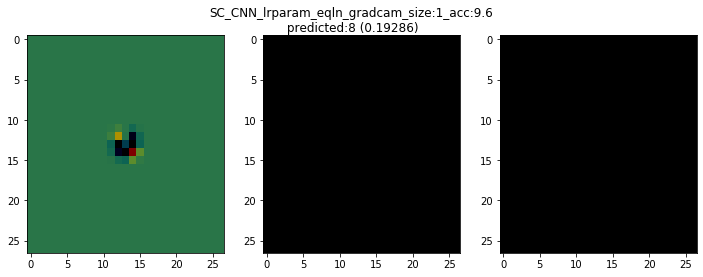










  1%|          | 1/112 [00:01<02:02,  1.11s/it]

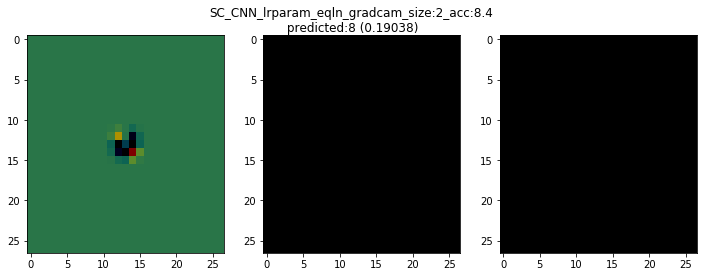










  2%|▏         | 2/112 [00:02<01:56,  1.06s/it]

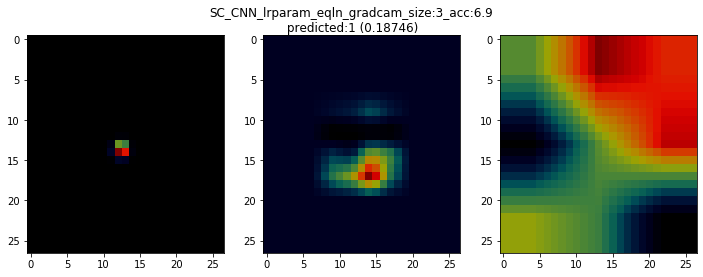










  3%|▎         | 3/112 [00:03<01:52,  1.03s/it]

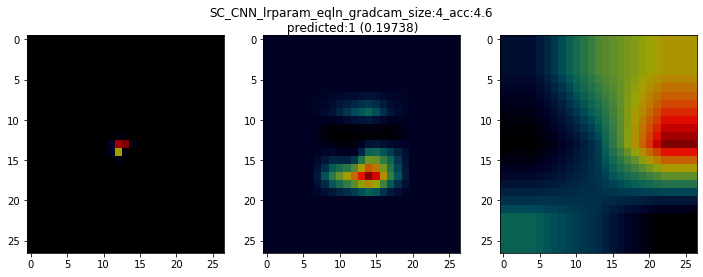










  4%|▎         | 4/112 [00:03<01:47,  1.00it/s]

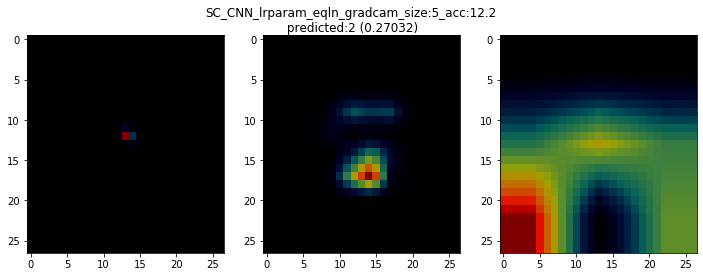










  4%|▍         | 5/112 [00:04<01:44,  1.02it/s]

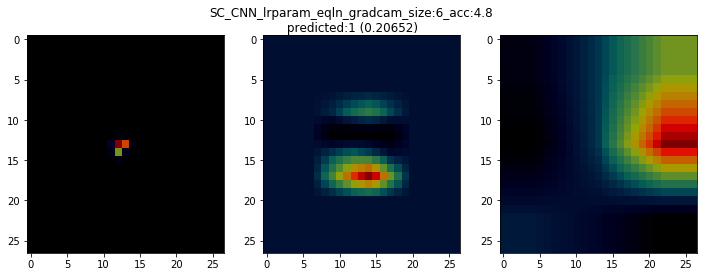










  5%|▌         | 6/112 [00:05<01:42,  1.04it/s]

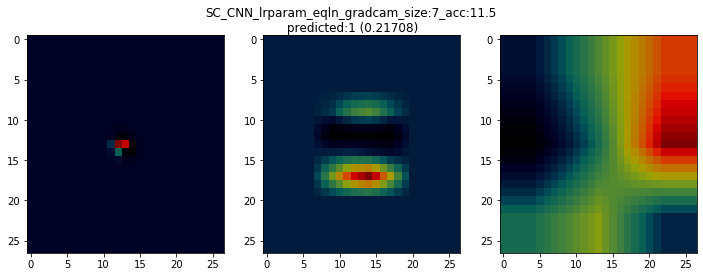










  6%|▋         | 7/112 [00:07<01:54,  1.09s/it]

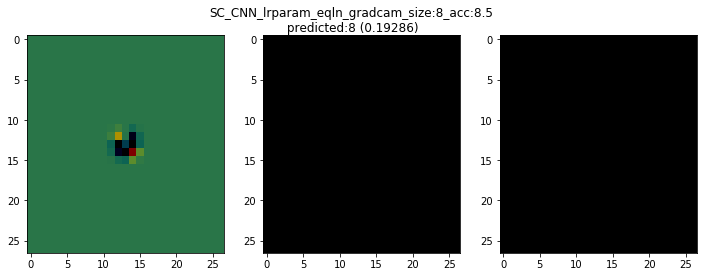










  7%|▋         | 8/112 [00:08<01:47,  1.04s/it]

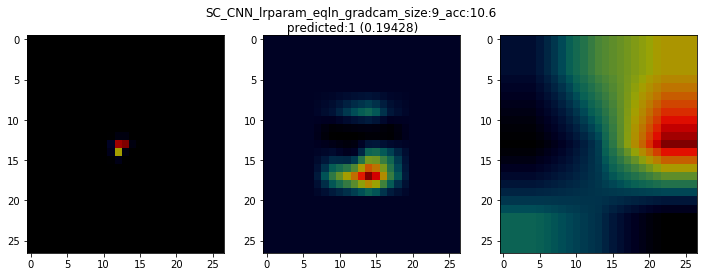










  8%|▊         | 9/112 [00:09<01:43,  1.01s/it]

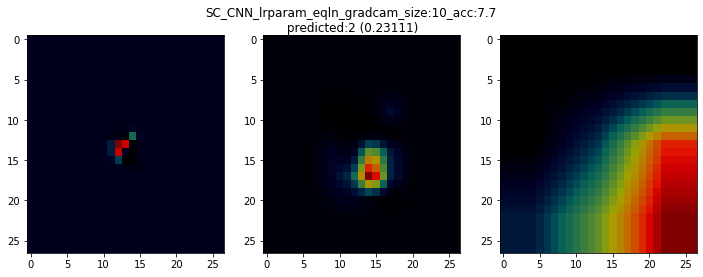










  9%|▉         | 10/112 [00:09<01:40,  1.02it/s]

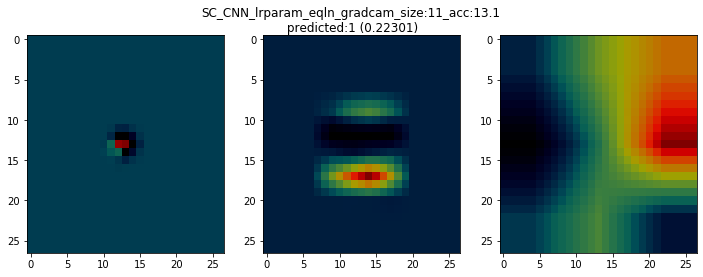










 10%|▉         | 11/112 [00:10<01:37,  1.03it/s]

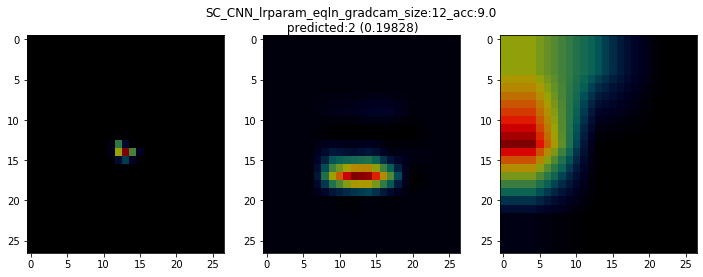










 11%|█         | 12/112 [00:11<01:38,  1.02it/s]

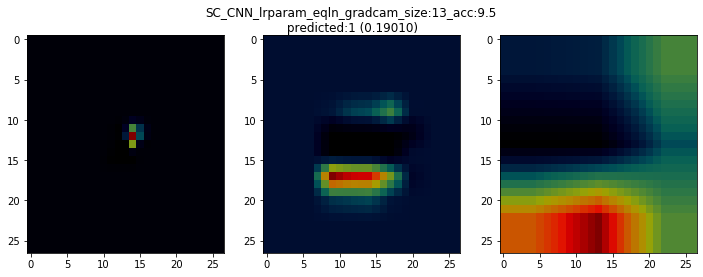










 12%|█▏        | 13/112 [00:12<01:35,  1.04it/s]

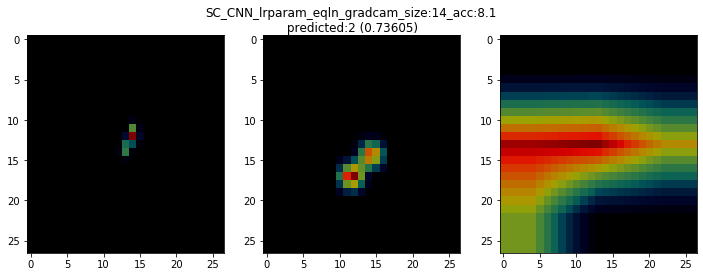










 12%|█▎        | 14/112 [00:13<01:34,  1.04it/s]

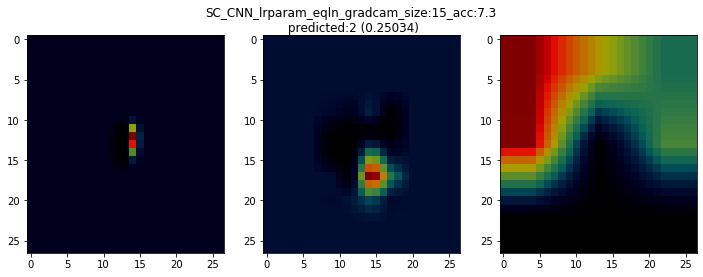










 13%|█▎        | 15/112 [00:14<01:32,  1.05it/s]

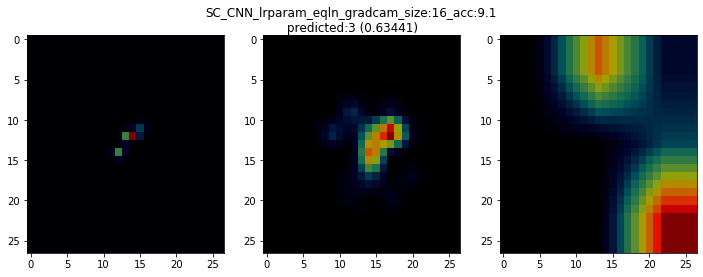










 14%|█▍        | 16/112 [00:15<01:30,  1.06it/s]

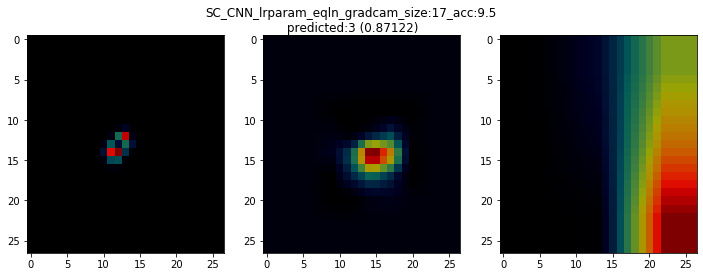










 15%|█▌        | 17/112 [00:16<01:30,  1.05it/s]

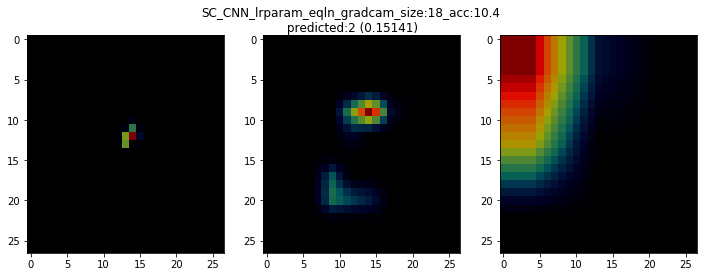










 16%|█▌        | 18/112 [00:17<01:36,  1.02s/it]

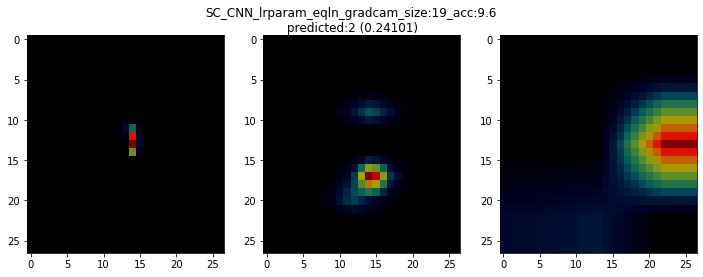










 17%|█▋        | 19/112 [00:18<01:32,  1.00it/s]

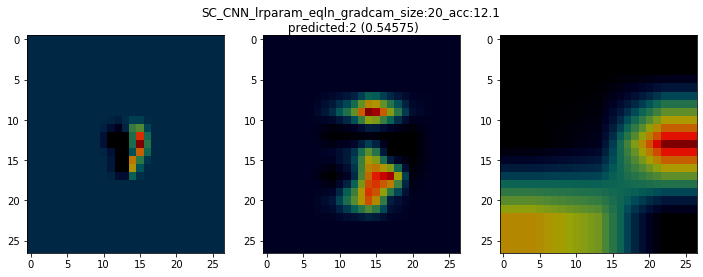










 18%|█▊        | 20/112 [00:19<01:29,  1.02it/s]

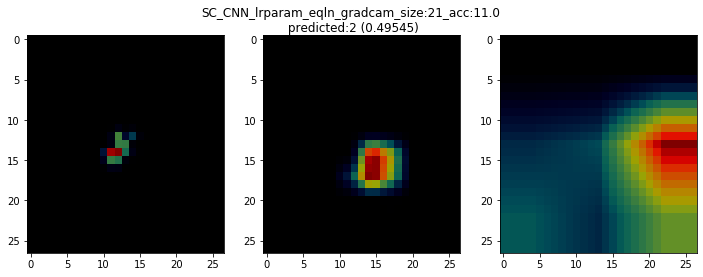










 19%|█▉        | 21/112 [00:20<01:27,  1.03it/s]

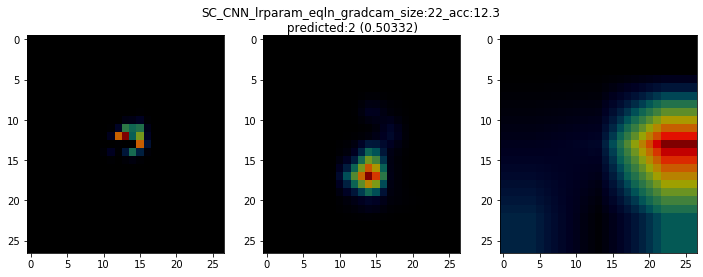










 20%|█▉        | 22/112 [00:21<01:25,  1.05it/s]

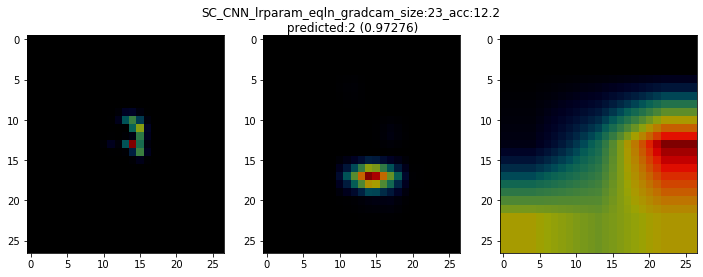










 21%|██        | 23/112 [00:22<01:28,  1.01it/s]

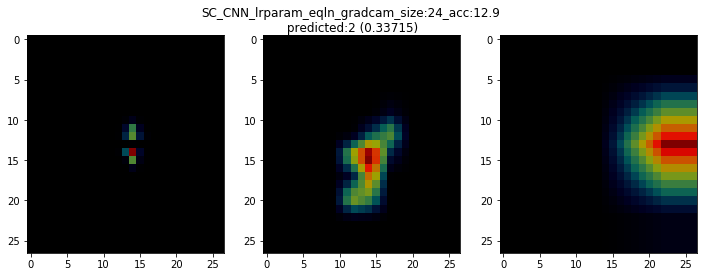










 21%|██▏       | 24/112 [00:23<01:25,  1.03it/s]

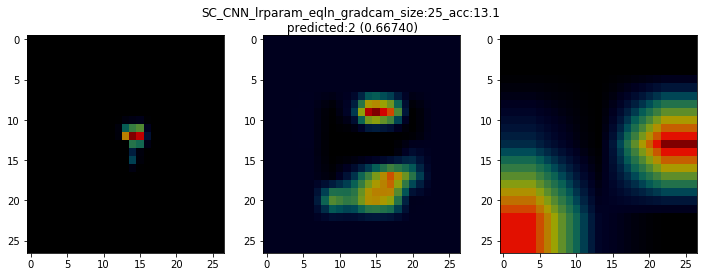










 22%|██▏       | 25/112 [00:24<01:23,  1.04it/s]

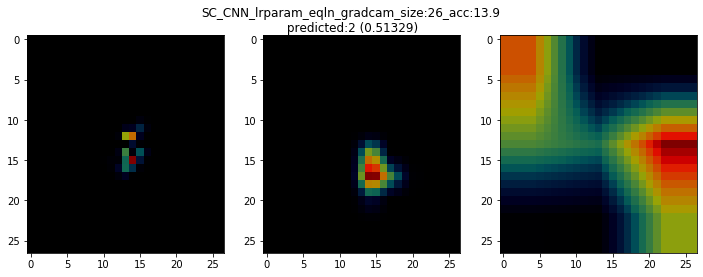










 23%|██▎       | 26/112 [00:25<01:22,  1.04it/s]

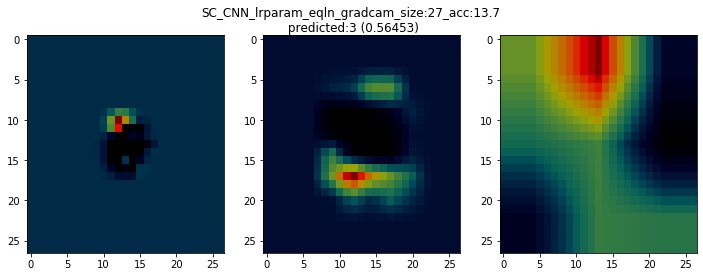










 24%|██▍       | 27/112 [00:26<01:21,  1.04it/s]

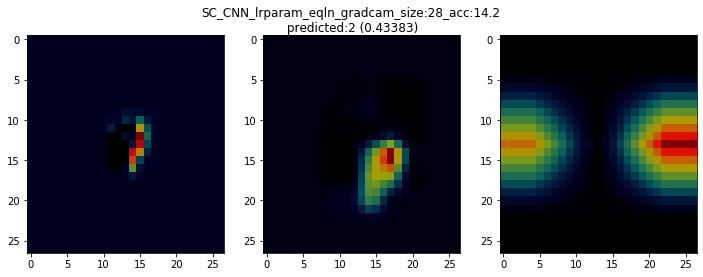










 25%|██▌       | 28/112 [00:27<01:20,  1.04it/s]

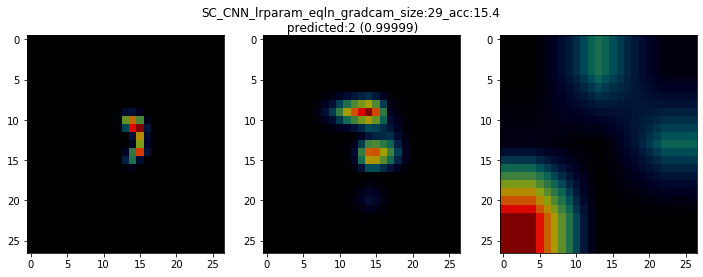










 26%|██▌       | 29/112 [00:28<01:32,  1.11s/it]

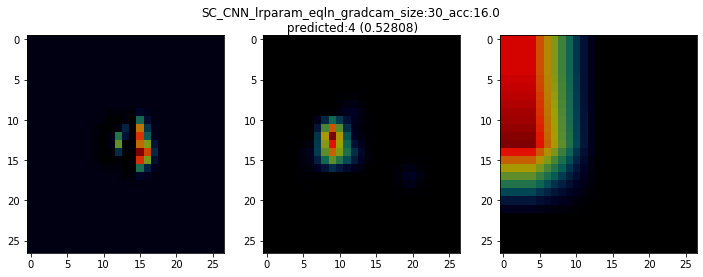










 27%|██▋       | 30/112 [00:29<01:27,  1.06s/it]

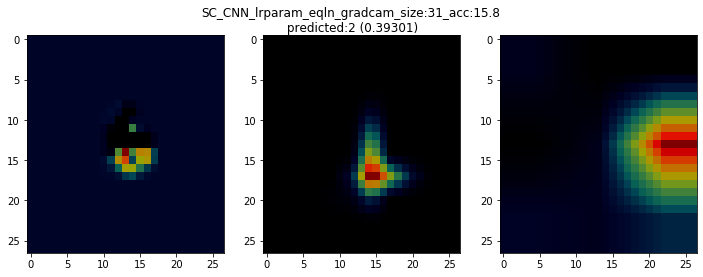










 28%|██▊       | 31/112 [00:30<01:23,  1.02s/it]

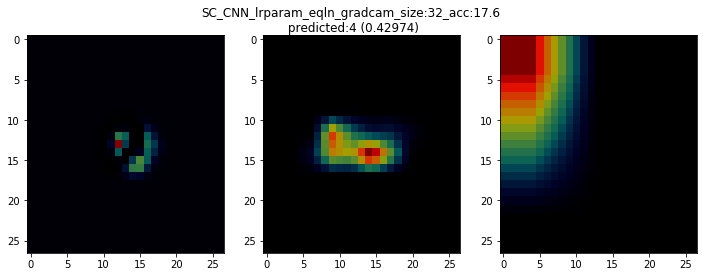










 29%|██▊       | 32/112 [00:31<01:20,  1.00s/it]

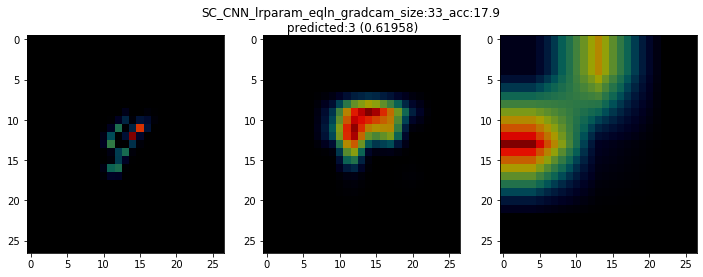










 29%|██▉       | 33/112 [00:32<01:17,  1.02it/s]

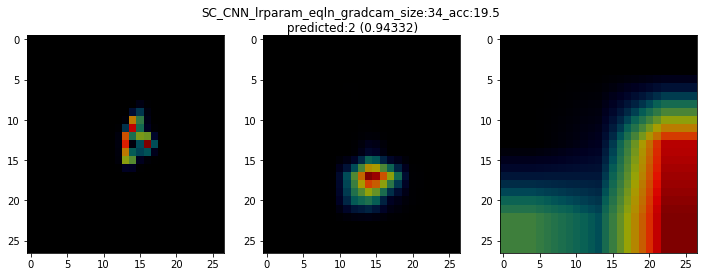










 30%|███       | 34/112 [00:33<01:18,  1.01s/it]

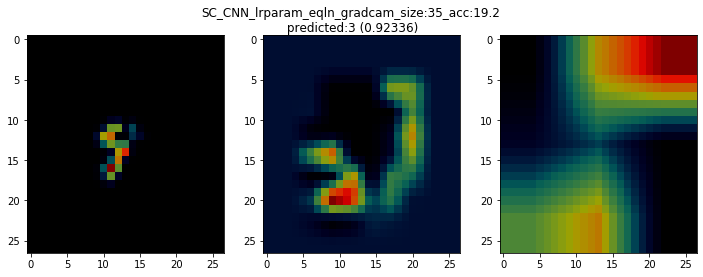










 31%|███▏      | 35/112 [00:34<01:15,  1.01it/s]

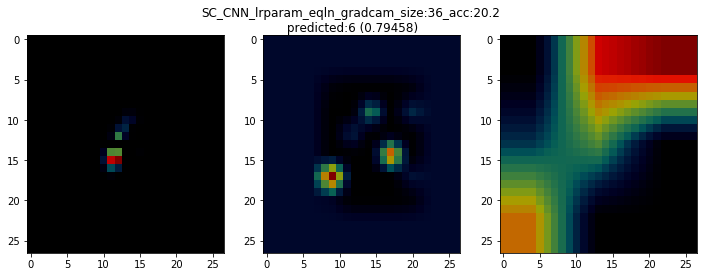










 32%|███▏      | 36/112 [00:35<01:14,  1.02it/s]

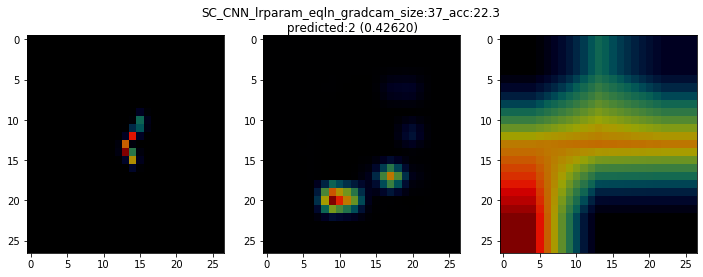










 33%|███▎      | 37/112 [00:36<01:12,  1.03it/s]

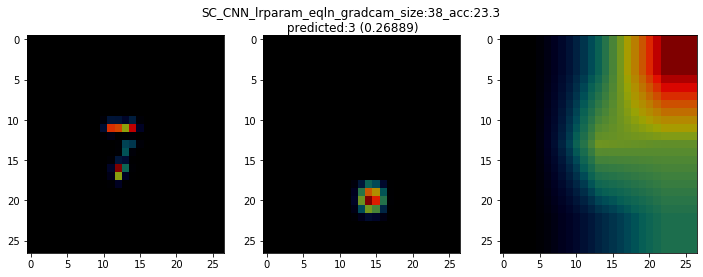










 34%|███▍      | 38/112 [00:37<01:10,  1.04it/s]

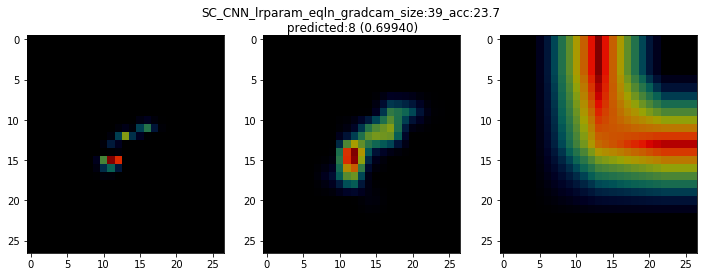










 35%|███▍      | 39/112 [00:38<01:09,  1.05it/s]

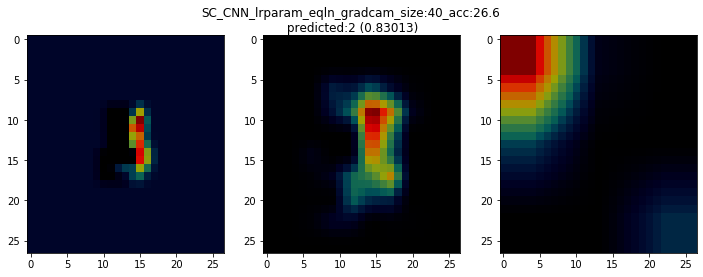










 36%|███▌      | 40/112 [00:40<01:26,  1.20s/it]

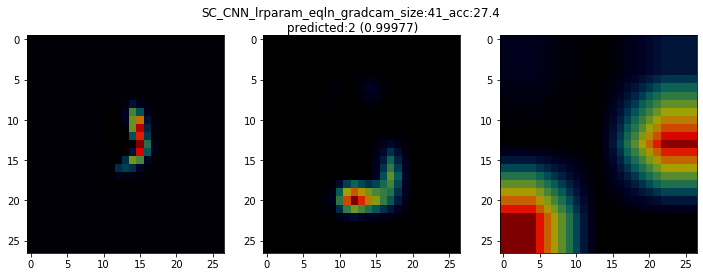










 37%|███▋      | 41/112 [00:41<01:20,  1.13s/it]

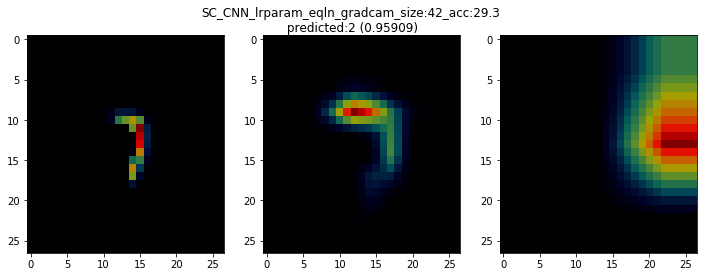










 38%|███▊      | 42/112 [00:42<01:15,  1.08s/it]

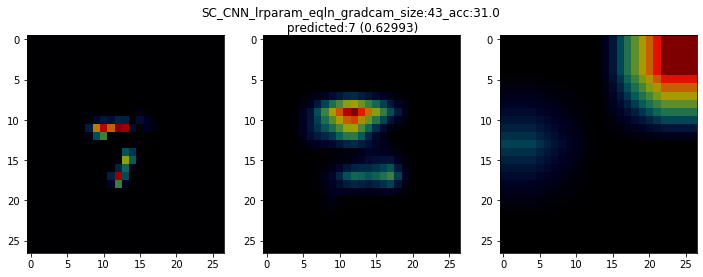










 38%|███▊      | 43/112 [00:43<01:11,  1.04s/it]

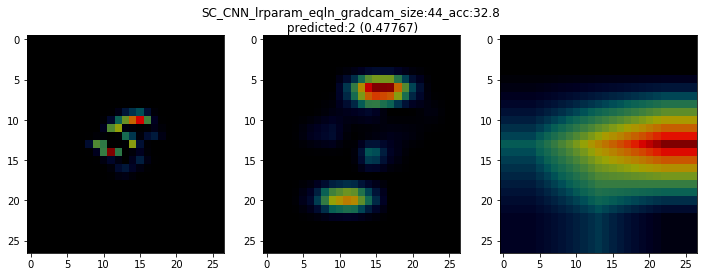










 39%|███▉      | 44/112 [00:43<01:08,  1.01s/it]

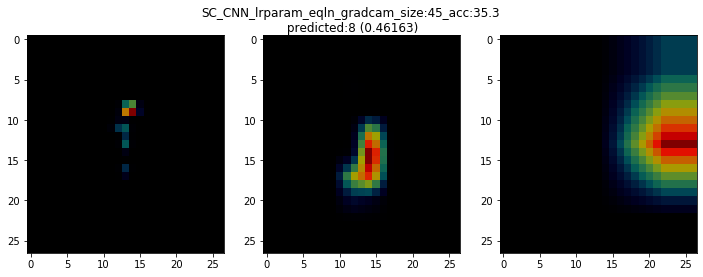










 40%|████      | 45/112 [00:45<01:09,  1.04s/it]

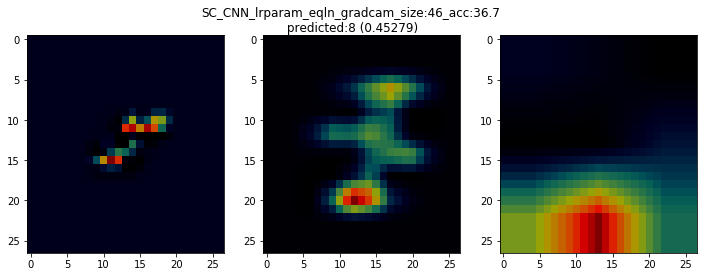










 41%|████      | 46/112 [00:46<01:06,  1.00s/it]

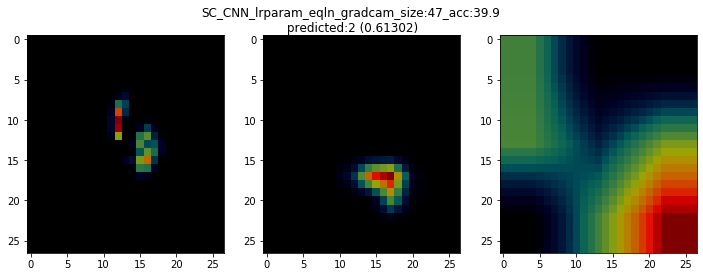










 42%|████▏     | 47/112 [00:46<01:04,  1.01it/s]

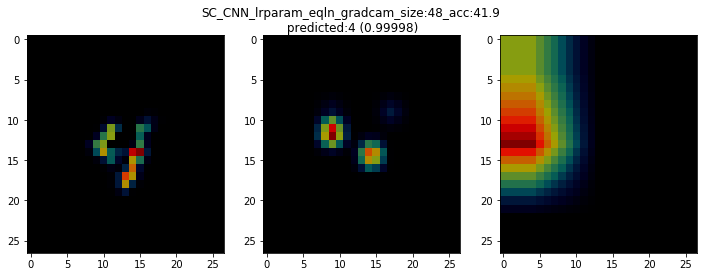










 43%|████▎     | 48/112 [00:47<01:02,  1.03it/s]

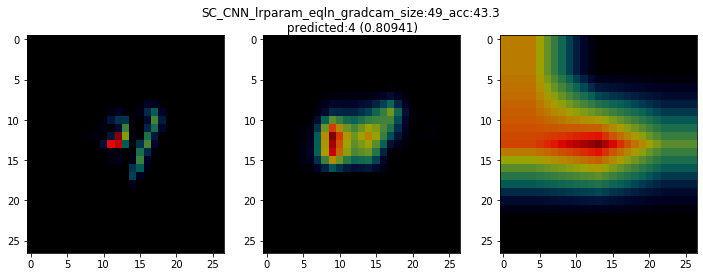










 44%|████▍     | 49/112 [00:48<01:00,  1.04it/s]

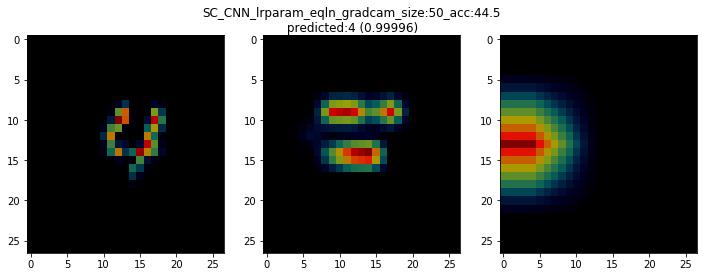










 45%|████▍     | 50/112 [00:49<00:59,  1.05it/s]

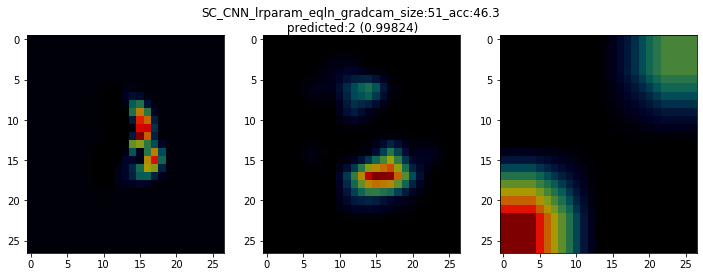










 46%|████▌     | 51/112 [00:51<01:05,  1.07s/it]

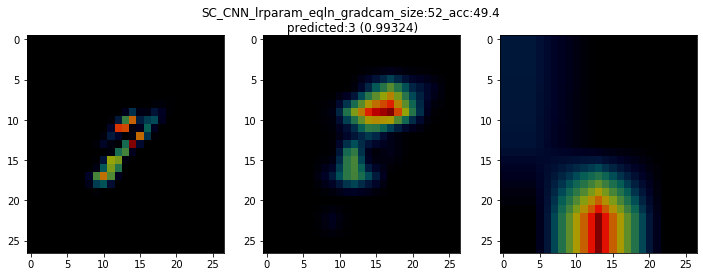










 46%|████▋     | 52/112 [00:52<01:01,  1.03s/it]

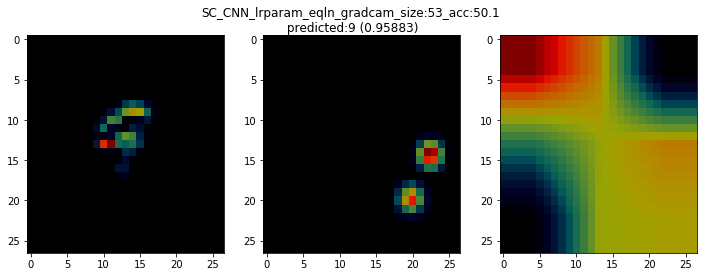










 47%|████▋     | 53/112 [00:52<00:58,  1.00it/s]

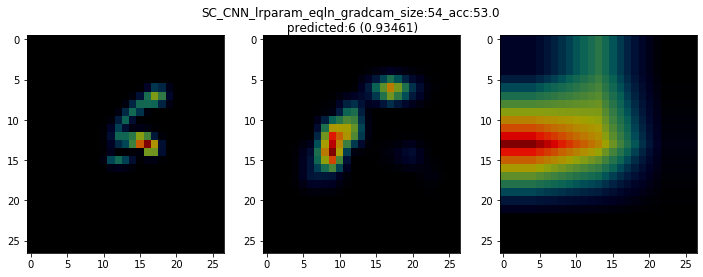










 48%|████▊     | 54/112 [00:53<00:56,  1.03it/s]

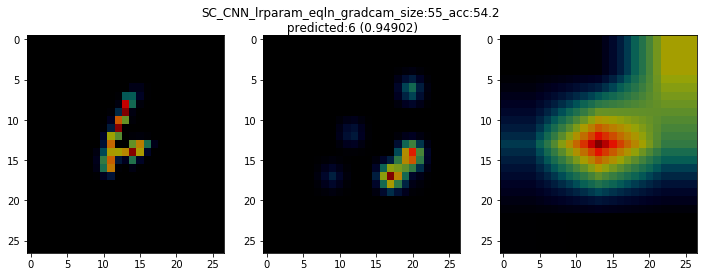










 49%|████▉     | 55/112 [00:54<00:54,  1.04it/s]

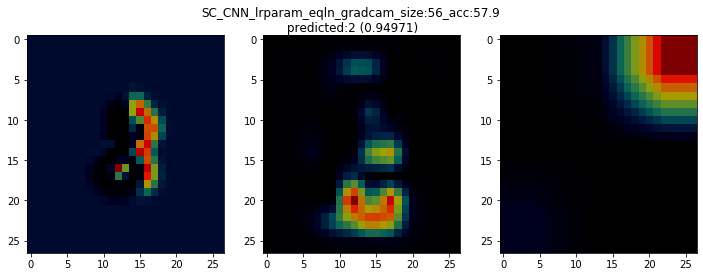










 50%|█████     | 56/112 [00:55<00:55,  1.02it/s]

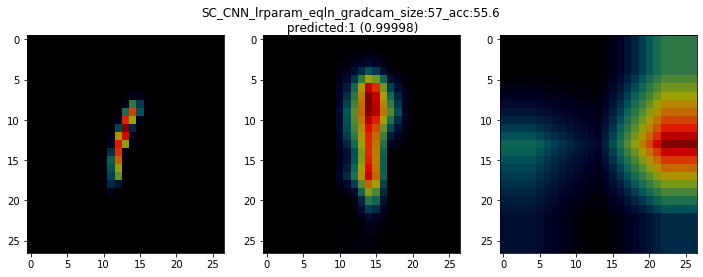










 51%|█████     | 57/112 [00:56<00:53,  1.03it/s]

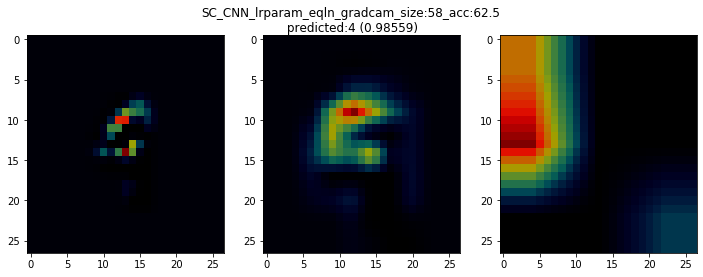










 52%|█████▏    | 58/112 [00:57<00:51,  1.06it/s]

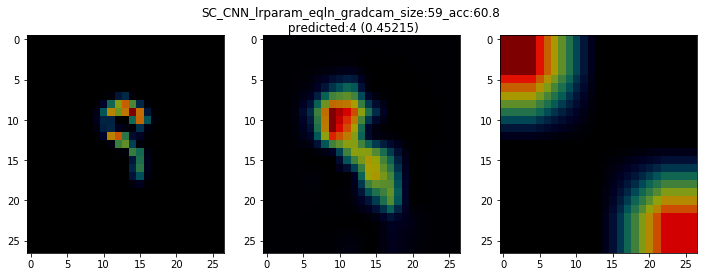










 53%|█████▎    | 59/112 [00:58<00:50,  1.05it/s]

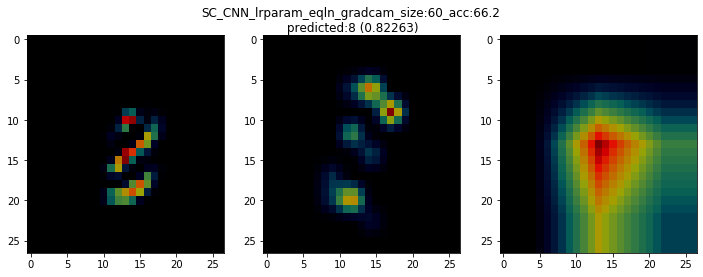










 54%|█████▎    | 60/112 [00:59<00:49,  1.06it/s]

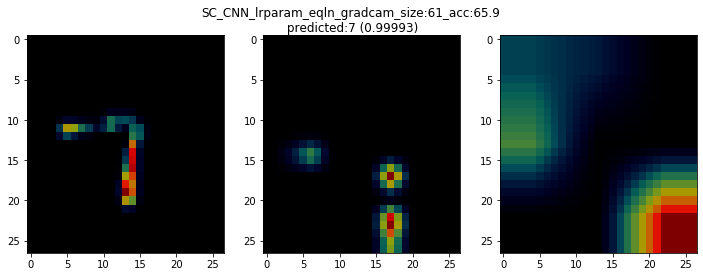










 54%|█████▍    | 61/112 [01:00<00:48,  1.06it/s]

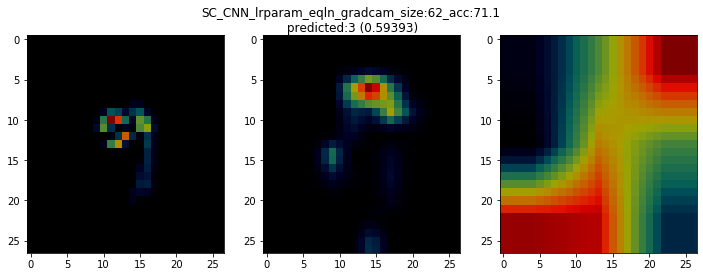










 55%|█████▌    | 62/112 [01:01<00:53,  1.07s/it]

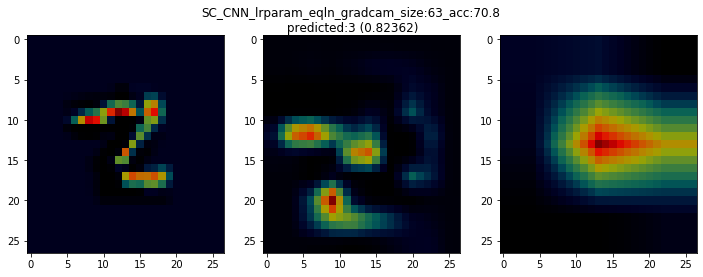










 56%|█████▋    | 63/112 [01:02<00:50,  1.03s/it]

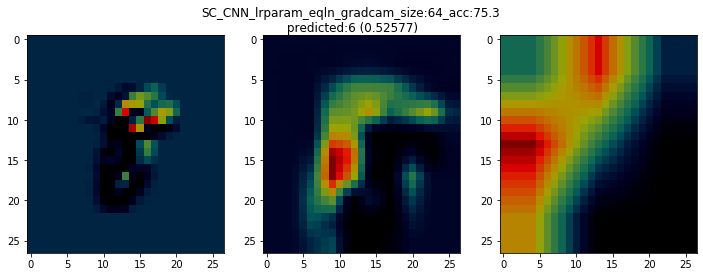










 57%|█████▋    | 64/112 [01:03<00:48,  1.01s/it]

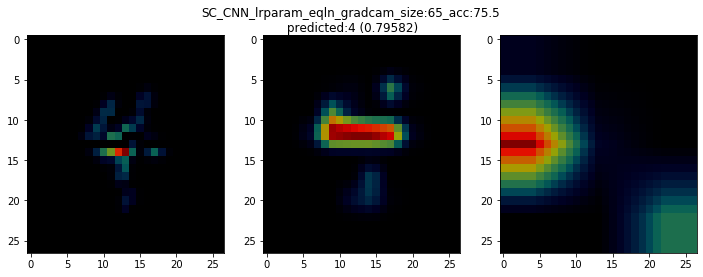










 58%|█████▊    | 65/112 [01:04<00:46,  1.02it/s]

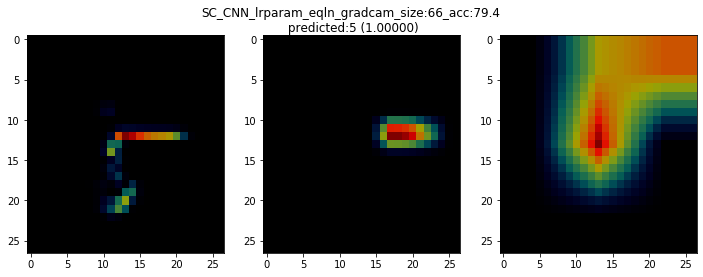










 59%|█████▉    | 66/112 [01:05<00:44,  1.04it/s]

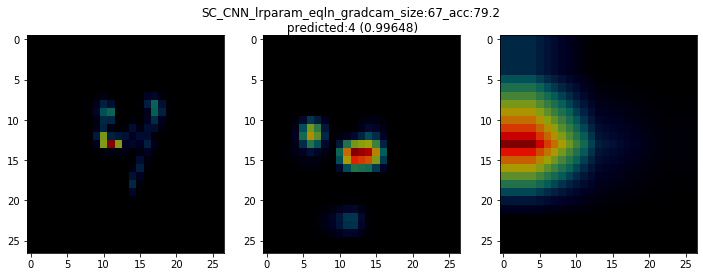










 60%|█████▉    | 67/112 [01:06<00:44,  1.01it/s]

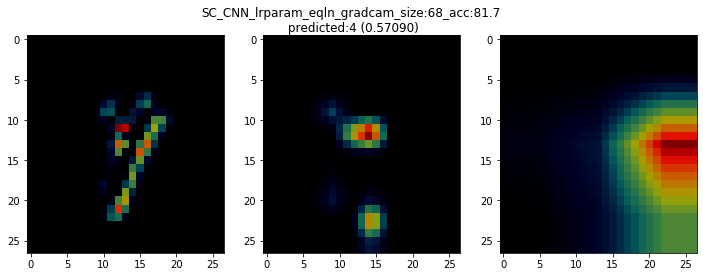










 61%|██████    | 68/112 [01:07<00:42,  1.02it/s]

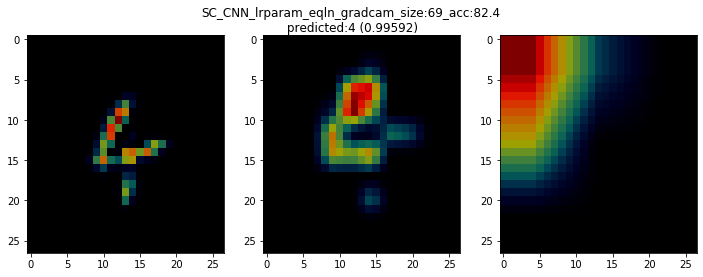










 62%|██████▏   | 69/112 [01:08<00:41,  1.03it/s]

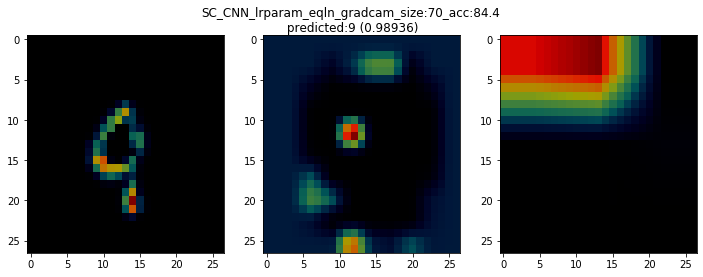










 62%|██████▎   | 70/112 [01:09<00:40,  1.05it/s]

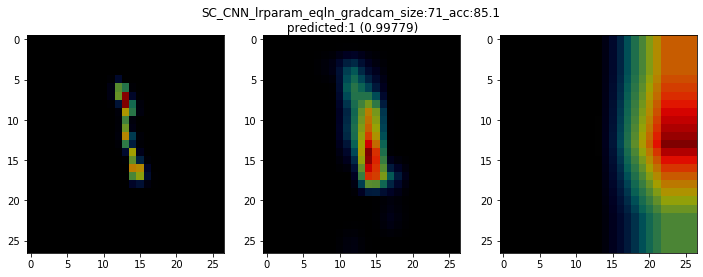










 63%|██████▎   | 71/112 [01:10<00:38,  1.06it/s]

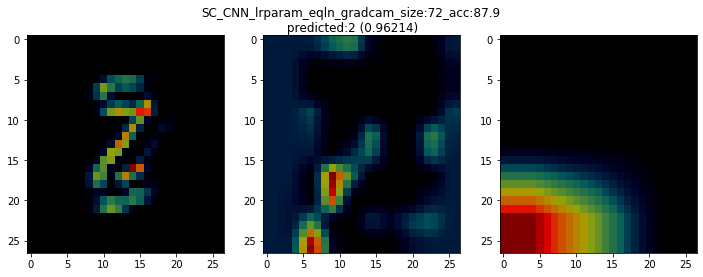










 64%|██████▍   | 72/112 [01:11<00:37,  1.06it/s]

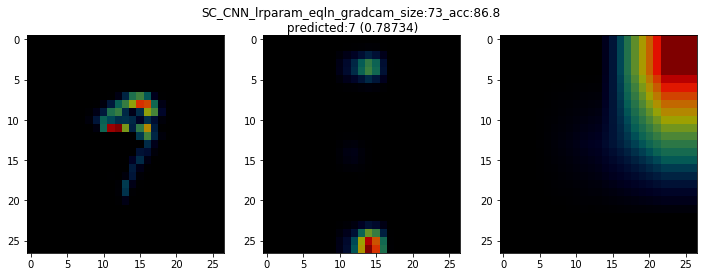










 65%|██████▌   | 73/112 [01:12<00:42,  1.09s/it]

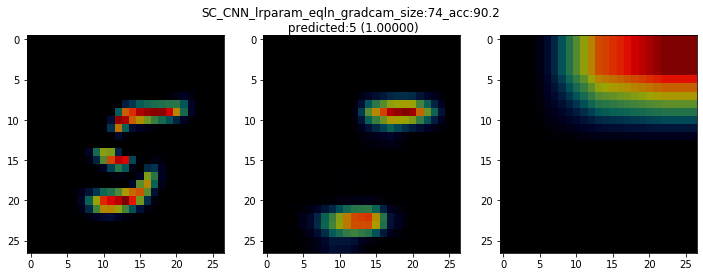










 66%|██████▌   | 74/112 [01:13<00:39,  1.04s/it]

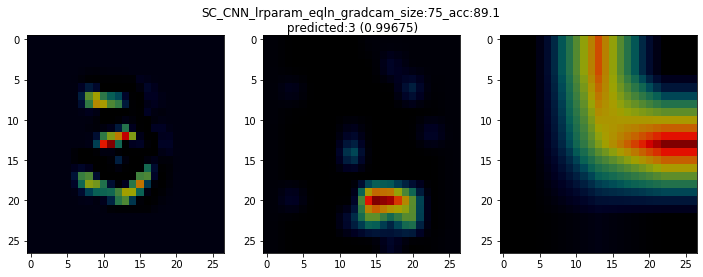










 67%|██████▋   | 75/112 [01:14<00:37,  1.01s/it]

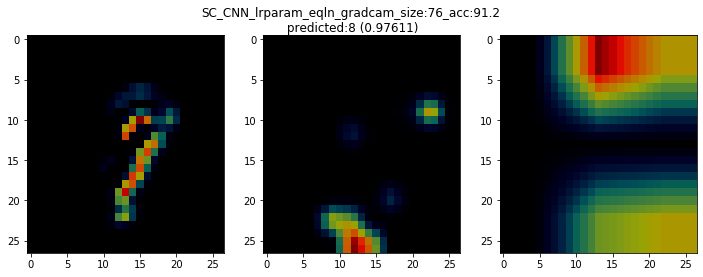










 68%|██████▊   | 76/112 [01:15<00:35,  1.01it/s]

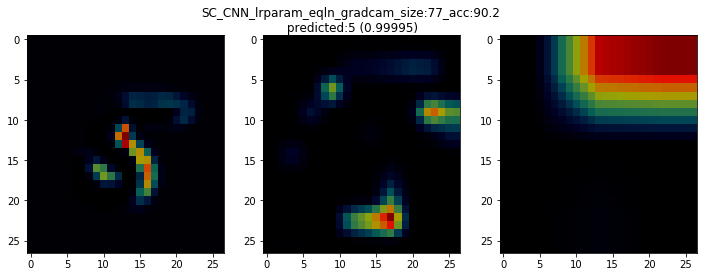










 69%|██████▉   | 77/112 [01:16<00:34,  1.03it/s]

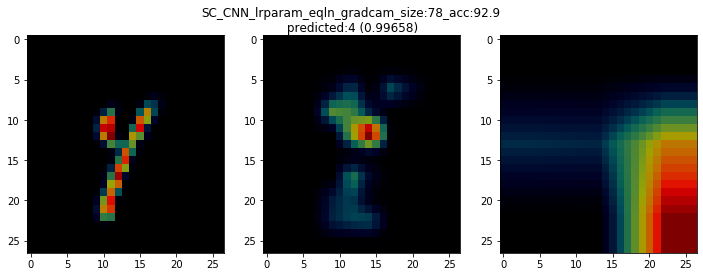










 70%|██████▉   | 78/112 [01:17<00:34,  1.01s/it]

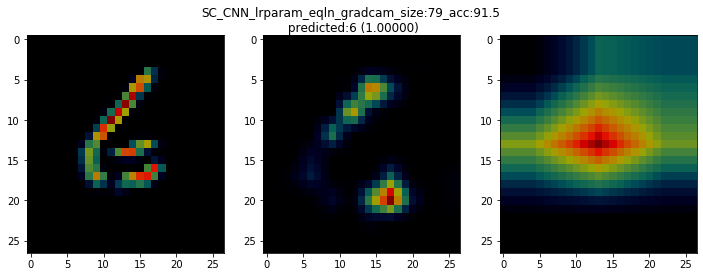










 71%|███████   | 79/112 [01:18<00:32,  1.01it/s]

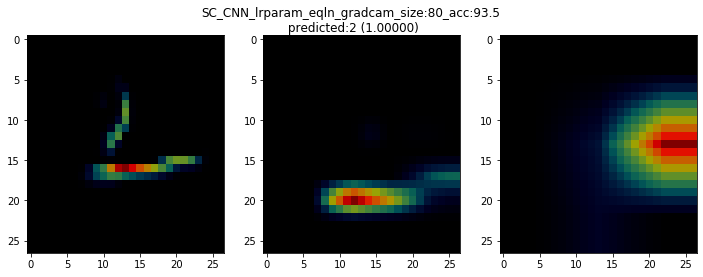










 71%|███████▏  | 80/112 [01:19<00:31,  1.03it/s]

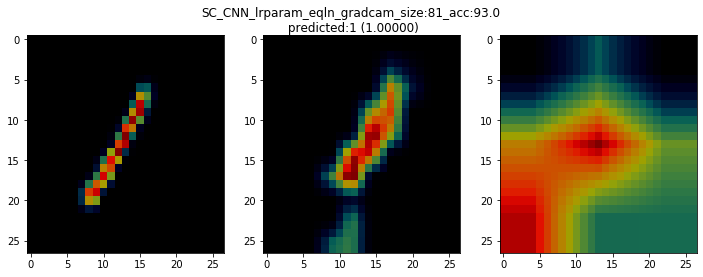










 72%|███████▏  | 81/112 [01:20<00:29,  1.05it/s]

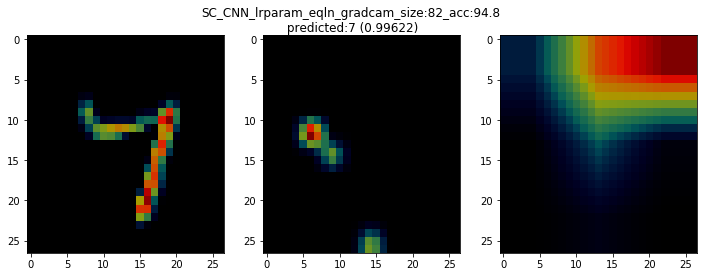










 73%|███████▎  | 82/112 [01:21<00:28,  1.05it/s]

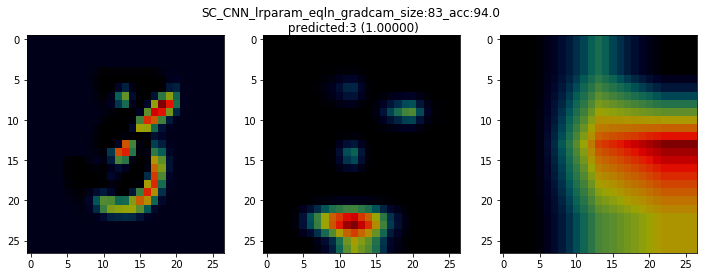










 74%|███████▍  | 83/112 [01:22<00:27,  1.07it/s]

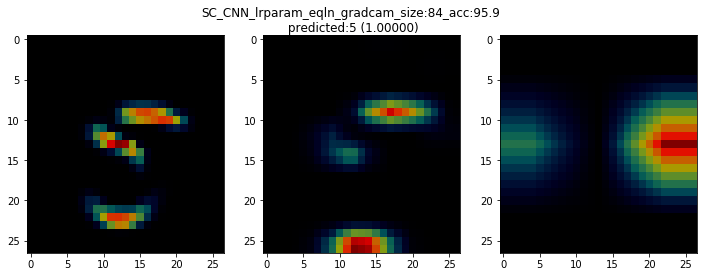










 75%|███████▌  | 84/112 [01:23<00:28,  1.01s/it]

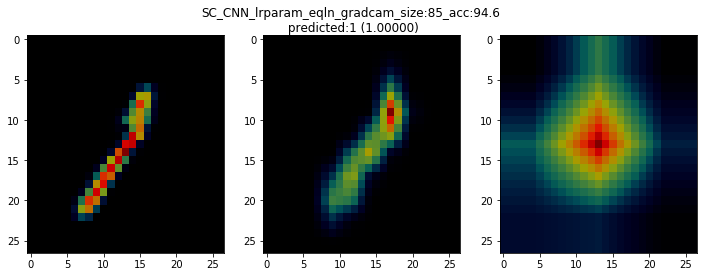










 76%|███████▌  | 85/112 [01:24<00:26,  1.02it/s]

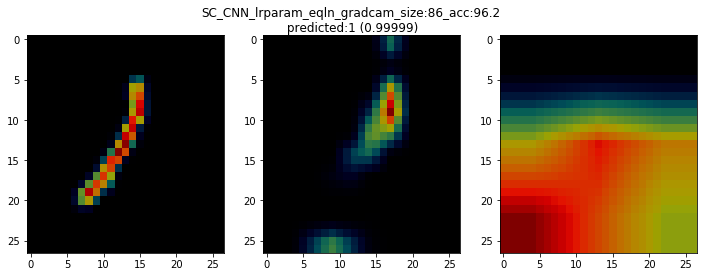










 77%|███████▋  | 86/112 [01:25<00:24,  1.04it/s]

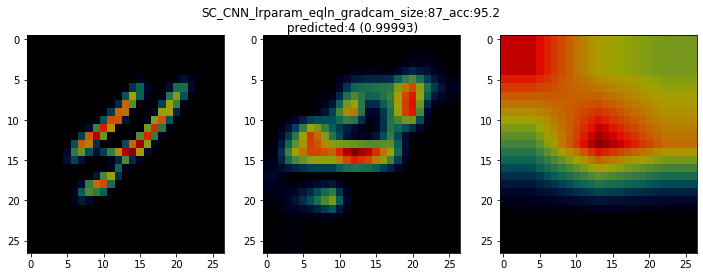










 78%|███████▊  | 87/112 [01:26<00:23,  1.05it/s]

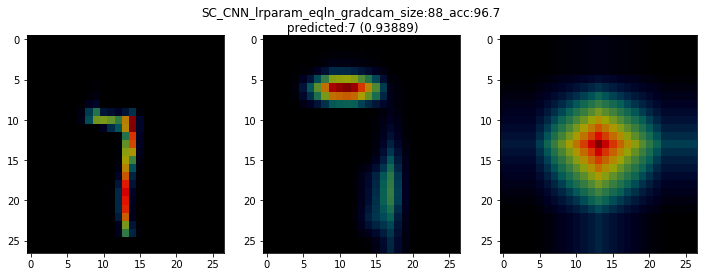










 79%|███████▊  | 88/112 [01:27<00:22,  1.06it/s]

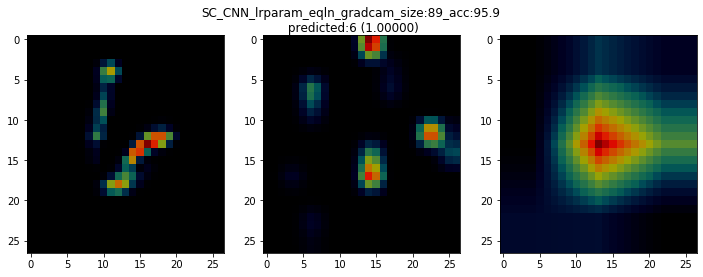










 79%|███████▉  | 89/112 [01:28<00:22,  1.01it/s]

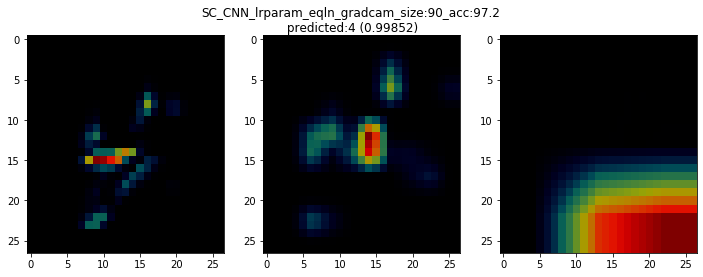










 80%|████████  | 90/112 [01:29<00:21,  1.03it/s]

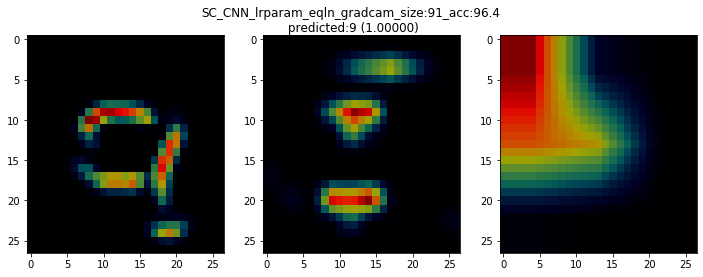










 81%|████████▏ | 91/112 [01:30<00:20,  1.04it/s]

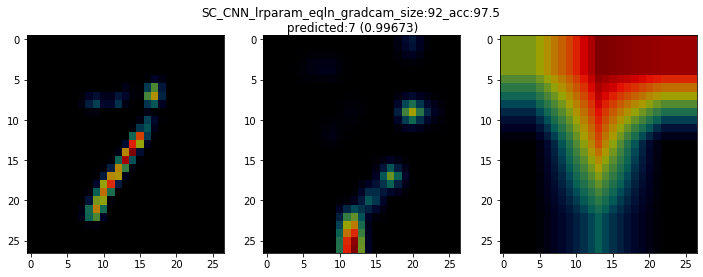










 82%|████████▏ | 92/112 [01:30<00:19,  1.05it/s]

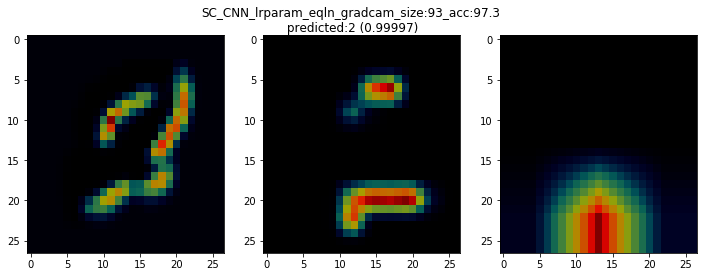










 83%|████████▎ | 93/112 [01:31<00:18,  1.05it/s]

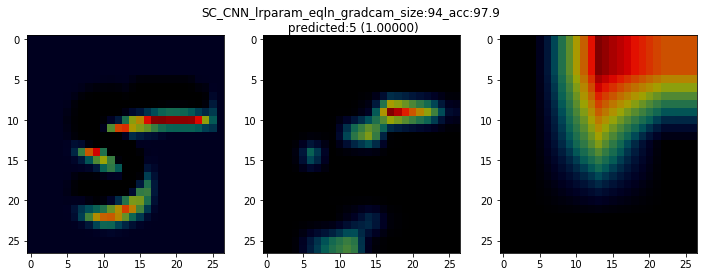










 84%|████████▍ | 94/112 [01:32<00:17,  1.05it/s]

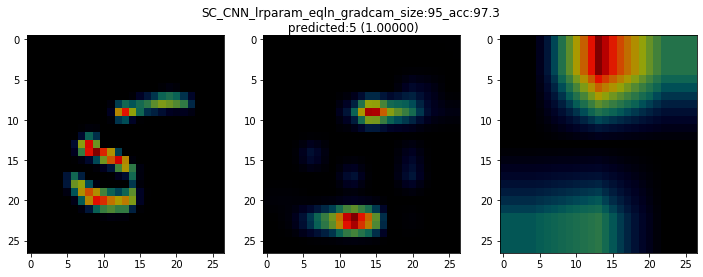










 85%|████████▍ | 95/112 [01:34<00:17,  1.03s/it]

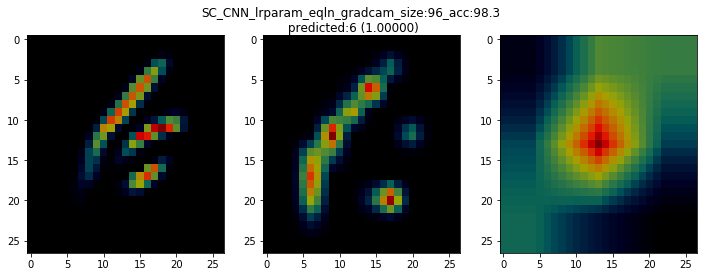










 86%|████████▌ | 96/112 [01:35<00:16,  1.00s/it]

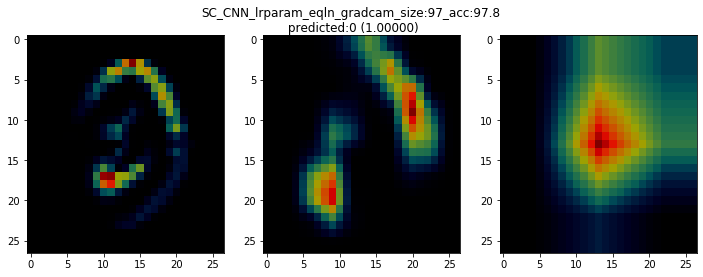










 87%|████████▋ | 97/112 [01:35<00:14,  1.02it/s]

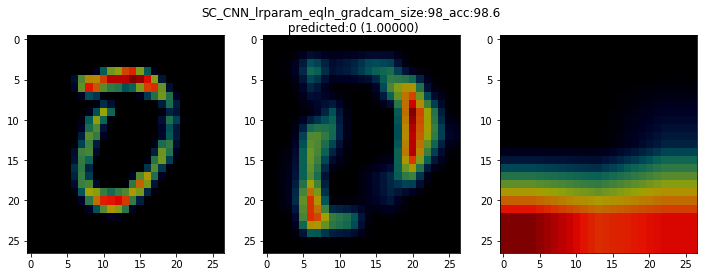










 88%|████████▊ | 98/112 [01:36<00:13,  1.04it/s]

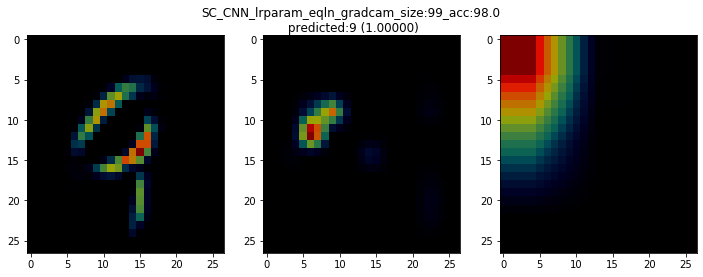










 88%|████████▊ | 99/112 [01:37<00:12,  1.04it/s]

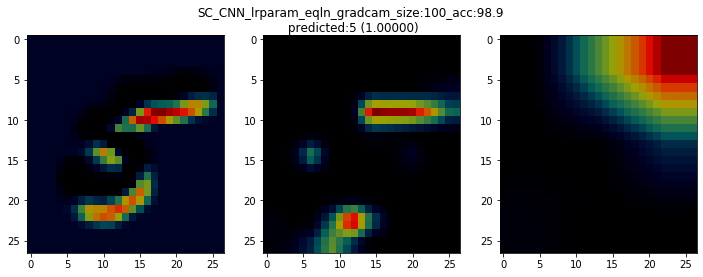










 89%|████████▉ | 100/112 [01:38<00:11,  1.02it/s]

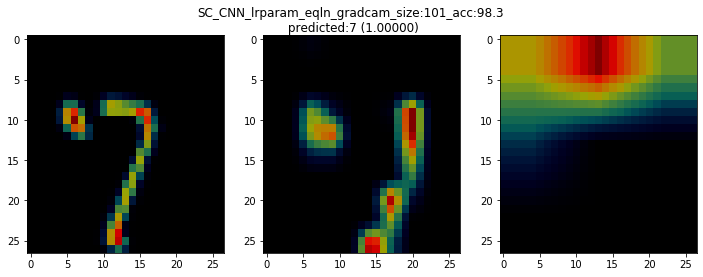










 90%|█████████ | 101/112 [01:39<00:10,  1.04it/s]

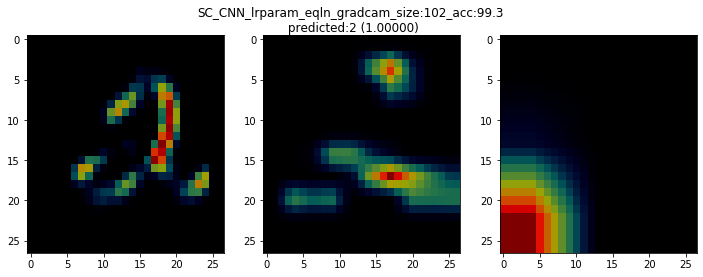










 91%|█████████ | 102/112 [01:40<00:09,  1.04it/s]

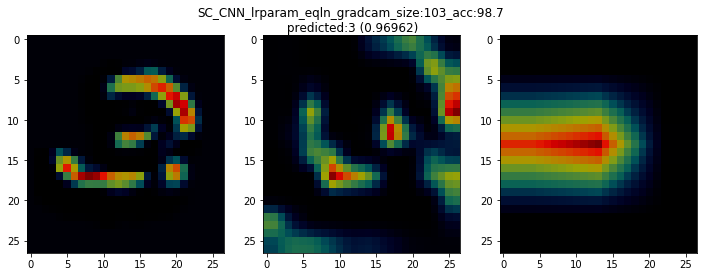










 92%|█████████▏| 103/112 [01:41<00:08,  1.04it/s]

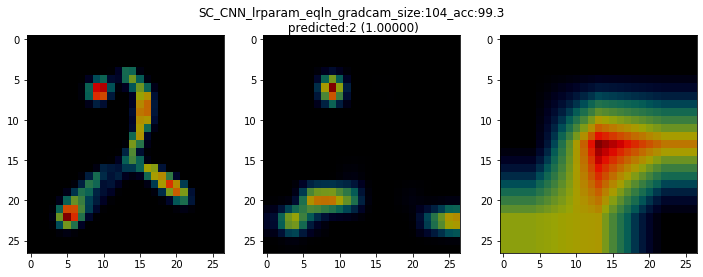










 93%|█████████▎| 104/112 [01:42<00:07,  1.04it/s]

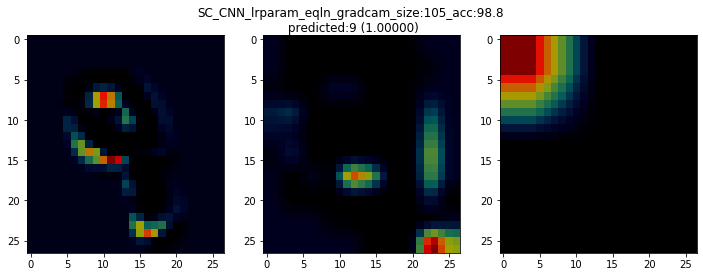










 94%|█████████▍| 105/112 [01:43<00:06,  1.05it/s]

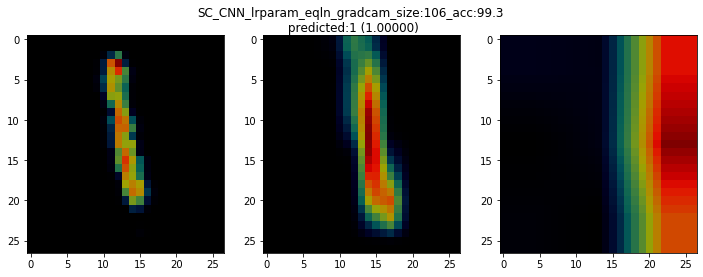










 95%|█████████▍| 106/112 [01:44<00:06,  1.07s/it]

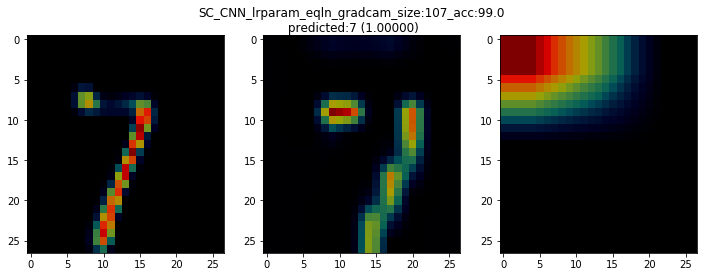










 96%|█████████▌| 107/112 [01:45<00:05,  1.03s/it]

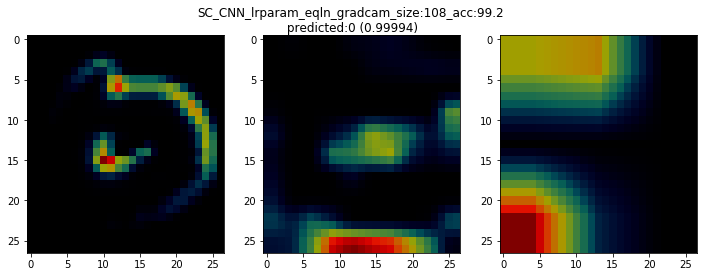










 96%|█████████▋| 108/112 [01:46<00:04,  1.00s/it]

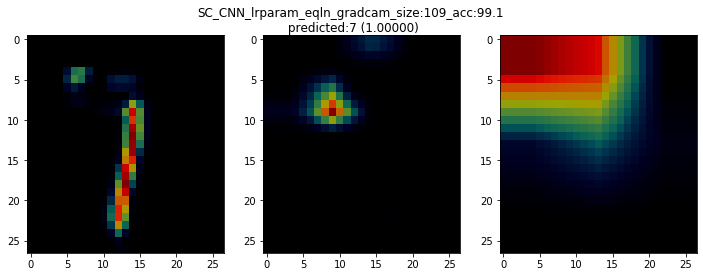










 97%|█████████▋| 109/112 [01:47<00:02,  1.02it/s]

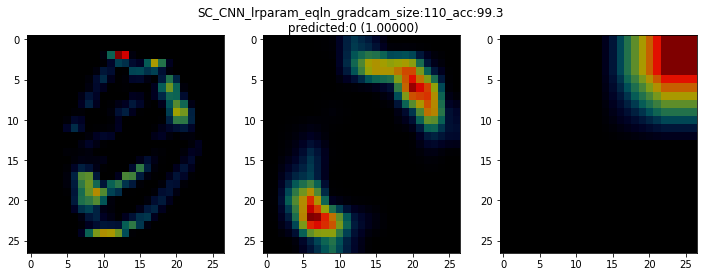










 98%|█████████▊| 110/112 [01:48<00:01,  1.03it/s]

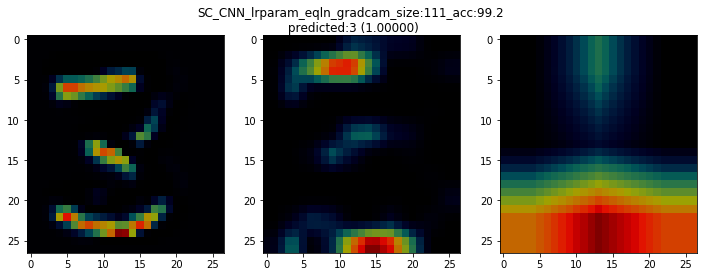










 99%|█████████▉| 111/112 [01:49<00:00,  1.00it/s]

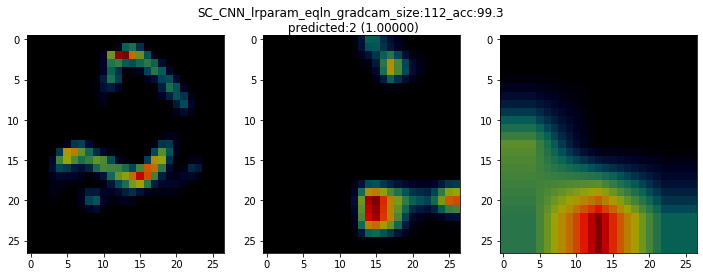










100%|██████████| 112/112 [01:50<00:00,  1.01it/s]


In [62]:
from matplotlib import gridspec

model1.eval()
model2.eval()
gcam = GradCAM(model=model1)
gbp = GuidedBackPropagation(model=model2)

gridspec.GridSpec(3,6)

imsize = 1
for testloader in tqdm(gradcam_gen_arr):
    for images in testloader:
        v1 = images[0][0].to(device)
        val_labels = images[0][1].to(device)
        break

    _ = gcam.forward(v1)
    probs,ids = gbp.forward(v1)

    gcam.backward(ids=ids[:,[0]])
    gbp.backward(ids=ids[:,[0]])

    grad_img = []

    for j in range(len(v1)):
        grad_img.append([])
        for name, module in model1.named_modules():
            #print(name)
            if name == '' or name == 'module' or name == 'module.fc1' or name == 'module.fc2' or name == 'module.fc3' or name == 'module.pool1' or name == 'module.pool2' or name == 'module.pool3':
                continue
            regions = gcam.generate(target_layer=name)
            gradients = gbp.generate()
            #print("\t#{}: {} ({:.5f})".format(j, ids[j, 0], probs[j, 0]))
            #print(regions[j,0])
            grad_img[j].append(show_gradcam(gcam=regions[j,0],raw_image=imshow(v1[j].cpu()),show=False))

    img_num = [0,1,2,3,4,5,15,16,17,18,19,20,31,32,33,34]
    col_num = [1,1,1]
    title = ['conv1','conv2','conv3']#,'sc2_conv(9,3,1)','sc3','sc3_conv(9,3,1)']
    size = 243
    
    scale = 3./size
    plt.figure(figsize=(12,4))
    plt.suptitle('SC_CNN_lrparam_eqln_gradcam'+'_size:'+str(imsize)+'_acc:'+str(temp_acc[imsize-1])+'\n predicted:{} ({:.5f})'.format(ids[0, 0], probs[0, 0]))
    
    num = 0
    for i in range(len(col_num)):
        plt.subplot(1,3,i+1)
        display_grid = np.zeros((27,27,3)).astype(np.uint8)
        for row in range(col_num[i]):
            display_grid[:,:,:3] = grad_img[0][num]
            num = num+1
        plt.grid(False)
        plt.imshow(display_grid,aspect='auto')
    plt.savefig('gradcam_lenet/pltgrad'+str(imsize)+'.png')
    plt.show()
    imsize = imsize+1

In [60]:
import cv2

frame_array = []
for i in range(1,113):
    filename='gradcam_lenet/pltgrad' + str(i)+'.png'
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)
    
out = cv2.VideoWriter('gradcam_lenet/gradcam_shuffled_jan28.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 5, size)
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()